In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys
import re

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests10 as vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [3]:
nsims= 700
trials =1000
skip_boot=False
skip_shi=False
refinement_test=True
linspace=40
smoothing =5
adapt_c= True

In [4]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    col_labels = ['Param','Vuong 1 Step','Vuong 2 Step', 'Refinement Test','Shi (2015)', 'Naive Bootstrap','Bootstrap TIC','Bootstrap ND']



    np_results = np.concatenate((params.reshape(params.shape[0],1),results2[:,:,0]),axis=1)
    df_results = pd.DataFrame(data=np_results,columns=col_labels)
    df_results.to_csv("paper_figs8/"+name[:-4]+".csv")
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 Step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 Step')
    
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Bootstrap ND')
        
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')

    plt.legend()
    plt.savefig('paper_figs8/'+name,dpi=300)
    plt.show()



In [5]:
def keep_alphanumeric(string):
    return re.sub(r'[^a-zA-Z0-9_]', '', string)


def mc_run_size(nobs,c1,c2,data_tuned_c=None):
    betas = np.linspace(0,3,linspace)
    results = []

    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
        gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,
                                              c1=c1,c2=c2,data_tuned_c=data_tuned_c)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
        print(beta,boot3)

    name = keep_alphanumeric('size_c1%s_c2%s_datac%s_nobs%s_trials%s'%(c1,c2,data_tuned_c,nobs,trials))
    name = name+'.png'
    print('--------saving fig------------')
    print(name)
    print('--------------------')
    create_fig(betas,results,name=name)

In [6]:
def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

def mc_run_power(nobs,c1,c2,data_tuned_c=None):
    betas = np.linspace(0,3,linspace)
    results = []
    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
        gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,
                                              c1=c1,c2=c2,data_tuned_c=data_tuned_c)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

    name = keep_alphanumeric('power_c1%s_c2%s_datac%s_nobs%s_trials%s'%(c1,c2,data_tuned_c,nobs,trials))
    name = name+'.png'
    print('--------saving fig------------')
    print(name)
    print('--------------------')
    create_fig(betas,results,name=name)

# sequence 1

Quantiles: 1th: 0.98, 5th: 4.63, 10th: 13.06, 30th: 109.66, 50th: 340.61, 70th: 794.24, 90th: 1984.13, 95th: 2745.04, 99th: 5228.95
bonus term 0.9003689891960472 // variance stats 2.270518623990662 //part1 1.93069772888325 //part2 0.46634383815059266
-0.12071866394744825 -0.07877525237158473 1.9771838712494034
-1.921456642339543 -0.07877525237158473 0.17644589285730905
---
Quantiles: 1th: 0.67, 5th: 3.73, 10th: 13.73, 30th: 125.70, 50th: 374.49, 70th: 876.94, 90th: 2101.06, 95th: 3073.24, 99th: 4981.16
bonus term 1.5380590470888527 // variance stats 0.5363625638262045 //part1 1.93069772888325 //part2 0.7966337889559197
1.129331121042586 -0.5143703941697728 1.9430320253446118
-1.9467869731351193 -0.5143703941697728 -1.1330860688330935
---
Quantiles: 1th: 0.33, 5th: 3.40, 10th: 11.40, 30th: 94.79, 50th: 299.48, 70th: 722.25, 90th: 1844.87, 95th: 2619.14, 99th: 4544.92
bonus term 0.7194707848109156 // variance stats 3.105841192521314 //part1 1.93069772888325 //part2 0.3726480712374745
-0.

-1.0915718955674412 0.5715839582779019 2.028919235495364
-1.9429613328774598 0.5715839582779019 1.177529798185345
---
Quantiles: 1th: 0.56, 5th: 3.55, 10th: 11.71, 30th: 115.01, 50th: 360.94, 70th: 859.97, 90th: 2138.00, 95th: 3071.06, 99th: 5189.86
bonus term 1.0013845764640816 // variance stats 1.9841214581544742 //part1 1.93069772888325 //part2 0.5186646057968383
0.06317870009196826 -0.1629861677889664 1.9264153281329082
-1.939590452836195 -0.1629861677889664 -0.07635382479525511
---
Quantiles: 1th: 0.32, 5th: 2.68, 10th: 8.46, 30th: 69.78, 50th: 224.10, 70th: 506.18, 90th: 1267.64, 95th: 1829.33, 99th: 3085.29
bonus term 1.026932751934536 // variance stats 1.1156029632824618 //part1 1.93069772888325 //part2 0.5318972185918156
0.11265310948665425 -0.31771196539891516 1.9449130217818003
-1.9412123943824175 -0.31771196539891516 -0.10895248208727153
---
Quantiles: 1th: 0.43, 5th: 2.59, 10th: 7.99, 30th: 59.04, 50th: 179.37, 70th: 427.81, 90th: 1073.38, 95th: 1536.67, 99th: 2537.52
bonu

Quantiles: 1th: 0.30, 5th: 2.25, 10th: 6.67, 30th: 52.55, 50th: 168.02, 70th: 389.93, 90th: 978.21, 95th: 1393.16, 99th: 2436.20
bonus term 1.2925240918948064 // variance stats 0.48298242384210366 //part1 1.93069772888325 //part2 0.6694595806265465
0.6382302691328191 -0.6006839657002655 1.9572210003468256
-1.9468179146567937 -0.6006839657002655 -0.6278271834427873
---
Quantiles: 1th: 0.49, 5th: 3.43, 10th: 11.29, 30th: 96.90, 50th: 288.25, 70th: 681.05, 90th: 1781.00, 95th: 2585.24, 99th: 4413.97
bonus term 1.0341929232142888 // variance stats 1.5438860195082442 //part1 1.93069772888325 //part2 0.5356576059228517
0.03282600367653969 -0.24113196535751347 1.8891806521443326
-2.035559842752038 -0.24113196535751347 -0.179205194284245
---
Quantiles: 1th: 0.62, 5th: 4.18, 10th: 11.90, 30th: 94.84, 50th: 279.88, 70th: 652.08, 90th: 1599.64, 95th: 2216.59, 99th: 3978.90
bonus term 0.6556500020647869 // variance stats 3.1108410742629236 //part1 1.93069772888325 //part2 0.3395922584132455
-0.612

Quantiles: 1th: 0.54, 5th: 3.07, 10th: 8.50, 30th: 69.48, 50th: 211.75, 70th: 490.58, 90th: 1247.27, 95th: 1698.31, 99th: 2935.01
bonus term 0.9135280601372224 // variance stats 1.3887744040874603 //part1 1.93069772888325 //part2 0.47315954562479506
-0.12199250576334347 -0.2594108335995448 1.9608594698087636
-1.9490486260377884 -0.2594108335995448 0.13380334953431863
---
Quantiles: 1th: 0.70, 5th: 4.47, 10th: 14.12, 30th: 119.34, 50th: 408.73, 70th: 976.60, 90th: 2469.74, 95th: 3487.54, 99th: 6169.09
bonus term 0.9530062412873342 // variance stats 2.533710946710563 //part1 1.93069772888325 //part2 0.49360716958970574
-0.1349212043446367 -0.08969390045417136 1.9311474376421531
-2.0409336869193053 -0.08969390045417136 0.025134955067484532
---
Quantiles: 1th: 0.62, 5th: 4.47, 10th: 13.23, 30th: 113.42, 50th: 338.42, 70th: 794.59, 90th: 2026.14, 95th: 2885.76, 99th: 4969.71
bonus term 0.7064433080515017 // variance stats 3.5112647842911784 //part1 1.93069772888325 //part2 0.365900522636508

Quantiles: 1th: 0.41, 5th: 3.21, 10th: 8.65, 30th: 72.33, 50th: 230.03, 70th: 551.93, 90th: 1427.32, 95th: 2003.81, 99th: 3487.70
bonus term 0.5808934897268606 // variance stats 3.316630005854085 //part1 1.93069772888325 //part2 0.300872312137053
-0.759616989169198 0.2737672659739058 1.9961652678853739
-1.921403968622919 0.2737672659739058 0.8343782884316525
---
Quantiles: 1th: 0.45, 5th: 2.98, 10th: 9.03, 30th: 81.02, 50th: 253.48, 70th: 605.54, 90th: 1484.81, 95th: 2073.43, 99th: 3730.83
bonus term 0.4832949487241747 // variance stats 4.446817836577134 //part1 1.93069772888325 //part2 0.25032139495172095
-1.0199830895813784 0.529550520357242 2.045038246065454
-1.9865729870297277 0.529550520357242 1.0784483486171048
---
Quantiles: 1th: 0.82, 5th: 6.65, 10th: 19.03, 30th: 146.35, 50th: 430.11, 70th: 991.48, 90th: 2452.84, 95th: 3413.49, 99th: 5844.01
bonus term 1.2142851747329333 // variance stats 1.4471433668740208 //part1 1.93069772888325 //part2 0.6289359315895074
0.5149586844135794

0.6648538489029066 -0.6845908050640566 1.8993452210755895
-1.9092723596413985 -0.6845908050640566 -0.6747809874687155
---
Quantiles: 1th: 0.37, 5th: 2.48, 10th: 6.63, 30th: 52.04, 50th: 156.86, 70th: 373.00, 90th: 937.77, 95th: 1322.39, 99th: 2305.06
bonus term 1.0218191053841004 // variance stats 0.8341232095495844 //part1 1.93069772888325 //part2 0.5292486183091637
0.1384748006124382 -0.45386071824898067 1.9168705942128763
-1.9051634101557626 -0.45386071824898067 -0.12676761655532434
---
Quantiles: 1th: 0.58, 5th: 2.79, 10th: 7.55, 30th: 59.52, 50th: 177.84, 70th: 420.30, 90th: 1027.00, 95th: 1432.78, 99th: 2412.02
bonus term 0.8004883967905594 // variance stats 1.4500144656703875 //part1 1.93069772888325 //part2 0.41461093821950895
-0.3109094227793318 -0.1924323834953171 1.9283013767360824
-1.9118862163604506 -0.1924323834953171 0.3273245831549636
---
Quantiles: 1th: 0.44, 5th: 3.65, 10th: 14.42, 30th: 131.33, 50th: 380.72, 70th: 918.88, 90th: 2363.01, 95th: 3358.81, 99th: 5800.06
b

Quantiles: 1th: 0.43, 5th: 2.98, 10th: 9.06, 30th: 76.55, 50th: 234.31, 70th: 557.98, 90th: 1428.19, 95th: 2028.78, 99th: 3243.02
bonus term 0.6624313052100211 // variance stats 2.7343559709956855 //part1 1.93069772888325 //part2 0.34310461720653873
-0.7101552903112546 -0.033398932805746046 1.976331915994102
-2.0350179007312965 -0.033398932805746046 0.6514693055740598
---
Quantiles: 1th: 0.59, 5th: 4.48, 10th: 14.49, 30th: 120.37, 50th: 362.62, 70th: 824.54, 90th: 2083.50, 95th: 2971.47, 99th: 5118.16
bonus term 0.6946234852800469 // variance stats 3.707558764691668 //part1 1.93069772888325 //part2 0.35977847536073365
-0.550539824379277 0.050490291253256506 2.044896011457279
-1.939786794939371 0.050490291253256506 0.6556490408971852
---
Quantiles: 1th: 0.43, 5th: 3.06, 10th: 8.39, 30th: 63.77, 50th: 182.96, 70th: 418.63, 90th: 1086.97, 95th: 1593.39, 99th: 2746.61
bonus term 0.3396255570717237 // variance stats 5.092229344718632 //part1 1.93069772888325 //part2 0.17590819732727878
-1.1

1.0338457774493144 -0.8622796392435921 1.930791695782928
-1.9440662846031425 -0.8622796392435921 -1.0471203662695288
---
Quantiles: 1th: 0.67, 5th: 4.56, 10th: 14.21, 30th: 133.89, 50th: 396.01, 70th: 924.38, 90th: 2254.91, 95th: 3114.75, 99th: 5646.15
bonus term 1.465251002518681 // variance stats 0.7162856424272613 //part1 1.93069772888325 //part2 0.7589230466263657
1.0235606715267322 -0.5277494117387606 1.924243094994621
-1.9069413335106296 -0.5277494117387606 -1.0062589100427408
---
Quantiles: 1th: 0.46, 5th: 4.03, 10th: 11.30, 30th: 101.27, 50th: 312.82, 70th: 737.19, 90th: 1884.61, 95th: 2612.18, 99th: 4550.61
bonus term 1.3241067109163684 // variance stats 0.8633636533256461 //part1 1.93069772888325 //part2 0.6858177181791452
0.7323488646719596 -0.7526014811967032 1.9668060168419235
-1.9158645571607773 -0.7526014811967032 -0.6814074049908133
---
Quantiles: 1th: 0.35, 5th: 3.03, 10th: 9.44, 30th: 77.34, 50th: 237.14, 70th: 563.75, 90th: 1424.07, 95th: 1981.72, 99th: 3517.65
bonus

Quantiles: 1th: 0.37, 5th: 2.50, 10th: 8.73, 30th: 82.75, 50th: 252.22, 70th: 584.21, 90th: 1471.62, 95th: 2074.61, 99th: 3509.98
bonus term 0.3586111168017352 // variance stats 6.451330003448357 //part1 1.93069772888325 //part2 0.1857417199165414
-1.24903158511072 0.7626955233702309 2.0126045713722074
-1.9662538187141905 0.7626955233702309 1.2953823377687372
---
Quantiles: 1th: 0.57, 5th: 3.57, 10th: 11.77, 30th: 126.33, 50th: 398.02, 70th: 935.00, 90th: 2320.81, 95th: 3215.00, 99th: 5186.59
bonus term 0.8815843956699656 // variance stats 2.76183255451413 //part1 1.93069772888325 //part2 0.45661440549779364
-0.1621146106126041 -0.27657444012021115 1.9661537048145954
-1.9252834019525353 -0.27657444012021115 0.2029849134746642
---
Quantiles: 1th: 0.58, 5th: 4.24, 10th: 13.43, 30th: 107.90, 50th: 319.82, 70th: 752.18, 90th: 1938.70, 95th: 2731.82, 99th: 4839.17
bonus term 1.4561623493347613 // variance stats 0.6317835544443997 //part1 1.93069772888325 //part2 0.754215601722923
0.96891738

1.0732895227476698 -0.733851685256834 1.946937154499692
-1.9391926408634321 -0.733851685256834 -1.0655450091114098
---
Quantiles: 1th: 0.61, 5th: 4.40, 10th: 14.01, 30th: 128.73, 50th: 382.15, 70th: 933.20, 90th: 2398.97, 95th: 3353.81, 99th: 5845.83
bonus term 1.4245635185390058 // variance stats 0.8523325090486151 //part1 1.93069772888325 //part2 0.7378490673229302
0.8822982516836939 -0.7578259495760281 1.9405708671036208
-1.9668287853943174 -0.7578259495760281 -0.9085561699743908
---
Quantiles: 1th: 0.54, 5th: 3.32, 10th: 9.09, 30th: 67.84, 50th: 195.08, 70th: 461.87, 90th: 1188.12, 95th: 1672.87, 99th: 2818.40
bonus term 1.2315168687124969 // variance stats 0.6745440876117896 //part1 1.93069772888325 //part2 0.6378610438542485
0.5153291161152855 -1.3543913276509163 1.9232863348535474
-1.9477046213097082 -1.3543913276509163 -0.5397474025714465
---
Quantiles: 1th: 0.43, 5th: 3.03, 10th: 8.68, 30th: 79.64, 50th: 236.40, 70th: 555.73, 90th: 1381.20, 95th: 1939.31, 99th: 3320.39
bonus t

Quantiles: 1th: 0.51, 5th: 3.12, 10th: 9.93, 30th: 81.20, 50th: 245.64, 70th: 592.88, 90th: 1521.66, 95th: 2126.69, 99th: 3667.69
bonus term 0.3306755781957815 // variance stats 7.362766955673788 //part1 1.93069772888325 //part2 0.1712725784305191
-1.2717698119861671 0.9638539058854131 1.9127787333041613
-1.9331209683777302 0.9638539058854131 1.2514275769125982
---
Quantiles: 1th: 0.35, 5th: 2.49, 10th: 6.87, 30th: 60.01, 50th: 178.64, 70th: 434.95, 90th: 1105.90, 95th: 1574.98, 99th: 2676.93
bonus term 0.7056405743692448 // variance stats 1.9199389888919622 //part1 1.93069772888325 //part2 0.36548474875836723
-0.4807776877892257 -0.7096769252756446 1.9178375925709834
-1.8920588365277153 -0.7096769252756446 0.5065564438324938
---
Quantiles: 1th: 0.40, 5th: 2.10, 10th: 5.48, 30th: 35.60, 50th: 115.00, 70th: 276.69, 90th: 712.17, 95th: 1021.84, 99th: 1778.45
bonus term 0.7016463992638644 // variance stats 1.2474931986739446 //part1 1.93069772888325 //part2 0.3634159758760938
-0.527031321

0.15700752007586297 -1.1393324327885817 1.9512391908045386
-1.9473760043762631 -1.1393324327885817 -0.1531443336475876
---
Quantiles: 1th: 0.51, 5th: 3.74, 10th: 9.45, 30th: 77.67, 50th: 254.34, 70th: 635.23, 90th: 1552.05, 95th: 2214.87, 99th: 3919.71
bonus term 1.078283682580825 // variance stats 1.2269396662030447 //part1 1.93069772888325 //part2 0.5584943030955569
0.23955014673718258 -1.2354822530207965 1.9792003159180114
-1.9170172184244676 -1.2354822530207965 -0.17736704924363886
---
Quantiles: 1th: 0.80, 5th: 5.08, 10th: 19.13, 30th: 167.36, 50th: 520.26, 70th: 1188.60, 90th: 3020.75, 95th: 4439.35, 99th: 7365.26
bonus term 1.5822842526277023 // variance stats 0.6651576571489151 //part1 1.93069772888325 //part2 0.8195401221831465
1.25067468708287 -0.9706848843956783 1.9172544695069196
-1.9138938181725347 -0.9706848843956783 -1.247314035748485
---
Quantiles: 1th: 0.74, 5th: 5.10, 10th: 16.18, 30th: 135.01, 50th: 420.22, 70th: 968.64, 90th: 2552.22, 95th: 3607.24, 99th: 6055.57
bo

Quantiles: 1th: 0.52, 5th: 3.87, 10th: 13.47, 30th: 118.70, 50th: 349.55, 70th: 804.84, 90th: 2040.76, 95th: 2809.85, 99th: 4918.25
bonus term 0.6576138025895025 // variance stats 3.9507409108382197 //part1 1.93069772888325 //part2 0.34060940392252803
-0.6577700466019084 -0.14135536967808035 1.8794723126851844
-1.9729976517809134 -0.14135536967808035 0.5642447075061794
---
Quantiles: 1th: 0.41, 5th: 3.05, 10th: 9.21, 30th: 76.91, 50th: 231.72, 70th: 532.56, 90th: 1295.04, 95th: 1870.17, 99th: 3332.09
bonus term 1.118731163412358 // variance stats 0.9399310626252427 //part1 1.93069772888325 //part2 0.5794439733761183
0.21841048116005252 -1.7262538389702706 1.9565386412053363
-2.0190518456646633 -1.7262538389702706 -0.2809236856193799
---
Quantiles: 1th: 0.66, 5th: 4.97, 10th: 20.59, 30th: 173.99, 50th: 531.07, 70th: 1271.51, 90th: 3148.73, 95th: 4451.46, 99th: 7600.88
bonus term 0.9328113975408255 // variance stats 3.3683921553558176 //part1 1.93069772888325 //part2 0.4831473014060985
-

Quantiles: 1th: 0.42, 5th: 2.74, 10th: 8.77, 30th: 69.26, 50th: 220.48, 70th: 536.30, 90th: 1379.95, 95th: 1909.83, 99th: 3347.33
bonus term 0.47016860315472914 // variance stats 4.286661419710443 //part1 1.93069772888325 //part2 0.24352263750094272
-1.1133728891826817 -0.2439141935072455 1.9343527906395774
-2.0537100954921397 -0.2439141935072455 0.9940155843301192
---
Quantiles: 1th: 0.68, 5th: 3.70, 10th: 11.19, 30th: 96.03, 50th: 308.05, 70th: 734.19, 90th: 1838.35, 95th: 2558.74, 99th: 4527.20
bonus term 1.0974592233501776 // variance stats 1.395754168111887 //part1 1.93069772888325 //part2 0.5684262258830995
0.18879839378116617 -1.0871685071555823 1.889291814167516
-2.006120052919189 -1.0871685071555823 -0.30562663253283934
---
Quantiles: 1th: 0.48, 5th: 3.63, 10th: 11.03, 30th: 95.46, 50th: 283.49, 70th: 663.34, 90th: 1727.97, 95th: 2496.21, 99th: 4197.81
bonus term 1.054073641054 // variance stats 1.437070308866394 //part1 1.93069772888325 //part2 0.5459547733884241
0.1414439335

-0.10253629916304627 -1.211718780418127 1.9415710877920709
-1.9162483267622068 -1.211718780418127 0.12785906019291013
---
Quantiles: 1th: 0.59, 5th: 2.98, 10th: 7.76, 30th: 61.91, 50th: 189.79, 70th: 447.18, 90th: 1089.11, 95th: 1506.83, 99th: 2557.65
bonus term 0.4699390058233269 // variance stats 3.385381554493113 //part1 1.93069772888325 //part2 0.24340371814450104
-1.0850412794862394 -0.7153608590872024 1.9052277530131967
-2.024919291132893 -0.7153608590872024 0.9653497413665431
---
Quantiles: 1th: 0.38, 5th: 2.35, 10th: 7.11, 30th: 64.66, 50th: 203.76, 70th: 472.09, 90th: 1158.20, 95th: 1622.24, 99th: 2853.63
bonus term 0.9798282989950587 // variance stats 1.123964797065316 //part1 1.93069772888325 //part2 0.5074995864639095
0.028810020807348142 -1.648920342902563 2.007408912018879
-1.9308465771827692 -1.648920342902563 0.047752314028761365
---
Quantiles: 1th: 0.68, 5th: 3.32, 10th: 9.48, 30th: 87.95, 50th: 265.22, 70th: 624.64, 90th: 1566.14, 95th: 2196.93, 99th: 3771.37
bonus te

Quantiles: 1th: 0.65, 5th: 4.06, 10th: 12.21, 30th: 110.81, 50th: 331.75, 70th: 780.07, 90th: 2005.89, 95th: 2858.53, 99th: 5051.44
bonus term 0.9176669942506451 // variance stats 2.2143364150505693 //part1 1.93069772888325 //part2 0.47530329606874305
-0.14590192943455804 -1.0587371956201477 1.9747853680980003
-1.9812359179358483 -1.0587371956201477 0.13945137959671
---
Quantiles: 1th: 0.62, 5th: 4.91, 10th: 14.07, 30th: 112.81, 50th: 333.13, 70th: 768.98, 90th: 1828.62, 95th: 2713.62, 99th: 4532.09
bonus term 0.6450052034080198 // variance stats 3.644994752564313 //part1 1.93069772888325 //part2 0.33407881190242156
-0.735887232411334 -0.7416361920242088 1.9358546185299033
-2.0258976392273733 -0.7416361920242088 0.6458442117138636
---
Quantiles: 1th: 0.58, 5th: 3.47, 10th: 10.96, 30th: 106.04, 50th: 337.55, 70th: 780.71, 90th: 1890.65, 95th: 2656.72, 99th: 4418.18
bonus term 0.44020815510049294 // variance stats 6.401490544345191 //part1 1.93069772888325 //part2 0.22800469929340889
-0.

0.4153130715875592 -1.6366897532950773 1.9330467679280843
-1.9171774448057803 -1.6366897532950773 -0.3994437484652552
---
Quantiles: 1th: 0.53, 5th: 3.58, 10th: 11.27, 30th: 103.59, 50th: 309.00, 70th: 734.73, 90th: 1779.75, 95th: 2647.11, 99th: 4561.84
bonus term 1.1981102217863646 // variance stats 1.0882300906721143 //part1 1.93069772888325 //part2 0.6205581556670566
0.4040987456417988 -1.8323480204552525 1.9134316730968235
-1.9921216979309304 -1.8323480204552525 -0.4827887704759058
---
Quantiles: 1th: 0.58, 5th: 3.36, 10th: 10.13, 30th: 82.65, 50th: 243.82, 70th: 596.62, 90th: 1544.89, 95th: 2162.84, 99th: 3990.73
bonus term 0.9471274245220116 // variance stats 1.6043320806455215 //part1 1.93069772888325 //part2 0.49056225133172293
-0.0883448430727427 -1.304670696221475 1.8661590491554017
-1.982599692116766 -1.304670696221475 -0.02809579988862164
---
Quantiles: 1th: 0.49, 5th: 3.49, 10th: 11.14, 30th: 103.12, 50th: 319.74, 70th: 720.16, 90th: 1809.73, 95th: 2606.76, 99th: 4374.47
b

Quantiles: 1th: 0.62, 5th: 3.71, 10th: 12.50, 30th: 120.60, 50th: 340.08, 70th: 832.04, 90th: 2056.06, 95th: 2900.52, 99th: 5056.86
bonus term 1.3040340107716097 // variance stats 0.9880580569136636 //part1 1.93069772888325 //part2 0.6754211139647873
0.6479464843405787 -2.534382018115592 1.9397977105972843
-1.9601215372026408 -2.534382018115592 -0.668270310945935
---
Quantiles: 1th: 0.77, 5th: 4.87, 10th: 17.86, 30th: 166.10, 50th: 519.34, 70th: 1217.03, 90th: 2999.65, 95th: 4203.38, 99th: 7555.79
bonus term 0.8966827372821102 // variance stats 3.4590620273490713 //part1 1.93069772888325 //part2 0.46443455330564226
-0.2541073843451763 -0.5162306370945369 1.922624531296419
-2.047472858909397 -0.5162306370945369 0.12925905673219842
---
Quantiles: 1th: 0.66, 5th: 3.74, 10th: 12.02, 30th: 90.56, 50th: 285.55, 70th: 666.09, 90th: 1618.82, 95th: 2356.99, 99th: 4232.46
bonus term 0.7436694085885829 // variance stats 2.5839207117815084 //part1 1.93069772888325 //part2 0.3851816871503415
-0.522

-0.10765323600861249 -2.6660906685344914 2.0297270849144446
-1.9788044471429085 -2.6660906685344914 0.15857587378014898
---
Quantiles: 1th: 0.62, 5th: 4.05, 10th: 12.54, 30th: 100.45, 50th: 301.05, 70th: 703.76, 90th: 1730.66, 95th: 2416.46, 99th: 4184.68
bonus term 0.4925698303103762 // variance stats 5.052915801041378 //part1 1.93069772888325 //part2 0.2551252963845808
-0.9811849732899308 -0.18221441409187922 1.9785538430911263
-1.9663246339106832 -0.18221441409187922 0.9934141824703736
---
Quantiles: 1th: 0.43, 5th: 2.69, 10th: 8.57, 30th: 84.12, 50th: 245.32, 70th: 595.80, 90th: 1498.73, 95th: 2122.16, 99th: 3438.72
bonus term 0.576569083681097 // variance stats 3.519916874570054 //part1 1.93069772888325 //part2 0.2986324969753783
-0.8401453630869706 -0.9801346782522857 1.931329615782784
-1.9932835304491647 -0.9801346782522857 0.7781914484205898
---
Quantiles: 1th: 0.43, 5th: 3.00, 10th: 7.89, 30th: 61.70, 50th: 183.18, 70th: 439.60, 90th: 1146.39, 95th: 1691.38, 99th: 3007.87
bonu

Quantiles: 1th: 0.54, 5th: 2.92, 10th: 9.24, 30th: 88.25, 50th: 278.79, 70th: 660.36, 90th: 1735.43, 95th: 2448.29, 99th: 4201.22
bonus term 0.4072508690833068 // variance stats 6.491902811690329 //part1 1.93069772888325 //part2 0.21093455645118925
-1.0868353707984202 0.1149975143963789 1.8765080436494197
-1.9013371089650337 0.1149975143963789 1.0620063054828062
---
Quantiles: 1th: 0.71, 5th: 5.16, 10th: 17.90, 30th: 141.82, 50th: 405.88, 70th: 915.73, 90th: 2364.94, 95th: 3269.22, 99th: 5362.80
bonus term 0.7203665867341251 // variance stats 3.9734827793659013 //part1 1.93069772888325 //part2 0.37311204957536154
-0.4899383542676251 -0.6785613015556347 1.9753570178258029
-1.9306715277358755 -0.6785613015556347 0.5346238443575527
---
Quantiles: 1th: 0.45, 5th: 3.13, 10th: 8.70, 30th: 70.40, 50th: 208.04, 70th: 517.39, 90th: 1297.58, 95th: 1829.55, 99th: 3097.99
bonus term 0.5634892950614631 // variance stats 3.1483399013221587 //part1 1.93069772888325 //part2 0.2918578535788693
-0.85354

-0.8715506815146669 -1.4321866999210098 2.05735694143885
-2.067742956865952 -1.4321866999210098 0.8611646660875646
---
Quantiles: 1th: 1.04, 5th: 5.29, 10th: 14.46, 30th: 151.18, 50th: 455.77, 70th: 1058.97, 90th: 2626.84, 95th: 3744.38, 99th: 6636.28
bonus term 1.2082427314384798 // variance stats 1.5706896126365164 //part1 1.93069772888325 //part2 0.6258062633850764
0.4204744365775845 -1.9359311372949357 1.9730388048656053
-1.996011026299375 -1.9359311372949357 -0.4434466580113542
---
Quantiles: 1th: 0.69, 5th: 5.64, 10th: 16.51, 30th: 138.32, 50th: 414.43, 70th: 946.81, 90th: 2276.99, 95th: 3310.05, 99th: 5765.45
bonus term 0.787604948950858 // variance stats 3.3047219886822483 //part1 1.93069772888325 //part2 0.40793798903281603
-0.41403159035343906 -1.2687928839315197 1.9310093215948627
-1.989241488255155 -1.2687928839315197 0.35579942369314665
---
Quantiles: 1th: 0.45, 5th: 3.82, 10th: 11.38, 30th: 98.92, 50th: 305.22, 70th: 731.78, 90th: 1843.81, 95th: 2549.75, 99th: 4461.99
bon

Quantiles: 1th: 0.59, 5th: 3.63, 10th: 12.51, 30th: 101.60, 50th: 301.65, 70th: 729.14, 90th: 1915.32, 95th: 2796.94, 99th: 4695.20
bonus term 1.0678638920347383 // variance stats 1.5475751733337109 //part1 1.93069772888325 //part2 0.5530973989659219
0.22773131163174293 -2.5377113988161386 1.9816430577695872
-1.9079964724377336 -2.5377113988161386 -0.1540847262998895
---
Quantiles: 1th: 0.59, 5th: 6.04, 10th: 21.48, 30th: 180.28, 50th: 541.22, 70th: 1199.88, 90th: 2949.18, 95th: 4186.91, 99th: 7010.48
bonus term 1.103248819858697 // variance stats 2.211915130717108 //part1 1.93069772888325 //part2 0.5714249327349836
0.2574888726678625 -1.9631843502056685 1.958345013158611
-1.9490087670495313 -1.9631843502056685 -0.24815262655878267
---
Quantiles: 1th: 0.51, 5th: 4.30, 10th: 14.33, 30th: 125.72, 50th: 370.19, 70th: 891.78, 90th: 2178.54, 95th: 3019.15, 99th: 5326.56
bonus term 0.8483556715380935 // variance stats 2.7794040587016373 //part1 1.93069772888325 //part2 0.43940367197137464
-0

-0.9912907247675254 -1.8817569135366015 2.008356247337433
-2.042662317198526 -1.8817569135366015 0.956984654906432
---
Quantiles: 1th: 0.45, 5th: 3.02, 10th: 8.10, 30th: 58.95, 50th: 175.66, 70th: 402.20, 90th: 1018.16, 95th: 1510.05, 99th: 2517.09
bonus term 0.7343884049625259 // variance stats 1.6585688334246702 //part1 1.93069772888325 //part2 0.38037461482243995
-0.5980350722500144 -3.0112788636039998 1.9177651864160565
-2.066811882175066 -3.0112788636039998 0.4489883764910047
---
Quantiles: 1th: 0.58, 5th: 3.07, 10th: 9.10, 30th: 78.68, 50th: 232.08, 70th: 541.86, 90th: 1310.79, 95th: 1854.94, 99th: 3219.72
bonus term 0.6938305204592572 // variance stats 2.3367054748768004 //part1 1.93069772888325 //part2 0.3593677612396535
-0.7401246758592674 -2.405515163774567 1.8512897776293182
-2.127785716777782 -2.405515163774567 0.46362873671080385
---
Quantiles: 1th: 0.49, 5th: 4.42, 10th: 14.52, 30th: 134.36, 50th: 398.29, 70th: 971.36, 90th: 2563.51, 95th: 3675.01, 99th: 6497.59
bonus ter

Quantiles: 1th: 0.71, 5th: 4.12, 10th: 12.82, 30th: 108.33, 50th: 338.00, 70th: 779.01, 90th: 2012.14, 95th: 2930.66, 99th: 4811.12
bonus term 1.1032060007523674 // variance stats 1.5092616699039059 //part1 1.93069772888325 //part2 0.5714027546872816
0.24449060105035683 -2.519927663562686 1.9885289262273391
-1.961921400454378 -2.519927663562686 -0.21788307527739567
---
Quantiles: 1th: 0.40, 5th: 3.04, 10th: 7.92, 30th: 67.87, 50th: 204.73, 70th: 502.04, 90th: 1285.49, 95th: 1780.06, 99th: 2941.62
bonus term 0.6251198205072005 // variance stats 2.684786140440605 //part1 1.93069772888325 //part2 0.32377922818026045
-0.7937230289756503 -2.3633396426971367 1.9207444250178434
-2.0439626699900515 -2.3633396426971367 0.6705047840034424
---
Quantiles: 1th: 0.37, 5th: 3.03, 10th: 11.28, 30th: 95.01, 50th: 285.21, 70th: 671.65, 90th: 1679.28, 95th: 2375.74, 99th: 4135.28
bonus term 0.7255560726220088 // variance stats 2.7892651880615187 //part1 1.93069772888325 //part2 0.3757999306508137
-0.5162

-0.49959097975219213 -1.296742947794383 1.8576115899672394
-1.9185629432975142 -1.296742947794383 0.43863962642191723
---
Quantiles: 1th: 0.76, 5th: 3.90, 10th: 13.76, 30th: 116.32, 50th: 365.75, 70th: 854.39, 90th: 2182.94, 95th: 3085.93, 99th: 5227.03
bonus term 1.0758422008105812 // variance stats 1.734548229842844 //part1 1.93069772888325 //part2 0.5572297437946786
0.1931695033345273 -3.0714028572281147 1.9294328584139686
-1.9585148982866352 -3.0714028572281147 -0.22225154320719398
---
Quantiles: 1th: 0.45, 5th: 3.39, 10th: 9.32, 30th: 79.45, 50th: 246.53, 70th: 597.89, 90th: 1478.50, 95th: 2043.31, 99th: 3597.50
bonus term 0.6788982182722817 // variance stats 2.7261612390564394 //part1 1.93069772888325 //part2 0.3516336131316467
-0.6381748146633345 -2.658799594644253 2.0049517935916317
-1.995971251207898 -2.658799594644253 0.6471553570470682
---
Quantiles: 1th: 0.28, 5th: 2.21, 10th: 5.88, 30th: 54.30, 50th: 175.38, 70th: 418.72, 90th: 1040.88, 95th: 1444.56, 99th: 2499.33
bonus t

Quantiles: 1th: 0.49, 5th: 2.41, 10th: 6.03, 30th: 36.62, 50th: 107.94, 70th: 257.27, 90th: 649.71, 95th: 926.71, 99th: 1619.61
bonus term 0.3197746233744131 // variance stats 3.273050086820164 //part1 1.93069772888325 //part2 0.16562645648284696
-1.3783300202994606 -2.476131370536632 2.00941643720265
-2.0178792670482872 -2.476131370536632 1.3698671904538238
---
Quantiles: 1th: 0.56, 5th: 3.87, 10th: 10.14, 30th: 79.43, 50th: 241.71, 70th: 581.28, 90th: 1437.78, 95th: 2061.66, 99th: 3853.32
bonus term 0.5540847918590315 // variance stats 3.572135591485231 //part1 1.93069772888325 //part2 0.2869868149580949
-0.8449512640198198 -1.8746918568963602 1.960423026158553
-1.9531208477378827 -1.8746918568963602 0.85225344244049
---
Quantiles: 1th: 0.72, 5th: 5.09, 10th: 15.27, 30th: 150.60, 50th: 449.62, 70th: 1059.15, 90th: 2730.54, 95th: 3898.41, 99th: 6830.50
bonus term 1.0985110503302844 // variance stats 2.0685440247069327 //part1 1.93069772888325 //part2 0.5689710170041391
0.2626088244922

-0.8936264707557 -1.414339110916574 1.9595477448802172
-2.0228450916999217 -1.414339110916574 0.8303291239359953
---
Quantiles: 1th: 0.48, 5th: 2.73, 10th: 8.23, 30th: 76.32, 50th: 231.05, 70th: 557.36, 90th: 1360.63, 95th: 1965.88, 99th: 3506.89
bonus term 0.7021499654987942 // variance stats 2.3806920652443697 //part1 1.93069772888325 //part2 0.3636767967324073
-0.5467961277668936 -2.9900418825314596 1.8268979860058983
-1.9510960587644819 -2.9900418825314596 0.4225980550083098
---
Quantiles: 1th: 0.53, 5th: 3.33, 10th: 10.12, 30th: 87.06, 50th: 270.57, 70th: 611.64, 90th: 1534.26, 95th: 2206.04, 99th: 3697.75
bonus term 0.6797380624100983 // variance stats 2.8235783208368344 //part1 1.93069772888325 //part2 0.3520686082762789
-0.5774494158131048 -2.2534166903739914 1.8931910612751222
-1.9369255406333015 -2.2534166903739914 0.5337149364549256
---
Quantiles: 1th: 0.42, 5th: 2.65, 10th: 8.77, 30th: 79.67, 50th: 256.20, 70th: 613.24, 90th: 1489.68, 95th: 2116.37, 99th: 3795.37
bonus term

Quantiles: 1th: 0.59, 5th: 3.84, 10th: 12.24, 30th: 117.85, 50th: 352.67, 70th: 845.00, 90th: 2071.22, 95th: 3050.37, 99th: 5301.61
bonus term 0.8220757338412361 // variance stats 2.793167370949201 //part1 1.93069772888325 //part2 0.42579204478410987
-0.25943572001775467 -2.0341478568368947 1.9742656099198237
-1.9035871877002268 -2.0341478568368947 0.33011414223735136
---
Quantiles: 1th: 0.27, 5th: 2.60, 10th: 9.03, 30th: 82.80, 50th: 250.63, 70th: 592.69, 90th: 1531.59, 95th: 2137.54, 99th: 3745.45
bonus term 0.7643691236931067 // variance stats 2.3370155572201186 //part1 1.93069772888325 //part2 0.3959030521754596
-0.5502290974624456 -3.495885758846221 2.009774034818101
-2.078967344848659 -3.495885758846221 0.4810357874318877
---
Quantiles: 1th: 0.77, 5th: 4.97, 10th: 19.83, 30th: 154.22, 50th: 456.64, 70th: 1122.01, 90th: 2747.99, 95th: 3881.78, 99th: 7049.08
bonus term 1.1749658868787944 // variance stats 1.7674957440497276 //part1 1.93069772888325 //part2 0.608570606004916
0.36058

-0.25584742805273214 -4.42576296684588 1.9376975692505876
-2.080257988240712 -4.42576296684588 0.11328700906260768
---
Quantiles: 1th: 0.52, 5th: 3.48, 10th: 10.43, 30th: 72.51, 50th: 230.13, 70th: 524.96, 90th: 1368.41, 95th: 1890.59, 99th: 3318.69
bonus term 0.4948449284611684 // variance stats 3.9706065107108315 //part1 1.93069772888325 //part2 0.2563036777110602
-1.0912903430646717 -2.3043085886115198 1.964212449644799
-2.0809801999870086 -2.3043085886115198 0.9745225927224621
---
Quantiles: 1th: 0.57, 5th: 3.43, 10th: 9.77, 30th: 92.98, 50th: 267.90, 70th: 636.64, 90th: 1599.90, 95th: 2277.25, 99th: 3891.46
bonus term 0.8638068757735705 // variance stats 1.9760451223814897 //part1 1.93069772888325 //part2 0.44740658408150286
-0.4075871661075658 -4.585367277355042 2.1428540625154118
-2.1352009176547067 -4.585367277355042 0.4152403109682707
---
Quantiles: 1th: 0.38, 5th: 3.10, 10th: 7.95, 30th: 64.19, 50th: 194.03, 70th: 468.84, 90th: 1225.79, 95th: 1768.96, 99th: 3120.89
bonus term

Quantiles: 1th: 0.58, 5th: 2.95, 10th: 9.00, 30th: 79.69, 50th: 251.77, 70th: 589.14, 90th: 1523.29, 95th: 2158.63, 99th: 3543.51
bonus term 0.809592442848597 // variance stats 2.109420790564011 //part1 1.93069772888325 //part2 0.41932635582312494
-0.4449233062468331 -4.733114072884668 2.0495255881301877
-2.0641081919440274 -4.733114072884668 0.43034070243299405
---
Quantiles: 1th: 0.48, 5th: 2.80, 10th: 8.44, 30th: 72.58, 50th: 226.50, 70th: 552.91, 90th: 1395.37, 95th: 1976.47, 99th: 3346.36
bonus term 0.3804352871101683 // variance stats 5.686102713961868 //part1 1.93069772888325 //part2 0.19704549366731727
-1.2904901520123786 -1.4053154092643343 2.0006898151666834
-2.0513607262327156 -1.4053154092643343 1.2398192409463469
---
Quantiles: 1th: 0.48, 5th: 3.11, 10th: 8.88, 30th: 70.67, 50th: 219.23, 70th: 522.67, 90th: 1347.43, 95th: 1948.55, 99th: 3377.82
bonus term 0.4292061690018405 // variance stats 4.713704003030765 //part1 1.93069772888325 //part2 0.22230624845148647
-1.26754746

-0.38625665084927213 -6.050904849989269 1.9132481101014776
-2.0239287180068195 -6.050904849989269 0.2755760429439303
---
Quantiles: 1th: 0.56, 5th: 3.91, 10th: 11.75, 30th: 110.46, 50th: 336.33, 70th: 783.30, 90th: 1959.77, 95th: 2756.59, 99th: 4813.15
bonus term 0.6214177121336792 // variance stats 4.12909594312273 //part1 1.93069772888325 //part2 0.32186173052221817
-0.9347912410006409 -2.4447831214348326 1.8509605487286978
-2.1776266652679994 -2.4447831214348326 0.6081251244613394
---
Quantiles: 1th: 0.50, 5th: 3.56, 10th: 11.89, 30th: 114.64, 50th: 352.69, 70th: 805.99, 90th: 2046.73, 95th: 2995.36, 99th: 4878.98
bonus term 0.9634476498484598 // variance stats 2.0548116940696213 //part1 1.93069772888325 //part2 0.49901527071549157
-0.10764900292618132 -4.8418110383687285 1.8746469257560028
-2.034544302623101 -4.8418110383687285 -0.052248373940916956
---
Quantiles: 1th: 0.87, 5th: 3.75, 10th: 9.51, 30th: 69.34, 50th: 201.57, 70th: 462.21, 90th: 1126.31, 95th: 1667.99, 99th: 2873.28


Quantiles: 1th: 0.47, 5th: 3.93, 10th: 11.76, 30th: 106.33, 50th: 310.76, 70th: 723.48, 90th: 1793.52, 95th: 2550.91, 99th: 4380.68
bonus term 0.9373034111770933 // variance stats 1.900846894205475 //part1 1.93069772888325 //part2 0.4854739284948795
-0.1289039253988088 -5.364887856846537 1.9660268331769095
-2.0035107477529954 -5.364887856846537 0.09142001082272302
---
Quantiles: 1th: 0.40, 5th: 3.15, 10th: 8.64, 30th: 84.70, 50th: 249.36, 70th: 584.27, 90th: 1442.51, 95th: 2056.45, 99th: 3767.00
bonus term 0.5462656865395639 // variance stats 3.655842630971926 //part1 1.93069772888325 //part2 0.2829369291564525
-0.9850953136004984 -2.971085492212288 1.964500406489123
-2.077626686679626 -2.971085492212288 0.8719690334099953
---
Quantiles: 1th: 0.92, 5th: 5.49, 10th: 17.93, 30th: 163.19, 50th: 450.04, 70th: 1056.52, 90th: 2629.10, 95th: 3734.23, 99th: 6678.00
bonus term 1.0331818886171122 // variance stats 2.283876325159859 //part1 1.93069772888325 //part2 0.5351339431132615
0.0212717072

-0.3234252433372416 -5.992796198950013 1.904774716208251
-2.0893404486542853 -5.992796198950013 0.138859510891207
---
Quantiles: 1th: 0.50, 5th: 3.75, 10th: 11.07, 30th: 94.16, 50th: 289.80, 70th: 701.55, 90th: 1746.45, 95th: 2494.43, 99th: 4220.21
bonus term 0.6682676424957459 // variance stats 3.2992285408345485 //part1 1.93069772888325 //part2 0.3461275333256251
-0.7355074171767875 -3.269224976261189 1.8915391431030137
-2.0720427021682792 -3.269224976261189 0.555003858111522
---
Quantiles: 1th: 0.68, 5th: 5.60, 10th: 15.43, 30th: 132.82, 50th: 422.69, 70th: 980.79, 90th: 2402.24, 95th: 3323.63, 99th: 5933.54
bonus term 0.9346633160897065 // variance stats 2.559978819300288 //part1 1.93069772888325 //part2 0.48410649792929134
-0.11412903699122948 -3.4233717210172285 1.9592825442946482
-1.9834556691706424 -3.4233717210172285 0.08995591211523517
---
Quantiles: 1th: 0.46, 5th: 3.05, 10th: 8.81, 30th: 73.16, 50th: 229.03, 70th: 533.23, 90th: 1341.00, 95th: 1947.69, 99th: 3318.30
bonus te

Quantiles: 1th: 0.42, 5th: 2.44, 10th: 7.99, 30th: 71.60, 50th: 224.40, 70th: 530.44, 90th: 1433.92, 95th: 2006.43, 99th: 3317.60
bonus term 0.8495059472143633 // variance stats 1.8249946150947334 //part1 1.93069772888325 //part2 0.43999945434531207
-0.34634118065758684 -6.25611302617865 1.9135557362332818
-2.0453530750863136 -6.25611302617865 0.21454384180455516
---
Quantiles: 1th: 0.67, 5th: 4.51, 10th: 15.66, 30th: 124.15, 50th: 374.43, 70th: 890.00, 90th: 2197.24, 95th: 3180.43, 99th: 5369.30
bonus term 0.8092752723985439 // variance stats 3.04474689077686 //part1 1.93069772888325 //part2 0.41916207819161994
-0.38720997185341116 -3.180524473066453 1.9734736785124063
-2.0057605166504993 -3.180524473066453 0.35492313371531836
---
Quantiles: 1th: 0.55, 5th: 4.35, 10th: 14.35, 30th: 119.42, 50th: 362.91, 70th: 898.18, 90th: 2240.55, 95th: 3311.74, 99th: 5944.37
bonus term 0.8146924291028778 // variance stats 3.0692078193452326 //part1 1.93069772888325 //part2 0.4219678807899724
-0.5878

-0.30277034174364914 -4.631320114611729 1.944236430172059
-2.046588539098437 -4.631320114611729 0.2004182328172712
---
Quantiles: 1th: 0.65, 5th: 5.18, 10th: 15.41, 30th: 139.70, 50th: 419.26, 70th: 977.74, 90th: 2406.92, 95th: 3406.00, 99th: 5880.56
bonus term 0.847359165630796 // variance stats 3.0772132301126414 //part1 1.93069772888325 //part2 0.43888753425991944
-0.3184881083987145 -4.311563541279802 1.9630892967296307
-2.0132064396603067 -4.311563541279802 0.26837096546803846
---
Quantiles: 1th: 0.76, 5th: 3.73, 10th: 10.44, 30th: 81.88, 50th: 254.55, 70th: 585.04, 90th: 1457.84, 95th: 2044.58, 99th: 3418.30
bonus term 0.6351366313237785 // variance stats 2.9737190579702926 //part1 1.93069772888325 //part2 0.32896740997937196
-0.8246336102539523 -5.096739405546256 1.755392564216544
-2.0949068729015092 -5.096739405546256 0.4851193015689869
---
Quantiles: 1th: 0.76, 5th: 4.88, 10th: 15.02, 30th: 134.87, 50th: 402.24, 70th: 940.76, 90th: 2307.97, 95th: 3348.13, 99th: 5517.70
bonus t

Quantiles: 1th: 0.71, 5th: 4.15, 10th: 10.94, 30th: 103.93, 50th: 309.95, 70th: 713.88, 90th: 1926.17, 95th: 2716.42, 99th: 4502.42
bonus term 0.48427642782973973 // variance stats 5.753016850641525 //part1 1.93069772888325 //part2 0.2508297495692678
-1.065523512414072 -2.4628114834331103 1.9424924451209875
-2.0340763680735514 -2.4628114834331103 0.9739395894615078
---
Quantiles: 1th: 0.50, 5th: 3.58, 10th: 10.68, 30th: 90.33, 50th: 273.71, 70th: 620.31, 90th: 1545.57, 95th: 2257.43, 99th: 3874.33
bonus term 0.6874286049933933 // variance stats 2.7952810554587337 //part1 1.93069772888325 //part2 0.35605190533425146
-0.4833162605350371 -5.350376707188038 1.857144226974729
-1.8581734705218238 -5.350376707188038 0.4822870169879424
---
Quantiles: 1th: 0.68, 5th: 4.84, 10th: 15.55, 30th: 137.85, 50th: 403.23, 70th: 951.05, 90th: 2396.02, 95th: 3403.75, 99th: 5747.05
bonus term 0.9573722178381223 // variance stats 2.435941541976439 //part1 1.93069772888325 //part2 0.4958685160891982
-0.14869

-0.7900807099889758 -6.464418814780513 2.064976905524536
-2.1668124734581387 -6.464418814780513 0.6882451420553732
---
Quantiles: 1th: 0.51, 5th: 3.60, 10th: 13.07, 30th: 106.53, 50th: 315.17, 70th: 739.51, 90th: 1930.78, 95th: 2630.16, 99th: 4603.16
bonus term 0.8407880020408093 // variance stats 2.5028620303627314 //part1 1.93069772888325 //part2 0.4354840167171771
-0.35057918693576834 -4.702167791343372 1.8939009569034868
-2.0321551910173867 -4.702167791343372 0.21232495282186836
---
Quantiles: 1th: 0.44, 5th: 2.96, 10th: 8.28, 30th: 68.39, 50th: 203.25, 70th: 488.59, 90th: 1242.16, 95th: 1708.15, 99th: 2944.75
bonus term 0.7031553467560484 // variance stats 2.1685171195119213 //part1 1.93069772888325 //part2 0.3641975314088995
-0.6552609468270251 -7.518334597028001 1.9596661329071055
-2.061571640339122 -7.518334597028001 0.5533554393950086
---
Quantiles: 1th: 0.48, 5th: 3.11, 10th: 9.91, 30th: 87.32, 50th: 272.03, 70th: 662.35, 90th: 1622.01, 95th: 2273.94, 99th: 3890.80
bonus term

Quantiles: 1th: 0.54, 5th: 5.27, 10th: 17.94, 30th: 156.04, 50th: 448.18, 70th: 998.14, 90th: 2526.86, 95th: 3613.61, 99th: 6150.92
bonus term 1.0747357356966942 // variance stats 2.0124903949754227 //part1 1.93069772888325 //part2 0.5566566529905955
0.040105004060384516 -5.282257553364231 2.003138317285956
-2.109366467333004 -5.282257553364231 -0.14633315410743225
---
Quantiles: 1th: 0.50, 5th: 3.25, 10th: 8.42, 30th: 69.23, 50th: 210.11, 70th: 492.82, 90th: 1218.89, 95th: 1713.55, 99th: 3069.78
bonus term 0.36510287712485107 // variance stats 5.226733678202777 //part1 1.93069772888325 //part2 0.18910411073826305
-1.3148509637661463 -3.0880806165301427 2.133187112414281
-2.0450567180158483 -3.0880806165301427 1.4029813581645785
---
Quantiles: 1th: 0.35, 5th: 3.06, 10th: 9.61, 30th: 84.04, 50th: 241.83, 70th: 595.50, 90th: 1503.79, 95th: 2086.47, 99th: 3455.49
bonus term 0.3975789028054194 // variance stats 5.798811818708053 //part1 1.93069772888325 //part2 0.20592498600771966
-1.31225

-0.8872304450628009 -5.170777252948591 1.9393913485762597
-2.0456822389030944 -5.170777252948591 0.7809395547359662
---
Quantiles: 1th: 0.43, 5th: 2.52, 10th: 8.02, 30th: 71.02, 50th: 222.90, 70th: 539.99, 90th: 1383.18, 95th: 1962.53, 99th: 3604.19
bonus term 0.48553077655169563 // variance stats 4.117001679477709 //part1 1.93069772888325 //part2 0.25147943631369746
-0.9819805824819879 -3.9654946209198 1.944984557153084
-1.953042135585379 -3.9654946209198 0.9739230040496927
---
Quantiles: 1th: 0.61, 5th: 3.96, 10th: 11.38, 30th: 92.62, 50th: 275.94, 70th: 654.27, 90th: 1652.26, 95th: 2363.36, 99th: 3943.20
bonus term 0.672547274634565 // variance stats 3.090918876584331 //part1 1.93069772888325 //part2 0.34834415795556894
-0.5908275807934742 -6.065645800374661 1.8827333845524514
-1.9359221300626044 -6.065645800374661 0.5376388352833215
---
Quantiles: 1th: 0.76, 5th: 5.60, 10th: 16.52, 30th: 130.57, 50th: 384.58, 70th: 905.28, 90th: 2304.64, 95th: 3270.91, 99th: 5637.07
bonus term 0.58

Quantiles: 1th: 0.33, 5th: 2.82, 10th: 7.03, 30th: 52.22, 50th: 165.26, 70th: 404.52, 90th: 1022.32, 95th: 1422.61, 99th: 2374.83
bonus term 0.5762705899020893 // variance stats 2.402780127315248 //part1 1.93069772888325 //part2 0.2984778928783505
-1.314442456126491 -7.698927558394293 2.2674043382736144
-2.46698363593067 -7.698927558394293 1.1148631584694355
---
Quantiles: 1th: 0.54, 5th: 4.37, 10th: 14.82, 30th: 145.65, 50th: 442.39, 70th: 1071.48, 90th: 2601.76, 95th: 3782.34, 99th: 6656.87
bonus term 0.7401743360750213 // variance stats 4.184769446071297 //part1 1.93069772888325 //part2 0.38337142319173456
-0.5670312512999149 -3.976376731619449 1.9793619012434003
-2.0473799234499577 -3.976376731619449 0.49901322909335766
---
Quantiles: 1th: 0.39, 5th: 2.70, 10th: 7.97, 30th: 62.98, 50th: 189.32, 70th: 442.18, 90th: 1109.99, 95th: 1604.42, 99th: 2645.80
bonus term 0.5956633484299237 // variance stats 2.487781203192475 //part1 1.93069772888325 //part2 0.3085223230538868
-1.21832899552

-1.094166646830996 -2.586059186431879 1.8292191302389136
-2.158734212736113 -2.586059186431879 0.7646515643337968
---
Quantiles: 1th: 0.62, 5th: 3.69, 10th: 11.51, 30th: 101.88, 50th: 293.47, 70th: 677.17, 90th: 1729.60, 95th: 2487.70, 99th: 4305.17
bonus term 0.7451137083249038 // variance stats 2.752051948020106 //part1 1.93069772888325 //part2 0.3859297585416909
-0.5998820720331036 -7.676572476887081 1.9406330532465392
-2.090109488682911 -7.676572476887081 0.4504056365967318
---
Quantiles: 1th: 0.75, 5th: 4.81, 10th: 15.68, 30th: 119.22, 50th: 348.11, 70th: 806.60, 90th: 2018.44, 95th: 2840.78, 99th: 4899.07
bonus term 0.6047188292292242 // variance stats 4.425873580635195 //part1 1.93069772888325 //part2 0.31321258640471095
-1.0333579797069286 -4.911742412814726 1.9598569726893773
-2.2427956381653766 -4.911742412814726 0.7504193142309291
---
Quantiles: 1th: 0.77, 5th: 3.93, 10th: 12.44, 30th: 102.72, 50th: 311.55, 70th: 732.04, 90th: 1847.07, 95th: 2643.38, 99th: 4543.48
bonus term

Quantiles: 1th: 0.51, 5th: 3.16, 10th: 10.95, 30th: 84.72, 50th: 258.08, 70th: 598.22, 90th: 1538.41, 95th: 2119.32, 99th: 3732.34
bonus term 0.5922168028762211 // variance stats 3.4769833319633627 //part1 1.93069772888325 //part2 0.30673719351126494
-0.9066562148028647 -6.325948179060224 1.9202342417091363
-2.091089820555307 -6.325948179060224 0.7358006359566939
---
Quantiles: 1th: 0.83, 5th: 4.74, 10th: 15.55, 30th: 144.36, 50th: 474.75, 70th: 1059.05, 90th: 2748.22, 95th: 3972.16, 99th: 7027.10
bonus term 0.9726284835540533 // variance stats 2.7070849388892038 //part1 1.93069772888325 //part2 0.5037704602867269
-0.2952195876791041 -6.02201701185542 2.1660670269926747
-2.2404765547872105 -6.02201701185542 0.2208100598845682
---
Quantiles: 1th: 0.24, 5th: 2.21, 10th: 6.91, 30th: 64.13, 50th: 195.16, 70th: 466.38, 90th: 1145.33, 95th: 1592.39, 99th: 2577.03
bonus term 0.5715372143461784 // variance stats 2.7236836893194836 //part1 1.93069772888325 //part2 0.29602625299443724
-1.1124859

-0.8911012810982428 -8.533459831465487 1.8342885635198887
-2.011641340211409 -8.533459831465487 0.7137485044067227
---
Quantiles: 1th: 0.83, 5th: 5.46, 10th: 14.90, 30th: 134.75, 50th: 395.18, 70th: 934.40, 90th: 2368.37, 95th: 3322.67, 99th: 5775.69
bonus term 0.8206038418746866 // variance stats 3.2038742292174085 //part1 1.93069772888325 //part2 0.4250296820669792
-0.63127292905169 -5.389917336619379 2.067946590307513
-2.272480612801063 -5.389917336619379 0.4267389065581399
---
Quantiles: 1th: 0.51, 5th: 3.72, 10th: 11.73, 30th: 98.63, 50th: 312.80, 70th: 737.81, 90th: 1842.63, 95th: 2632.94, 99th: 4511.09
bonus term 0.7537267567759176 // variance stats 2.8773394617454815 //part1 1.93069772888325 //part2 0.3903908651779927
-0.7296486109278805 -7.181294845918454 2.0565565969096546
-2.237102124479716 -7.181294845918454 0.5491030833578193
---
Quantiles: 1th: 0.51, 5th: 3.44, 10th: 12.29, 30th: 113.62, 50th: 339.46, 70th: 828.03, 90th: 1996.90, 95th: 2868.07, 99th: 4944.36
bonus term 0.

Quantiles: 1th: 0.54, 5th: 3.19, 10th: 8.72, 30th: 69.89, 50th: 212.01, 70th: 507.21, 90th: 1281.79, 95th: 1840.30, 99th: 3305.44
bonus term 0.4881802292332568 // variance stats 3.787538681294033 //part1 1.93069772888325 //part2 0.2528517136214942
-1.3006914668816425 -6.967202848994067 1.9218379139678128
-2.277051925348156 -6.967202848994067 0.9454774555012991
---
Quantiles: 1th: 0.56, 5th: 3.55, 10th: 11.06, 30th: 87.74, 50th: 273.23, 70th: 654.66, 90th: 1661.82, 95th: 2331.09, 99th: 3881.49
bonus term 0.6525282336925523 // variance stats 3.2551753625848496 //part1 1.93069772888325 //part2 0.3379753463894041
-0.8153343877602893 -7.3898102076784005 1.9374469239146792
-2.120390855145394 -7.3898102076784005 0.6323904565295747
---
Quantiles: 1th: 0.52, 5th: 3.13, 10th: 9.39, 30th: 83.61, 50th: 255.51, 70th: 572.82, 90th: 1429.48, 95th: 1956.02, 99th: 3347.36
bonus term 0.46471638274595767 // variance stats 4.509405227583757 //part1 1.93069772888325 //part2 0.24069867374566078
-1.448602061

-0.909785998483032 -5.420896139981242 1.9166219004175091
-2.1432195214512464 -5.420896139981242 0.6831883774492945
---
Quantiles: 1th: 0.49, 5th: 3.15, 10th: 9.92, 30th: 84.43, 50th: 259.61, 70th: 598.10, 90th: 1472.63, 95th: 2124.52, 99th: 3720.81
bonus term 0.6583187248479995 // variance stats 2.8462629845714824 //part1 1.93069772888325 //part2 0.3409745166213992
-1.0398569026387603 -8.846780252292504 2.099666422632472
-2.356494352334759 -8.846780252292504 0.7830289729364733
---
Quantiles: 1th: 0.54, 5th: 3.66, 10th: 12.34, 30th: 129.49, 50th: 398.18, 70th: 950.62, 90th: 2389.02, 95th: 3393.76, 99th: 5654.13
bonus term 0.9547986454394218 // variance stats 2.441813033875014 //part1 1.93069772888325 //part2 0.4945355407817745
-0.18961721485292826 -7.168873198323109 1.976881631227404
-2.099214505731772 -7.168873198323109 0.06728434034856053
---
Quantiles: 1th: 0.58, 5th: 3.73, 10th: 11.53, 30th: 100.10, 50th: 295.80, 70th: 687.51, 90th: 1737.38, 95th: 2511.02, 99th: 4375.92
bonus term 0

Quantiles: 1th: 0.51, 5th: 4.13, 10th: 15.20, 30th: 135.63, 50th: 388.30, 70th: 959.57, 90th: 2399.37, 95th: 3367.92, 99th: 5977.39
bonus term 0.9003007404761394 // variance stats 2.7460920251062273 //part1 1.93069772888325 //part2 0.46630848889892745
-0.6032116117382075 -7.905395114632489 2.284878218907458
-2.4038130926904864 -7.905395114632489 0.48427673795517895
---
Quantiles: 1th: 0.59, 5th: 3.38, 10th: 9.09, 30th: 78.39, 50th: 248.95, 70th: 585.54, 90th: 1449.20, 95th: 2036.87, 99th: 3516.41
bonus term 0.6587093411881312 // variance stats 2.7984505755185567 //part1 1.93069772888325 //part2 0.3411768353656998
-1.0997239361373663 -8.791244102168294 2.2090477129142165
-2.4171426185136284 -8.791244102168294 0.8916290305379544
---
Quantiles: 1th: 0.51, 5th: 3.44, 10th: 10.10, 30th: 83.81, 50th: 255.66, 70th: 615.76, 90th: 1530.63, 95th: 2130.23, 99th: 3648.29
bonus term 0.47801924815094765 // variance stats 4.6515120247059825 //part1 1.93069772888325 //part2 0.24758885919829743
-1.3489

-0.32857867065738533 -6.305769833770937 1.9957238100703976
-2.0594916983252554 -6.305769833770937 0.2648107824025276
---
Quantiles: 1th: 0.53, 5th: 3.61, 10th: 11.78, 30th: 99.01, 50th: 308.02, 70th: 743.79, 90th: 1891.69, 95th: 2557.85, 99th: 4547.26
bonus term 0.7854016166376957 // variance stats 2.758512627543744 //part1 1.93069772888325 //part2 0.40679677864022035
-1.028309738139392 -8.495287555790147 2.223721729132329
-2.5991129714147836 -8.495287555790147 0.6529184958569377
---
Quantiles: 1th: 0.48, 5th: 2.90, 10th: 9.42, 30th: 83.82, 50th: 256.81, 70th: 596.49, 90th: 1524.20, 95th: 2076.27, 99th: 3797.73
bonus term 0.6786685258927573 // variance stats 2.811891115907328 //part1 1.93069772888325 //part2 0.35151464454527076
-0.8603499969444851 -8.458484202037212 1.9748412091566028
-2.2176870487299998 -8.458484202037212 0.6175041573710881
---
Quantiles: 1th: 0.31, 5th: 2.17, 10th: 5.48, 30th: 42.43, 50th: 120.58, 70th: 282.32, 90th: 723.01, 95th: 996.83, 99th: 1722.44
bonus term 0.2

Quantiles: 1th: 0.59, 5th: 4.02, 10th: 11.83, 30th: 98.02, 50th: 284.56, 70th: 646.52, 90th: 1614.07, 95th: 2314.52, 99th: 4118.37
bonus term 0.5869012653987268 // variance stats 3.6956558849965324 //part1 1.93069772888325 //part2 0.30398402433414623
-0.8379281072831566 -6.724783222061105 1.8976669587889914
-2.01173063808061 -6.724783222061105 0.7238644279915378
---
Quantiles: 1th: 0.64, 5th: 3.68, 10th: 9.81, 30th: 81.29, 50th: 239.99, 70th: 558.09, 90th: 1360.83, 95th: 1974.49, 99th: 3511.51
bonus term 0.44572460287922444 // variance stats 4.5337168857417565 //part1 1.93069772888325 //part2 0.230861929452333
-1.5291907984534034 -6.476440560752508 1.9950810482243773
-2.4206400042118528 -6.476440560752508 1.1036318424659282
---
Quantiles: 1th: 0.77, 5th: 5.21, 10th: 16.61, 30th: 131.01, 50th: 408.32, 70th: 935.28, 90th: 2317.97, 95th: 3365.83, 99th: 5877.84
bonus term 0.8564387339049142 // variance stats 2.907508652184404 //part1 1.93069772888325 //part2 0.443590273657334
-0.3382621898

-0.7587504174957806 -9.931715022539167 1.9498323919242369
-2.2863381682665858 -9.931715022539167 0.4222446411534317
---
Quantiles: 1th: 0.35, 5th: 2.93, 10th: 8.63, 30th: 68.67, 50th: 200.67, 70th: 493.41, 90th: 1232.04, 95th: 1837.75, 99th: 3035.06
bonus term 0.49306619432054055 // variance stats 3.5922695943635636 //part1 1.93069772888325 //part2 0.2553823868668136
-1.4814683078672242 -8.151140410445093 2.081001546398949
-2.4676006965083057 -8.151140410445093 1.0948691577578678
---
Quantiles: 1th: 0.56, 5th: 5.26, 10th: 19.12, 30th: 159.73, 50th: 479.61, 70th: 1098.61, 90th: 2719.19, 95th: 3902.27, 99th: 6776.43
bonus term 0.9879166333749694 // variance stats 2.5949572531393708 //part1 1.93069772888325 //part2 0.5116889187756998
-0.16024968069965362 -7.885803655094681 2.0605322080372273
-2.1360829474495926 -7.885803655094681 0.0846989412872884
---
Quantiles: 1th: 0.44, 5th: 3.43, 10th: 12.35, 30th: 111.80, 50th: 340.51, 70th: 829.16, 90th: 2041.60, 95th: 2876.52, 99th: 5217.73
bonus 

Quantiles: 1th: 0.53, 5th: 3.04, 10th: 8.45, 30th: 73.03, 50th: 224.65, 70th: 521.95, 90th: 1254.55, 95th: 1798.35, 99th: 3120.91
bonus term 0.4803317003461188 // variance stats 3.788126787801181 //part1 1.93069772888325 //part2 0.2487865879574796
-1.4578941161125296 -8.20214357124533 2.1243798438166235
-2.4185575168047673 -8.20214357124533 1.163716443124386
---
Quantiles: 1th: 0.52, 5th: 3.94, 10th: 12.93, 30th: 109.76, 50th: 320.37, 70th: 752.24, 90th: 1846.02, 95th: 2753.86, 99th: 4460.50
bonus term 0.7748363484217534 // variance stats 2.7537982091573565 //part1 1.93069772888325 //part2 0.4013245247198445
-0.7970454290670025 -10.598288671462711 2.127545630873448
-2.346718125910509 -10.598288671462711 0.5778729340299413
---
Quantiles: 1th: 0.90, 5th: 5.06, 10th: 15.21, 30th: 123.79, 50th: 382.88, 70th: 863.57, 90th: 2150.46, 95th: 3120.69, 99th: 5374.20
bonus term 0.6661413055816146 // variance stats 4.082275596685042 //part1 1.93069772888325 //part2 0.3450262025049994
-1.04476489757

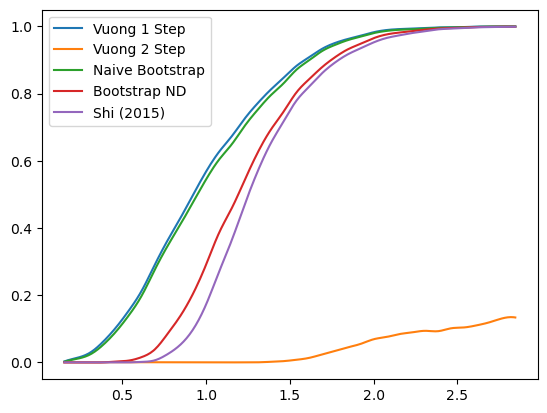

0.001 1.93069772888325


In [7]:
data_tuned_c = .9
calc_c =lambda nobs: (nobs**(-1/2)/100,nobs**(1/7) )

nobs = 100
c1,c2 = calc_c(nobs)
    
mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

Quantiles: 1th: 0.63, 5th: 4.25, 10th: 14.12, 30th: 117.38, 50th: 369.48, 70th: 883.22, 90th: 2238.17, 95th: 3193.06, 99th: 5442.45
bonus term 1.242164099574751 // variance stats 1.240619775544941 //part1 1.93069772888325 //part2 0.6433757501197459
0.5274846499024202 -0.3284858036165887 1.9257054543608487
-1.9568435492470817 -0.3284858036165887 -0.5586227447886534
---
Quantiles: 1th: 0.36, 5th: 2.68, 10th: 7.72, 30th: 60.24, 50th: 178.43, 70th: 408.23, 90th: 1050.04, 95th: 1471.70, 99th: 2521.75
bonus term 0.6339868221694087 // variance stats 2.1476830445129624 //part1 1.93069772888325 //part2 0.3283718692392713
-0.7276393766354916 0.07516621425624209 1.9414610730390165
-1.995613020974309 0.07516621425624209 0.6734874287001991
---
Quantiles: 1th: 0.50, 5th: 3.15, 10th: 10.09, 30th: 86.71, 50th: 258.15, 70th: 606.48, 90th: 1512.09, 95th: 2074.01, 99th: 3758.09
bonus term 1.0014991844086576 // variance stats 1.40292585263428 //part1 1.93069772888325 //part2 0.5187239666915352
0.071596541

0.8650693489182951 -0.5623533950668353 1.9379886916416278
-1.9164500399491384 -0.5623533950668353 -0.8435306972258056
---
Quantiles: 1th: 0.48, 5th: 3.43, 10th: 12.17, 30th: 110.30, 50th: 333.58, 70th: 783.33, 90th: 2082.02, 95th: 2870.61, 99th: 4843.00
bonus term 1.1627865430778526 // variance stats 1.3749809917670888 //part1 1.93069772888325 //part2 0.6022623457222529
0.4276155741821365 -0.30654839832795494 1.9460254766450868
-1.8979575119735685 -0.30654839832795494 -0.3795476095106182
---
Quantiles: 1th: 0.43, 5th: 2.66, 10th: 8.52, 30th: 72.24, 50th: 226.62, 70th: 529.97, 90th: 1367.02, 95th: 1931.53, 99th: 3404.88
bonus term 1.3107908252281122 // variance stats 0.6464977121673561 //part1 1.93069772888325 //part2 0.6789207889037592
0.6345548202671598 -0.49312984797385817 1.9531700012925128
-1.9870268301890646 -0.49312984797385817 -0.6684116491637117
---
Quantiles: 1th: 0.82, 5th: 4.63, 10th: 14.78, 30th: 115.95, 50th: 359.22, 70th: 851.21, 90th: 2167.09, 95th: 3022.24, 99th: 5543.8

-1.0670485625196797 0.7247290875363775 1.938435080083234
-2.023269179950004 0.7247290875363775 0.9822144626529092
---
Quantiles: 1th: 0.51, 5th: 3.98, 10th: 12.60, 30th: 121.99, 50th: 358.52, 70th: 841.62, 90th: 2154.81, 95th: 2996.08, 99th: 4868.25
bonus term 1.1002070679026779 // variance stats 1.6265593496093858 //part1 1.93069772888325 //part2 0.5698494650113134
0.23733677484359586 -0.23578516789791532 1.9537130074198479
-1.9630773609617598 -0.23578516789791532 -0.2467011283855078
---
Quantiles: 1th: 0.45, 5th: 2.42, 10th: 7.75, 30th: 73.35, 50th: 217.21, 70th: 500.13, 90th: 1236.07, 95th: 1753.86, 99th: 2855.85
bonus term 1.653985693445905 // variance stats 0.20679465986463036 //part1 1.93069772888325 //part2 0.8566777019013742
1.3855253831954741 -0.7485332435268731 1.941406502918924
-1.9224460036963358 -0.7485332435268731 -1.366564883972886
---
Quantiles: 1th: 0.50, 5th: 3.36, 10th: 10.10, 30th: 88.16, 50th: 268.40, 70th: 631.96, 90th: 1601.57, 95th: 2195.82, 99th: 3600.20
bonus 

Quantiles: 1th: 0.54, 5th: 4.45, 10th: 14.18, 30th: 130.29, 50th: 401.61, 70th: 966.95, 90th: 2537.28, 95th: 3553.46, 99th: 5735.47
bonus term 1.7300066909183505 // variance stats 0.29433907733814163 //part1 1.93069772888325 //part2 0.8960525850512173
1.5177436368693877 -0.5081669859643752 1.926718389701504
-1.9422697449673132 -0.5081669859643752 -1.5332949921351968
---
Quantiles: 1th: 0.45, 5th: 3.08, 10th: 8.72, 30th: 66.46, 50th: 211.36, 70th: 479.27, 90th: 1189.65, 95th: 1604.11, 99th: 2801.77
bonus term 0.3400271135496153 // variance stats 5.565267052575347 //part1 1.93069772888325 //part2 0.17611618248823083
-1.2839308078614142 0.9439558476038673 1.9968770258243496
-1.963985034960645 0.9439558476038673 1.3168227987251189
---
Quantiles: 1th: 0.74, 5th: 5.35, 10th: 15.15, 30th: 143.73, 50th: 437.01, 70th: 1009.11, 90th: 2562.91, 95th: 3640.15, 99th: 6033.21
bonus term 1.1777819998253458 // variance stats 1.6383809034574313 //part1 1.93069772888325 //part2 0.6100292045749678
0.46777

Quantiles: 1th: 0.60, 5th: 4.55, 10th: 12.96, 30th: 113.58, 50th: 337.63, 70th: 796.43, 90th: 1977.48, 95th: 2854.83, 99th: 5234.63
bonus term 1.5650632549008965 // variance stats 0.46198374675324844 //part1 1.93069772888325 //part2 0.8106205500154376
1.194496728617723 -0.5309238781705237 1.9294137174298085
-1.93562978118407 -0.5309238781705237 -1.2007127923719845
---
Quantiles: 1th: 0.63, 5th: 4.09, 10th: 10.07, 30th: 74.39, 50th: 242.16, 70th: 578.09, 90th: 1393.01, 95th: 2004.34, 99th: 3417.35
bonus term 1.1796939036441827 // variance stats 0.8868052352866655 //part1 1.93069772888325 //part2 0.6110194703168468
0.42755161102061356 -0.509823529773447 2.0172043272413878
-1.9318361962677517 -0.509823529773447 -0.3421834800469776
---
Quantiles: 1th: 0.39, 5th: 2.81, 10th: 8.21, 30th: 71.53, 50th: 233.07, 70th: 545.06, 90th: 1397.38, 95th: 1968.67, 99th: 3280.49
bonus term 0.9376828731230665 // variance stats 1.4798331169129395 //part1 1.93069772888325 //part2 0.48567046984896955
0.057347

-1.0700191880886243 0.8532843730329722 1.9262989307669742
-1.8420979475103902 0.8532843730329722 1.1542201713452078
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.77, 5th: 4.42, 10th: 15.18, 30th: 123.79, 50th: 367.78, 70th: 897.89, 90th: 2226.83, 95th: 3282.18, 99th: 5607.27
bonus term 1.4087329055166888 // variance stats 0.8250884308479314 //part1 1.93069772888325 //part2 0.7296496413923503
0.9143773647868149 -0.8751166563994613 1.9408322965836438
-1.9030884462465627 -0.8751166563994613 -0.876633514449734
---
Quantiles: 1th: 0.52, 5th: 3.25, 10th: 10.10, 30th: 96.03, 50th: 296.37, 70th: 723.84, 90th: 1848.36, 95th: 2638.57, 99th: 4773.45
bonus term 0.5140246417191282 // variance stats 5.094169981181883 //part1 1.93069772888325 //part2 0.266237761628512
-0.9527713449874605 0.42508115078810954 1.816518841238786
-1.980820628425717 0.42508115078810954 0.7884695578005299
---
Quantiles: 1th: 0.47, 5th: 2.83, 10th: 8.98, 30th: 72.50, 50th: 225.14, 70th: 530.95, 90th: 1299.40, 95th: 18

-0.35433109765922083 -0.31440678495524793 1.929405877373681
-1.9358654472519103 -0.31440678495524793 0.34787152778099156
---
Quantiles: 1th: 0.40, 5th: 2.62, 10th: 6.70, 30th: 54.01, 50th: 160.15, 70th: 364.82, 90th: 933.38, 95th: 1338.73, 99th: 2305.89
bonus term 1.2456587941035207 // variance stats 0.5133046918813862 //part1 1.93069772888325 //part2 0.645185818302087
0.5814101011652898 -0.9203592416009323 1.927911508873492
-1.9099074870417516 -0.9203592416009323 -0.5634060793335494
---
Quantiles: 1th: 0.48, 5th: 2.87, 10th: 9.76, 30th: 77.03, 50th: 225.97, 70th: 521.06, 90th: 1297.90, 95th: 1879.91, 99th: 3211.32
bonus term 1.162246802967976 // variance stats 0.8581391500025707 //part1 1.93069772888325 //part2 0.6019827886990058
0.3191902153429747 -0.5032417243604979 1.9530796270446376
-2.005303390592977 -0.5032417243604979 -0.3714139788913145
---
Quantiles: 1th: 0.45, 5th: 3.06, 10th: 9.42, 30th: 92.94, 50th: 286.99, 70th: 661.55, 90th: 1689.82, 95th: 2405.48, 99th: 3913.45
bonus te

-1.2075322150151844 0.4429896671453377 2.1097226891428833
-2.080850739121689 0.4429896671453377 1.2364041650363786
---
Quantiles: 1th: 0.49, 5th: 3.70, 10th: 9.94, 30th: 79.71, 50th: 246.65, 70th: 575.27, 90th: 1459.78, 95th: 2086.89, 99th: 3489.16
bonus term 0.8355778874537492 // variance stats 1.9132022786115301 //part1 1.93069772888325 //part2 0.43278545105922
-0.26155190910002174 -0.389096159827527 1.9047866766886519
-1.9327076840075201 -0.389096159827527 0.2336309017811535
---
Quantiles: 1th: 0.54, 5th: 3.54, 10th: 11.35, 30th: 103.60, 50th: 310.57, 70th: 760.22, 90th: 1925.55, 95th: 2719.31, 99th: 5012.51
bonus term 0.6362984618253994 // variance stats 3.917073392096309 //part1 1.93069772888325 //part2 0.3295691771458424
-0.7238116250838739 0.10122562676757722 1.9263115690415016
-1.9964085487346728 0.10122562676757722 0.653714645390703
---
Quantiles: 1th: 0.35, 5th: 2.42, 10th: 6.85, 30th: 61.51, 50th: 186.81, 70th: 424.75, 90th: 1055.64, 95th: 1483.13, 99th: 2566.46
bonus term 0

-0.7607555381447106 0.21241421252941453 1.8731851190477886
-1.8590685831964229 0.21241421252941453 0.7748720739960766
---
Quantiles: 1th: 0.60, 5th: 3.92, 10th: 11.98, 30th: 105.34, 50th: 309.58, 70th: 760.44, 90th: 1860.98, 95th: 2630.27, 99th: 4736.41
bonus term 0.5833799342910646 // variance stats 4.297947830179933 //part1 1.93069772888325 //part2 0.3021601598032137
-0.7784129202483093 0.19158806623165936 1.9230202568013153
-1.9451727888304386 0.19158806623165936 0.756260388219186
---
Quantiles: 1th: 1.03, 5th: 5.91, 10th: 18.49, 30th: 151.44, 50th: 438.84, 70th: 1021.00, 90th: 2552.25, 95th: 3502.92, 99th: 6254.22
bonus term 0.6112381397791877 // variance stats 5.5094561429148845 //part1 1.93069772888325 //part2 0.3165892467966691
-0.7793953668625002 0.2992552761477183 1.9815392183552747
-2.001871646420876 0.2992552761477183 0.7590629387968991
---
Quantiles: 1th: 0.70, 5th: 4.07, 10th: 13.21, 30th: 129.53, 50th: 379.33, 70th: 870.75, 90th: 2214.31, 95th: 3104.43, 99th: 5282.97
bonu

-0.5188836639671183 0.003495102924778128 1.9927487099826344
-1.9451884004705826 0.003495102924778128 0.5664439734791699
---
Quantiles: 1th: 0.42, 5th: 2.73, 10th: 7.00, 30th: 54.33, 50th: 167.63, 70th: 396.11, 90th: 995.43, 95th: 1421.52, 99th: 2484.75
bonus term 0.32214961190867125 // variance stats 4.970348737007762 //part1 1.93069772888325 //part2 0.16685657578051244
-1.315344146486238 0.6258795535911879 2.010131021930555
-1.9596433703035807 0.6258795535911879 1.3658317981132126
---
Quantiles: 1th: 0.85, 5th: 6.12, 10th: 20.21, 30th: 162.69, 50th: 491.00, 70th: 1152.73, 90th: 2988.05, 95th: 4189.83, 99th: 6597.21
bonus term 1.2521983122006506 // variance stats 1.61906358246141 //part1 1.93069772888325 //part2 0.648572945141933
0.4657493428453902 -0.5993668429764869 1.9114837355661376
-2.038647281555911 -0.5993668429764869 -0.5929128888351634
---
Quantiles: 1th: 0.54, 5th: 3.32, 10th: 11.56, 30th: 102.04, 50th: 290.80, 70th: 712.59, 90th: 1792.59, 95th: 2533.93, 99th: 4297.71
bonus t

Quantiles: 1th: 0.73, 5th: 4.36, 10th: 10.65, 30th: 88.41, 50th: 265.23, 70th: 644.15, 90th: 1675.00, 95th: 2353.91, 99th: 4483.54
bonus term 0.9400443129803606 // variance stats 1.7651737896264146 //part1 1.93069772888325 //part2 0.48689357164370783
-0.15886181884493783 -0.6947623398925601 1.9430868747236476
-2.0389504448056592 -0.6947623398925601 0.06299824876292631
---
Quantiles: 1th: 0.48, 5th: 3.94, 10th: 11.90, 30th: 107.67, 50th: 338.65, 70th: 791.28, 90th: 2094.80, 95th: 2878.81, 99th: 4903.52
bonus term 0.7266908227183869 // variance stats 3.470732211398893 //part1 1.93069772888325 //part2 0.37638767158995823
-0.5578977824766663 -0.11816020479282993 1.9176871655284176
-2.01127942791344 -0.11816020479282993 0.46430552009164355
---
0.5384615384615385 [1. 0. 0.]
Quantiles: 1th: 0.47, 5th: 3.17, 10th: 9.30, 30th: 70.99, 50th: 210.40, 70th: 477.06, 90th: 1164.64, 95th: 1703.76, 99th: 2830.22
bonus term 0.9039748817326347 // variance stats 1.3227798346689748 //part1 1.93069772888325

Quantiles: 1th: 0.66, 5th: 4.36, 10th: 14.43, 30th: 150.13, 50th: 457.73, 70th: 1074.59, 90th: 2627.12, 95th: 3760.01, 99th: 6639.20
bonus term 0.552257096780122 // variance stats 6.5573169788814845 //part1 1.93069772888325 //part2 0.28604016491983825
-0.796576487105117 0.45330152444949845 1.972664805031222
-1.9010906806653611 0.45330152444949845 0.8681506114709779
---
Quantiles: 1th: 0.42, 5th: 3.31, 10th: 10.73, 30th: 92.41, 50th: 287.31, 70th: 658.47, 90th: 1687.23, 95th: 2394.86, 99th: 3958.26
bonus term 0.7076256114648759 // variance stats 2.916244491472611 //part1 1.93069772888325 //part2 0.36651289369578277
-0.6472437948389402 -0.16810505137103673 1.9096441973773273
-2.062495017768692 -0.16810505137103673 0.49439297444757546
---
Quantiles: 1th: 0.35, 5th: 2.83, 10th: 10.28, 30th: 90.18, 50th: 287.30, 70th: 697.12, 90th: 1765.80, 95th: 2465.48, 99th: 4274.69
bonus term 0.4266855249065097 // variance stats 6.224214767423722 //part1 1.93069772888325 //part2 0.22100068722477453
-1.0

Quantiles: 1th: 0.75, 5th: 4.87, 10th: 14.48, 30th: 126.50, 50th: 391.32, 70th: 928.92, 90th: 2385.24, 95th: 3317.56, 99th: 5694.31
bonus term 0.7655239830489726 // variance stats 3.6304743905237125 //part1 1.93069772888325 //part2 0.39650120865463767
-0.4583229545840545 -0.15779059307297363 1.9086925646144879
-1.9893709206819996 -0.15779059307297363 0.37764459851654275
---
Quantiles: 1th: 0.35, 5th: 1.89, 10th: 5.40, 30th: 39.99, 50th: 123.97, 70th: 306.16, 90th: 775.73, 95th: 1095.68, 99th: 1834.67
bonus term 0.33052176612659945 // variance stats 3.755612918024929 //part1 1.93069772888325 //part2 0.17119291185875019
-1.2110930822672308 0.12394687311932631 1.846559183352289
-1.8721366145204295 0.12394687311932631 1.1855156510990903
---
Quantiles: 1th: 0.62, 5th: 4.12, 10th: 12.98, 30th: 106.60, 50th: 331.06, 70th: 809.03, 90th: 1987.33, 95th: 2846.88, 99th: 4971.97
bonus term 0.5241981325463825 // variance stats 5.332295039557179 //part1 1.93069772888325 //part2 0.27150709544242746
-0

Quantiles: 1th: 0.25, 5th: 2.22, 10th: 7.39, 30th: 72.29, 50th: 224.49, 70th: 529.92, 90th: 1336.29, 95th: 1917.74, 99th: 3277.25
bonus term 0.34139229135444066 // variance stats 6.220909727950262 //part1 1.93069772888325 //part2 0.17682327287550498
-1.2592784376715072 0.7882437863123744 1.903391106985512
-1.9420630203803886 0.7882437863123744 1.2206065242766306
---
Quantiles: 1th: 0.45, 5th: 2.29, 10th: 7.82, 30th: 73.40, 50th: 238.93, 70th: 575.50, 90th: 1368.45, 95th: 1932.51, 99th: 3275.62
bonus term 0.4163207417589943 // variance stats 4.97778243748525 //part1 1.93069772888325 //part2 0.2156322740379467
-1.1765291354307394 0.17843967756142348 2.0753470667086957
-2.0091706189487284 0.17843967756142348 1.2427055831907072
---
Quantiles: 1th: 0.65, 5th: 4.17, 10th: 12.13, 30th: 85.86, 50th: 257.42, 70th: 618.00, 90th: 1552.56, 95th: 2160.05, 99th: 3596.37
bonus term 0.30015434599635704 // variance stats 8.434067376475362 //part1 1.93069772888325 //part2 0.15546418349493354
-1.32536315

Quantiles: 1th: 0.59, 5th: 3.57, 10th: 9.10, 30th: 75.81, 50th: 227.68, 70th: 542.34, 90th: 1383.07, 95th: 1983.46, 99th: 3373.36
bonus term 0.6618859169118673 // variance stats 2.651301477960483 //part1 1.93069772888325 //part2 0.34282213471847495
-0.5782046004634596 -0.7284396547776201 1.8639028818845198
-1.9019764342871939 -0.7284396547776201 0.5401310480607855
---
Quantiles: 1th: 0.50, 5th: 4.09, 10th: 12.45, 30th: 111.09, 50th: 313.07, 70th: 781.82, 90th: 1958.24, 95th: 2779.63, 99th: 4716.18
bonus term 0.4160577075141572 // variance stats 7.128886912405971 //part1 1.93069772888325 //part2 0.21549603611685625
-1.128682991752011 0.44941449742025386 2.015002591751713
-1.9607984067803252 0.44941449742025386 1.1828871767233986
---
Quantiles: 1th: 0.49, 5th: 2.65, 10th: 7.83, 30th: 62.77, 50th: 198.38, 70th: 490.56, 90th: 1229.45, 95th: 1711.03, 99th: 2923.61
bonus term 0.4490355458554196 // variance stats 4.056764226339018 //part1 1.93069772888325 //part2 0.23257682398329116
-1.145392

-1.5138959677035695 1.1364034219209314 1.9388133931815774
-2.0705718714402925 1.1364034219209314 1.3821374894448544
---
Quantiles: 1th: 0.73, 5th: 5.60, 10th: 15.41, 30th: 128.72, 50th: 410.90, 70th: 980.79, 90th: 2523.69, 95th: 3553.17, 99th: 5850.08
bonus term 0.979404528078836 // variance stats 2.451253418582198 //part1 1.93069772888325 //part2 0.5072800953908726
-0.043543127130076846 -0.6958468287621634 1.9148118093490896
-2.0023521832877487 -0.6958468287621634 -0.043997246808582455
---
Quantiles: 1th: 0.76, 5th: 4.42, 10th: 13.28, 30th: 117.26, 50th: 371.05, 70th: 863.72, 90th: 2218.62, 95th: 3191.63, 99th: 5277.09
bonus term 0.7536054716220629 // variance stats 3.4653606947109203 //part1 1.93069772888325 //part2 0.390328045839657
-0.4689203365746794 -0.5277385129796918 1.9202373507546233
-1.9761312798188053 -0.5277385129796918 0.41302640751049763
---
Quantiles: 1th: 0.39, 5th: 2.10, 10th: 5.92, 30th: 48.13, 50th: 145.97, 70th: 339.28, 90th: 855.84, 95th: 1214.94, 99th: 1989.91
bo

0.7750421848801575 -1.8062351715816518 1.9401910616415123
-1.9231387912741176 -1.8062351715816518 -0.7579899145127627
---
Quantiles: 1th: 0.46, 5th: 3.13, 10th: 8.82, 30th: 77.30, 50th: 244.96, 70th: 569.05, 90th: 1424.64, 95th: 1987.76, 99th: 3240.75
bonus term 0.6955439249502506 // variance stats 2.5298961186488684 //part1 1.93069772888325 //part2 0.3602552147572917
-0.5558830234713393 -0.6744797468119208 1.9735752292152275
-1.9469708733718405 -0.6744797468119208 0.5824873793147262
---
Quantiles: 1th: 0.48, 5th: 2.71, 10th: 8.27, 30th: 60.13, 50th: 179.15, 70th: 429.64, 90th: 1095.46, 95th: 1520.42, 99th: 2575.37
bonus term 0.2847845865192561 // variance stats 6.3312307743084855 //part1 1.93069772888325 //part2 0.14750345549118168
-1.3503296604712116 0.6664022888928905 2.0250409369472497
-1.9198988335097236 0.6664022888928905 1.4554717639087378
---
Quantiles: 1th: 0.47, 5th: 3.41, 10th: 8.31, 30th: 62.70, 50th: 179.94, 70th: 417.18, 90th: 1065.76, 95th: 1543.50, 99th: 2639.31
bonus t

-1.2422108398403349 0.2969253116113775 2.0370272029095897
-1.9974204007146816 0.2969253116113775 1.2818176420352427
---
Quantiles: 1th: 0.56, 5th: 4.24, 10th: 14.15, 30th: 123.88, 50th: 391.98, 70th: 947.05, 90th: 2321.14, 95th: 3333.16, 99th: 5847.52
bonus term 0.9035908756603866 // variance stats 2.6384252135862543 //part1 1.93069772888325 //part2 0.46801260608673306
-0.08274140788641324 -1.163830319368502 1.9190597094175892
-1.8899231592071863 -1.163830319368502 0.11187795809681568
---
Quantiles: 1th: 0.40, 5th: 2.59, 10th: 7.96, 30th: 60.90, 50th: 172.94, 70th: 398.72, 90th: 995.07, 95th: 1410.63, 99th: 2623.80
bonus term 0.9268274883225361 // variance stats 1.0777814383889068 //part1 1.93069772888325 //part2 0.4800479507782037
-0.0876297216632721 -3.3578570171931412 1.9389593070030684
-1.9412846983083443 -3.3578570171931412 0.08530433035799632
---
Quantiles: 1th: 0.64, 5th: 3.76, 10th: 9.75, 30th: 71.02, 50th: 209.56, 70th: 490.53, 90th: 1236.18, 95th: 1785.50, 99th: 3032.91
bonus

Quantiles: 1th: 0.43, 5th: 2.44, 10th: 6.82, 30th: 55.19, 50th: 173.24, 70th: 413.64, 90th: 1032.30, 95th: 1478.77, 99th: 2648.36
bonus term 0.22444111731981284 // variance stats 7.847789460772223 //part1 1.93069772888325 //part2 0.11624870841363323
-1.4971967619063509 0.8807289086142959 2.210709864417217
-1.9460789965459766 0.8807289086142959 1.7618276297775914
---
Quantiles: 1th: 0.48, 5th: 4.29, 10th: 13.57, 30th: 104.28, 50th: 303.52, 70th: 693.69, 90th: 1715.89, 95th: 2510.89, 99th: 4361.11
bonus term 0.4901184238397832 // variance stats 5.043414908943242 //part1 1.93069772888325 //part2 0.2538555966102868
-1.0444631784907734 -0.36912283643360794 1.9623606130413
-2.0247000261703403 -0.36912283643360794 0.9821237653617338
---
Quantiles: 1th: 0.44, 5th: 3.03, 10th: 8.65, 30th: 73.36, 50th: 216.27, 70th: 537.05, 90th: 1278.31, 95th: 1833.83, 99th: 3228.61
bonus term 0.3027409063074145 // variance stats 6.873978550947251 //part1 1.93069772888325 //part2 0.1568038858586762
-1.372903603

Quantiles: 1th: 0.55, 5th: 3.39, 10th: 12.08, 30th: 96.49, 50th: 296.77, 70th: 688.24, 90th: 1750.59, 95th: 2548.62, 99th: 4438.60
bonus term 0.4404480951122845 // variance stats 5.923111305906196 //part1 1.93069772888325 //part2 0.22812897561496978
-1.0788715200042194 -0.013513090212408258 1.9837697251951105
-1.9597677102287883 -0.013513090212408258 1.1028735349705416
---
Quantiles: 1th: 0.57, 5th: 3.34, 10th: 9.23, 30th: 76.81, 50th: 223.20, 70th: 523.51, 90th: 1295.96, 95th: 1952.86, 99th: 3405.24
bonus term 0.40258511047792694 // variance stats 4.919146078322915 //part1 1.93069772888325 //part2 0.20851793859559226
-1.1564464863186021 -0.1544630578439154 1.8536180533676934
-1.9616167072744561 -0.1544630578439154 1.0484478324118394
---
Quantiles: 1th: 0.51, 5th: 3.61, 10th: 8.48, 30th: 62.26, 50th: 180.48, 70th: 408.67, 90th: 1024.65, 95th: 1485.62, 99th: 2538.78
bonus term 0.3105362010908839 // variance stats 5.345891985798164 //part1 1.93069772888325 //part2 0.1608414390534885
-1.4

-0.6363024981789178 -0.6671880684911591 1.9755811738322535
-1.9760462239973506 -0.6671880684911591 0.6358374480138207
---
Quantiles: 1th: 0.99, 5th: 5.31, 10th: 15.65, 30th: 128.41, 50th: 415.71, 70th: 993.93, 90th: 2484.61, 95th: 3612.98, 99th: 6077.22
bonus term 0.4002255779816865 // variance stats 9.50122695389588 //part1 1.93069772888325 //part2 0.2072958247136822
-1.1384536533770508 0.7937093066050639 2.0707960131003675
-1.938904809340424 0.7937093066050639 1.2703448571369949
---
Quantiles: 1th: 0.49, 5th: 3.39, 10th: 10.65, 30th: 86.83, 50th: 258.48, 70th: 594.78, 90th: 1493.51, 95th: 2099.83, 99th: 3605.68
bonus term 0.293570667208347 // variance stats 8.32872146742344 //part1 1.93069772888325 //part2 0.1520541837370646
-1.2755508168862697 0.7014008087788268 2.032937643136715
-1.862692151302964 0.7014008087788268 1.4457963087200212
---
Quantiles: 1th: 0.32, 5th: 1.93, 10th: 5.32, 30th: 46.41, 50th: 144.45, 70th: 328.69, 90th: 815.40, 95th: 1159.50, 99th: 1870.35
bonus term 0.382

0.20888169289089037 -3.267654196517369 1.9441216559108314
-2.081728249950382 -3.267654196517369 -0.34648828693044104
---
Quantiles: 1th: 0.59, 5th: 3.23, 10th: 10.99, 30th: 92.09, 50th: 260.98, 70th: 632.45, 90th: 1603.75, 95th: 2236.16, 99th: 3600.88
bonus term 0.3815660865316801 // variance stats 6.511114712086144 //part1 1.93069772888325 //part2 0.19763118836441826
-1.145611846329211 0.1332064401613626 2.0059913850479476
-1.9087440193925713 0.1332064401613626 1.2428592119845874
---
Quantiles: 1th: 0.93, 5th: 4.96, 10th: 13.48, 30th: 102.94, 50th: 299.15, 70th: 694.01, 90th: 1732.30, 95th: 2514.41, 99th: 4447.40
bonus term 0.4958812274141791 // variance stats 5.01235655269758 //part1 1.93069772888325 //part2 0.2568404261297835
-1.0143748764528557 -0.88013873443741 1.9478115356487609
-2.006137331281214 -0.88013873443741 0.9560490808204029
---
Quantiles: 1th: 0.75, 5th: 4.68, 10th: 13.53, 30th: 118.74, 50th: 356.90, 70th: 883.31, 90th: 2213.75, 95th: 3126.88, 99th: 5374.23
bonus term 0

-0.682570373774227 -1.0965907490293323 1.876380045674178
-1.9639831807077195 -1.0965907490293323 0.5949672387406855
---
Quantiles: 1th: 0.44, 5th: 2.86, 10th: 9.15, 30th: 82.49, 50th: 256.37, 70th: 588.04, 90th: 1391.45, 95th: 2013.25, 99th: 3438.72
bonus term 0.40450989335783166 // variance stats 5.2498513550001755 //part1 1.93069772888325 //part2 0.20951487501454064
-1.1134162360395228 -0.7190333107626009 2.0151799915641977
-1.9224360227551862 -0.7190333107626009 1.2061602048485343
---
Quantiles: 1th: 0.72, 5th: 4.17, 10th: 10.95, 30th: 84.57, 50th: 267.67, 70th: 618.24, 90th: 1592.56, 95th: 2187.73, 99th: 3829.25
bonus term 0.34504055825905616 // variance stats 7.31871970700431 //part1 1.93069772888325 //part2 0.1787128834810583
-1.2583017866081352 0.24700322101198377 2.1016882524852454
-1.9483829031262474 0.24700322101198377 1.4116071359671327
---
Quantiles: 1th: 0.53, 5th: 3.07, 10th: 8.32, 30th: 73.21, 50th: 240.50, 70th: 561.76, 90th: 1426.01, 95th: 1982.61, 99th: 3403.94
bonus 

-1.2622640204174802 -0.13295568650958456 2.057011054257948
-1.9795716092537674 -0.13295568650958456 1.3397034654216609
---
Quantiles: 1th: 0.44, 5th: 3.31, 10th: 10.35, 30th: 101.43, 50th: 296.84, 70th: 686.14, 90th: 1715.26, 95th: 2421.44, 99th: 4184.52
bonus term 0.3635988016014016 // variance stats 7.392716678012838 //part1 1.93069772888325 //part2 0.18832507862932724
-1.2033682960569454 0.19949980793724856 2.0057853709786455
-1.9305658992597485 0.19949980793724856 1.2785877677758424
---
Quantiles: 1th: 0.59, 5th: 3.44, 10th: 8.61, 30th: 64.42, 50th: 207.69, 70th: 497.38, 90th: 1222.59, 95th: 1746.46, 99th: 3023.80
bonus term 0.3895255716893867 // variance stats 4.837216701322977 //part1 1.93069772888325 //part2 0.20175378354782403
-1.170512060690804 -0.5361833290323149 1.9862004868450243
-1.9495632040695772 -0.5361833290323149 1.207149343466251
---
Quantiles: 1th: 0.36, 5th: 2.09, 10th: 5.45, 30th: 47.58, 50th: 144.81, 70th: 342.83, 90th: 839.84, 95th: 1218.81, 99th: 2039.25
bonus 

1.3846153846153846 [0.96142857 0.00142857 0.03714286]
Quantiles: 1th: 0.42, 5th: 3.78, 10th: 13.76, 30th: 140.67, 50th: 428.78, 70th: 1026.79, 90th: 2787.63, 95th: 3946.45, 99th: 6568.52
bonus term 0.42854330855367734 // variance stats 9.771354743225091 //part1 1.93069772888325 //part2 0.221962921560774
-1.0869100443272126 0.09191474623909272 2.0386806601807352
-1.9439966614345674 0.09191474623909272 1.1815940430733807
---
Quantiles: 1th: 0.51, 5th: 3.88, 10th: 10.62, 30th: 97.48, 50th: 303.47, 70th: 701.59, 90th: 1782.96, 95th: 2465.14, 99th: 4227.75
bonus term 0.330794932298855 // variance stats 8.623364138678378 //part1 1.93069772888325 //part2 0.1713343975859922
-1.271822521166176 0.09275150737341792 1.9198105128992895
-1.933412385763886 0.09275150737341792 1.2582206483015794
---
Quantiles: 1th: 0.58, 5th: 4.63, 10th: 13.67, 30th: 108.97, 50th: 321.76, 70th: 772.91, 90th: 2020.70, 95th: 2867.48, 99th: 4734.21
bonus term 0.764452975142499 // variance stats 3.082771789117428 //part1 

Quantiles: 1th: 0.56, 5th: 3.77, 10th: 11.71, 30th: 102.51, 50th: 313.08, 70th: 739.92, 90th: 1907.57, 95th: 2727.52, 99th: 4749.27
bonus term 0.4430836135409624 // variance stats 6.404495869301595 //part1 1.93069772888325 //part2 0.2294940357117682
-0.9576428984466805 -0.39668219396826315 2.007406723568099
-1.8438101255286052 -0.39668219396826315 1.1212394964861738
---
Quantiles: 1th: 0.56, 5th: 3.42, 10th: 10.33, 30th: 99.78, 50th: 297.49, 70th: 686.88, 90th: 1687.09, 95th: 2386.61, 99th: 4027.51
bonus term 0.2683306683428229 // variance stats 10.451889960240841 //part1 1.93069772888325 //part2 0.1389811902342839
-1.3747603917451 0.7556358546076716 1.865338918472501
-1.9114217284307455 0.7556358546076716 1.3286775817868555
---
Quantiles: 1th: 0.46, 5th: 3.45, 10th: 12.01, 30th: 94.73, 50th: 286.52, 70th: 679.53, 90th: 1781.53, 95th: 2535.93, 99th: 4491.84
bonus term 0.4791215629902576 // variance stats 5.397446900646453 //part1 1.93069772888325 //part2 0.24815980037817212
-1.16606284

Quantiles: 1th: 0.61, 5th: 4.35, 10th: 12.75, 30th: 100.06, 50th: 290.12, 70th: 697.77, 90th: 1740.01, 95th: 2478.95, 99th: 4105.72
bonus term 0.3802630893790366 // variance stats 7.09449903981177 //part1 1.93069772888325 //part2 0.19695630428849548
-1.2130513130763725 -0.6389172165877306 1.949171848719812
-1.9735774918344458 -0.6389172165877306 1.1886456699617387
---
Quantiles: 1th: 0.50, 5th: 3.83, 10th: 9.86, 30th: 71.26, 50th: 215.50, 70th: 506.10, 90th: 1277.12, 95th: 1838.39, 99th: 3129.98
bonus term 0.2552736242410876 // variance stats 8.382052377738438 //part1 1.93069772888325 //part2 0.1322183273032296
-1.3642856188050227 -0.1685468309277004 2.0435850122516457
-1.874832867287198 -0.1685468309277004 1.5330377637694708
---
Quantiles: 1th: 0.80, 5th: 4.59, 10th: 13.81, 30th: 105.09, 50th: 299.91, 70th: 730.48, 90th: 1844.17, 95th: 2552.71, 99th: 4455.45
bonus term 0.45063553587056887 // variance stats 6.056957099570935 //part1 1.93069772888325 //part2 0.23340553476033996
-1.10720

-1.4306671616332947 0.7797440679618608 1.9766178612590026
-1.9408359852195562 0.7797440679618608 1.4664490376727415
---
Quantiles: 1th: 0.62, 5th: 4.56, 10th: 13.55, 30th: 119.51, 50th: 347.36, 70th: 839.04, 90th: 2114.44, 95th: 2955.00, 99th: 4648.71
bonus term 0.387861693741331 // variance stats 8.410834778213438 //part1 1.93069772888325 //part2 0.20089198217769547
-1.1640226143226717 -0.27292863783436544 2.07918855377229
-1.9397460018053339 -0.27292863783436544 1.3034651662896277
---
Quantiles: 1th: 0.43, 5th: 3.32, 10th: 12.10, 30th: 102.71, 50th: 331.66, 70th: 778.03, 90th: 1941.06, 95th: 2835.87, 99th: 4830.44
bonus term 0.33705372003768613 // variance stats 9.177622223318373 //part1 1.93069772888325 //part2 0.1745761208475881
-1.1715422625491048 0.31408519440388477 1.985524768366387
-1.8456497026244771 0.31408519440388477 1.3114173282910147
---
Quantiles: 1th: 0.82, 5th: 4.46, 10th: 12.96, 30th: 104.01, 50th: 328.59, 70th: 757.47, 90th: 1929.39, 95th: 2765.33, 99th: 4845.90
bonu

-1.3816259587787514 -0.4505080456974194 1.8611270888104743
-1.9313229115873132 -0.4505080456974194 1.3114301360019125
---
Quantiles: 1th: 0.39, 5th: 2.68, 10th: 7.82, 30th: 65.21, 50th: 201.39, 70th: 464.63, 90th: 1224.52, 95th: 1692.40, 99th: 2887.16
bonus term 0.2624907761274861 // variance stats 7.7822133226185155 //part1 1.93069772888325 //part2 0.13595643284840628
-1.3629802058499416 -0.021282303275872074 1.7804746183105982
-1.887961758104914 -0.021282303275872074 1.2554930660556258
---
Quantiles: 1th: 0.49, 5th: 2.91, 10th: 8.28, 30th: 65.12, 50th: 196.14, 70th: 453.23, 90th: 1168.50, 95th: 1593.23, 99th: 2834.01
bonus term 0.3010075998010416 // variance stats 6.326395774422222 //part1 1.93069772888325 //part2 0.15590612414256566
-1.4203643882328683 -1.6083920956551674 1.9183921624871008
-2.0223795878349518 -1.6083920956551674 1.3163769628850177
---
Quantiles: 1th: 0.46, 5th: 2.99, 10th: 10.66, 30th: 89.70, 50th: 270.48, 70th: 648.99, 90th: 1609.42, 95th: 2344.39, 99th: 3918.65
b

Quantiles: 1th: 0.60, 5th: 4.41, 10th: 13.75, 30th: 124.25, 50th: 364.67, 70th: 825.26, 90th: 2117.68, 95th: 2962.52, 99th: 5119.66
bonus term 0.26155004109822966 // variance stats 13.514484930324615 //part1 1.93069772888325 //part2 0.13546918152201634
-1.5382173241983133 1.1135026233301055 1.848452591038769
-2.0613174063947723 1.1135026233301055 1.3253525088423097
---
1.6923076923076925 [0.96428571 0.         0.03571429]
Quantiles: 1th: 0.59, 5th: 3.76, 10th: 11.96, 30th: 110.76, 50th: 351.22, 70th: 854.71, 90th: 2111.01, 95th: 2982.14, 99th: 5045.80
bonus term 0.3806050048852745 // variance stats 8.59752852228092 //part1 1.93069772888325 //part2 0.19713339855919504
-1.2961398521467198 -0.09512746318699329 1.8834939578468093
-2.057349861917269 -0.09512746318699329 1.1222839480762603
---
Quantiles: 1th: 0.57, 5th: 3.14, 10th: 10.31, 30th: 91.11, 50th: 275.76, 70th: 671.13, 90th: 1663.87, 95th: 2396.23, 99th: 4011.02
bonus term 0.48851044631279783 // variance stats 4.912096531160288 //p

Quantiles: 1th: 0.67, 5th: 4.88, 10th: 16.53, 30th: 141.23, 50th: 454.65, 70th: 1114.26, 90th: 2758.86, 95th: 3859.31, 99th: 6965.17
bonus term 0.37293215088982 // variance stats 11.52395676566153 //part1 1.93069772888325 //part2 0.19315926326050564
-1.26503320030754 0.24673074764926103 2.0417574791591857
-2.0108975020871798 0.24673074764926103 1.2958931773795457
---
Quantiles: 1th: 0.51, 5th: 4.27, 10th: 15.31, 30th: 146.01, 50th: 434.41, 70th: 1020.56, 90th: 2693.73, 95th: 3904.86, 99th: 6294.13
bonus term 0.46515619456294227 // variance stats 8.486969469841242 //part1 1.93069772888325 //part2 0.24092647316263063
-1.0791648655011352 -0.661510799042047 1.929498535433289
-2.0094772546270194 -0.661510799042047 0.9991861463074043
---
Quantiles: 1th: 0.70, 5th: 5.01, 10th: 17.47, 30th: 134.05, 50th: 383.61, 70th: 904.28, 90th: 2373.34, 95th: 3462.66, 99th: 5808.89
bonus term 0.37348247018141 // variance stats 9.895514739731404 //part1 1.93069772888325 //part2 0.19344429974413394
-1.246519

Quantiles: 1th: 0.57, 5th: 4.27, 10th: 13.78, 30th: 133.30, 50th: 397.29, 70th: 922.43, 90th: 2260.97, 95th: 3270.73, 99th: 5551.28
bonus term 0.6600384495119821 // variance stats 4.352655469955992 //part1 1.93069772888325 //part2 0.341865243656634
-0.6154254890231741 -3.023564770003891 1.9683168045044384
-1.9355023880471383 -3.023564770003891 0.6482399054804739
---
Quantiles: 1th: 0.54, 5th: 4.41, 10th: 15.89, 30th: 141.15, 50th: 418.44, 70th: 979.68, 90th: 2458.21, 95th: 3418.24, 99th: 5861.16
bonus term 0.3567159740595382 // variance stats 10.846663440825008 //part1 1.93069772888325 //part2 0.18476013553186757
-1.0743089404460806 0.045237867963628546 1.9955585224138355
-1.7877408885651571 0.045237867963628546 1.282126574294759
---
Quantiles: 1th: 0.73, 5th: 3.60, 10th: 10.65, 30th: 87.23, 50th: 245.82, 70th: 619.30, 90th: 1607.04, 95th: 2299.52, 99th: 4120.17
bonus term 0.3870837836652264 // variance stats 6.408578109533681 //part1 1.93069772888325 //part2 0.2004890656235052
-1.1051

Quantiles: 1th: 0.48, 5th: 4.97, 10th: 16.23, 30th: 148.45, 50th: 473.59, 70th: 1155.35, 90th: 2868.38, 95th: 4281.08, 99th: 7559.34
bonus term 0.45146871285134643 // variance stats 9.398191379284683 //part1 1.93069772888325 //part2 0.23383707666786555
-1.0678753902748526 -0.5876441767057993 2.0062717781823003
-1.9708128159775453 -0.5876441767057993 1.1033343524796075
---
Quantiles: 1th: 0.40, 5th: 4.19, 10th: 12.62, 30th: 95.39, 50th: 281.71, 70th: 659.67, 90th: 1675.25, 95th: 2369.90, 99th: 3949.49
bonus term 0.2474368334283051 // variance stats 11.396387674777705 //part1 1.93069772888325 //part2 0.12815928134510574
-1.503060742006836 0.44361088718094277 1.9538789724186867
-1.997934408863446 0.44361088718094277 1.4590053055620766
---
Quantiles: 1th: 0.58, 5th: 4.06, 10th: 11.64, 30th: 91.25, 50th: 268.35, 70th: 623.52, 90th: 1648.56, 95th: 2401.29, 99th: 4065.57
bonus term 0.32090410369746714 // variance stats 8.269865115545855 //part1 1.93069772888325 //part2 0.1662114679562418
-1.4

Quantiles: 1th: 0.59, 5th: 4.04, 10th: 11.27, 30th: 96.06, 50th: 288.52, 70th: 685.81, 90th: 1734.53, 95th: 2467.51, 99th: 4164.04
bonus term 0.30136475643957594 // variance stats 9.377787191860945 //part1 1.93069772888325 //part2 0.15609111251914648
-1.364093439679114 -0.42558042194650175 1.856656251234155
-1.9668229525582657 -0.42558042194650175 1.2539267383550032
---
Quantiles: 1th: 0.53, 5th: 4.20, 10th: 14.59, 30th: 132.68, 50th: 397.07, 70th: 974.23, 90th: 2444.03, 95th: 3465.19, 99th: 6030.56
bonus term 0.3892881436516397 // variance stats 9.677277046639315 //part1 1.93069772888325 //part2 0.201630808296859
-1.2317600552234602 -0.4219013769208123 2.0291322156510967
-2.0103363425267395 -0.4219013769208123 1.2505559283478176
---
Quantiles: 1th: 0.26, 5th: 2.07, 10th: 5.19, 30th: 39.86, 50th: 116.47, 70th: 272.18, 90th: 717.39, 95th: 1001.15, 99th: 1837.82
bonus term 0.11440438308305745 // variance stats 11.389367702969345 //part1 1.93069772888325 //part2 0.05925546053717636
-1.630

-1.3233125739690095 -0.7333030349424104 1.959536702976169
-2.001833863629272 -0.7333030349424104 1.2810154133159066
---
Quantiles: 1th: 0.68, 5th: 3.60, 10th: 10.95, 30th: 99.52, 50th: 300.75, 70th: 667.13, 90th: 1661.36, 95th: 2340.71, 99th: 4067.76
bonus term 0.43128276896709467 // variance stats 5.775962144914422 //part1 1.93069772888325 //part2 0.22338181814537914
-1.2829907685169768 -2.316260142750911 2.0245878305912055
-2.1455563064511662 -2.316260142750911 1.162022292657016
---
Quantiles: 1th: 0.45, 5th: 3.44, 10th: 11.04, 30th: 99.43, 50th: 320.48, 70th: 768.41, 90th: 1891.68, 95th: 2659.82, 99th: 4378.07
bonus term 0.23208430117238024 // variance stats 13.845116438938067 //part1 1.93069772888325 //part2 0.1202074761369414
-1.6272066427835254 1.0524474472943472 2.0001444108350452
-2.0913752451282863 1.0524474472943472 1.5359758084902844
---
2.0 [0.96714286 0.         0.03285714]
Quantiles: 1th: 0.55, 5th: 3.71, 10th: 10.50, 30th: 95.27, 50th: 281.93, 70th: 668.17, 90th: 1708.87

-1.5898212399344869 0.37503510912046784 2.041365778226913
-2.014870022624207 0.37503510912046784 1.616316995537193
---
Quantiles: 1th: 0.70, 5th: 4.58, 10th: 14.55, 30th: 128.50, 50th: 389.04, 70th: 903.15, 90th: 2233.52, 95th: 3250.10, 99th: 5694.56
bonus term 0.30442478690151004 // variance stats 11.931718580808687 //part1 1.93069772888325 //part2 0.15767604754867284
-1.3297448872942241 -0.028994064327636935 2.01951349607656
-1.938594461097244 -0.028994064327636935 1.4106639222735398
---
Quantiles: 1th: 0.58, 5th: 3.18, 10th: 8.50, 30th: 63.05, 50th: 191.16, 70th: 444.77, 90th: 1148.35, 95th: 1658.93, 99th: 2813.43
bonus term 0.21159922555748745 // variance stats 9.32952005397712 //part1 1.93069772888325 //part2 0.109597283091994
-1.6555743512845649 -0.3969734080491279 1.9406284144852366
-2.0787728023995395 -0.3969734080491279 1.5174299633702617
---
Quantiles: 1th: 0.50, 5th: 3.33, 10th: 9.26, 30th: 69.29, 50th: 208.99, 70th: 479.57, 90th: 1187.99, 95th: 1720.19, 99th: 2991.39
bonus 

-1.4152919140468379 -0.8824277167200633 1.9823067553864193
-2.063000728856176 -0.8824277167200633 1.334597940577081
---
Quantiles: 1th: 0.48, 5th: 2.97, 10th: 8.97, 30th: 82.14, 50th: 274.28, 70th: 659.68, 90th: 1596.72, 95th: 2224.71, 99th: 3707.31
bonus term 0.22012530832869084 // variance stats 12.407929409126737 //part1 1.93069772888325 //part2 0.11401334607464177
-1.4734916390991128 0.4515985691847627 1.9000587932941289
-1.9137422557564947 0.4515985691847627 1.459808176636747
---
Quantiles: 1th: 0.37, 5th: 2.82, 10th: 8.45, 30th: 74.70, 50th: 234.00, 70th: 529.34, 90th: 1259.64, 95th: 1754.66, 99th: 3258.13
bonus term 0.22031794912222455 // variance stats 9.778865626595122 //part1 1.93069772888325 //part2 0.11411312388587122
-1.67770027608764 0.042260411252260044 1.8636822194883793
-2.118336174332089 0.042260411252260044 1.4230463212439304
---
Quantiles: 1th: 0.42, 5th: 2.47, 10th: 6.49, 30th: 46.54, 50th: 146.30, 70th: 343.52, 90th: 842.98, 95th: 1230.40, 99th: 2294.21
bonus term

-1.564488242155721 0.4333531616521154 2.0079558273895297
-1.9950759872698949 0.4333531616521154 1.5773680822753555
---
Quantiles: 1th: 0.36, 5th: 3.17, 10th: 10.68, 30th: 101.84, 50th: 312.59, 70th: 739.07, 90th: 1897.38, 95th: 2676.46, 99th: 4480.56
bonus term 0.29194644530327474 // variance stats 10.65034447597704 //part1 1.93069772888325 //part2 0.15121292211398712
-1.4433918804020085 -0.6164447341711207 1.9712065716847187
-2.0272847710085578 -0.6164447341711207 1.3873136810781692
---
Quantiles: 1th: 0.53, 5th: 4.17, 10th: 11.14, 30th: 79.03, 50th: 253.84, 70th: 634.57, 90th: 1563.14, 95th: 2271.95, 99th: 3922.10
bonus term 0.2724266707515275 // variance stats 9.514919978375358 //part1 1.93069772888325 //part2 0.14110270431047947
-1.497371067032177 -0.4458806258396819 2.0124503904221775
-2.0422244085352323 -0.4458806258396819 1.4675970489191223
---
Quantiles: 1th: 0.59, 5th: 3.40, 10th: 9.88, 30th: 77.76, 50th: 223.45, 70th: 543.51, 90th: 1361.13, 95th: 1987.65, 99th: 3310.09
bonus 

-1.5085358329684773 1.1300969233849083 1.948031037109421
-1.8887356512529607 1.1300969233849083 1.5678312188249375
---
Quantiles: 1th: 0.36, 5th: 2.84, 10th: 9.82, 30th: 84.25, 50th: 242.93, 70th: 581.31, 90th: 1585.88, 95th: 2280.60, 99th: 3720.95
bonus term 0.2296316270347787 // variance stats 11.74785424266269 //part1 1.93069772888325 //part2 0.11893711977773018
-1.522986386741922 -0.05872037883861008 2.0466947694935738
-1.9822496408114794 -0.05872037883861008 1.5874315154240166
---
Quantiles: 1th: 0.60, 5th: 4.20, 10th: 12.33, 30th: 103.74, 50th: 321.75, 70th: 746.81, 90th: 1942.44, 95th: 2698.22, 99th: 4550.31
bonus term 0.26986703636721615 // variance stats 11.95425730076875 //part1 1.93069772888325 //part2 0.13977694816231648
-1.4481531125506641 -0.38261565389270974 2.1042187257449116
-1.9878871852850966 -0.38261565389270974 1.564484653010479
---
Quantiles: 1th: 0.45, 5th: 3.09, 10th: 8.34, 30th: 72.25, 50th: 211.45, 70th: 512.84, 90th: 1295.00, 95th: 1841.63, 99th: 3341.38
bonu

Quantiles: 1th: 0.73, 5th: 4.65, 10th: 13.64, 30th: 123.95, 50th: 365.25, 70th: 848.85, 90th: 2161.19, 95th: 3090.10, 99th: 5474.41
bonus term 0.38564728711044105 // variance stats 8.658548160097332 //part1 1.93069772888325 //part2 0.19974503587027387
-1.13012178576615 -1.2955841441018654 1.9513938517044747
-1.9014163599870322 -1.2955841441018654 1.1800992774835926
---
Quantiles: 1th: 0.53, 5th: 3.07, 10th: 8.79, 30th: 71.66, 50th: 228.13, 70th: 539.18, 90th: 1373.80, 95th: 1978.70, 99th: 3340.41
bonus term 0.20458104537245017 // variance stats 11.591205963982118 //part1 1.93069772888325 //part2 0.10596223443572572
-1.5853510337322958 0.14651101086756863 2.038899933611783
-1.994513124477196 0.14651101086756863 1.6297378428668825
---
Quantiles: 1th: 0.40, 5th: 2.98, 10th: 9.13, 30th: 78.35, 50th: 240.32, 70th: 601.17, 90th: 1511.09, 95th: 2191.97, 99th: 3765.24
bonus term 0.19230745283721581 // variance stats 13.659670925359226 //part1 1.93069772888325 //part2 0.09960515825978097
-1.711

Quantiles: 1th: 0.56, 5th: 3.59, 10th: 10.68, 30th: 108.19, 50th: 338.05, 70th: 795.21, 90th: 1941.40, 95th: 2711.20, 99th: 4712.17
bonus term 0.24735805604322714 // variance stats 13.211728705229877 //part1 1.93069772888325 //part2 0.128118478797975
-1.4020505140804944 0.05385360149584716 2.085290805769803
-1.8967666261669487 0.05385360149584716 1.5905746936833487
---
Quantiles: 1th: 0.74, 5th: 5.30, 10th: 16.56, 30th: 129.69, 50th: 403.16, 70th: 903.41, 90th: 2289.05, 95th: 3222.76, 99th: 5728.26
bonus term 0.24526719116303958 // variance stats 15.729928656957396 //part1 1.93069772888325 //part2 0.12703552062751247
-1.495332378262208 0.7710893568754014 2.0187258464930924
-1.9858667605882874 0.7710893568754014 1.5281914641670131
---
Quantiles: 1th: 0.47, 5th: 4.24, 10th: 15.05, 30th: 133.37, 50th: 391.77, 70th: 893.53, 90th: 2153.28, 95th: 3033.91, 99th: 5140.55
bonus term 0.27876266920603615 // variance stats 12.760212508901338 //part1 1.93069772888325 //part2 0.14438441866675703
-1.

Quantiles: 1th: 0.50, 5th: 2.83, 10th: 9.44, 30th: 84.31, 50th: 253.44, 70th: 601.51, 90th: 1545.12, 95th: 2128.49, 99th: 3570.06
bonus term 0.2233467108966943 // variance stats 11.81149613692548 //part1 1.93069772888325 //part2 0.11568186337790018
-1.6215654482686226 -0.5701005673936286 1.945859691541439
-2.068258870062011 -0.5701005673936286 1.4991662697480506
---
Quantiles: 1th: 0.38, 5th: 2.28, 10th: 7.43, 30th: 60.69, 50th: 180.10, 70th: 427.95, 90th: 1047.56, 95th: 1515.09, 99th: 2871.72
bonus term 0.1572729379005985 // variance stats 11.812397878581308 //part1 1.93069772888325 //part2 0.08145911995844525
-1.5765701905678076 0.15244903804160165 1.887659944165712
-1.8911160663690043 0.15244903804160165 1.5731140683645153
---
Quantiles: 1th: 0.94, 5th: 5.52, 10th: 14.39, 30th: 117.64, 50th: 352.88, 70th: 825.37, 90th: 2023.58, 95th: 2874.71, 99th: 4928.80
bonus term 0.31692035011214686 // variance stats 10.304209652613242 //part1 1.93069772888325 //part2 0.1641480928738955
-1.24567

Quantiles: 1th: 0.50, 5th: 3.21, 10th: 10.30, 30th: 92.98, 50th: 289.66, 70th: 689.64, 90th: 1668.46, 95th: 2397.37, 99th: 4237.23
bonus term 0.2060665156584722 // variance stats 13.963871248433897 //part1 1.93069772888325 //part2 0.10673163000904587
-1.4110031791249336 0.8394217644135903 2.0651149501849067
-1.823136210441878 0.8394217644135903 1.6529819188679622
---
Quantiles: 1th: 0.48, 5th: 4.44, 10th: 12.40, 30th: 97.60, 50th: 284.39, 70th: 691.67, 90th: 1693.48, 95th: 2455.97, 99th: 4384.89
bonus term 0.2279540126414446 // variance stats 12.649746406802779 //part1 1.93069772888325 //part2 0.11806820365055139
-1.480290934585928 -0.31982325633203323 1.854280252394025
-1.9361989598688172 -0.31982325633203323 1.3983722271111358
---
Quantiles: 1th: 0.37, 5th: 3.28, 10th: 9.57, 30th: 82.48, 50th: 249.74, 70th: 576.90, 90th: 1457.10, 95th: 2072.91, 99th: 3614.79
bonus term 0.2483697524433284 // variance stats 9.869664815969351 //part1 1.93069772888325 //part2 0.12864248438671436
-1.46299

Quantiles: 1th: 0.53, 5th: 4.38, 10th: 11.90, 30th: 102.36, 50th: 317.67, 70th: 725.45, 90th: 1852.78, 95th: 2661.95, 99th: 4274.00
bonus term 0.20938083156500156 // variance stats 15.23169408251715 //part1 1.93069772888325 //part2 0.10844827154073008
-1.5907606368553147 0.7967443299155321 1.9879888808145654
-2.009522299985318 0.7967443299155321 1.569227217684562
---
Quantiles: 1th: 0.54, 5th: 3.02, 10th: 8.78, 30th: 80.63, 50th: 255.89, 70th: 589.66, 90th: 1535.40, 95th: 2242.52, 99th: 3834.56
bonus term 0.24231545235902455 // variance stats 10.698214403627844 //part1 1.93069772888325 //part2 0.12550667498800244
-1.5026894024963002 -1.0071491226122424 1.8702105225854952
-1.9873203072143493 -1.0071491226122424 1.3855796178674462
---
Quantiles: 1th: 0.60, 5th: 3.73, 10th: 9.44, 30th: 82.81, 50th: 260.16, 70th: 578.05, 90th: 1503.78, 95th: 2188.01, 99th: 3639.21
bonus term 0.19093857292191185 // variance stats 13.701844977032794 //part1 1.93069772888325 //part2 0.09889615037375846
-1.571

-1.7831781568874887 0.7697137679309901 2.0394883137526976
-2.1081855166690837 0.7697137679309901 1.7144809539711026
---
Quantiles: 1th: 0.54, 5th: 2.90, 10th: 7.82, 30th: 69.34, 50th: 215.07, 70th: 484.81, 90th: 1288.55, 95th: 1809.43, 99th: 3018.68
bonus term 0.16278286300007086 // variance stats 13.994339415401459 //part1 1.93069772888325 //part2 0.08431297171216304
-1.6220351361741985 0.6857360858547568 2.077323016101102
-1.9476008621743404 0.6857360858547568 1.7517572901009606
---
Quantiles: 1th: 0.50, 5th: 3.35, 10th: 10.33, 30th: 85.13, 50th: 276.55, 70th: 647.36, 90th: 1590.35, 95th: 2245.77, 99th: 3666.38
bonus term 0.18677657735283756 // variance stats 14.84897953358648 //part1 1.93069772888325 //part2 0.09674045530724919
-1.4301039740717343 0.2306948398571576 1.9535807397908567
-1.8036571287774095 0.2306948398571576 1.5800275850851815
---
Quantiles: 1th: 0.47, 5th: 3.20, 10th: 9.53, 30th: 84.00, 50th: 271.88, 70th: 656.53, 90th: 1577.26, 95th: 2318.90, 99th: 3902.42
bonus ter

-1.4676141075908482 1.4179164662673962 2.0456739707921994
-1.8355512905758713 1.4179164662673962 1.677736787807176
---
Quantiles: 1th: 0.62, 5th: 4.90, 10th: 15.91, 30th: 138.07, 50th: 432.28, 70th: 1027.86, 90th: 2551.39, 95th: 3544.82, 99th: 6133.35
bonus term 0.23713187738158475 // variance stats 18.221722038362714 //part1 1.93069772888325 //part2 0.12282185545364785
-1.4675843389525078 0.6274430392001378 1.9745145686386196
-1.9418480937156772 0.6274430392001378 1.5002508138754502
---
Quantiles: 1th: 0.40, 5th: 2.75, 10th: 8.52, 30th: 86.59, 50th: 266.16, 70th: 639.88, 90th: 1618.25, 95th: 2264.63, 99th: 3684.76
bonus term 0.2010698865978857 // variance stats 13.920388960030909 //part1 1.93069772888325 //part2 0.104143638638964
-1.4740540761428302 0.03093131663972113 1.8842310746402617
-1.8761938493386017 0.03093131663972113 1.4820913014444903
---
Quantiles: 1th: 0.48, 5th: 3.62, 10th: 11.17, 30th: 95.30, 50th: 295.34, 70th: 669.45, 90th: 1648.91, 95th: 2384.78, 99th: 4201.03
bonus 

-1.4180901512218993 -1.2304662939445075 1.880598002525838
-1.9748984564414038 -1.2304662939445075 1.323789697306334
---
Quantiles: 1th: 0.63, 5th: 3.72, 10th: 10.69, 30th: 81.47, 50th: 247.14, 70th: 562.15, 90th: 1474.85, 95th: 2065.10, 99th: 3521.16
bonus term 0.18631549819478174 // variance stats 13.808297936297372 //part1 1.93069772888325 //part2 0.09650164052482205
-1.5508121205832006 0.24146805288891088 1.8409675506679712
-1.923443116972764 0.24146805288891088 1.468336554278408
---
Quantiles: 1th: 0.52, 5th: 3.55, 10th: 11.78, 30th: 107.52, 50th: 319.40, 70th: 768.67, 90th: 1884.64, 95th: 2669.79, 99th: 4516.09
bonus term 0.2388035504798295 // variance stats 13.352445884856143 //part1 1.93069772888325 //part2 0.12368769430207893
-1.4417307751008834 -0.4425374219787125 1.9526815684710874
-1.9193378760605426 -0.4425374219787125 1.4750744675114282
---
Quantiles: 1th: 0.88, 5th: 6.51, 10th: 21.50, 30th: 185.47, 50th: 565.00, 70th: 1336.57, 90th: 3356.54, 95th: 4892.86, 99th: 8642.96
b

-1.4900343127078017 -1.5074557214211148 1.9263801557475815
-1.9333565679627556 -1.5074557214211148 1.4830579004926276
---
Quantiles: 1th: 0.45, 5th: 3.89, 10th: 12.29, 30th: 104.75, 50th: 303.20, 70th: 709.63, 90th: 1769.63, 95th: 2621.21, 99th: 4645.90
bonus term 0.1866059017873182 // variance stats 16.539636306887942 //part1 1.93069772888325 //part2 0.09665205433025209
-1.5152988175707627 0.39409797309404865 2.0525586859694123
-1.8885106211453992 0.39409797309404865 1.6793468823947757
---
Quantiles: 1th: 0.50, 5th: 3.29, 10th: 8.19, 30th: 63.80, 50th: 188.53, 70th: 468.11, 90th: 1158.14, 95th: 1712.86, 99th: 2974.74
bonus term 0.13302329291112253 // variance stats 15.651036355481018 //part1 1.93069772888325 //part2 0.06889907773811159
-1.5749000045945714 0.838126171660609 1.846067358281405
-1.8409465904168165 0.838126171660609 1.5800207724591597
---
Quantiles: 1th: 0.51, 5th: 3.87, 10th: 11.15, 30th: 102.37, 50th: 307.21, 70th: 756.87, 90th: 1883.46, 95th: 2753.69, 99th: 4662.26
bonu

Quantiles: 1th: 0.41, 5th: 3.24, 10th: 10.10, 30th: 89.56, 50th: 281.67, 70th: 677.03, 90th: 1673.60, 95th: 2383.41, 99th: 4095.43
bonus term 0.17822801456569856 // variance stats 16.456049718236894 //part1 1.93069772888325 //part2 0.09231274885726871
-1.5022386292993073 0.869689464140511 2.067328333038408
-1.8586946584307042 0.869689464140511 1.7108723039070106
---
2.8461538461538463 [0.92857143 0.01571429 0.05571429]
Quantiles: 1th: 0.52, 5th: 2.95, 10th: 8.70, 30th: 77.00, 50th: 242.63, 70th: 576.14, 90th: 1425.35, 95th: 1970.76, 99th: 3326.97
bonus term 0.20817560234644616 // variance stats 11.793903365307905 //part1 1.93069772888325 //part2 0.10782402611871235
-1.651333646353986 -1.1496116441265383 1.8924476715723322
-2.067684851046878 -1.1496116441265383 1.4760964668794396
---
Quantiles: 1th: 0.33, 5th: 2.69, 10th: 8.49, 30th: 75.53, 50th: 223.84, 70th: 532.99, 90th: 1365.35, 95th: 1858.41, 99th: 2988.78
bonus term 0.18336900748711277 // variance stats 13.010472360044622 //part1 

Quantiles: 1th: 0.61, 5th: 4.05, 10th: 11.06, 30th: 91.82, 50th: 280.06, 70th: 628.88, 90th: 1608.22, 95th: 2256.62, 99th: 3734.07
bonus term 0.19908647251322517 // variance stats 13.987943040628236 //part1 1.93069772888325 //part2 0.10311633433597103
-1.5714915134465586 -0.041833348881358194 2.124150052076351
-1.9696644584730088 -0.041833348881358194 1.7259771070499006
---
Quantiles: 1th: 0.58, 5th: 3.11, 10th: 8.35, 30th: 64.45, 50th: 202.67, 70th: 493.23, 90th: 1271.25, 95th: 1758.25, 99th: 3144.67
bonus term 0.19402640849492672 // variance stats 11.378596096537382 //part1 1.93069772888325 //part2 0.10049548699016446
-1.608516253459365 -1.4221871538337871 1.972811101211257
-1.9965690704492187 -1.4221871538337871 1.5847582842214034
---
Quantiles: 1th: 0.63, 5th: 4.21, 10th: 14.67, 30th: 125.18, 50th: 390.51, 70th: 918.10, 90th: 2382.16, 95th: 3349.58, 99th: 5345.30
bonus term 0.21916962089716305 // variance stats 18.60267220669743 //part1 1.93069772888325 //part2 0.11351835018935598


Quantiles: 1th: 0.45, 5th: 3.09, 10th: 8.58, 30th: 71.82, 50th: 224.51, 70th: 538.45, 90th: 1321.56, 95th: 1866.88, 99th: 2994.76
bonus term 0.1810251770618982 // variance stats 12.773319341460422 //part1 1.93069772888325 //part2 0.09376153208954482
-1.6055005788039394 -1.0143398083093114 1.9219215723692973
-1.9675509329277359 -1.0143398083093114 1.5598712182455008
---
Quantiles: 1th: 0.58, 5th: 3.46, 10th: 11.65, 30th: 101.73, 50th: 304.03, 70th: 693.07, 90th: 1742.80, 95th: 2409.45, 99th: 4123.05
bonus term 0.23862619556955741 // variance stats 12.358029217359462 //part1 1.93069772888325 //part2 0.12359583377537978
-1.4847971324339544 -1.0783592195853993 1.937883007507243
-1.9620495235730693 -1.0783592195853993 1.4606306163681282
---
Quantiles: 1th: 0.36, 5th: 2.19, 10th: 6.07, 30th: 53.80, 50th: 172.28, 70th: 385.41, 90th: 979.29, 95th: 1368.45, 99th: 2528.78
bonus term 0.1557187679257421 // variance stats 11.16259099846174 //part1 1.93069772888325 //part2 0.08065414155524625
-1.732

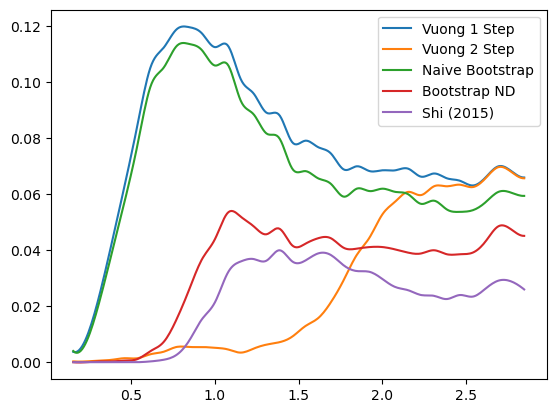

0.001 1.93069772888325


In [8]:
mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

# sequence 2

Quantiles: 1th: 0.52, 5th: 5.46, 10th: 17.57, 30th: 139.97, 50th: 430.26, 70th: 1004.36, 90th: 2547.78, 95th: 3476.46, 99th: 6164.20
bonus term 4.052409152194013 // variance stats 0.3704218759960477 //part1 4.641588833612778 //part2 0.8730650855689478
3.803025865024505 -0.4995288656067233 4.303677031697386
-4.3017924393635205 -0.4995288656067233 -3.8011412726906406
---
Quantiles: 1th: 0.52, 5th: 2.94, 10th: 9.00, 30th: 74.04, 50th: 224.09, 70th: 533.53, 90th: 1299.59, 95th: 1887.79, 99th: 3139.03
bonus term 0.8347038164726603 // variance stats 5.927121481576877 //part1 4.641588833612778 //part2 0.17983148581107067
-0.590358266532283 0.9582920933647929 2.462007320069382
-2.2597658994776038 0.9582920933647929 0.7925996871240614
---
Quantiles: 1th: 0.44, 5th: 2.51, 10th: 8.72, 30th: 72.01, 50th: 217.05, 70th: 500.59, 90th: 1296.40, 95th: 1857.95, 99th: 3336.36
bonus term 4.120511548185742 // variance stats 0.1639415494036884 //part1 4.641588833612778 //part2 0.8877373020088347
3.894095372

3.453823779995182 -0.45142206803819374 4.163907289680979
-4.158955576491891 -0.45142206803819374 -3.4488720668060937
---
Quantiles: 1th: 0.49, 5th: 2.63, 10th: 7.04, 30th: 48.84, 50th: 148.27, 70th: 350.04, 90th: 854.91, 95th: 1203.86, 99th: 2051.26
bonus term 1.293125906487941 // variance stats 2.213744874412628 //part1 4.641588833612778 //part2 0.27859553115165464
-0.2858452912460927 0.16054869151961348 2.694768696030796
-2.8720971042219747 0.16054869151961348 0.10851688305491375
---
Quantiles: 1th: 0.43, 5th: 2.50, 10th: 7.78, 30th: 69.66, 50th: 206.07, 70th: 489.25, 90th: 1213.44, 95th: 1647.48, 99th: 2775.22
bonus term 2.8862139327521565 // variance stats 0.7380064494465497 //part1 4.641588833612778 //part2 0.6218159419574597
2.165859525648795 -0.4582933271177075 3.643505545729505
-3.606568339855518 -0.4582933271177075 -2.128922319774808
---
Quantiles: 1th: 0.45, 5th: 2.64, 10th: 6.87, 30th: 58.12, 50th: 180.00, 70th: 435.29, 90th: 1084.00, 95th: 1563.38, 99th: 2670.17
bonus term 

Quantiles: 1th: 0.41, 5th: 2.80, 10th: 9.18, 30th: 82.74, 50th: 259.50, 70th: 622.37, 90th: 1555.65, 95th: 2236.21, 99th: 3805.25
bonus term 2.4300511066477783 // variance stats 1.415764500626263 //part1 4.641588833612778 //part2 0.5235386402712342
1.4485149213677986 -0.30775661762891354 3.3981922944268463
-3.411587291927758 -0.30775661762891354 -1.4619099188687104
---
Quantiles: 1th: 0.60, 5th: 4.02, 10th: 11.98, 30th: 97.97, 50th: 300.61, 70th: 739.99, 90th: 1864.69, 95th: 2520.96, 99th: 4410.46
bonus term 2.2886049254872445 // variance stats 1.9171450506969505 //part1 4.641588833612778 //part2 0.4930649843247555
1.3575965279289488 -0.167577020024556 3.3776027772705457
-3.21961332304554 -0.167577020024556 -1.1996070737039433
---
Quantiles: 1th: 0.54, 5th: 3.17, 10th: 9.21, 30th: 69.59, 50th: 209.77, 70th: 476.19, 90th: 1125.68, 95th: 1594.65, 99th: 2768.25
bonus term 1.5849636682747001 // variance stats 2.170883611646791 //part1 4.641588833612778 //part2 0.3414700709371201
0.31232779

Quantiles: 1th: 0.67, 5th: 3.02, 10th: 8.60, 30th: 64.12, 50th: 191.31, 70th: 448.33, 90th: 1120.07, 95th: 1648.99, 99th: 2884.78
bonus term 3.8821960859980362 // variance stats 0.21909509372526415 //part1 4.641588833612778 //part2 0.8363937921180172
3.5936772260382104 -0.8813115519943162 4.2000511568349665
-4.170714945957862 -0.8813115519943162 -3.5643410151611064
---
Quantiles: 1th: 0.74, 5th: 3.66, 10th: 12.17, 30th: 102.60, 50th: 312.58, 70th: 773.77, 90th: 1938.95, 95th: 2809.98, 99th: 4772.75
bonus term 3.0209299340893 // variance stats 1.040201219114338 //part1 4.641588833612778 //part2 0.650839624615772
2.3312189367629004 -0.45274679477919216 3.700833615635063
-3.7106409314156994 -0.45274679477919216 -2.3410262525435366
---
Quantiles: 1th: 0.51, 5th: 3.66, 10th: 10.68, 30th: 93.53, 50th: 276.73, 70th: 627.50, 90th: 1562.16, 95th: 2287.65, 99th: 3903.45
bonus term 1.2476517269074743 // variance stats 4.249485431227633 //part1 4.641588833612778 //part2 0.2687984161527649
-0.18987

3.0497387883280886 -0.7713194694829978 3.938757672240105
-3.9820389508720373 -0.7713194694829978 -3.0930200669600207
---
Quantiles: 1th: 0.39, 5th: 3.02, 10th: 9.58, 30th: 80.04, 50th: 239.56, 70th: 554.79, 90th: 1462.03, 95th: 2125.27, 99th: 3693.17
bonus term 2.2609588910650493 // variance stats 1.5394099928666658 //part1 4.641588833612778 //part2 0.4871088267646562
1.3441231461078549 -0.22806459083237404 3.236328650585629
-3.1777946360222438 -0.22806459083237404 -1.2855891315444699
---
Quantiles: 1th: 0.37, 5th: 2.74, 10th: 8.05, 30th: 77.93, 50th: 249.45, 70th: 619.14, 90th: 1571.88, 95th: 2211.91, 99th: 3666.00
bonus term 3.4003698455984153 // variance stats 0.573775592013129 //part1 4.641588833612778 //part2 0.7325874754295587
2.848602534914552 -0.6161787993602605 3.901799558286045
-3.9521371562822787 -0.6161787993602605 -2.8989401329107856
---
Quantiles: 1th: 0.60, 5th: 3.79, 10th: 12.59, 30th: 93.58, 50th: 301.17, 70th: 734.35, 90th: 1767.90, 95th: 2436.60, 99th: 4104.72
bonus 

0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.67, 5th: 4.43, 10th: 13.50, 30th: 122.01, 50th: 378.06, 70th: 911.43, 90th: 2234.89, 95th: 3032.03, 99th: 5204.51
bonus term 2.9463986466525283 // variance stats 1.2858269029051448 //part1 4.641588833612778 //part2 0.6347823455011202
2.2095348571024482 -0.6186302870422351 3.69098817986598
-3.6832624362026083 -0.6186302870422351 -2.2018091134390767
---
Quantiles: 1th: 0.43, 5th: 2.87, 10th: 7.79, 30th: 65.97, 50th: 194.07, 70th: 461.89, 90th: 1131.64, 95th: 1629.56, 99th: 2806.72
bonus term 1.6515499351733516 // variance stats 2.048765953116328 //part1 4.641588833612778 //part2 0.3558156472657378
0.39533985352182544 -0.14245747577177367 2.892003402472208
-2.907760016824878 -0.14245747577177367 -0.41109646787449544
---
Quantiles: 1th: 0.52, 5th: 3.95, 10th: 10.68, 30th: 91.41, 50th: 286.34, 70th: 693.31, 90th: 1745.80, 95th: 2509.63, 99th: 4614.74
bonus term 1.392985308489635 // variance stats 4.071405480752679 //part1 4.641588833612778 //

Quantiles: 1th: 0.70, 5th: 4.30, 10th: 12.72, 30th: 107.70, 50th: 318.10, 70th: 749.85, 90th: 1840.91, 95th: 2640.03, 99th: 4564.14
bonus term 1.3930266484152003 // variance stats 4.2930426341878665 //part1 4.641588833612778 //part2 0.30011849354845566
-0.1401052336826117 0.3027934633053581 2.7783976355751587
-2.9261585305130122 0.3027934633053581 -0.0076556612552422755
---
Quantiles: 1th: 0.56, 5th: 3.60, 10th: 10.07, 30th: 76.39, 50th: 231.50, 70th: 545.26, 90th: 1343.14, 95th: 1898.65, 99th: 3020.74
bonus term 2.2002983330773995 // variance stats 1.490251575290531 //part1 4.641588833612778 //part2 0.4740399057201278
1.2282016548588461 -0.47256823902119766 3.2550057732949544
-3.172395011295953 -0.47256823902119766 -1.1455908928598446
---
Quantiles: 1th: 0.43, 5th: 2.70, 10th: 7.56, 30th: 63.57, 50th: 189.33, 70th: 462.57, 90th: 1164.56, 95th: 1661.49, 99th: 2822.84
bonus term 1.7259677876500137 // variance stats 1.9672610594118622 //part1 4.641588833612778 //part2 0.3718484875590774


Quantiles: 1th: 0.55, 5th: 3.50, 10th: 10.38, 30th: 88.49, 50th: 279.43, 70th: 663.50, 90th: 1600.68, 95th: 2285.25, 99th: 3957.56
bonus term 1.7055826419375582 // variance stats 2.75542148571261 //part1 4.641588833612778 //part2 0.36745664105065046
0.48602283962789444 0.007577096307374656 2.927131517969597
-2.925142444247222 0.007577096307374656 -0.4840337659055191
---
Quantiles: 1th: 0.54, 5th: 4.65, 10th: 15.44, 30th: 149.02, 50th: 481.25, 70th: 1177.88, 90th: 3022.94, 95th: 4175.58, 99th: 7870.48
bonus term 3.457999466627461 // variance stats 1.0346791878223076 //part1 4.641588833612778 //part2 0.7450034009013954
2.92379039084643 -0.7094423676749602 3.923257696224548
-3.992208542408492 -0.7094423676749602 -2.9927412370303745
---
Quantiles: 1th: 0.40, 5th: 3.68, 10th: 11.74, 30th: 98.35, 50th: 304.43, 70th: 711.03, 90th: 1821.12, 95th: 2618.10, 99th: 4336.48
bonus term 2.6864829233081724 // variance stats 1.3253326556337661 //part1 4.641588833612778 //part2 0.5787852004153392
1.8827

Quantiles: 1th: 0.61, 5th: 3.96, 10th: 11.40, 30th: 89.94, 50th: 270.64, 70th: 626.42, 90th: 1533.20, 95th: 2190.72, 99th: 3995.61
bonus term 1.7381475736775989 // variance stats 2.5610968081470262 //part1 4.641588833612778 //part2 0.3744725429125769
0.5522470519119747 -0.26009260536428375 2.9377195954569797
-2.924048095443223 -0.26009260536428375 -0.5385755518982185
---
Quantiles: 1th: 0.96, 5th: 7.04, 10th: 23.90, 30th: 195.50, 50th: 565.31, 70th: 1297.28, 90th: 3253.62, 95th: 4755.47, 99th: 8235.84
bonus term 2.195500298453413 // variance stats 3.6249791396484903 //part1 4.641588833612778 //part2 0.47300620049633874
1.1794620885468274 -0.11263885281936088 3.1954444579231995
-3.211538508359999 -0.11263885281936088 -1.1955561389836264
---
Quantiles: 1th: 0.68, 5th: 4.55, 10th: 14.61, 30th: 128.07, 50th: 379.33, 70th: 886.55, 90th: 2261.37, 95th: 3091.37, 99th: 5255.74
bonus term 2.8064757852295337 // variance stats 1.478675973368349 //part1 4.641588833612778 //part2 0.6046368788432979

Quantiles: 1th: 1.01, 5th: 4.97, 10th: 15.09, 30th: 113.44, 50th: 358.75, 70th: 878.40, 90th: 2289.87, 95th: 3386.44, 99th: 5389.67
bonus term 2.238301614265147 // variance stats 2.458656082908426 //part1 4.641588833612778 //part2 0.4822274644527198
1.2791061227349165 -0.4348732384498449 3.1901920833623736
-3.197497105795377 -0.4348732384498449 -1.2864111451679205
---
Quantiles: 1th: 0.50, 5th: 4.51, 10th: 12.89, 30th: 104.32, 50th: 320.08, 70th: 765.14, 90th: 1890.03, 95th: 2666.16, 99th: 4719.02
bonus term 1.5757438626982099 // variance stats 3.6773370795824656 //part1 4.641588833612778 //part2 0.3394837240401861
0.35339143536657525 -0.03811673278809235 2.903576164777949
-2.7980962900298443 -0.03811673278809235 -0.24791156061847017
---
Quantiles: 1th: 0.56, 5th: 3.90, 10th: 11.85, 30th: 103.96, 50th: 301.96, 70th: 701.28, 90th: 1800.00, 95th: 2593.70, 99th: 4451.63
bonus term 0.7467668148289515 // variance stats 9.388038085784766 //part1 4.641588833612778 //part2 0.16088603312321095


2.7643675199727946 -0.8142723482672962 3.900033495915993
-3.8785596899473322 -0.8142723482672962 -2.742893714004134
---
Quantiles: 1th: 0.82, 5th: 4.79, 10th: 11.37, 30th: 85.70, 50th: 256.96, 70th: 601.11, 90th: 1558.87, 95th: 2179.89, 99th: 3605.87
bonus term 3.0337744571881604 // variance stats 0.8261559339075788 //part1 4.641588833612778 //part2 0.6536068932298822
2.354612849757345 -1.099761498092994 3.649887264549352
-3.712936064618976 -1.099761498092994 -2.417661649826969
---
0.5384615384615385 [1. 0. 0.]
Quantiles: 1th: 0.88, 5th: 4.85, 10th: 12.82, 30th: 108.85, 50th: 321.30, 70th: 753.67, 90th: 1929.77, 95th: 2712.91, 99th: 4724.15
bonus term 1.6203688165019459 // variance stats 3.5981022633101714 //part1 4.641588833612778 //part2 0.3490978788917701
0.3386209305000953 -0.41214486810680684 3.009416667853984
-2.902116702503797 -0.41214486810680684 -0.23132096514990816
---
Quantiles: 1th: 0.91, 5th: 6.32, 10th: 21.38, 30th: 195.24, 50th: 602.36, 70th: 1385.57, 90th: 3516.46, 95th

2.7079929368978117 -1.2874466797308635 3.836133351095362
-3.8325740149738836 -1.2874466797308635 -2.7044336007763334
---
Quantiles: 1th: 0.42, 5th: 3.64, 10th: 13.56, 30th: 127.62, 50th: 390.08, 70th: 914.97, 90th: 2257.34, 95th: 3287.50, 99th: 5767.11
bonus term 2.3293751889598173 // variance stats 2.240708491272136 //part1 4.641588833612778 //part2 0.5018486713194605
1.3425089209459036 -0.6762180458017293 3.243166160382999
-3.3162414569737315 -0.6762180458017293 -1.4155842175366358
---
Quantiles: 1th: 0.39, 5th: 3.43, 10th: 12.66, 30th: 116.68, 50th: 348.54, 70th: 797.45, 90th: 2012.07, 95th: 2841.07, 99th: 5064.20
bonus term 1.7207234172382986 // variance stats 3.41542235601907 //part1 4.641588833612778 //part2 0.37071862220483975
0.5369438106496207 -0.12026364695959907 2.9276882471046966
-2.9045030238269764 -0.12026364695959907 -0.5137585873719004
---
Quantiles: 1th: 0.57, 5th: 3.34, 10th: 11.20, 30th: 99.91, 50th: 292.30, 70th: 701.83, 90th: 1718.69, 95th: 2415.81, 99th: 4215.11
b

2.780399604354723 -0.8991931773340991 3.897048895296102
-3.8721367345643 -0.8991931773340991 -2.755487443622921
---
Quantiles: 1th: 0.44, 5th: 3.59, 10th: 11.15, 30th: 95.01, 50th: 289.60, 70th: 673.27, 90th: 1672.14, 95th: 2333.42, 99th: 4157.91
bonus term 1.250533516567243 // variance stats 4.534330769771588 //part1 4.641588833612778 //part2 0.269419278914003
-0.20535595126261535 0.11701951237507505 2.7444107904195483
-2.7064229843971015 0.11701951237507505 0.2433437572850618
---
Quantiles: 1th: 0.90, 5th: 5.69, 10th: 15.72, 30th: 120.85, 50th: 356.31, 70th: 811.97, 90th: 2106.85, 95th: 2926.59, 99th: 5189.98
bonus term 2.1062771107870693 // variance stats 2.53600449604978 //part1 4.641588833612778 //part2 0.4537836474299792
0.9697506360835401 -0.6903266030541599 3.146398875089264
-3.2428035854905986 -0.6903266030541599 -1.0661553464848743
---
Quantiles: 1th: 0.55, 5th: 4.06, 10th: 12.54, 30th: 94.45, 50th: 279.13, 70th: 631.00, 90th: 1641.69, 95th: 2241.26, 99th: 3767.37
bonus term 

Quantiles: 1th: 0.36, 5th: 2.80, 10th: 7.95, 30th: 63.57, 50th: 204.31, 70th: 476.81, 90th: 1175.91, 95th: 1725.15, 99th: 3041.50
bonus term 0.740364241681724 // variance stats 6.196272069706622 //part1 4.641588833612778 //part2 0.15950664055382557
-0.8447857584290045 0.7436299803365483 2.3496145701882662
-2.325514241792453 0.7436299803365483 0.8688860868248184
---
Quantiles: 1th: 0.66, 5th: 3.93, 10th: 12.57, 30th: 109.96, 50th: 337.79, 70th: 811.75, 90th: 2062.12, 95th: 2843.81, 99th: 4946.26
bonus term 2.8834711786284544 // variance stats 1.2573195940479744 //part1 4.641588833612778 //part2 0.6212250334944265
2.1175226284160047 -0.9777399617401642 3.6774485286047485
-3.649419728840904 -0.9777399617401642 -2.0894938286521603
---
Quantiles: 1th: 0.52, 5th: 3.78, 10th: 11.14, 30th: 94.77, 50th: 290.53, 70th: 678.02, 90th: 1760.42, 95th: 2521.70, 99th: 4583.15
bonus term 1.6806008914323605 // variance stats 3.101609649760746 //part1 4.641588833612778 //part2 0.3620744860600385
0.4662799

Quantiles: 1th: 0.98, 5th: 6.40, 10th: 20.04, 30th: 169.35, 50th: 496.44, 70th: 1153.76, 90th: 2977.18, 95th: 4218.53, 99th: 7455.21
bonus term 1.508156197538049 // variance stats 6.185565071380625 //part1 4.641588833612778 //part2 0.32492240299625513
0.19057155242546997 -0.11483406875375203 2.9075827630290356
-2.8257408426506285 -0.11483406875375203 -0.10872963204706255
---
Quantiles: 1th: 0.47, 5th: 3.92, 10th: 10.82, 30th: 83.81, 50th: 271.55, 70th: 628.86, 90th: 1524.23, 95th: 2194.48, 99th: 3531.04
bonus term 2.472539897476796 // variance stats 1.3371399337198033 //part1 4.641588833612778 //part2 0.5326925727611886
1.5479613788655708 -1.9605226676925898 3.428423995238215
-3.397118416088021 -1.9605226676925898 -1.516655799715377
---
Quantiles: 1th: 0.72, 5th: 4.80, 10th: 13.40, 30th: 105.06, 50th: 309.90, 70th: 711.46, 90th: 1784.21, 95th: 2566.94, 99th: 4470.51
bonus term 1.90104594946305 // variance stats 2.572110648893876 //part1 4.641588833612778 //part2 0.40956793408677944
0.7

0.5721649744531037 -0.8686974162295062 3.09193559114104
-3.059300007328175 -0.8686974162295062 -0.5395293906402385
---
Quantiles: 1th: 0.40, 5th: 2.70, 10th: 9.07, 30th: 71.91, 50th: 219.72, 70th: 511.98, 90th: 1282.98, 95th: 1859.77, 99th: 3218.60
bonus term 0.8157292872251584 // variance stats 6.0173033612320275 //part1 4.641588833612778 //part2 0.17574354740728637
-0.8524087619368954 0.364018268405433 2.4495687959819734
-2.4838673363872124 0.364018268405433 0.8181102215316567
---
Quantiles: 1th: 0.57, 5th: 3.41, 10th: 12.05, 30th: 110.82, 50th: 349.31, 70th: 869.42, 90th: 2232.27, 95th: 3103.25, 99th: 5480.46
bonus term 1.7960336903626786 // variance stats 3.5367063220218355 //part1 4.641588833612778 //part2 0.38694372869833377
0.5157138228361235 -0.56802670330011 3.028649364520189
-3.0763535578892336 -0.56802670330011 -0.5634180162051684
---
0.8461538461538463 [1. 0. 0.]
Quantiles: 1th: 0.82, 5th: 5.92, 10th: 16.32, 30th: 142.81, 50th: 457.29, 70th: 1088.05, 90th: 2855.37, 95th: 39

Quantiles: 1th: 0.48, 5th: 4.08, 10th: 13.86, 30th: 119.22, 50th: 373.21, 70th: 831.06, 90th: 2033.47, 95th: 2890.27, 99th: 4782.19
bonus term 1.105490589344266 // variance stats 6.504411141114153 //part1 4.641588833612778 //part2 0.23817072751870783
-0.4805281741139118 0.11740392286019265 2.7089502178133404
-2.6915093528024436 0.11740392286019265 0.4979690391248085
---
Quantiles: 1th: 0.39, 5th: 3.91, 10th: 15.23, 30th: 157.97, 50th: 480.75, 70th: 1082.86, 90th: 2802.96, 95th: 3972.23, 99th: 7189.20
bonus term 0.8081173924625543 // variance stats 13.296411426992536 //part1 4.641588833612778 //part2 0.17410361439394373
-0.8242298394725762 1.3662665738074 2.486462955407922
-2.4404646243976846 1.3662665738074 0.8702281704828134
---
Quantiles: 1th: 0.47, 5th: 3.33, 10th: 8.80, 30th: 74.01, 50th: 230.82, 70th: 529.24, 90th: 1329.98, 95th: 1881.19, 99th: 3261.50
bonus term 1.4737215843245504 // variance stats 2.858883387166208 //part1 4.641588833612778 //part2 0.317503690471756
0.0781154749

-0.6032893288286622 -0.07419061655791112 2.587396519013286
-2.460120930616298 -0.07419061655791112 0.7305649172256502
---
Quantiles: 1th: 0.55, 5th: 4.59, 10th: 14.80, 30th: 131.25, 50th: 420.82, 70th: 963.91, 90th: 2368.89, 95th: 3359.08, 99th: 6212.75
bonus term 2.660547557667242 // variance stats 1.7638716476946201 //part1 4.641588833612778 //part2 0.573197595271791
1.8041748941091265 -1.0357405720900268 3.510203391608196
-3.516920221225358 -1.0357405720900268 -1.810891723726288
---
Quantiles: 1th: 0.68, 5th: 4.17, 10th: 12.54, 30th: 101.10, 50th: 302.02, 70th: 714.04, 90th: 1778.33, 95th: 2478.64, 99th: 4352.40
bonus term 1.7044975680250838 // variance stats 3.064311551901532 //part1 4.641588833612778 //part2 0.36722286896282214
0.49715428342430024 -1.0294689721601298 2.983833924988955
-2.9118408526258674 -1.0294689721601298 -0.4251612110612124
---
Quantiles: 1th: 0.46, 5th: 3.16, 10th: 10.44, 30th: 88.41, 50th: 286.49, 70th: 693.33, 90th: 1708.16, 95th: 2394.76, 99th: 4296.21
bonu

-0.7100160725012705 0.029227461829504475 2.5308758293377758
-2.7018112816221342 0.029227461829504475 0.5390806202169122
---
Quantiles: 1th: 0.57, 5th: 3.03, 10th: 8.36, 30th: 60.13, 50th: 181.55, 70th: 416.81, 90th: 1010.67, 95th: 1437.56, 99th: 2542.50
bonus term 0.9565460215445626 // variance stats 3.8935450544457177 //part1 4.641588833612778 //part2 0.20608159314275915
-0.6226713005414705 -0.8636990399951274 2.535911610599319
-2.5357633436305957 -0.8636990399951274 0.6228195675101938
---
Quantiles: 1th: 0.46, 5th: 3.49, 10th: 10.52, 30th: 108.02, 50th: 318.47, 70th: 783.77, 90th: 1924.02, 95th: 2653.38, 99th: 4615.19
bonus term 1.3871449575313946 // variance stats 4.514020549097616 //part1 4.641588833612778 //part2 0.2988513216608441
0.009150636223206927 -0.7625906450181259 2.7627207113336407
-2.765139278839582 -0.7625906450181259 -0.011569203729148771
---
Quantiles: 1th: 0.79, 5th: 5.65, 10th: 17.83, 30th: 140.73, 50th: 426.56, 70th: 1017.20, 90th: 2605.65, 95th: 3619.92, 99th: 568

0.05301084350741396 -0.9162040611364226 2.875942217964557
-2.7996251053558265 -0.9162040611364226 0.023306269101315998
---
Quantiles: 1th: 0.76, 5th: 4.63, 10th: 13.81, 30th: 110.99, 50th: 321.37, 70th: 751.46, 90th: 1959.49, 95th: 2771.64, 99th: 4494.95
bonus term 0.9392179678805179 // variance stats 7.7242349743512335 //part1 4.641588833612778 //part2 0.20234837715030396
-0.6502951151704861 0.16990451848934673 2.48154356573076
-2.5287310509315217 0.16990451848934673 0.6031076299697237
---
Quantiles: 1th: 0.39, 5th: 3.43, 10th: 11.56, 30th: 91.56, 50th: 297.06, 70th: 707.52, 90th: 1718.52, 95th: 2373.08, 99th: 3734.62
bonus term 0.9466241003009571 // variance stats 6.707927199670333 //part1 4.641588833612778 //part2 0.20394398001086037
-0.7061913490830991 -0.013607065112090927 2.475709250641432
-2.5994395496850133 -0.013607065112090927 0.5824610500395176
---
Quantiles: 1th: 0.46, 5th: 2.48, 10th: 8.23, 30th: 72.85, 50th: 233.21, 70th: 532.48, 90th: 1286.37, 95th: 1826.28, 99th: 3157.8

Quantiles: 1th: 0.64, 5th: 4.20, 10th: 13.37, 30th: 118.69, 50th: 340.65, 70th: 836.15, 90th: 2091.66, 95th: 2915.72, 99th: 5263.13
bonus term 1.1332875970624576 // variance stats 6.47511141937969 //part1 4.641588833612778 //part2 0.24415941128942348
-0.28996954461453 -0.1903344716118189 2.6628594251396365
-2.5565447387394453 -0.1903344716118189 0.3962842310147213
---
Quantiles: 1th: 0.62, 5th: 4.38, 10th: 13.72, 30th: 115.56, 50th: 341.02, 70th: 769.77, 90th: 2003.83, 95th: 2866.64, 99th: 4685.17
bonus term 1.8962329756098222 // variance stats 2.901137819291493 //part1 4.641588833612778 //part2 0.4085310103036184
0.6470185468569607 -1.4228445346032803 3.1022735060588613
-3.1454474043626837 -1.4228445346032803 -0.690192445160783
---
Quantiles: 1th: 0.67, 5th: 5.16, 10th: 16.02, 30th: 138.37, 50th: 405.43, 70th: 937.73, 90th: 2424.61, 95th: 3566.33, 99th: 6034.31
bonus term 1.4637258601396372 // variance stats 5.264028051710099 //part1 4.641588833612778 //part2 0.3153501769781592
0.1830

Quantiles: 1th: 0.67, 5th: 4.62, 10th: 12.12, 30th: 104.64, 50th: 329.18, 70th: 747.12, 90th: 1899.46, 95th: 2717.75, 99th: 4730.82
bonus term 0.719741259663941 // variance stats 10.350093540983254 //part1 4.641588833612778 //part2 0.15506355376672404
-0.9396034783493192 0.8532901022107373 2.620685013114423
-2.379085997677201 0.8532901022107373 1.181202493786541
---
Quantiles: 1th: 0.49, 5th: 3.50, 10th: 10.48, 30th: 100.56, 50th: 307.42, 70th: 723.78, 90th: 1794.27, 95th: 2569.09, 99th: 4607.07
bonus term 0.9705977984059577 // variance stats 6.786282300932553 //part1 4.641588833612778 //part2 0.20910895669543686
-0.6134272913502279 0.11792083234784137 2.6175925854541005
-2.554622888162143 0.11792083234784137 0.6763969886421848
---
Quantiles: 1th: 0.46, 5th: 2.94, 10th: 8.72, 30th: 68.21, 50th: 199.62, 70th: 447.21, 90th: 1128.94, 95th: 1623.75, 99th: 2973.69
bonus term 0.9260483368106865 // variance stats 4.5295824053123495 //part1 4.641588833612778 //part2 0.1995110661471273
-0.72217

Quantiles: 1th: 0.67, 5th: 3.77, 10th: 9.90, 30th: 83.48, 50th: 249.59, 70th: 585.75, 90th: 1497.57, 95th: 2104.77, 99th: 3587.25
bonus term 1.0134129672760686 // variance stats 5.361540648960411 //part1 4.641588833612778 //part2 0.21833320520277083
-0.5056432161420782 -0.7644315926308359 2.5559681068122293
-2.532469150694215 -0.7644315926308359 0.5291421722600923
---
Quantiles: 1th: 0.65, 5th: 4.04, 10th: 11.53, 30th: 91.74, 50th: 270.78, 70th: 642.58, 90th: 1518.82, 95th: 2063.48, 99th: 3702.46
bonus term 0.9411884430089569 // variance stats 5.971425738439624 //part1 4.641588833612778 //part2 0.20277290314755936
-0.6208738940155883 -0.2567900826767816 2.3904999380341194
-2.503250780033502 -0.2567900826767816 0.5081230520162056
---
Quantiles: 1th: 0.42, 5th: 2.96, 10th: 10.65, 30th: 109.62, 50th: 342.86, 70th: 792.63, 90th: 2058.87, 95th: 2860.17, 99th: 4966.51
bonus term 1.1764670987731272 // variance stats 6.064127533558372 //part1 4.641588833612778 //part2 0.25346215292779917
-0.24

Quantiles: 1th: 0.58, 5th: 4.44, 10th: 14.45, 30th: 118.76, 50th: 363.38, 70th: 844.25, 90th: 2301.54, 95th: 3253.50, 99th: 5418.41
bonus term 1.668983524980836 // variance stats 4.09924474287457 //part1 4.641588833612778 //part2 0.3595716003310408
0.3879623779779337 -1.0254629164340399 2.904586080981903
-2.9500046719837383 -1.0254629164340399 -0.4333809689797689
---
Quantiles: 1th: 0.62, 5th: 3.62, 10th: 12.01, 30th: 100.03, 50th: 325.14, 70th: 740.68, 90th: 1871.15, 95th: 2699.27, 99th: 4505.95
bonus term 0.6237953959063282 // variance stats 12.051832872214018 //part1 4.641588833612778 //part2 0.13439264404227666
-1.1601582160245738 1.1990050436262867 2.5214215893618377
-2.4077490078372303 1.1990050436262867 1.2738307975491814
---
Quantiles: 1th: 0.55, 5th: 3.30, 10th: 9.41, 30th: 63.57, 50th: 202.72, 70th: 478.92, 90th: 1263.86, 95th: 1796.51, 99th: 3078.48
bonus term 1.6703872036160254 // variance stats 2.2480824625690223 //part1 4.641588833612778 //part2 0.35987401372557176
0.2129

Quantiles: 1th: 0.37, 5th: 2.67, 10th: 9.96, 30th: 87.95, 50th: 244.77, 70th: 567.21, 90th: 1397.92, 95th: 1959.18, 99th: 3367.34
bonus term 0.9877143725867019 // variance stats 5.171342923228904 //part1 4.641588833612778 //part2 0.2127966108143868
-0.5975633260320374 -0.5788753894541208 2.6871870513562883
-2.5729920712054413 -0.5788753894541208 0.7117583061828844
---
Quantiles: 1th: 0.49, 5th: 3.22, 10th: 9.48, 30th: 74.90, 50th: 233.52, 70th: 542.76, 90th: 1391.61, 95th: 1990.03, 99th: 3207.73
bonus term 0.8019458428925886 // variance stats 6.6629213200785244 //part1 4.641588833612778 //part2 0.1727739943454652
-0.7689548999651431 -0.5327429976013149 2.3200946786655487
-2.3728465857503203 -0.5327429976013149 0.7162029928803716
---
Quantiles: 1th: 0.47, 5th: 3.80, 10th: 15.56, 30th: 141.36, 50th: 436.83, 70th: 1046.87, 90th: 2603.85, 95th: 3615.60, 99th: 6571.04
bonus term 0.9229038882695835 // variance stats 10.491775854700185 //part1 4.641588833612778 //part2 0.19883361524533005
-0.

-0.933557653508535 0.8965664173443482 2.4792973301688837
-2.3424151722082063 0.8965664173443482 1.0704398114692126
---
Quantiles: 1th: 0.42, 5th: 3.73, 10th: 11.38, 30th: 98.55, 50th: 305.56, 70th: 702.45, 90th: 1726.31, 95th: 2448.20, 99th: 3953.93
bonus term 0.8992358177137092 // variance stats 7.184385994497241 //part1 4.641588833612778 //part2 0.19373448402016027
-0.716518760590946 -0.22414519200285984 2.4339096259985866
-2.5149903960183644 -0.22414519200285984 0.6354379905711681
---
Quantiles: 1th: 0.57, 5th: 3.68, 10th: 11.51, 30th: 105.76, 50th: 325.17, 70th: 790.68, 90th: 1960.49, 95th: 2885.88, 99th: 4898.82
bonus term 0.5520524737854188 // variance stats 14.523078220905905 //part1 4.641588833612778 //part2 0.11893610002412235
-1.2216861052032595 1.7328335356523525 2.421272550516347
-2.325791052774097 1.7328335356523525 1.3171676029455095
---
Quantiles: 1th: 0.52, 5th: 3.25, 10th: 9.55, 30th: 98.86, 50th: 302.60, 70th: 709.32, 90th: 1751.53, 95th: 2450.21, 99th: 3943.33
bonus 

-0.8399410652130563 0.21781831240926672 2.500564891223833
-2.2859802887729326 0.21781831240926672 1.0545256676639565
---
Quantiles: 1th: 0.74, 5th: 4.78, 10th: 14.22, 30th: 138.89, 50th: 416.52, 70th: 979.31, 90th: 2369.68, 95th: 3265.11, 99th: 6023.68
bonus term 0.9569418542578642 // variance stats 9.124296784817538 //part1 4.641588833612778 //part2 0.20616687271565778
-0.5839127191716118 0.17577316627933523 2.5391631241772163
-2.4977964276873403 0.17577316627933523 0.625279415661488
---
Quantiles: 1th: 0.36, 5th: 2.83, 10th: 8.68, 30th: 73.50, 50th: 220.72, 70th: 525.77, 90th: 1309.86, 95th: 1866.34, 99th: 3273.35
bonus term 0.44389006459328717 // variance stats 12.386853508443954 //part1 4.641588833612778 //part2 0.09563321537202715
-1.2385980603049362 1.8343327964486313 2.280277698271544
-2.1263781894915104 1.8343327964486313 1.3924975690849692
---
Quantiles: 1th: 0.29, 5th: 2.53, 10th: 7.93, 30th: 60.73, 50th: 184.34, 70th: 442.82, 90th: 1102.88, 95th: 1597.11, 99th: 2896.82
bonus

-1.0797325397363366 0.5287826835669562 2.2875021818956225
-2.3678636300316906 0.5287826835669562 0.999371091600268
---
Quantiles: 1th: 0.47, 5th: 2.83, 10th: 8.99, 30th: 71.45, 50th: 215.67, 70th: 514.72, 90th: 1323.34, 95th: 1837.48, 99th: 2939.09
bonus term 1.0199700744022415 // variance stats 4.698790804679155 //part1 4.641588833612778 //part2 0.21974589110865908
-0.48945289329566233 -1.094937362438455 2.4619892382748807
-2.5293930421001454 -1.094937362438455 0.4220490894703975
---
Quantiles: 1th: 0.65, 5th: 4.21, 10th: 14.07, 30th: 131.56, 50th: 404.69, 70th: 936.68, 90th: 2450.90, 95th: 3309.84, 99th: 5453.73
bonus term 0.9408241810133708 // variance stats 9.640717021797672 //part1 4.641588833612778 //part2 0.20269442527960427
-0.6228643594199988 0.04744115162159226 2.5282770379681794
-2.5045127214467406 0.04744115162159226 0.6466286759414375
---
Quantiles: 1th: 0.46, 5th: 2.78, 10th: 8.25, 30th: 78.18, 50th: 238.23, 70th: 580.25, 90th: 1510.28, 95th: 2162.86, 99th: 3788.46
bonus 

Quantiles: 1th: 0.52, 5th: 3.31, 10th: 11.36, 30th: 100.45, 50th: 306.45, 70th: 747.71, 90th: 1910.97, 95th: 2769.69, 99th: 4631.46
bonus term 0.8166967227125072 // variance stats 8.949782269982292 //part1 4.641588833612778 //part2 0.1759519750647176
-0.8693518317324302 -0.08894545096025885 2.2958228594629393
-2.5027452771574445 -0.08894545096025885 0.6624294140379253
---
Quantiles: 1th: 0.66, 5th: 3.89, 10th: 11.20, 30th: 93.05, 50th: 284.28, 70th: 663.74, 90th: 1665.70, 95th: 2339.54, 99th: 4077.01
bonus term 0.6248693622370187 // variance stats 10.707290027007312 //part1 4.641588833612778 //part2 0.13462402307415325
-1.0695082463506056 0.7403831923323866 2.2665491591418228
-2.3192469708246426 0.7403831923323866 1.0168104346677853
---
Quantiles: 1th: 0.37, 5th: 2.75, 10th: 8.60, 30th: 71.63, 50th: 221.94, 70th: 518.44, 90th: 1342.82, 95th: 1910.48, 99th: 3100.76
bonus term 0.6146503956673549 // variance stats 8.79763965010701 //part1 4.641588833612778 //part2 0.13242241346675726
-1.1

Quantiles: 1th: 0.55, 5th: 3.10, 10th: 7.95, 30th: 67.65, 50th: 207.37, 70th: 476.72, 90th: 1204.55, 95th: 1667.89, 99th: 2903.40
bonus term 0.6158037883057927 // variance stats 7.874705851904726 //part1 4.641588833612778 //part2 0.13267090437790507
-1.2136911759021634 -0.16048030191367776 2.3331760092831817
-2.445298752513749 -0.16048030191367776 1.1015684326715962
---
Quantiles: 1th: 0.51, 5th: 3.91, 10th: 12.54, 30th: 105.82, 50th: 309.06, 70th: 676.47, 90th: 1779.16, 95th: 2558.92, 99th: 4400.42
bonus term 0.8392122091680289 // variance stats 8.06115930901823 //part1 4.641588833612778 //part2 0.18080278957298948
-0.8712065414715603 -0.5431935843315414 2.524763120219259
-2.549630959807618 -0.5431935843315414 0.8463387018832014
---
Quantiles: 1th: 0.64, 5th: 3.85, 10th: 12.24, 30th: 103.22, 50th: 311.30, 70th: 747.32, 90th: 1883.31, 95th: 2704.34, 99th: 4687.24
bonus term 0.9281974316599373 // variance stats 7.534457630382502 //part1 4.641588833612778 //part2 0.1999740745966668
-0.68

-1.328340998866802 0.7646379861070454 2.2242632485353826
-2.2934530749198316 0.7646379861070454 1.2591511724823523
---
Quantiles: 1th: 0.74, 5th: 4.57, 10th: 14.93, 30th: 130.58, 50th: 409.41, 70th: 966.25, 90th: 2468.50, 95th: 3506.96, 99th: 6276.65
bonus term 0.8391744904838758 // variance stats 11.185101144011359 //part1 4.641588833612778 //part2 0.18079466332882932
-0.7958823308808936 0.2155473360277829 2.502243407257248
-2.474231311848645 0.2155473360277829 0.8238944262894964
---
Quantiles: 1th: 0.66, 5th: 5.48, 10th: 16.83, 30th: 156.28, 50th: 484.22, 70th: 1121.06, 90th: 2591.51, 95th: 3752.68, 99th: 6585.77
bonus term 1.7030896428421929 // variance stats 4.471366267456885 //part1 4.641588833612778 //part2 0.36691954067732324
0.3326540415000977 -2.050968863117235 2.9938804962429058
-3.0735252441842884 -2.050968863117235 -0.41229878944148046
---
Quantiles: 1th: 0.59, 5th: 4.00, 10th: 11.83, 30th: 97.75, 50th: 286.42, 70th: 677.42, 90th: 1684.31, 95th: 2425.40, 99th: 4196.69
bonus

-0.7146581152754876 -1.37111043422965 2.6588081131845827
-2.5532967898131047 -1.37111043422965 0.8201694386469653
---
Quantiles: 1th: 0.47, 5th: 3.58, 10th: 11.01, 30th: 95.47, 50th: 280.28, 70th: 654.32, 90th: 1671.58, 95th: 2295.93, 99th: 3973.13
bonus term 0.7189878713820781 // variance stats 9.119702195601672 //part1 4.641588833612778 //part2 0.15490124118177315
-0.9338165615022239 -0.16888982492633686 2.3686101693703137
-2.37179230426638 -0.16888982492633686 0.9306344266061573
---
Quantiles: 1th: 0.52, 5th: 3.56, 10th: 12.68, 30th: 101.87, 50th: 318.52, 70th: 761.13, 90th: 1861.36, 95th: 2770.78, 99th: 4810.74
bonus term 0.8216023210490674 // variance stats 8.654255627519975 //part1 4.641588833612778 //part2 0.17700885418788243
-0.8023343269988493 -0.21520314680263197 2.4546207613722077
-2.445538969096984 -0.21520314680263197 0.8114161192740732
---
Quantiles: 1th: 0.39, 5th: 2.31, 10th: 5.69, 30th: 44.92, 50th: 143.06, 70th: 329.50, 90th: 843.68, 95th: 1240.31, 99th: 2052.89
bonus

-1.3643459734248922 0.3736417674860292 2.2329200468737462
-2.185964201789024 0.3736417674860292 1.4113018185096142
---
Quantiles: 1th: 0.46, 5th: 3.15, 10th: 10.84, 30th: 86.94, 50th: 268.47, 70th: 611.41, 90th: 1513.31, 95th: 2119.67, 99th: 3644.82
bonus term 0.726447630175563 // variance stats 8.155857493292613 //part1 4.641588833612778 //part2 0.15650839749416856
-0.8922833734171903 -0.6198071089046109 2.3679908311036204
-2.3451786337683163 -0.6198071089046109 0.9150955707524943
---
Quantiles: 1th: 0.82, 5th: 4.88, 10th: 14.32, 30th: 121.48, 50th: 353.61, 70th: 837.14, 90th: 2157.41, 95th: 3038.32, 99th: 5192.04
bonus term 0.810552410975373 // variance stats 10.196910914681471 //part1 4.641588833612778 //part2 0.17462822322943242
-0.824479183563891 -0.12378629509884459 2.4336664097034326
-2.445584005514637 -0.12378629509884459 0.8125615877526864
---
Quantiles: 1th: 0.51, 5th: 3.23, 10th: 8.89, 30th: 77.23, 50th: 219.73, 70th: 513.21, 90th: 1246.21, 95th: 1777.65, 99th: 2960.03
bonus

-1.264115343888664 0.5212203468421757 2.3375283616723648
-2.203499213002214 0.5212203468421757 1.3981444925588147
---
Quantiles: 1th: 0.44, 5th: 3.24, 10th: 8.07, 30th: 68.72, 50th: 210.88, 70th: 503.33, 90th: 1272.90, 95th: 1785.27, 99th: 3089.24
bonus term 0.5814043856077226 // variance stats 8.88915189142864 //part1 4.641588833612778 //part2 0.12525977772899516
-1.213008783428384 -0.4963275142336445 2.221164291421541
-2.375817554643829 -0.4963275142336445 1.0583555202060964
---
Quantiles: 1th: 0.43, 5th: 3.05, 10th: 9.55, 30th: 94.04, 50th: 280.63, 70th: 663.74, 90th: 1733.84, 95th: 2413.76, 99th: 4072.67
bonus term 0.7352283672101697 // variance stats 9.212130584739409 //part1 4.641588833612778 //part2 0.158400149941309
-0.9846749598398986 -0.10713825492844835 2.4788055525243
-2.4551316942602384 -0.10713825492844835 1.0083488181039608
---
Quantiles: 1th: 0.79, 5th: 4.43, 10th: 14.56, 30th: 125.10, 50th: 394.06, 70th: 903.37, 90th: 2359.14, 95th: 3288.35, 99th: 5612.65
bonus term 0.

Quantiles: 1th: 0.46, 5th: 3.38, 10th: 10.34, 30th: 83.57, 50th: 251.00, 70th: 581.45, 90th: 1449.30, 95th: 2150.00, 99th: 3683.73
bonus term 0.5519862006717493 // variance stats 10.73771139191604 //part1 4.641588833612778 //part2 0.11892182191461177
-1.1113561765470859 0.33937447574793445 2.355372304686964
-2.2153285778905847 0.33937447574793445 1.251399903343465
---
2.0 [0.98285714 0.         0.01714286]
Quantiles: 1th: 0.37, 5th: 3.60, 10th: 12.34, 30th: 128.16, 50th: 419.81, 70th: 1004.96, 90th: 2560.49, 95th: 3732.10, 99th: 6170.96
bonus term 0.6271322126466997 // variance stats 16.39041426005122 //part1 4.641588833612778 //part2 0.1351115394162502
-1.0159775672909488 1.056952630258794 2.26921839698062
-2.270241992584348 1.056952630258794 1.0149539716872205
---
Quantiles: 1th: 0.48, 5th: 3.53, 10th: 12.82, 30th: 118.76, 50th: 355.16, 70th: 836.41, 90th: 2125.26, 95th: 3047.45, 99th: 5045.47
bonus term 1.2760329768610639 // variance stats 5.605412471218441 //part1 4.641588833612778

Quantiles: 1th: 0.70, 5th: 5.71, 10th: 18.45, 30th: 167.91, 50th: 510.74, 70th: 1253.41, 90th: 3124.12, 95th: 4441.74, 99th: 7410.98
bonus term 0.8623499342967674 // variance stats 13.69143648984936 //part1 4.641588833612778 //part2 0.18578766133956717
-0.9003278411963583 -0.17359048904978158 2.3750822709102137
-2.6250277097898933 -0.17359048904978158 0.6503824023166785
---
Quantiles: 1th: 0.33, 5th: 1.73, 10th: 5.57, 30th: 49.71, 50th: 142.25, 70th: 320.28, 90th: 814.53, 95th: 1189.61, 99th: 1930.23
bonus term 0.38930121853691035 // variance stats 8.89697790410335 //part1 4.641588833612778 //part2 0.08387240500876031
-1.4563274568270186 -0.09788975439447659 2.275545539484161
-2.2349298939008393 -0.09788975439447659 1.4969431024103401
---
Quantiles: 1th: 0.68, 5th: 3.93, 10th: 12.65, 30th: 116.30, 50th: 353.78, 70th: 809.39, 90th: 1961.10, 95th: 2753.83, 99th: 4520.47
bonus term 0.9002829599401242 // variance stats 8.149745738318535 //part1 4.641588833612778 //part2 0.19396008397395886

Quantiles: 1th: 0.58, 5th: 4.57, 10th: 16.21, 30th: 152.88, 50th: 475.65, 70th: 1107.59, 90th: 2710.85, 95th: 3977.34, 99th: 7244.25
bonus term 1.490993831727783 // variance stats 5.728246552504926 //part1 4.641588833612778 //part2 0.3212248833697897
0.045209039438601384 -2.3841205846444797 2.7692039882873916
-2.9367786240169647 -2.3841205846444797 -0.21278367516817503
---
Quantiles: 1th: 0.65, 5th: 3.74, 10th: 9.32, 30th: 77.32, 50th: 239.50, 70th: 547.12, 90th: 1332.28, 95th: 1897.98, 99th: 3258.02
bonus term 0.5830644320775442 // variance stats 9.273561927799712 //part1 4.641588833612778 //part2 0.12561742389916003
-1.2678660816013694 -0.722567152439959 2.3313011783578963
-2.433994945756458 -0.722567152439959 1.1651723142028079
---
Quantiles: 1th: 0.47, 5th: 3.31, 10th: 9.83, 30th: 86.86, 50th: 273.38, 70th: 666.02, 90th: 1682.22, 95th: 2403.83, 99th: 4242.81
bonus term 0.5618576484491337 // variance stats 12.214843049857441 //part1 4.641588833612778 //part2 0.12104856086785525
-1.1

Quantiles: 1th: 0.42, 5th: 3.53, 10th: 14.15, 30th: 120.63, 50th: 348.97, 70th: 825.78, 90th: 2098.10, 95th: 2925.82, 99th: 5359.05
bonus term 0.721843833805432 // variance stats 11.39305779064264 //part1 4.641588833612778 //part2 0.15551653963360326
-1.1192002733210877 -0.5142502246173465 2.392009603591787
-2.562887940931952 -0.5142502246173465 0.9483219359809231
---
Quantiles: 1th: 0.55, 5th: 3.83, 10th: 12.15, 30th: 94.81, 50th: 289.54, 70th: 674.51, 90th: 1746.45, 95th: 2489.65, 99th: 4246.93
bonus term 0.6251587338410706 // variance stats 11.220330766848083 //part1 4.641588833612778 //part2 0.13468636629636122
-1.1441623991393084 -0.4392121981685942 2.3118276837004954
-2.3944798668214498 -0.4392121981685942 1.0615102160183538
---
Quantiles: 1th: 0.40, 5th: 2.44, 10th: 6.68, 30th: 55.17, 50th: 174.87, 70th: 401.63, 90th: 965.77, 95th: 1386.68, 99th: 2548.90
bonus term 0.4515140039222885 // variance stats 8.962412062932803 //part1 4.641588833612778 //part2 0.09727574330853705
-1.370

Quantiles: 1th: 0.54, 5th: 3.63, 10th: 10.21, 30th: 84.09, 50th: 261.44, 70th: 605.37, 90th: 1496.42, 95th: 2067.36, 99th: 3738.51
bonus term 0.5438372654986026 // variance stats 11.275337812638563 //part1 4.641588833612778 //part2 0.11716618705222692
-1.244636843053167 -0.29519264674736406 2.403343294052353
-2.3323113740503723 -0.29519264674736406 1.315668763055148
---
Quantiles: 1th: 0.28, 5th: 2.52, 10th: 6.54, 30th: 48.39, 50th: 146.33, 70th: 338.70, 90th: 838.02, 95th: 1200.10, 99th: 2207.10
bonus term 0.449539187153728 // variance stats 7.814703392647316 //part1 4.641588833612778 //part2 0.0968502819332727
-1.491456797932534 -1.3522227682754566 2.2420833032424907
-2.39053517223999 -1.3522227682754566 1.3430049289350348
---
Quantiles: 1th: 0.36, 5th: 2.66, 10th: 8.14, 30th: 70.95, 50th: 215.59, 70th: 520.13, 90th: 1310.61, 95th: 1914.83, 99th: 3070.34
bonus term 0.36396595867081827 // variance stats 15.403358316702022 //part1 4.641588833612778 //part2 0.07841408873511217
-1.443419

-1.3015558178817963 0.6856334537675609 2.1708265864843534
-2.300386785258218 0.6856334537675609 1.1719956191079322
---
Quantiles: 1th: 0.53, 5th: 3.60, 10th: 11.34, 30th: 99.41, 50th: 302.13, 70th: 708.85, 90th: 1830.47, 95th: 2574.14, 99th: 4183.54
bonus term 0.530071400952969 // variance stats 14.198109599131907 //part1 4.641588833612778 //part2 0.11420042144068764
-1.267819172579339 0.7207071136384954 2.3621207930117056
-2.327961974485277 0.7207071136384954 1.3019779911057676
---
Quantiles: 1th: 0.68, 5th: 3.82, 10th: 10.72, 30th: 75.08, 50th: 234.93, 70th: 551.88, 90th: 1372.31, 95th: 1952.41, 99th: 3392.04
bonus term 0.7014994857133116 // variance stats 7.707810811064503 //part1 4.641588833612778 //part2 0.15113348270602844
-0.9821655385034881 -1.8546579094290723 2.269167055482858
-2.385164509930111 -1.8546579094290723 0.8661680840562349
---
2.307692307692308 [0.97428571 0.00142857 0.02428571]
Quantiles: 1th: 0.52, 5th: 2.87, 10th: 8.06, 30th: 64.79, 50th: 201.38, 70th: 468.62, 90

-1.2761081570171686 0.43618124072115033 2.3369509611117816
-2.384840911269178 0.43618124072115033 1.228218206859772
---
Quantiles: 1th: 0.37, 5th: 2.73, 10th: 8.79, 30th: 79.40, 50th: 250.62, 70th: 577.31, 90th: 1456.77, 95th: 2026.48, 99th: 3406.54
bonus term 0.44429960197303725 // variance stats 13.762070738962501 //part1 4.641588833612778 //part2 0.09572144752580698
-1.3114666524398344 0.6706940809359666 2.2473797512904246
-2.200065856385909 0.6706940809359666 1.35878054734435
---
Quantiles: 1th: 0.51, 5th: 3.05, 10th: 9.40, 30th: 85.97, 50th: 258.66, 70th: 610.91, 90th: 1469.28, 95th: 2110.18, 99th: 3698.28
bonus term 0.4371310598662127 // variance stats 14.131999678163059 //part1 4.641588833612778 //part2 0.09417703194661728
-1.4167690282040322 0.6963511654429123 2.1940014610614433
-2.291031147936458 0.6963511654429123 1.319739341329018
---
Quantiles: 1th: 0.44, 5th: 3.26, 10th: 9.31, 30th: 75.51, 50th: 242.94, 70th: 588.30, 90th: 1503.97, 95th: 2144.36, 99th: 3581.13
bonus term 0

-1.207118460242042 -0.12261326378221278 2.2762057019253197
-2.32142280614715 -0.12261326378221278 1.1619013560202118
---
Quantiles: 1th: 0.39, 5th: 3.10, 10th: 9.75, 30th: 89.80, 50th: 261.84, 70th: 611.35, 90th: 1544.89, 95th: 2140.60, 99th: 3630.73
bonus term 0.5732727029584251 // variance stats 10.963530027532048 //part1 4.641588833612778 //part2 0.1235078598101975
-1.1479688381450341 -0.6525918055740545 2.261942968608975
-2.2945142440618844 -0.6525918055740545 1.1153975626921249
---
Quantiles: 1th: 0.50, 5th: 4.58, 10th: 15.64, 30th: 139.51, 50th: 426.54, 70th: 1009.97, 90th: 2566.60, 95th: 3550.55, 99th: 6220.78
bonus term 0.9517479619759213 // variance stats 9.95047660295756 //part1 4.641588833612778 //part2 0.2050478825448071
-0.6761491665807535 -1.1713138290162293 2.5841270449255136
-2.5796450905325963 -1.1713138290162293 0.6806311209736712
---
Quantiles: 1th: 0.64, 5th: 4.82, 10th: 17.92, 30th: 162.40, 50th: 495.40, 70th: 1151.83, 90th: 2901.46, 95th: 3974.35, 99th: 6935.77
bo

-0.8064561887887022 0.2220084844315921 2.3613557198367485
-2.2747676101345617 0.2220084844315921 0.8930442984908893
---
Quantiles: 1th: 0.48, 5th: 3.15, 10th: 9.76, 30th: 80.22, 50th: 228.09, 70th: 522.31, 90th: 1336.47, 95th: 1901.98, 99th: 3284.05
bonus term 0.4882252595487127 // variance stats 11.369472046044947 //part1 4.641588833612778 //part2 0.1051849435721567
-1.223238441227728 -0.6747548736969614 2.276435484252819
-2.1996889603251533 -0.6747548736969614 1.2999849651553939
---
Quantiles: 1th: 0.52, 5th: 4.30, 10th: 15.61, 30th: 133.59, 50th: 393.98, 70th: 945.88, 90th: 2251.04, 95th: 3204.35, 99th: 5418.38
bonus term 0.7206837641647681 // variance stats 12.246835876813797 //part1 4.641588833612778 //part2 0.15526661020593333
-0.9960370065827531 -0.47477220349511745 2.44995251012374
-2.4374045349122895 -0.47477220349511745 1.0085849817942036
---
Quantiles: 1th: 0.60, 5th: 3.78, 10th: 11.23, 30th: 91.27, 50th: 265.77, 70th: 622.94, 90th: 1530.96, 95th: 2243.13, 99th: 3681.61
bonu

-0.7458759852588582 -2.40063881692725 2.4846610400028615
-2.6334401101589884 -2.40063881692725 0.5970969151027317
---
Quantiles: 1th: 0.28, 5th: 1.91, 10th: 6.76, 30th: 62.93, 50th: 184.61, 70th: 440.63, 90th: 1096.61, 95th: 1517.68, 99th: 2690.11
bonus term 0.5730120153124784 // variance stats 7.786322321890395 //part1 4.641588833612778 //part2 0.12345169635942846
-1.207968811793558 -2.2443970661571746 2.178605004626657
-2.353992842418515 -2.2443970661571746 1.0325809740017005
---
Quantiles: 1th: 0.75, 5th: 4.84, 10th: 15.76, 30th: 132.73, 50th: 393.06, 70th: 931.71, 90th: 2266.49, 95th: 3267.70, 99th: 5753.57
bonus term 0.5964430349948584 // variance stats 15.37159736580441 //part1 4.641588833612778 //part2 0.1284997565220824
-1.0477181122012096 0.4595087505130992 2.4308855777650766
-2.2406041821909266 0.4595087505130992 1.2379995077753598
---
Quantiles: 1th: 0.47, 5th: 3.84, 10th: 12.36, 30th: 106.06, 50th: 312.20, 70th: 731.01, 90th: 1941.94, 95th: 2615.31, 99th: 4509.12
bonus term

Quantiles: 1th: 0.40, 5th: 2.36, 10th: 6.70, 30th: 59.19, 50th: 179.30, 70th: 420.51, 90th: 1060.52, 95th: 1485.48, 99th: 2499.65
bonus term 0.32460832584979016 // variance stats 14.103956500034577 //part1 4.641588833612778 //part2 0.06993474378839615
-1.450000079889125 1.1092054821463968 2.2252295151016397
-2.099216731588706 1.1092054821463968 1.576012863402059
---
Quantiles: 1th: 0.52, 5th: 6.35, 10th: 20.21, 30th: 178.70, 50th: 525.10, 70th: 1242.47, 90th: 3273.12, 95th: 4645.95, 99th: 7619.36
bonus term 0.9598792170814855 // variance stats 12.554349802922665 //part1 4.641588833612778 //part2 0.20679970835209976
-0.5877988578916211 -0.6711832378554332 2.4164301331394227
-2.5075572920545923 -0.6711832378554332 0.49667169897645136
---
Quantiles: 1th: 0.64, 5th: 4.43, 10th: 14.62, 30th: 127.91, 50th: 367.84, 70th: 868.98, 90th: 2291.68, 95th: 3292.97, 99th: 5712.09
bonus term 0.6883949133978825 // variance stats 13.160278563176188 //part1 4.641588833612778 //part2 0.14831018818658925
-

Quantiles: 1th: 0.78, 5th: 4.10, 10th: 15.10, 30th: 117.59, 50th: 355.27, 70th: 847.28, 90th: 2082.16, 95th: 2988.78, 99th: 5229.39
bonus term 0.6693797275803234 // variance stats 12.355859233333982 //part1 4.641588833612778 //part2 0.1442134905903141
-0.931096453396745 -0.6925208620684852 2.464676347923784
-2.2698559085573917 -0.6925208620684852 1.1259168927631373
---
Quantiles: 1th: 0.47, 5th: 3.17, 10th: 8.64, 30th: 64.66, 50th: 193.55, 70th: 440.09, 90th: 1091.81, 95th: 1618.39, 99th: 2719.47
bonus term 0.3846361075572144 // variance stats 12.08358807843574 //part1 4.641588833612778 //part2 0.08286733731600975
-1.5329273516087345 0.016056413250517296 2.2376255606792252
-2.3021995667231634 0.016056413250517296 1.4683533455647964
---
Quantiles: 1th: 0.61, 5th: 4.06, 10th: 10.76, 30th: 87.26, 50th: 258.54, 70th: 592.31, 90th: 1520.73, 95th: 2191.15, 99th: 3595.20
bonus term 0.5233225938154046 // variance stats 11.967309438506428 //part1 4.641588833612778 //part2 0.11274643501933726
-1

Quantiles: 1th: 0.59, 5th: 3.14, 10th: 9.74, 30th: 90.36, 50th: 263.85, 70th: 610.33, 90th: 1592.61, 95th: 2194.76, 99th: 3980.16
bonus term 0.5118543942890363 // variance stats 12.84945626788806 //part1 4.641588833612778 //part2 0.11027568633015579
-1.1855773829879994 -0.3181266956305228 2.2436439775971015
-2.2092861715660725 -0.3181266956305228 1.2199351890190289
---
Quantiles: 1th: 0.73, 5th: 5.37, 10th: 16.03, 30th: 122.86, 50th: 361.97, 70th: 814.60, 90th: 2059.11, 95th: 2916.44, 99th: 4672.92
bonus term 0.4863616649537147 // variance stats 17.591970959252894 //part1 4.641588833612778 //part2 0.10478344428779474
-1.320888366328255 0.6112910142506572 2.1677314183416563
-2.2936116962356845 0.6112910142506572 1.1950080884342267
---
Quantiles: 1th: 0.39, 5th: 2.33, 10th: 7.77, 30th: 59.95, 50th: 175.85, 70th: 415.67, 90th: 1035.01, 95th: 1471.46, 99th: 2442.15
bonus term 0.3378648456793973 // variance stats 13.18396024300068 //part1 4.641588833612778 //part2 0.07279077440739627
-1.414

Quantiles: 1th: 0.46, 5th: 2.90, 10th: 8.29, 30th: 66.53, 50th: 199.07, 70th: 480.67, 90th: 1206.52, 95th: 1726.05, 99th: 3058.10
bonus term 0.43305971811876537 // variance stats 11.725148332344965 //part1 4.641588833612778 //part2 0.09329988795704972
-1.2865365663864345 -0.9155745529744322 2.2426529903628474
-2.1526560026239654 -0.9155745529744322 1.3765335541253163
---
Quantiles: 1th: 0.55, 5th: 4.02, 10th: 12.50, 30th: 111.96, 50th: 348.43, 70th: 781.71, 90th: 1998.60, 95th: 2821.59, 99th: 5143.56
bonus term 0.4788457844487128 // variance stats 17.374429340595796 //part1 4.641588833612778 //part2 0.10316419691918369
-1.4553687877851627 0.4709296257197559 2.2144794218565456
-2.413060356682588 0.4709296257197559 1.25678785295912
---
Quantiles: 1th: 0.41, 5th: 3.52, 10th: 10.39, 30th: 89.05, 50th: 273.70, 70th: 631.31, 90th: 1591.55, 95th: 2240.65, 99th: 3869.19
bonus term 0.4133058183640034 // variance stats 16.2822230182688 //part1 4.641588833612778 //part2 0.08904403926754258
-1.316

Quantiles: 1th: 0.78, 5th: 3.93, 10th: 11.15, 30th: 95.02, 50th: 288.11, 70th: 718.72, 90th: 1745.24, 95th: 2485.59, 99th: 4242.07
bonus term 0.47370434941524187 // variance stats 15.355493511044017 //part1 4.641588833612778 //part2 0.1020565083199182
-1.2832235093272977 -0.09395988113227476 2.211025256282267
-2.230632208157781 -0.09395988113227476 1.2636165574517835
---
Quantiles: 1th: 0.58, 5th: 3.55, 10th: 10.52, 30th: 94.07, 50th: 272.89, 70th: 643.52, 90th: 1661.05, 95th: 2362.33, 99th: 4149.86
bonus term 0.4602581545055882 // variance stats 15.090220336764277 //part1 4.641588833612778 //part2 0.09915961344368938
-1.224509287632072 0.17523280727639876 2.2492855018925564
-2.1450255966432485 0.17523280727639876 1.32876919288138
---
Quantiles: 1th: 0.57, 5th: 2.95, 10th: 9.19, 30th: 79.55, 50th: 243.14, 70th: 564.97, 90th: 1423.67, 95th: 2002.54, 99th: 3494.42
bonus term 0.3717738547509258 // variance stats 16.350823937649462 //part1 4.641588833612778 //part2 0.08009624895222693
-1.5

-1.4148376499574735 1.7163989456414461 2.2786543808010675
-2.1407041512807323 1.7163989456414461 1.5527878794778087
---
Quantiles: 1th: 0.40, 5th: 3.26, 10th: 10.55, 30th: 93.29, 50th: 284.46, 70th: 677.59, 90th: 1706.84, 95th: 2376.43, 99th: 4123.05
bonus term 0.431645985564548 // variance stats 16.647160786008886 //part1 4.641588833612778 //part2 0.0929953085113264
-1.2424341887290455 0.5534310780873924 2.247744447728325
-2.1057261598581416 0.5534310780873924 1.384452476599229
---
Quantiles: 1th: 0.64, 5th: 4.55, 10th: 12.62, 30th: 112.50, 50th: 342.14, 70th: 811.86, 90th: 2219.83, 95th: 3135.08, 99th: 5074.38
bonus term 0.6577798245589792 // variance stats 13.444289134105281 //part1 4.641588833612778 //part2 0.14171436724329514
-1.1227116133749901 -0.9554839694058278 2.418844353108191
-2.4382712624929486 -0.9554839694058278 1.103284703990233
---
Quantiles: 1th: 0.52, 5th: 4.67, 10th: 15.53, 30th: 134.45, 50th: 425.94, 70th: 971.77, 90th: 2312.95, 95th: 3396.63, 99th: 6132.75
bonus t

-1.4670960475219534 0.544847284062226 2.2696064144975234
-1.939880146698522 0.544847284062226 1.796822315320955
---
Quantiles: 1th: 0.35, 5th: 2.88, 10th: 9.26, 30th: 82.67, 50th: 253.87, 70th: 596.51, 90th: 1498.53, 95th: 2108.39, 99th: 4023.89
bonus term 0.4915975165613415 // variance stats 12.650396926119491 //part1 4.641588833612778 //part2 0.10591147432132778
-1.4904922813596597 -1.0829590313241406 2.2556822467228406
-2.473687314482343 -1.0829590313241406 1.2724872136001577
---
Quantiles: 1th: 0.84, 5th: 4.72, 10th: 14.06, 30th: 121.39, 50th: 379.23, 70th: 861.39, 90th: 2220.95, 95th: 3175.70, 99th: 5317.01
bonus term 0.7115915054361113 // variance stats 12.265920938766625 //part1 4.641588833612778 //part2 0.153307742444357
-1.0050996562965013 -1.595748235061031 2.3497897042290514
-2.428282667168724 -1.595748235061031 0.9266066933568285
---
Quantiles: 1th: 0.28, 5th: 3.15, 10th: 10.68, 30th: 99.09, 50th: 303.32, 70th: 702.87, 90th: 1829.15, 95th: 2545.84, 99th: 4520.37
bonus term 

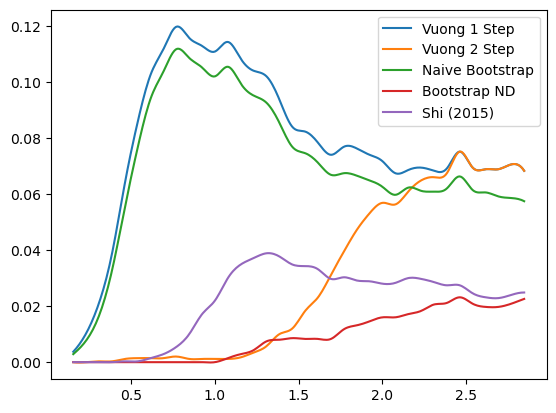

0.001 4.641588833612778


In [9]:
nobs =100
data_tuned_c = .9
calc_c =lambda nobs: (nobs**(-1/2)/100,nobs**(1/3) )
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

Quantiles: 1th: 0.55, 5th: 3.46, 10th: 10.87, 30th: 96.79, 50th: 295.68, 70th: 718.62, 90th: 1846.12, 95th: 2647.18, 99th: 4605.78
bonus term 2.792433076184326 // variance stats 1.2225050775630792 //part1 4.641588833612778 //part2 0.6016114688923958
1.9728847936373313 -0.3420381237036898 3.5934494793325613
-3.6119813587313208 -0.3420381237036898 -1.9914166730360907
---
Quantiles: 1th: 0.65, 5th: 3.88, 10th: 11.97, 30th: 107.07, 50th: 304.88, 70th: 732.88, 90th: 1808.80, 95th: 2552.74, 99th: 4493.16
bonus term 2.2684263626680203 // variance stats 1.8923162940950151 //part1 4.641588833612778 //part2 0.48871764475148305
1.2861273328859133 -0.15495259907520367 3.2759517539071643
-3.250725392450127 -0.15495259907520367 -1.2609009714288766
---
Quantiles: 1th: 0.49, 5th: 3.53, 10th: 9.42, 30th: 76.00, 50th: 227.46, 70th: 515.09, 90th: 1274.08, 95th: 1796.26, 99th: 3185.69
bonus term 1.8635621540533973 // variance stats 1.8992812239577843 //part1 4.641588833612778 //part2 0.4014922951723181
0.

1.4899868640221114 -0.2839423924175204 3.2923518671881262
-3.3333959163459927 -0.2839423924175204 -1.531030913179978
---
Quantiles: 1th: 0.84, 5th: 4.96, 10th: 15.07, 30th: 120.52, 50th: 374.94, 70th: 865.94, 90th: 2211.45, 95th: 3115.95, 99th: 5120.26
bonus term 1.743486429765062 // variance stats 3.675969176783501 //part1 4.641588833612778 //part2 0.37562276458856875
0.5449937883033463 0.18061251320856095 3.0068984818390145
-2.941979071226778 0.18061251320856095 -0.48007437769110967
---
Quantiles: 1th: 0.54, 5th: 4.73, 10th: 15.85, 30th: 146.63, 50th: 451.20, 70th: 1070.48, 90th: 2700.02, 95th: 3874.54, 99th: 6934.33
bonus term 3.024024576372874 // variance stats 1.4442519444099582 //part1 4.641588833612778 //part2 0.6515063450846692
2.3119296429064473 -0.299293930146917 3.7428216211970273
-3.736119509839301 -0.299293930146917 -2.305227531548721
---
Quantiles: 1th: 0.37, 5th: 1.90, 10th: 4.87, 30th: 44.68, 50th: 137.40, 70th: 327.18, 90th: 809.82, 95th: 1147.63, 99th: 1949.43
bonus t

Quantiles: 1th: 0.78, 5th: 4.06, 10th: 11.23, 30th: 93.72, 50th: 259.22, 70th: 626.04, 90th: 1521.55, 95th: 2121.50, 99th: 3704.37
bonus term 1.5493264874944817 // variance stats 3.036829768221054 //part1 4.641588833612778 //part2 0.3337922730843361
0.3117549240208069 0.16961781361760683 2.9025325304485374
-2.7868980509681567 0.16961781361760683 -0.19612044454042568
---
Quantiles: 1th: 0.45, 5th: 3.09, 10th: 9.64, 30th: 81.61, 50th: 245.73, 70th: 599.53, 90th: 1576.77, 95th: 2195.85, 99th: 3609.38
bonus term 1.8209296989497712 // variance stats 2.44245162853761 //part1 4.641588833612778 //part2 0.3923074111526702
0.5803401258272153 -0.025990169405700522 3.0695175456515247
-3.061519272072327 -0.025990169405700522 -0.5723418522480178
---
Quantiles: 1th: 0.37, 5th: 2.34, 10th: 6.52, 30th: 51.94, 50th: 157.56, 70th: 367.41, 90th: 896.97, 95th: 1288.94, 99th: 2280.64
bonus term 1.4676874056429077 // variance stats 1.9397179123454784 //part1 4.641588833612778 //part2 0.31620366608399775
0.15

2.0879276887922003 -0.4094726526703358 3.5674823425485376
-3.598196289679628 -0.4094726526703358 -2.1186416359232907
---
Quantiles: 1th: 0.49, 5th: 4.13, 10th: 11.96, 30th: 96.42, 50th: 291.87, 70th: 679.49, 90th: 1727.03, 95th: 2533.08, 99th: 4268.48
bonus term 1.909127119561732 // variance stats 2.4718270160353875 //part1 4.641588833612778 //part2 0.4113089694064444
0.8339713304709979 0.001709327595994601 3.061894551914405
-2.984282908652466 0.001709327595994601 -0.7563596872090593
---
Quantiles: 1th: 0.67, 5th: 4.91, 10th: 13.03, 30th: 105.91, 50th: 321.86, 70th: 811.46, 90th: 2055.39, 95th: 2960.43, 99th: 4813.89
bonus term 1.2096616269161924 // variance stats 5.831339907062115 //part1 4.641588833612778 //part2 0.26061369722286515
-0.24354846546571796 0.5863974526396425 2.8449314860478823
-2.6628717192981024 0.5863974526396425 0.42560823221549765
---
Quantiles: 1th: 0.27, 5th: 1.80, 10th: 6.19, 30th: 60.66, 50th: 186.70, 70th: 419.06, 90th: 1081.31, 95th: 1527.82, 99th: 2706.33
bon

Quantiles: 1th: 0.62, 5th: 3.73, 10th: 10.02, 30th: 80.71, 50th: 235.90, 70th: 570.71, 90th: 1442.17, 95th: 2007.97, 99th: 3594.42
bonus term 2.8977536005335085 // variance stats 0.8678844912310621 //part1 4.641588833612778 //part2 0.6243020880154184
2.1495729439931353 -0.5186434769649264 3.599231128676532
-3.6459342570738817 -0.5186434769649264 -2.196276072390485
---
Quantiles: 1th: 0.49, 5th: 3.95, 10th: 10.91, 30th: 89.79, 50th: 269.64, 70th: 627.86, 90th: 1588.31, 95th: 2242.04, 99th: 3985.18
bonus term 1.6998656356728181 // variance stats 2.748673329413611 //part1 4.641588833612778 //part2 0.36622494938866196
0.3972222172128874 0.048004876704570765 2.9965374617839164
-3.0025090541327484 0.048004876704570765 -0.40319380956171974
---
Quantiles: 1th: 0.63, 5th: 3.79, 10th: 10.82, 30th: 95.26, 50th: 281.03, 70th: 619.38, 90th: 1584.42, 95th: 2364.07, 99th: 3998.86
bonus term 2.341746802191929 // variance stats 1.5560699207955115 //part1 4.641588833612778 //part2 0.5045140545913523
1.3

0.3184603281666584 0.10152326758503716 2.8566038898809976
-2.864774226422319 0.10152326758503716 -0.3266306647079797
---
Quantiles: 1th: 0.65, 5th: 4.13, 10th: 12.34, 30th: 93.64, 50th: 269.19, 70th: 643.02, 90th: 1607.03, 95th: 2276.01, 99th: 3842.08
bonus term 1.4335418325450582 // variance stats 3.596287717394827 //part1 4.641588833612778 //part2 0.3088472253646951
0.11342706689602991 0.19921719517376382 2.7358304341709516
-2.7536565981940866 0.19921719517376382 -0.1312532309191648
---
Quantiles: 1th: 0.58, 5th: 3.24, 10th: 9.11, 30th: 79.61, 50th: 253.79, 70th: 582.28, 90th: 1428.26, 95th: 1997.22, 99th: 3420.28
bonus term 2.8070786752752057 // variance stats 0.9334121765830725 //part1 4.641588833612778 //part2 0.6047667675661649
2.0319776330831316 -0.4685424292263057 3.6044220381773564
-3.58217971746728 -0.4685424292263057 -2.009735312373055
---
Quantiles: 1th: 0.39, 5th: 2.97, 10th: 9.70, 30th: 78.38, 50th: 237.98, 70th: 548.17, 90th: 1417.39, 95th: 2055.30, 99th: 3610.87
bonus t

Quantiles: 1th: 0.52, 5th: 3.99, 10th: 14.82, 30th: 120.88, 50th: 360.00, 70th: 860.98, 90th: 2100.87, 95th: 3059.56, 99th: 5460.09
bonus term 3.0412587144020047 // variance stats 1.1054926580906357 //part1 4.641588833612778 //part2 0.6552193275669448
2.3760671653253316 -0.844359713310396 3.721598600976585
-3.706450263478678 -0.844359713310396 -2.3609188278274242
---
Quantiles: 1th: 0.54, 5th: 3.75, 10th: 9.84, 30th: 95.39, 50th: 287.74, 70th: 658.10, 90th: 1691.85, 95th: 2456.28, 99th: 4085.87
bonus term 2.2127480419656487 // variance stats 1.8570757560446127 //part1 4.641588833612778 //part2 0.47672211419109206
1.139523076133342 -0.19399410671303646 3.189121128953041
-3.2859730077979554 -0.19399410671303646 -1.2363749549782568
---
Quantiles: 1th: 0.48, 5th: 2.77, 10th: 8.23, 30th: 65.23, 50th: 198.24, 70th: 481.41, 90th: 1153.70, 95th: 1613.70, 99th: 2755.81
bonus term 3.604343491475945 // variance stats 0.3320068266972957 //part1 4.641588833612778 //part2 0.7765322652826416
3.157487

1.8175299917327274 -0.41192356480148345 3.552155829154687
-3.4852521707217945 -0.41192356480148345 -1.7506263332998346
---
Quantiles: 1th: 0.61, 5th: 3.53, 10th: 12.24, 30th: 107.19, 50th: 317.37, 70th: 730.17, 90th: 1874.18, 95th: 2627.90, 99th: 4611.90
bonus term 3.5103441609087422 // variance stats 0.6039728372339368 //part1 4.641588833612778 //part2 0.7562807234212661
3.0435934078790106 -0.6623919700332727 3.9592363437669333
-3.977094913938474 -0.6623919700332727 -3.061451978050551
---
Quantiles: 1th: 0.58, 5th: 5.20, 10th: 15.20, 30th: 118.06, 50th: 364.12, 70th: 884.94, 90th: 2397.88, 95th: 3305.70, 99th: 5868.84
bonus term 2.971561817024703 // variance stats 1.3476185344661447 //part1 4.641588833612778 //part2 0.6402035862172197
2.294653182251394 -0.418677376679725 3.7011243331533374
-3.648470451798012 -0.418677376679725 -2.2419993008960684
---
Quantiles: 1th: 0.58, 5th: 3.53, 10th: 10.49, 30th: 89.50, 50th: 274.75, 70th: 645.59, 90th: 1642.44, 95th: 2300.83, 99th: 3933.13
bonus

Quantiles: 1th: 0.38, 5th: 2.27, 10th: 6.22, 30th: 45.62, 50th: 140.53, 70th: 331.16, 90th: 793.49, 95th: 1133.61, 99th: 1983.13
bonus term 1.199451341497345 // variance stats 2.277125410090897 //part1 4.641588833612778 //part2 0.258413957912716
-0.38153413812593256 -0.2844323753535366 2.5936177300331895
-2.7804368211206225 -0.2844323753535366 0.19471504703849982
---
Quantiles: 1th: 0.58, 5th: 3.41, 10th: 8.97, 30th: 78.04, 50th: 244.05, 70th: 582.35, 90th: 1426.03, 95th: 1963.95, 99th: 3253.78
bonus term 2.2476063427133695 // variance stats 1.5189024698761868 //part1 4.641588833612778 //part2 0.4842321074277374
1.1954959744047693 -1.0086392354417388 3.334185950835988
-3.29971671102197 -1.0086392354417388 -1.1610267345907512
---
Quantiles: 1th: 0.51, 5th: 4.34, 10th: 14.30, 30th: 121.13, 50th: 356.75, 70th: 842.34, 90th: 2229.44, 95th: 3185.56, 99th: 5229.52
bonus term 3.6729265812727356 // variance stats 0.5879704587804406 //part1 4.641588833612778 //part2 0.7913080440634194
3.2839992

2.681292406904895 -1.4579903701321035 3.846001897391719
-3.874602010315123 -1.4579903701321035 -2.709892519828299
---
Quantiles: 1th: 0.67, 5th: 4.17, 10th: 12.13, 30th: 114.13, 50th: 338.91, 70th: 781.18, 90th: 1987.06, 95th: 2805.09, 99th: 5199.84
bonus term 2.452250252447784 // variance stats 1.7740186403976388 //part1 4.641588833612778 //part2 0.5283213012512952
1.519259357145179 -0.48332901058999506 3.3422720851428354
-3.3852411477503885 -0.48332901058999506 -1.5622284197527323
---
Quantiles: 1th: 0.42, 5th: 2.95, 10th: 7.70, 30th: 69.85, 50th: 226.39, 70th: 529.37, 90th: 1381.99, 95th: 1912.83, 99th: 3182.39
bonus term 2.793789792600605 // variance stats 0.914043595165972 //part1 4.641588833612778 //part2 0.6019037645835726
2.0751645095921174 -0.9238599426390792 3.548649969554216
-3.5124150756090926 -0.9238599426390792 -2.038929615646994
---
Quantiles: 1th: 0.70, 5th: 4.80, 10th: 12.90, 30th: 115.18, 50th: 345.93, 70th: 834.38, 90th: 2073.74, 95th: 2838.28, 99th: 5008.31
bonus te

Quantiles: 1th: 0.64, 5th: 3.54, 10th: 9.08, 30th: 71.28, 50th: 221.67, 70th: 519.97, 90th: 1284.06, 95th: 1820.98, 99th: 3405.62
bonus term 2.9485423305121783 // variance stats 0.7373019351593366 //part1 4.641588833612778 //part2 0.6352441881882893
2.253021034448169 -1.531934090671681 3.6227006605564034
-3.6440636265761874 -1.531934090671681 -2.274384000467953
---
Quantiles: 1th: 0.41, 5th: 2.82, 10th: 8.15, 30th: 59.12, 50th: 176.40, 70th: 418.39, 90th: 1037.78, 95th: 1441.40, 99th: 2557.29
bonus term 0.7670684571199164 // variance stats 5.2418872885855645 //part1 4.641588833612778 //part2 0.16525988936483826
-0.8584125259926955 0.6976686322057345 2.4750791305564306
-2.3925494402325285 0.6976686322057345 0.9409422163165974
---
Quantiles: 1th: 0.68, 5th: 4.08, 10th: 13.19, 30th: 115.19, 50th: 353.12, 70th: 866.57, 90th: 2080.59, 95th: 3047.22, 99th: 5159.27
bonus term 3.426934089053874 // variance stats 0.7374508755596539 //part1 4.641588833612778 //part2 0.738310568191048
2.906847766

2.806857321922862 -1.2907282160304714 3.873787994260672
-3.9265246203978132 -1.2907282160304714 -2.859593948060003
---
Quantiles: 1th: 0.47, 5th: 2.78, 10th: 9.03, 30th: 88.15, 50th: 283.81, 70th: 688.72, 90th: 1684.10, 95th: 2436.66, 99th: 4134.59
bonus term 1.7123030959157588 // variance stats 2.8810320145881154 //part1 4.641588833612778 //part2 0.3689045189689903
0.45939786356036966 -0.49152603600793426 2.9279841930278967
-2.965208328271148 -0.49152603600793426 -0.4966219988036211
---
Quantiles: 1th: 0.67, 5th: 5.32, 10th: 18.92, 30th: 161.35, 50th: 487.66, 70th: 1140.24, 90th: 2795.69, 95th: 4000.27, 99th: 6746.78
bonus term 1.675694137436008 // variance stats 4.948229640212044 //part1 4.641588833612778 //part2 0.3610173579575191
0.3795954138006757 -0.11175331723857934 2.904032934176074
-2.97179286107134 -0.11175331723857934 -0.4473553406959419
---
Quantiles: 1th: 0.58, 5th: 3.53, 10th: 11.38, 30th: 106.73, 50th: 314.55, 70th: 746.04, 90th: 1867.10, 95th: 2634.22, 99th: 4610.83
bon

Quantiles: 1th: 0.49, 5th: 3.52, 10th: 13.09, 30th: 109.83, 50th: 326.28, 70th: 754.77, 90th: 1880.75, 95th: 2666.31, 99th: 4710.68
bonus term 3.0644978513703656 // variance stats 0.9678969329361533 //part1 4.641588833612778 //part2 0.6602260478520489
2.339141605623437 -1.6456147933998464 3.7422783874939736
-3.7898540971172943 -1.6456147933998464 -2.3867173152467576
---
Quantiles: 1th: 0.66, 5th: 4.43, 10th: 14.33, 30th: 121.76, 50th: 355.38, 70th: 818.82, 90th: 2049.33, 95th: 2924.44, 99th: 5139.55
bonus term 1.796476858760182 // variance stats 3.2455664403914533 //part1 4.641588833612778 //part2 0.3870392064352446
0.5655982366661182 -0.15799914913638385 2.935993770599599
-3.0273554808542458 -0.15799914913638385 -0.6569599469207652
---
Quantiles: 1th: 0.52, 5th: 4.20, 10th: 13.16, 30th: 118.11, 50th: 347.07, 70th: 816.72, 90th: 2148.03, 95th: 2925.24, 99th: 4723.16
bonus term 3.117395513499075 // variance stats 1.050241059326714 //part1 4.641588833612778 //part2 0.6716225036832165
2.5

2.1231615260295285 -1.9080445722955932 3.615419889651013
-3.6435491710560597 -1.9080445722955932 -2.151290807434575
---
Quantiles: 1th: 0.54, 5th: 4.10, 10th: 16.19, 30th: 128.20, 50th: 391.55, 70th: 881.25, 90th: 2258.20, 95th: 3249.59, 99th: 5734.79
bonus term 3.2397451062099827 // variance stats 0.9771294292498285 //part1 4.641588833612778 //part2 0.6979819243679817
2.6553583193029104 -1.2892209385735425 3.8340878669187557
-3.824131893117055 -1.2892209385735425 -2.6454023455012097
---
Quantiles: 1th: 0.69, 5th: 3.46, 10th: 10.88, 30th: 92.52, 50th: 288.25, 70th: 653.24, 90th: 1643.17, 95th: 2358.14, 99th: 4311.03
bonus term 1.1066801110380584 // variance stats 5.248552906432893 //part1 4.641588833612778 //part2 0.23842700219887303
-0.3848869672855478 0.3050731319927074 2.610790305982616
-2.5982471893616643 0.3050731319927074 0.3974300839064989
---
Quantiles: 1th: 0.35, 5th: 2.98, 10th: 10.18, 30th: 86.10, 50th: 251.61, 70th: 589.49, 90th: 1434.71, 95th: 2047.36, 99th: 3528.80
bonus 

0.4692727436591072 -0.5153451763371482 2.8804279081166757
-2.9635122117367745 -0.5153451763371482 -0.5523570472792061
---
Quantiles: 1th: 0.63, 5th: 3.67, 10th: 9.47, 30th: 76.83, 50th: 233.07, 70th: 555.89, 90th: 1316.07, 95th: 1899.92, 99th: 3268.70
bonus term 1.5949290197725543 // variance stats 2.5139758694859853 //part1 4.641588833612778 //part2 0.34361704083365396
0.25905007679312503 -1.0733294043211723 2.833206288315919
-2.9308079627519836 -1.0733294043211723 -0.35665175122918996
---
Quantiles: 1th: 0.59, 5th: 4.37, 10th: 12.97, 30th: 112.02, 50th: 324.46, 70th: 800.39, 90th: 1953.62, 95th: 2739.30, 99th: 4912.92
bonus term 2.0124806768228707 // variance stats 2.552207746142778 //part1 4.641588833612778 //part2 0.4335758183166037
0.9090166605645854 -0.7333719797330939 3.1047124953221505
-3.115944693081156 -0.7333719797330939 -0.9202488583235909
---
Quantiles: 1th: 0.34, 5th: 3.23, 10th: 11.07, 30th: 106.70, 50th: 313.03, 70th: 776.21, 90th: 2003.17, 95th: 2877.10, 99th: 4777.17


Quantiles: 1th: 0.49, 5th: 3.63, 10th: 11.02, 30th: 86.34, 50th: 255.24, 70th: 609.60, 90th: 1562.60, 95th: 2275.53, 99th: 3811.12
bonus term 1.5347679025443337 // variance stats 3.163155254157136 //part1 4.641588833612778 //part2 0.3306557210388986
0.19804345315407337 -0.805768694848356 2.8990041629175334
-2.871492351934594 -0.805768694848356 -0.17053164217113415
---
Quantiles: 1th: 0.84, 5th: 4.94, 10th: 17.65, 30th: 146.34, 50th: 449.48, 70th: 1041.48, 90th: 2715.41, 95th: 3829.57, 99th: 6645.41
bonus term 3.384965273804153 // variance stats 1.0080600425709851 //part1 4.641588833612778 //part2 0.7292686610436941
2.8869970575372235 -1.684047222961492 3.9347150222147778
-3.8829334900710823 -1.684047222961492 -2.835215525393528
---
Quantiles: 1th: 0.77, 5th: 4.76, 10th: 13.02, 30th: 122.70, 50th: 403.36, 70th: 960.27, 90th: 2430.10, 95th: 3503.16, 99th: 6394.56
bonus term 1.7534393392774705 // variance stats 4.002692851976494 //part1 4.641588833612778 //part2 0.37776705394059684
0.5668

0.30633310685773457 -0.3460561034894762 2.717773282536514
-2.797091268419648 -0.3460561034894762 -0.38565109274086823
---
Quantiles: 1th: 0.44, 5th: 2.78, 10th: 7.77, 30th: 66.57, 50th: 196.81, 70th: 466.33, 90th: 1137.48, 95th: 1587.73, 99th: 2761.38
bonus term 1.7293894885750072 // variance stats 1.9154574762295287 //part1 4.641588833612778 //part2 0.3725856706762494
0.4976044167192657 -1.5523947926991755 2.9732176870485465
-2.9611745604307487 -1.5523947926991755 -0.4855612901014682
---
Quantiles: 1th: 0.58, 5th: 3.44, 10th: 9.74, 30th: 83.32, 50th: 251.38, 70th: 621.12, 90th: 1600.16, 95th: 2234.03, 99th: 3722.32
bonus term 2.9616515350567494 // variance stats 0.9076581452048339 //part1 4.641588833612778 //part2 0.6380684806912441
2.218097136681653 -2.1039844382287143 3.6448135517930744
-3.705205933431846 -2.1039844382287143 -2.2784895183204243
---
Quantiles: 1th: 0.63, 5th: 4.36, 10th: 13.20, 30th: 116.75, 50th: 337.30, 70th: 772.81, 90th: 2022.28, 95th: 2801.07, 99th: 4689.59
bonu

Quantiles: 1th: 0.42, 5th: 3.39, 10th: 10.48, 30th: 88.48, 50th: 285.63, 70th: 685.94, 90th: 1809.52, 95th: 2509.31, 99th: 4145.01
bonus term 2.698412011345722 // variance stats 1.3030720546221533 //part1 4.641588833612778 //part2 0.5813552445241933
1.9438292279051073 -2.341056288285256 3.5249067689616567
-3.4529947947863366 -2.341056288285256 -1.871917253729787
---
Quantiles: 1th: 0.35, 5th: 2.75, 10th: 9.15, 30th: 87.10, 50th: 273.09, 70th: 626.02, 90th: 1577.04, 95th: 2175.17, 99th: 3729.13
bonus term 1.4265609762229732 // variance stats 3.554169670652262 //part1 4.641588833612778 //part2 0.30734324546205233
-0.06418525366552648 -0.45757494167266005 2.844822246742118
-2.9173072061114724 -0.45757494167266005 -0.008299705703827934
---
Quantiles: 1th: 0.49, 5th: 2.82, 10th: 8.68, 30th: 76.52, 50th: 231.60, 70th: 556.58, 90th: 1372.37, 95th: 1998.63, 99th: 3347.13
bonus term 2.448073536734992 // variance stats 1.2296686620316866 //part1 4.641588833612778 //part2 0.5274214551290911
1.594

-0.22671804145354282 -0.33441833432376017 2.7002840271129087
-2.7192989287637888 -0.33441833432376017 0.20770313980266242
---
Quantiles: 1th: 0.54, 5th: 3.48, 10th: 10.27, 30th: 83.18, 50th: 253.21, 70th: 583.35, 90th: 1477.56, 95th: 2020.05, 99th: 3473.75
bonus term 2.533364569771609 // variance stats 1.2296051701601873 //part1 4.641588833612778 //part2 0.5457968511613653
1.632459684714462 -2.1983710071164015 3.479819459335133
-3.4342694548287565 -2.1983710071164015 -1.5869096802080853
---
Quantiles: 1th: 0.58, 5th: 4.48, 10th: 15.02, 30th: 132.33, 50th: 419.23, 70th: 979.15, 90th: 2508.73, 95th: 3432.82, 99th: 6082.71
bonus term 2.592268039266043 // variance stats 1.9832781272496642 //part1 4.641588833612778 //part2 0.5584872189655697
1.7211909618789745 -1.7058842605792426 3.4035441439649783
-3.463345116653112 -1.7058842605792426 -1.7809919345671081
---
Quantiles: 1th: 0.44, 5th: 3.02, 10th: 8.89, 30th: 75.97, 50th: 236.21, 70th: 543.47, 90th: 1390.37, 95th: 1916.66, 99th: 3275.19
bo

Quantiles: 1th: 0.75, 5th: 5.36, 10th: 17.49, 30th: 145.72, 50th: 465.30, 70th: 1072.31, 90th: 2600.92, 95th: 3622.92, 99th: 6524.70
bonus term 2.301874549355635 // variance stats 2.6436760454473336 //part1 4.641588833612778 //part2 0.495923838123329
1.2685981768610648 -1.6970022004170353 3.22278929462639
-3.335150921850205 -1.6970022004170353 -1.3809598040848798
---
Quantiles: 1th: 0.52, 5th: 3.30, 10th: 9.40, 30th: 77.70, 50th: 229.42, 70th: 540.55, 90th: 1491.31, 95th: 2075.69, 99th: 3622.49
bonus term 2.211781771911929 // variance stats 1.6383116188362445 //part1 4.641588833612778 //part2 0.47651393761872474
1.0720366635625629 -2.49737797230183 3.170058401044177
-3.3515268802612947 -2.49737797230183 -1.2535051427796806
---
Quantiles: 1th: 0.43, 5th: 2.50, 10th: 7.90, 30th: 69.77, 50th: 212.27, 70th: 494.25, 90th: 1251.75, 95th: 1784.05, 99th: 3018.49
bonus term 1.5342768958324122 // variance stats 2.5351155081640515 //part1 4.641588833612778 //part2 0.33054993684957845
0.2606023784

2.2617515309348764 -2.84133034093382 3.5762025622655256
-3.6185776484214185 -2.84133034093382 -2.3041266170907693
---
Quantiles: 1th: 0.44, 5th: 4.56, 10th: 15.59, 30th: 116.76, 50th: 350.88, 70th: 804.02, 90th: 2056.00, 95th: 2952.63, 99th: 4956.93
bonus term 2.5055772320378256 // variance stats 1.752744576918315 //part1 4.641588833612778 //part2 0.5398102507256358
1.6923948021242292 -2.2848943782638798 3.3680645103512474
-3.318759661951422 -2.2848943782638798 -1.6430899537244037
---
Quantiles: 1th: 0.64, 5th: 4.30, 10th: 14.86, 30th: 108.41, 50th: 327.85, 70th: 785.63, 90th: 1998.86, 95th: 2799.18, 99th: 4967.61
bonus term 2.3763830408200164 // variance stats 1.9053488091865034 //part1 4.641588833612778 //part2 0.5119762059946098
1.397081704663787 -2.142775143014374 3.270417967399697
-3.355684376976246 -2.142775143014374 -1.4823481142403359
---
Quantiles: 1th: 0.43, 5th: 3.15, 10th: 10.00, 30th: 91.27, 50th: 267.37, 70th: 622.17, 90th: 1640.10, 95th: 2399.93, 99th: 4144.74
bonus term

Quantiles: 1th: 0.43, 5th: 2.50, 10th: 8.14, 30th: 61.94, 50th: 179.57, 70th: 412.89, 90th: 1052.99, 95th: 1508.83, 99th: 2573.20
bonus term 1.4808264088718461 // variance stats 2.247553456858586 //part1 4.641588833612778 //part2 0.3190343785188844
0.08527544613106296 -2.1332108499520754 2.7727590994148463
-2.8763773716126293 -2.1332108499520754 -0.18889371832884597
---
Quantiles: 1th: 0.46, 5th: 3.16, 10th: 8.85, 30th: 80.19, 50th: 224.73, 70th: 533.97, 90th: 1356.32, 95th: 1884.65, 99th: 3294.21
bonus term 2.494141987202362 // variance stats 1.1677860111084517 //part1 4.641588833612778 //part2 0.5373466019093828
1.5346362773617093 -2.71082944262249 3.38971254566072
-3.453647697043015 -2.71082944262249 -1.598571428744004
---
Quantiles: 1th: 0.74, 5th: 4.73, 10th: 14.98, 30th: 129.49, 50th: 370.92, 70th: 868.62, 90th: 2070.00, 95th: 3052.67, 99th: 4933.37
bonus term 1.9028792915638981 // variance stats 2.9792353446838407 //part1 4.641588833612778 //part2 0.4099629156688558
0.8070953405

1.260408965940135 -2.263795649392608 3.234663603834326
-3.329815066211088 -2.263795649392608 -1.355560428316897
---
Quantiles: 1th: 0.50, 5th: 4.34, 10th: 13.96, 30th: 106.12, 50th: 308.06, 70th: 733.42, 90th: 1868.81, 95th: 2628.99, 99th: 4561.24
bonus term 2.67057783710933 // variance stats 1.3792682080357677 //part1 4.641588833612778 //part2 0.575358553469866
1.8300384239645549 -3.0169137358258458 3.49236284176414
-3.511117250254105 -3.0169137358258458 -1.8487928324545202
---
Quantiles: 1th: 0.51, 5th: 2.94, 10th: 10.28, 30th: 87.60, 50th: 269.06, 70th: 621.45, 90th: 1493.56, 95th: 2136.69, 99th: 3511.30
bonus term 1.6259821128525076 // variance stats 2.7700037973856997 //part1 4.641588833612778 //part2 0.350307226930078
0.036747897510588635 -3.115163294430618 2.897603443402276
-3.2152163281944266 -3.115163294430618 -0.3543607823027388
---
Quantiles: 1th: 0.43, 5th: 3.08, 10th: 9.55, 30th: 81.54, 50th: 248.16, 70th: 576.27, 90th: 1412.23, 95th: 1997.08, 99th: 3579.96
bonus term 2.24

Quantiles: 1th: 0.42, 5th: 2.94, 10th: 11.34, 30th: 94.51, 50th: 291.50, 70th: 683.02, 90th: 1711.47, 95th: 2458.37, 99th: 4337.90
bonus term 2.1245975516654765 // variance stats 2.0275639067672993 //part1 4.641588833612778 //part2 0.45773066676649105
0.9981558458713037 -2.648051420197952 3.170330820885764
-3.251039257459649 -2.648051420197952 -1.0788642824451888
---
Quantiles: 1th: 0.81, 5th: 5.65, 10th: 16.63, 30th: 141.36, 50th: 435.76, 70th: 1016.41, 90th: 2533.57, 95th: 3523.69, 99th: 6379.78
bonus term 2.616181465460588 // variance stats 1.9614487374881953 //part1 4.641588833612778 //part2 0.5636392104606741
1.8198194389926998 -2.573471807767249 3.5067504066390938
-3.412543491928476 -2.573471807767249 -1.7256125242820821
---
Quantiles: 1th: 0.75, 5th: 4.28, 10th: 14.43, 30th: 117.58, 50th: 364.60, 70th: 887.00, 90th: 2251.82, 95th: 3151.82, 99th: 5456.97
bonus term 2.8074317015804713 // variance stats 1.4711623415827721 //part1 4.641588833612778 //part2 0.6048428247780208
1.98316

0.7444697793708606 -2.642723024085019 3.0318145378332946
-3.0755561141278824 -2.642723024085019 -0.7882113556654488
---
Quantiles: 1th: 0.48, 5th: 3.25, 10th: 10.91, 30th: 94.10, 50th: 285.43, 70th: 697.30, 90th: 1761.46, 95th: 2554.06, 99th: 4492.96
bonus term 1.1546435159288981 // variance stats 5.319480419269327 //part1 4.641588833612778 //part2 0.24876040453376005
-0.3036420873758685 -0.9802653729411872 2.686426530021946
-2.612929119233665 -0.9802653729411872 0.37713949816414977
---
Quantiles: 1th: 0.35, 5th: 2.54, 10th: 6.89, 30th: 64.68, 50th: 212.73, 70th: 473.26, 90th: 1208.36, 95th: 1768.32, 99th: 2953.12
bonus term 1.6231019804542386 // variance stats 2.247196227405319 //part1 4.641588833612778 //part2 0.34968672121500644
0.3448184501906295 -3.7064843729585157 2.8482441818167534
-2.9013855107178474 -3.7064843729585157 -0.3979597790917241
---
Quantiles: 1th: 0.67, 5th: 4.74, 10th: 14.24, 30th: 134.73, 50th: 398.70, 70th: 939.23, 90th: 2419.28, 95th: 3439.24, 99th: 6243.70
bonu

Quantiles: 1th: 0.70, 5th: 3.96, 10th: 14.22, 30th: 137.58, 50th: 432.21, 70th: 1024.56, 90th: 2502.41, 95th: 3522.57, 99th: 5970.71
bonus term 1.2644920448850303 // variance stats 6.6832108990689045 //part1 4.641588833612778 //part2 0.27242655267696636
-0.21925426361120404 -0.3269215326542152 2.8272585104928076
-2.748238353381265 -0.3269215326542152 0.29827442072274685
---
Quantiles: 1th: 0.53, 5th: 3.16, 10th: 8.69, 30th: 68.30, 50th: 224.27, 70th: 523.49, 90th: 1299.77, 95th: 1841.70, 99th: 3030.22
bonus term 1.1965878126533611 // variance stats 3.7420507416709277 //part1 4.641588833612778 //part2 0.25779702932497744
-0.36845502361940663 -2.4001129864519553 2.5804812305804545
-2.761630648926129 -2.4001129864519553 0.18730560527373258
---
Quantiles: 1th: 0.47, 5th: 3.17, 10th: 11.33, 30th: 99.37, 50th: 309.28, 70th: 697.79, 90th: 1814.78, 95th: 2678.15, 99th: 4695.36
bonus term 1.9730905690340987 // variance stats 2.4543866465315385 //part1 4.641588833612778 //part2 0.425089476850181

1.6447612716838553 -3.7085913445355874 3.3955767018725704
-3.4887524519505226 -3.7085913445355874 -1.7379370217618073
---
Quantiles: 1th: 0.97, 5th: 4.95, 10th: 15.06, 30th: 133.01, 50th: 382.80, 70th: 896.69, 90th: 2311.13, 95th: 3401.97, 99th: 6031.35
bonus term 1.9455180126602791 // variance stats 3.2027313298334383 //part1 4.641588833612778 //part2 0.41914914965571953
0.7957851634888025 -2.3298917527773084 3.0882189488631213
-3.095250861831756 -2.3298917527773084 -0.8028170764574368
---
Quantiles: 1th: 0.59, 5th: 3.58, 10th: 9.90, 30th: 80.35, 50th: 246.06, 70th: 591.87, 90th: 1480.88, 95th: 2097.02, 99th: 3594.53
bonus term 2.139618100532952 // variance stats 1.7316772208986693 //part1 4.641588833612778 //part2 0.4609667459208319
1.0732339950739291 -4.518747439390316 3.1303766453289867
-3.2060022059919753 -4.518747439390316 -1.1488595557369174
---
Quantiles: 1th: 0.68, 5th: 4.65, 10th: 14.25, 30th: 128.80, 50th: 388.23, 70th: 910.75, 90th: 2256.43, 95th: 3230.49, 99th: 5881.55
bon

Quantiles: 1th: 0.43, 5th: 3.44, 10th: 10.22, 30th: 86.04, 50th: 265.19, 70th: 642.40, 90th: 1650.50, 95th: 2285.01, 99th: 3785.61
bonus term 2.336889371393382 // variance stats 1.6277622152464057 //part1 4.641588833612778 //part2 0.5034675528496705
1.2377632078698104 -4.155041817291337 3.396809150078516
-3.4360155349169537 -4.155041817291337 -1.276969592708248
---
Quantiles: 1th: 0.52, 5th: 2.75, 10th: 9.08, 30th: 76.94, 50th: 232.05, 70th: 543.38, 90th: 1380.59, 95th: 1962.26, 99th: 3249.43
bonus term 2.1800399691927517 // variance stats 1.558864573839156 //part1 4.641588833612778 //part2 0.4696753735284903
0.9028647714648587 -5.052389685515032 3.237199876091971
-3.4572151669206446 -5.052389685515032 -1.1228800622935324
---
Quantiles: 1th: 0.45, 5th: 3.67, 10th: 11.19, 30th: 101.62, 50th: 318.99, 70th: 742.12, 90th: 1896.52, 95th: 2728.22, 99th: 4923.54
bonus term 1.3264662641595508 // variance stats 4.739812228331018 //part1 4.641588833612778 //part2 0.2857784934662333
-0.1746193902

1.2069060410576005 -3.973661398818377 3.1441991946736794
-3.2547678018741384 -3.973661398818377 -1.3174746482580595
---
Quantiles: 1th: 0.61, 5th: 5.04, 10th: 15.81, 30th: 141.93, 50th: 447.91, 70th: 1111.36, 90th: 2753.36, 95th: 3874.96, 99th: 6380.93
bonus term 2.4003348720309496 // variance stats 2.570878252619917 //part1 4.641588833612778 //part2 0.5171364715996721
1.361099418180561 -3.1212720922646717 3.292424009019054
-3.4395703258813386 -3.1212720922646717 -1.5082457350428455
---
Quantiles: 1th: 0.68, 5th: 4.81, 10th: 15.01, 30th: 123.56, 50th: 371.37, 70th: 864.31, 90th: 2240.63, 95th: 3253.70, 99th: 5366.65
bonus term 2.103183301168934 // variance stats 2.7042901548159164 //part1 4.641588833612778 //part2 0.4531171063534126
0.9748848947826012 -3.3374774564919827 3.191487756301381
-3.2314817075552664 -3.3374774564919827 -1.0148788460364868
---
Quantiles: 1th: 0.55, 5th: 4.40, 10th: 14.13, 30th: 139.11, 50th: 404.63, 70th: 924.90, 90th: 2252.02, 95th: 3200.10, 99th: 5348.42
bonu

Quantiles: 1th: 0.52, 5th: 3.67, 10th: 12.71, 30th: 105.37, 50th: 313.74, 70th: 754.09, 90th: 1895.33, 95th: 2653.38, 99th: 4418.89
bonus term 2.2734460173630104 // variance stats 1.974273165128076 //part1 4.641588833612778 //part2 0.48979909657216986
1.10623131620866 -4.1511758592456385 3.3009189843208335
-3.4406607185173606 -4.1511758592456385 -1.2459730504051876
---
Quantiles: 1th: 0.57, 5th: 4.73, 10th: 12.75, 30th: 105.31, 50th: 320.35, 70th: 736.09, 90th: 1829.67, 95th: 2665.28, 99th: 4683.32
bonus term 1.7810837760909108 // variance stats 2.9385321382039513 //part1 4.641588833612778 //part2 0.3837228673063239
0.4837974829494877 -3.148840526653694 2.9480308464031633
-3.078370069232334 -3.148840526653694 -0.6141367057786585
---
Quantiles: 1th: 0.72, 5th: 3.59, 10th: 11.60, 30th: 97.92, 50th: 303.72, 70th: 715.76, 90th: 1815.12, 95th: 2528.41, 99th: 4540.44
bonus term 1.1504667307909784 // variance stats 5.508035215853819 //part1 4.641588833612778 //part2 0.24786054345436567
-0.393

-0.21687462193408902 -2.4566430200520077 2.678576483169345
-2.6831692942298178 -2.4566430200520077 0.21228181087361678
---
Quantiles: 1th: 0.53, 5th: 4.68, 10th: 16.61, 30th: 152.97, 50th: 464.55, 70th: 1095.70, 90th: 2782.30, 95th: 3918.26, 99th: 6907.69
bonus term 1.4589977572811896 // variance stats 6.0691829181412995 //part1 4.641588833612778 //part2 0.3143315380965313
0.04853185525874657 -1.352325090400925 2.767431483271279
-2.8694636593036327 -1.352325090400925 -0.15056403129109988
---
Quantiles: 1th: 0.40, 5th: 2.78, 10th: 8.53, 30th: 65.27, 50th: 196.26, 70th: 457.44, 90th: 1140.09, 95th: 1642.32, 99th: 2996.84
bonus term 1.6418379734762392 // variance stats 2.0830247298602598 //part1 4.641588833612778 //part2 0.3537232685468858
0.1855857797400792 -4.8001298094643365 2.979306140733689
-3.098090167212399 -4.8001298094643365 -0.3043698062187896
---
Quantiles: 1th: 0.51, 5th: 2.91, 10th: 10.26, 30th: 84.99, 50th: 252.28, 70th: 604.73, 90th: 1555.92, 95th: 2212.63, 99th: 3873.97
bo

Quantiles: 1th: 0.66, 5th: 4.98, 10th: 15.33, 30th: 114.78, 50th: 354.89, 70th: 838.19, 90th: 2184.86, 95th: 3102.67, 99th: 5415.42
bonus term 2.3034331675682727 // variance stats 2.2177932666209834 //part1 4.641588833612778 //part2 0.49625963223791125
1.2974066154790884 -3.7678711911270066 3.167345862083644
-3.309459719657457 -3.7678711911270066 -1.4395204730529014
---
Quantiles: 1th: 0.43, 5th: 3.73, 10th: 12.52, 30th: 102.91, 50th: 306.13, 70th: 712.07, 90th: 1756.33, 95th: 2505.18, 99th: 4666.75
bonus term 2.170079717222443 // variance stats 2.0002831276453588 //part1 4.641588833612778 //part2 0.4675295022918613
1.1142069685298133 -5.220151018274155 3.1326531963750255
-3.2259524659150727 -5.220151018274155 -1.207506238069861
---
Quantiles: 1th: 0.57, 5th: 3.92, 10th: 10.49, 30th: 81.23, 50th: 238.71, 70th: 582.48, 90th: 1485.38, 95th: 2119.57, 99th: 3680.39
bonus term 1.9881456899972465 // variance stats 1.9824366513366825 //part1 4.641588833612778 //part2 0.42833300433674437
0.805

2.2071747683658587 -3.7980469006576114 3.5913489993268866
-3.6246826737075915 -3.7980469006576114 -2.2405084427465636
---
Quantiles: 1th: 0.61, 5th: 4.51, 10th: 11.14, 30th: 92.94, 50th: 283.79, 70th: 656.75, 90th: 1618.50, 95th: 2318.55, 99th: 4170.00
bonus term 1.5533550861615533 // variance stats 3.217748700759537 //part1 4.641588833612778 //part2 0.33466020835639165
0.28184216951796787 -3.8508970511955827 2.7935618204520973
-2.8248680028051387 -3.8508970511955827 -0.3131483518710092
---
Quantiles: 1th: 0.52, 5th: 3.29, 10th: 8.82, 30th: 69.55, 50th: 202.52, 70th: 466.15, 90th: 1171.91, 95th: 1629.32, 99th: 2900.12
bonus term 1.2309869724083666 // variance stats 3.246913046482646 //part1 4.641588833612778 //part2 0.26520810363339065
-0.35305181123431323 -4.595676972866109 2.708511820388094
-2.8150257560510465 -4.595676972866109 0.24653787557136114
---
Quantiles: 1th: 0.40, 5th: 3.15, 10th: 10.34, 30th: 92.34, 50th: 279.37, 70th: 646.29, 90th: 1696.74, 95th: 2381.03, 99th: 4218.77
bo

Quantiles: 1th: 0.78, 5th: 6.17, 10th: 19.85, 30th: 164.80, 50th: 525.54, 70th: 1149.11, 90th: 2812.47, 95th: 4199.73, 99th: 7295.56
bonus term 1.506448447269702 // variance stats 5.853156042512281 //part1 4.641588833612778 //part2 0.3245544793542513
0.014417760929138356 -2.222842077140841 2.802642777405949
-2.9984791336102656 -2.222842077140841 -0.21025411713345465
---
Quantiles: 1th: 0.50, 5th: 4.41, 10th: 13.84, 30th: 112.93, 50th: 345.06, 70th: 839.44, 90th: 2181.65, 95th: 3123.48, 99th: 5723.10
bonus term 1.8905330999755419 // variance stats 3.1746802236940517 //part1 4.641588833612778 //part2 0.4073030093240823
0.7050960782924772 -4.101089367499246 2.9815333607686183
-3.0759701216586066 -4.101089367499246 -0.7995328391824658
---
Quantiles: 1th: 0.68, 5th: 4.88, 10th: 16.91, 30th: 142.95, 50th: 436.88, 70th: 1019.82, 90th: 2487.55, 95th: 3430.77, 99th: 5979.50
bonus term 2.5843185478461748 // variance stats 1.9802369926889316 //part1 4.641588833612778 //part2 0.5567745529572622
1.

-0.12387793601591851 -2.885169683787785 2.6729338824351085
-2.7067163168094455 -2.885169683787785 0.09009550164158209
---
Quantiles: 1th: 0.49, 5th: 3.37, 10th: 10.20, 30th: 76.78, 50th: 235.88, 70th: 555.78, 90th: 1404.72, 95th: 1980.43, 99th: 3682.15
bonus term 1.567132632667226 // variance stats 2.7558262340577944 //part1 4.641588833612778 //part2 0.3376284907699265
0.012635438211937291 -5.555667154575432 2.836954207398536
-3.121629827122515 -5.555667154575432 -0.2973110579359157
---
Quantiles: 1th: 0.68, 5th: 5.34, 10th: 18.09, 30th: 152.15, 50th: 482.66, 70th: 1125.92, 90th: 2974.79, 95th: 4196.27, 99th: 6805.51
bonus term 2.191000031693446 // variance stats 3.3272461121616512 //part1 4.641588833612778 //part2 0.47203664741413165
1.0446082912772439 -3.4871482509468494 3.217361718782911
-3.337391772109648 -3.4871482509468494 -1.1646383446039807
---
Quantiles: 1th: 0.42, 5th: 2.69, 10th: 8.34, 30th: 74.49, 50th: 226.73, 70th: 548.01, 90th: 1307.99, 95th: 1918.36, 99th: 3113.09
bonus

Quantiles: 1th: 0.38, 5th: 2.17, 10th: 6.32, 30th: 50.54, 50th: 153.21, 70th: 362.04, 90th: 900.12, 95th: 1296.06, 99th: 2391.35
bonus term 0.9598400863754317 // variance stats 3.452663834217147 //part1 4.641588833612778 //part2 0.206791277897043
-0.7350666137665364 -4.524977755475592 2.5542581337778136
-2.6547467865174 -4.524977755475592 0.6345779610269506
---
Quantiles: 1th: 0.41, 5th: 2.64, 10th: 7.87, 30th: 62.30, 50th: 177.06, 70th: 402.56, 90th: 1013.00, 95th: 1400.44, 99th: 2496.49
bonus term 0.9693041743431215 // variance stats 3.837819174471904 //part1 4.641588833612778 //part2 0.20883025383975343
-0.6705398280836162 -4.918488455029355 2.8078590993328563
-2.6091481767698594 -4.918488455029355 0.8692507506466133
---
Quantiles: 1th: 0.58, 5th: 3.52, 10th: 8.75, 30th: 69.07, 50th: 218.05, 70th: 496.50, 90th: 1208.77, 95th: 1724.43, 99th: 2943.31
bonus term 1.5397574629211435 // variance stats 2.4350683217142834 //part1 4.641588833612778 //part2 0.3317306892352794
-0.2300295360555

0.3844587961437213 -4.049962245612219 3.014235608131353
-3.0946927209237787 -4.049962245612219 -0.4649159089361471
---
Quantiles: 1th: 0.45, 5th: 2.95, 10th: 7.81, 30th: 68.22, 50th: 197.48, 70th: 454.64, 90th: 1085.05, 95th: 1533.50, 99th: 2664.74
bonus term 1.5586862672943016 // variance stats 2.1461073096468772 //part1 4.641588833612778 //part2 0.33580877651351526
-0.1512497097168862 -8.349179040949736 3.076097118845357
-3.2686222443054893 -8.349179040949736 -0.04127541574324631
---
Quantiles: 1th: 0.88, 5th: 4.88, 10th: 16.02, 30th: 130.26, 50th: 408.56, 70th: 925.87, 90th: 2201.30, 95th: 3114.58, 99th: 5106.25
bonus term 1.6655744603142844 // variance stats 3.9332451418705956 //part1 4.641588833612778 //part2 0.3588371396132228
0.25340600101785815 -3.7874083445378095 2.8848888771290393
-3.0777429196107104 -3.7874083445378095 -0.4462600434995296
---
Quantiles: 1th: 0.38, 5th: 2.65, 10th: 9.31, 30th: 81.67, 50th: 257.00, 70th: 617.84, 90th: 1533.64, 95th: 2159.37, 99th: 3680.84
bonu

Quantiles: 1th: 0.48, 5th: 3.32, 10th: 9.70, 30th: 76.66, 50th: 240.51, 70th: 575.72, 90th: 1463.05, 95th: 2115.35, 99th: 3706.50
bonus term 1.5769093172931103 // variance stats 2.843395810321477 //part1 4.641588833612778 //part2 0.3397348136210772
0.09933724218233729 -5.570843851745551 2.827467564228877
-3.0544813924038836 -5.570843851745551 -0.32635107035734406
---
Quantiles: 1th: 0.58, 5th: 3.75, 10th: 11.76, 30th: 87.44, 50th: 266.81, 70th: 632.63, 90th: 1653.84, 95th: 2368.29, 99th: 4065.83
bonus term 1.64082438999985 // variance stats 3.0245661718777095 //part1 4.641588833612778 //part2 0.3535048986066082
0.18122369434388033 -5.149964570121258 2.8627803688655518
-3.1004250856558198 -5.149964570121258 -0.4188684111341482
---
Quantiles: 1th: 0.62, 5th: 3.87, 10th: 12.37, 30th: 108.76, 50th: 339.48, 70th: 812.39, 90th: 1982.69, 95th: 2865.73, 99th: 5065.87
bonus term 2.0851747515233305 // variance stats 2.4307656711352443 //part1 4.641588833612778 //part2 0.44923728194604773
0.88978

0.2951262615398134 -4.636932780885747 2.742607983873505
-2.8085663963168543 -4.636932780885747 -0.3610846739831632
---
Quantiles: 1th: 0.59, 5th: 4.28, 10th: 13.86, 30th: 134.13, 50th: 409.04, 70th: 987.02, 90th: 2415.16, 95th: 3265.27, 99th: 5654.57
bonus term 1.7375238947990492 // variance stats 4.036657097624665 //part1 4.641588833612778 //part2 0.3743381753714381
0.4474390422042091 -3.852717527407773 2.883795177619725
-3.0276087473938893 -3.852717527407773 -0.591252611978374
---
Quantiles: 1th: 0.51, 5th: 3.47, 10th: 9.05, 30th: 68.36, 50th: 203.55, 70th: 476.72, 90th: 1235.53, 95th: 1726.93, 99th: 2962.40
bonus term 0.7520988399359894 // variance stats 6.3895837620400355 //part1 4.641588833612778 //part2 0.16203478310908326
-0.9879592923327034 -2.229785153592327 2.494421974711467
-2.492156972204682 -2.229785153592327 0.990224294839488
---
Quantiles: 1th: 0.49, 5th: 4.96, 10th: 14.50, 30th: 126.12, 50th: 377.90, 70th: 871.38, 90th: 2268.29, 95th: 3270.17, 99th: 5532.82
bonus term 1

Quantiles: 1th: 0.65, 5th: 4.26, 10th: 10.74, 30th: 83.92, 50th: 248.83, 70th: 601.27, 90th: 1481.51, 95th: 2115.59, 99th: 3530.59
bonus term 1.5423058878838927 // variance stats 2.9771120763153185 //part1 4.641588833612778 //part2 0.33227973074974837
-0.009075705866537692 -7.101346612865822 2.8552018303642153
-3.0936874816343227 -7.101346612865822 -0.22940994540357004
---
Quantiles: 1th: 0.53, 5th: 3.68, 10th: 10.00, 30th: 85.32, 50th: 255.57, 70th: 608.90, 90th: 1590.46, 95th: 2252.01, 99th: 3854.03
bonus term 1.7386703139013835 // variance stats 2.6554568557562632 //part1 4.641588833612778 //part2 0.3745851638797766
0.45906438992856924 -5.9983922981889295 2.945861699402374
-3.018276237874198 -5.9983922981889295 -0.531478928400393
---
Quantiles: 1th: 0.43, 5th: 3.30, 10th: 9.80, 30th: 85.05, 50th: 253.72, 70th: 569.26, 90th: 1492.10, 95th: 2106.38, 99th: 3936.34
bonus term 1.4473067485256457 // variance stats 3.293148131607765 //part1 4.641588833612778 //part2 0.31181278661409034
-0.

-0.32485958485736666 -3.8498046040867853 2.649488342327245
-2.9000004646888136 -3.8498046040867853 0.07434746249579824
---
Quantiles: 1th: 0.54, 5th: 3.90, 10th: 11.43, 30th: 106.28, 50th: 325.68, 70th: 748.92, 90th: 1877.41, 95th: 2668.86, 99th: 4545.15
bonus term 1.9744074328938594 // variance stats 2.53615034859766 //part1 4.641588833612778 //part2 0.425373186568333
0.7311659968590347 -6.870920334904843 3.012860347533953
-3.2176488689286846 -6.870920334904843 -0.935954518253766
---
Quantiles: 1th: 0.47, 5th: 3.75, 10th: 10.72, 30th: 85.23, 50th: 256.08, 70th: 618.68, 90th: 1581.60, 95th: 2229.83, 99th: 4013.51
bonus term 1.1423729041632136 // variance stats 4.8446226780230575 //part1 4.641588833612778 //part2 0.2461167813681696
-0.5405757312836629 -4.895995961986569 2.643385060034782
-2.82532153961009 -4.895995961986569 0.3586392517083546
---
Quantiles: 1th: 0.58, 5th: 4.06, 10th: 12.53, 30th: 101.13, 50th: 311.48, 70th: 727.10, 90th: 1847.02, 95th: 2605.54, 99th: 4132.85
bonus term

Quantiles: 1th: 0.71, 5th: 5.40, 10th: 17.72, 30th: 159.33, 50th: 479.82, 70th: 1140.82, 90th: 2886.57, 95th: 4055.65, 99th: 6643.04
bonus term 2.2751028181145965 // variance stats 3.0025141016506676 //part1 4.641588833612778 //part2 0.4901560434735386
1.121403495537277 -5.517998869922174 3.3534805177647025
-3.428802140691916 -5.517998869922174 -1.1967251184644903
---
Quantiles: 1th: 0.52, 5th: 4.98, 10th: 16.30, 30th: 134.92, 50th: 402.79, 70th: 978.74, 90th: 2463.29, 95th: 3466.34, 99th: 6075.99
bonus term 1.6308991729290367 // variance stats 4.547305206520679 //part1 4.641588833612778 //part2 0.3513665754102625
0.4480593793680405 -3.905297643651635 2.689075030406335
-2.813738966490033 -3.905297643651635 -0.5727233154517382
---
Quantiles: 1th: 0.59, 5th: 3.64, 10th: 10.46, 30th: 87.26, 50th: 258.77, 70th: 658.94, 90th: 1685.52, 95th: 2365.55, 99th: 4013.85
bonus term 1.8059186568366001 // variance stats 2.6466269002030307 //part1 4.641588833612778 //part2 0.38907338016645565
0.299344

-0.6521439111704533 -3.738385608086805 2.7732786854343447
-2.880416098956553 -3.738385608086805 0.545006497648245
---
Quantiles: 1th: 0.56, 5th: 3.54, 10th: 10.88, 30th: 97.92, 50th: 271.42, 70th: 613.83, 90th: 1615.65, 95th: 2282.84, 99th: 3872.49
bonus term 1.0812292004868063 // variance stats 5.320155383599653 //part1 4.641588833612778 //part2 0.2329437697404214
-0.5870662540980897 -3.7893892390177943 2.510979389576685
-2.7495246550717023 -3.7893892390177943 0.3485209886030723
---
Quantiles: 1th: 0.63, 5th: 4.02, 10th: 11.90, 30th: 101.35, 50th: 327.15, 70th: 748.62, 90th: 1849.81, 95th: 2646.27, 99th: 4524.69
bonus term 1.1731760769575905 // variance stats 5.468834208348593 //part1 4.641588833612778 //part2 0.25275312377129483
-0.43536233062097246 -4.0032291305406025 2.6621882750111556
-2.7817144845361534 -4.0032291305406025 0.3158361210959744
---
Quantiles: 1th: 0.74, 5th: 4.80, 10th: 14.52, 30th: 129.01, 50th: 366.92, 70th: 860.22, 90th: 2132.33, 95th: 2975.44, 99th: 5298.09
bonu

Quantiles: 1th: 0.55, 5th: 4.41, 10th: 13.91, 30th: 117.33, 50th: 363.59, 70th: 842.01, 90th: 2115.39, 95th: 3066.44, 99th: 5443.88
bonus term 1.2611639368791523 // variance stats 5.670090977054991 //part1 4.641588833612778 //part2 0.2717095335429627
-0.013883514080754805 -3.559027858893939 2.56841956387162
-2.5362113878390593 -3.559027858893939 0.046091690113315396
---
Quantiles: 1th: 0.71, 5th: 4.38, 10th: 11.25, 30th: 93.20, 50th: 274.88, 70th: 630.72, 90th: 1633.22, 95th: 2317.24, 99th: 3816.14
bonus term 1.1754134216034398 // variance stats 4.81618622064059 //part1 4.641588833612778 //part2 0.2532351450631523
-0.3258865154938415 -5.28001800447717 2.541570248786689
-2.676713358700721 -5.28001800447717 0.1907434055798093
---
Quantiles: 1th: 0.92, 5th: 4.09, 10th: 12.47, 30th: 104.32, 50th: 328.76, 70th: 818.03, 90th: 2158.80, 95th: 2967.50, 99th: 4959.07
bonus term 1.9959023575438344 // variance stats 2.8616202893813654 //part1 4.641588833612778 //part2 0.43000412770088575
0.5972695

0.1351587389128574 -8.432119038931228 3.052498579107469
-3.347222013059834 -8.432119038931228 -0.42988217286522235
---
Quantiles: 1th: 0.40, 5th: 3.29, 10th: 11.04, 30th: 93.96, 50th: 270.06, 70th: 670.53, 90th: 1714.47, 95th: 2485.33, 99th: 4283.96
bonus term 1.9928882092869824 // variance stats 2.2786562969438076 //part1 4.641588833612778 //part2 0.42935474914433963
0.8308444788697328 -9.508177885486237 3.066001534054137
-3.1549319397042317 -9.508177885486237 -0.9197748845198279
---
Quantiles: 1th: 0.58, 5th: 3.62, 10th: 10.22, 30th: 79.39, 50th: 239.03, 70th: 551.21, 90th: 1342.83, 95th: 1914.68, 99th: 3506.67
bonus term 0.8884133152626212 // variance stats 5.672893533445213 //part1 4.641588833612778 //part2 0.19140284654880238
-0.6554978423730526 -3.834933353263864 2.3783015384078827
-2.432324472898295 -3.834933353263864 0.6014749078826404
---
Quantiles: 1th: 0.53, 5th: 3.87, 10th: 13.20, 30th: 102.19, 50th: 304.62, 70th: 712.49, 90th: 1795.84, 95th: 2510.12, 99th: 4415.31
bonus te

Quantiles: 1th: 0.57, 5th: 4.53, 10th: 14.16, 30th: 130.63, 50th: 388.23, 70th: 939.67, 90th: 2367.21, 95th: 3280.69, 99th: 5563.87
bonus term 1.1679415539426574 // variance stats 7.040480616123641 //part1 4.641588833612778 //part2 0.2516253799743806
-0.46277275174031324 -3.5212051758534217 2.766468965878893
-2.798655859625628 -3.5212051758534217 0.43058585799357824
---
Quantiles: 1th: 0.67, 5th: 4.12, 10th: 12.69, 30th: 106.58, 50th: 300.93, 70th: 717.46, 90th: 1719.87, 95th: 2485.17, 99th: 4271.68
bonus term 0.8630735186436779 // variance stats 7.5295489353071225 //part1 4.641588833612778 //part2 0.18594355286138195
-0.8255264750805772 -3.562499589560855 2.4874983913138546
-2.551673512367933 -3.562499589560855 0.7613513540264988
---
Quantiles: 1th: 0.65, 5th: 4.54, 10th: 15.30, 30th: 121.75, 50th: 382.04, 70th: 920.35, 90th: 2220.15, 95th: 3197.08, 99th: 5192.65
bonus term 1.3981466967360583 // variance stats 5.150327324367992 //part1 4.641588833612778 //part2 0.30122157452016524
-0.

-0.5869475604783067 -5.901674262133688 2.554647431493971
-2.563692725269303 -5.901674262133688 0.5779022667029748
---
Quantiles: 1th: 0.43, 5th: 2.76, 10th: 7.77, 30th: 71.31, 50th: 211.55, 70th: 527.65, 90th: 1309.22, 95th: 1874.18, 99th: 3285.87
bonus term 1.1957564166852193 // variance stats 3.7728077345118285 //part1 4.641588833612778 //part2 0.25761791049348565
-0.6206033904915202 -7.600245499986475 2.7946290808141203
-3.0121162238619585 -7.600245499986475 0.40311624744368185
---
Quantiles: 1th: 0.52, 5th: 3.24, 10th: 9.16, 30th: 75.58, 50th: 222.79, 70th: 512.69, 90th: 1281.45, 95th: 1806.31, 99th: 3053.98
bonus term 1.4563896964127863 // variance stats 2.8025969180636454 //part1 4.641588833612778 //part2 0.31376964841567107
-0.16379332462823742 -9.360589176535372 2.925177870307555
-3.07657271745381 -9.360589176535372 0.012398477481982714
---
Quantiles: 1th: 0.52, 5th: 3.28, 10th: 8.89, 30th: 84.76, 50th: 266.45, 70th: 626.10, 90th: 1549.30, 95th: 2256.80, 99th: 3719.39
bonus ter

Quantiles: 1th: 0.91, 5th: 6.40, 10th: 19.11, 30th: 157.65, 50th: 507.34, 70th: 1171.91, 90th: 2860.19, 95th: 4132.32, 99th: 7011.86
bonus term 2.1933070975101656 // variance stats 3.192694272617142 //part1 4.641588833612778 //part2 0.47253368967690446
1.0102074768947087 -6.373109082467553 3.1470880876845793
-3.3764067181256223 -6.373109082467553 -1.2395261073357522
---
Quantiles: 1th: 0.56, 5th: 4.67, 10th: 14.23, 30th: 128.45, 50th: 394.35, 70th: 897.29, 90th: 2396.08, 95th: 3375.61, 99th: 5837.95
bonus term 1.419188702848029 // variance stats 5.440527668740223 //part1 4.641588833612778 //part2 0.30575493731171444
-0.39187582028739043 -4.9747142520345715 2.9826429684428617
-3.230253225983448 -4.9747142520345715 0.1442655627468033
---
Quantiles: 1th: 0.69, 5th: 4.40, 10th: 13.86, 30th: 122.15, 50th: 349.66, 70th: 817.49, 90th: 2020.04, 95th: 2966.12, 99th: 5088.14
bonus term 1.944618179321085 // variance stats 2.8015703878465876 //part1 4.641588833612778 //part2 0.4189552864395989
0.5

-0.6871631298506697 -9.615020928283135 2.759578528146427
-3.1601999433225973 -9.615020928283135 0.2865417146744992
---
Quantiles: 1th: 0.56, 5th: 4.94, 10th: 15.28, 30th: 146.43, 50th: 443.43, 70th: 1019.04, 90th: 2600.90, 95th: 3651.71, 99th: 6034.48
bonus term 1.8719312135144568 // variance stats 3.848219166782218 //part1 4.641588833612778 //part2 0.40329535437490266
0.494549098205603 -6.593708217240303 3.143545289995957
-3.2493133288233107 -6.593708217240303 -0.6003171370329564
---
Quantiles: 1th: 0.69, 5th: 4.33, 10th: 12.11, 30th: 91.68, 50th: 288.41, 70th: 670.62, 90th: 1684.84, 95th: 2395.97, 99th: 4108.61
bonus term 1.406848559798464 // variance stats 3.8739234820432307 //part1 4.641588833612778 //part2 0.30309633408512054
-0.24334752582415423 -7.280638779179036 2.8323266715877273
-3.057044645421082 -7.280638779179036 0.0186295519907997
---
Quantiles: 1th: 0.64, 5th: 3.75, 10th: 9.16, 30th: 66.66, 50th: 191.62, 70th: 462.60, 90th: 1168.59, 95th: 1645.94, 99th: 2979.08
bonus ter

Quantiles: 1th: 0.47, 5th: 2.54, 10th: 7.94, 30th: 57.08, 50th: 179.96, 70th: 425.03, 90th: 1078.37, 95th: 1508.87, 99th: 2579.11
bonus term 1.187180818817697 // variance stats 3.1378066421147417 //part1 4.641588833612778 //part2 0.25577035394013037
-1.3333203531588784 -11.296285374693687 3.297277175977001
-3.7076819907942724 -11.296285374693687 0.922915538341607
---
Quantiles: 1th: 0.40, 5th: 3.61, 10th: 12.99, 30th: 117.98, 50th: 385.21, 70th: 892.49, 90th: 2223.87, 95th: 3156.31, 99th: 5336.71
bonus term 1.8147305350613203 // variance stats 3.464184828585135 //part1 4.641588833612778 //part2 0.3909718417796231
0.6186284578020169 -7.294784397993663 2.9270849821590716
-3.0108326123206237 -7.294784397993663 -0.7023760879635693
---
Quantiles: 1th: 0.58, 5th: 3.92, 10th: 11.05, 30th: 87.80, 50th: 261.63, 70th: 591.21, 90th: 1570.95, 95th: 2174.65, 99th: 3751.40
bonus term 1.3023655594216703 // variance stats 4.027852513543583 //part1 4.641588833612778 //part2 0.2805861540320827
-0.647785

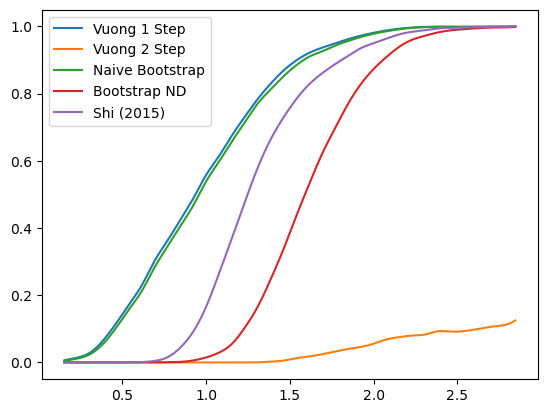

In [10]:
mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)

# sequence 3


Quantiles: 1th: 0.43, 5th: 2.87, 10th: 9.28, 30th: 79.87, 50th: 238.80, 70th: 579.99, 90th: 1433.78, 95th: 2001.12, 99th: 3592.84
bonus term 0.5846745760954133 // variance stats 2.8940464254066525 //part1 2.51188643150958 //part2 0.23276314118391042
-0.9091391715682358 0.19244588602776377 2.0804937816379865
-2.078488323759063 0.19244588602776377 0.9111446294471599
---
Quantiles: 1th: 0.76, 5th: 4.50, 10th: 14.04, 30th: 123.73, 50th: 369.20, 70th: 869.83, 90th: 2238.29, 95th: 3157.09, 99th: 5725.10
bonus term 1.4314433147678922 // variance stats 1.0050172243589508 //part1 2.51188643150958 //part2 0.5698678478499647
0.6028190277934208 -0.5074733402597005 2.2813047732358864
-2.2600676017423638 -0.5074733402597005 -0.581581856299898
---
Quantiles: 1th: 0.46, 5th: 3.77, 10th: 10.51, 30th: 84.33, 50th: 245.28, 70th: 564.53, 90th: 1420.18, 95th: 1987.83, 99th: 3341.01
bonus term 2.0749454427804337 // variance stats 0.18485279231504892 //part1 2.51188643150958 //part2 0.8260506592781919
1.7283

-0.9065954438041683 0.24680212383179698 2.105527564022134
-2.1763742380070275 0.24680212383179698 0.8357487698192753
---
Quantiles: 1th: 0.91, 5th: 5.30, 10th: 18.10, 30th: 157.91, 50th: 482.09, 70th: 1131.88, 90th: 2701.38, 95th: 3776.59, 99th: 6383.90
bonus term 1.4114052960727037 // variance stats 1.33640959308194 //part1 2.51188643150958 //part2 0.5618905689237252
0.572580062340606 -0.41968844345201983 2.3060566036042776
-2.2502305298048015 -0.41968844345201983 -0.51675398854113
---
Quantiles: 1th: 0.44, 5th: 3.16, 10th: 8.81, 30th: 69.53, 50th: 214.91, 70th: 518.84, 90th: 1357.27, 95th: 1941.22, 99th: 3166.70
bonus term 0.7754651161185196 // variance stats 1.8134192378988292 //part1 2.51188643150958 //part2 0.308718223240883
-0.6139392148343039 -0.11646485984086541 2.1998790691159575
-2.1648694470713434 -0.11646485984086541 0.6489488368789182
---
Quantiles: 1th: 0.41, 5th: 3.06, 10th: 10.32, 30th: 93.34, 50th: 283.58, 70th: 681.27, 90th: 1742.09, 95th: 2537.56, 99th: 4527.74
bonus

Quantiles: 1th: 0.67, 5th: 3.53, 10th: 11.02, 30th: 98.22, 50th: 306.61, 70th: 739.41, 90th: 1796.90, 95th: 2609.87, 99th: 4409.77
bonus term 1.1489149866648505 // variance stats 1.3404967582525031 //part1 2.51188643150958 //part2 0.45739129454765265
0.08791687396984028 -0.472833969667529 2.253133918042676
-2.2099130993598606 -0.472833969667529 -0.04469605528702515
---
Quantiles: 1th: 0.52, 5th: 4.01, 10th: 11.34, 30th: 95.98, 50th: 294.87, 70th: 696.40, 90th: 1719.93, 95th: 2484.20, 99th: 4213.68
bonus term 0.8105608572823749 // variance stats 2.1783438790957144 //part1 2.51188643150958 //part2 0.3226900894541034
-0.501453360617147 -0.13180709657103631 2.1305275756735416
-2.122575075181897 -0.13180709657103631 0.5094058611087918
---
Quantiles: 1th: 0.39, 5th: 3.57, 10th: 10.63, 30th: 91.47, 50th: 274.77, 70th: 638.01, 90th: 1586.51, 95th: 2314.11, 99th: 4012.84
bonus term 1.0475549328578597 // variance stats 1.3469781740615387 //part1 2.51188643150958 //part2 0.4170391303194013
-0.086

0.46935350288336913 -0.9994450548322662 2.2322881145681523
-2.32489879226336 -0.9994450548322662 -0.5619641805785768
---
Quantiles: 1th: 0.53, 5th: 4.31, 10th: 14.46, 30th: 131.92, 50th: 386.47, 70th: 864.81, 90th: 2051.73, 95th: 2992.07, 99th: 5255.55
bonus term 1.7615591724519786 // variance stats 0.54506250424414 //part1 2.51188643150958 //part2 0.7012893379074173
1.1820352296153276 -0.710426874311747 2.3437436444090096
-2.3410831152886296 -0.710426874311747 -1.179374700494948
---
Quantiles: 1th: 0.60, 5th: 4.64, 10th: 13.75, 30th: 121.56, 50th: 367.30, 70th: 863.85, 90th: 2213.76, 95th: 3184.75, 99th: 5607.75
bonus term 0.35846644218675777 // variance stats 8.019745695848867 //part1 2.51188643150958 //part2 0.14270806103734893
-1.2051800835909439 1.0690628646608085 2.1566917583239036
-1.9221129679644595 1.0690628646608085 1.439758873950388
---
Quantiles: 1th: 0.43, 5th: 2.57, 10th: 7.71, 30th: 70.20, 50th: 205.26, 70th: 499.24, 90th: 1258.66, 95th: 1791.61, 99th: 3014.10
bonus term

Quantiles: 1th: 0.54, 5th: 4.30, 10th: 14.41, 30th: 132.87, 50th: 404.97, 70th: 962.34, 90th: 2377.69, 95th: 3406.37, 99th: 5759.43
bonus term 1.1758864779861136 // variance stats 1.6931992388385306 //part1 2.51188643150958 //part2 0.4681288386431689
0.16054259231649173 -0.3099277494692384 2.189241072758407
-2.1912303636557353 -0.3099277494692384 -0.16253188321382012
---
Quantiles: 1th: 0.62, 5th: 4.18, 10th: 12.25, 30th: 104.67, 50th: 306.74, 70th: 723.05, 90th: 1847.56, 95th: 2596.76, 99th: 4413.23
bonus term 1.2467150172480679 // variance stats 1.1121573571700882 //part1 2.51188643150958 //part2 0.4963261880031828
0.30640610773972715 -0.7910717421018135 2.3115952149257724
-2.1870239267564084 -0.7910717421018135 -0.18183481957036318
---
Quantiles: 1th: 0.47, 5th: 2.69, 10th: 8.30, 30th: 74.15, 50th: 223.18, 70th: 516.56, 90th: 1288.45, 95th: 1814.74, 99th: 3060.73
bonus term 0.36449031414358407 // variance stats 4.686191494406879 //part1 2.51188643150958 //part2 0.14510620765785762
-

Quantiles: 1th: 0.58, 5th: 4.15, 10th: 11.34, 30th: 96.94, 50th: 296.61, 70th: 719.12, 90th: 1798.11, 95th: 2567.69, 99th: 4229.89
bonus term 0.9130971927968893 // variance stats 1.915151162568197 //part1 2.51188643150958 //part2 0.36351053986471077
-0.42195660354270165 -0.2542269106768764 2.2454044302782186
-2.24815098913648 -0.2542269106768764 0.4192100446844403
---
Quantiles: 1th: 0.61, 5th: 4.14, 10th: 11.34, 30th: 97.08, 50th: 280.01, 70th: 668.85, 90th: 1671.98, 95th: 2429.56, 99th: 4319.49
bonus term 0.8941847428107323 // variance stats 1.8526907970697037 //part1 2.51188643150958 //part2 0.35598135791248725
-0.43234514709499117 -0.38546644467922486 2.137498209027482
-2.2207146327164557 -0.38546644467922486 0.3491287234060176
---
Quantiles: 1th: 0.38, 5th: 2.95, 10th: 10.63, 30th: 97.76, 50th: 303.78, 70th: 728.78, 90th: 1809.90, 95th: 2646.89, 99th: 4456.01
bonus term 0.6734588948447825 // variance stats 3.0575806492674906 //part1 2.51188643150958 //part2 0.26810881511074164
-0.

-0.5210347533075969 -0.03572375127545013 2.1570932817286543
-2.1740586358938527 -0.03572375127545013 0.5040693991423987
---
Quantiles: 1th: 0.50, 5th: 3.19, 10th: 10.50, 30th: 94.54, 50th: 267.85, 70th: 659.16, 90th: 1666.50, 95th: 2345.09, 99th: 3939.62
bonus term 1.8131995252303705 // variance stats 0.38822484640110166 //part1 2.51188643150958 //part2 0.7218477326384073
1.2581416185357546 -1.3476515898942083 2.3605040219257813
-2.3682574319249863 -1.3476515898942083 -1.26589502853496
---
Quantiles: 1th: 0.32, 5th: 2.58, 10th: 8.53, 30th: 79.51, 50th: 236.35, 70th: 574.74, 90th: 1486.02, 95th: 2068.13, 99th: 3600.23
bonus term 0.6759238956636674 // variance stats 2.4250260449894596 //part1 2.51188643150958 //part2 0.26909014961215993
-0.6749878230302749 -0.07079087342093071 2.185968811693183
-2.0268356143576094 -0.07079087342093071 0.8341210203658482
---
Quantiles: 1th: 0.51, 5th: 3.27, 10th: 8.57, 30th: 68.56, 50th: 210.93, 70th: 519.91, 90th: 1363.13, 95th: 1899.57, 99th: 3112.95
bo

Quantiles: 1th: 0.33, 5th: 2.45, 10th: 9.83, 30th: 80.74, 50th: 239.16, 70th: 555.93, 90th: 1385.02, 95th: 1965.42, 99th: 3406.40
bonus term 1.346177720843981 // variance stats 0.74747168338084 //part1 2.51188643150958 //part2 0.5359230035073529
0.47036611039284437 -1.2567072341645193 2.241703317589995
-2.2219893312951173 -1.2567072341645193 -0.4506521240979673
---
Quantiles: 1th: 0.51, 5th: 3.09, 10th: 7.80, 30th: 53.75, 50th: 160.06, 70th: 387.71, 90th: 969.34, 95th: 1347.97, 99th: 2281.57
bonus term 0.6319417839375802 // variance stats 1.7810693380910936 //part1 2.51188643150958 //part2 0.2515805555579195
-0.8278480488899808 -0.4413952754061032 2.159911402624812
-2.0917316167651414 -0.4413952754061032 0.8960278347496518
---
Quantiles: 1th: 0.50, 5th: 2.93, 10th: 8.61, 30th: 68.39, 50th: 210.73, 70th: 497.12, 90th: 1290.41, 95th: 1809.95, 99th: 3222.87
bonus term 0.726850837017841 // variance stats 1.9036540430929876 //part1 2.51188643150958 //part2 0.28936453013961383
-0.77301976419

-1.3976524692181411 0.8279244113738539 2.121896925459694
-2.0282951493582027 0.8279244113738539 1.491254245319633
---
Quantiles: 1th: 0.56, 5th: 3.36, 10th: 10.38, 30th: 77.50, 50th: 241.23, 70th: 582.70, 90th: 1404.89, 95th: 1978.34, 99th: 3473.39
bonus term 0.5106855977929661 // variance stats 3.391670422124364 //part1 2.51188643150958 //part2 0.20330759837977902
-1.0522544101859 -0.15512233859357924 2.220367323468513
-2.073625605771832 -0.15512233859357924 1.1989961278825807
---
Quantiles: 1th: 0.46, 5th: 3.37, 10th: 11.35, 30th: 92.18, 50th: 279.13, 70th: 674.58, 90th: 1695.20, 95th: 2430.32, 99th: 4069.72
bonus term 0.3689233892109593 // variance stats 6.078027722628697 //part1 2.51188643150958 //part2 0.14687104662978162
-1.3158913894568864 0.7077188023774799 2.0440084766829987
-2.053738167878805 0.7077188023774799 1.3061616982610804
---
Quantiles: 1th: 0.90, 5th: 6.25, 10th: 18.48, 30th: 154.34, 50th: 458.97, 70th: 1130.62, 90th: 2715.87, 95th: 3816.91, 99th: 6516.93
bonus term 

-1.2942488321057093 0.2627385576878244 2.100311650343992
-2.093405090196576 0.2627385576878244 1.3011553922531252
---
Quantiles: 1th: 0.54, 5th: 3.34, 10th: 11.21, 30th: 98.28, 50th: 314.49, 70th: 746.44, 90th: 1935.10, 95th: 2753.75, 99th: 4540.96
bonus term 0.5655685495518794 // variance stats 3.8505202862315966 //part1 2.51188643150958 //part2 0.22515689501614414
-0.9584413500904491 -0.10252751492839382 2.0451940378176596
-2.089578449194208 -0.10252751492839382 0.9140569387139009
---
Quantiles: 1th: 0.53, 5th: 3.53, 10th: 11.79, 30th: 96.69, 50th: 311.41, 70th: 705.87, 90th: 1871.67, 95th: 2597.68, 99th: 4584.09
bonus term 1.2429233153465744 // variance stats 1.13055068398867 //part1 2.51188643150958 //part2 0.49481668428759695
0.27611394724324717 -1.1663355961245254 2.2603711848796766
-2.209732683449902 -1.1663355961245254 -0.22547544581347237
---
Quantiles: 1th: 0.68, 5th: 5.25, 10th: 14.84, 30th: 121.41, 50th: 372.52, 70th: 879.12, 90th: 2176.83, 95th: 3152.47, 99th: 5156.15
bonu

0.5384615384615385 [0.99571429 0.         0.00428571]
Quantiles: 1th: 0.53, 5th: 4.00, 10th: 13.00, 30th: 121.15, 50th: 372.66, 70th: 886.13, 90th: 2183.84, 95th: 3206.18, 99th: 5465.18
bonus term 0.5786536321754723 // variance stats 4.588818858478389 //part1 2.51188643150958 //part2 0.2303661602358814
-0.9493848334359386 -0.06556469847993979 2.0614374348869764
-2.1066920977868833 -0.06556469847993979 0.9041301705360318
---
Quantiles: 1th: 0.74, 5th: 4.42, 10th: 11.44, 30th: 94.25, 50th: 283.10, 70th: 668.59, 90th: 1632.55, 95th: 2334.17, 99th: 4110.62
bonus term 1.1779019861490267 // variance stats 1.117760455795043 //part1 2.51188643150958 //part2 0.4689312268951337
0.14879228910641465 -1.3403447646125781 2.240225972886117
-2.207011683191639 -1.3403447646125781 -0.11557799941193646
---
Quantiles: 1th: 0.39, 5th: 2.27, 10th: 8.20, 30th: 66.80, 50th: 204.06, 70th: 483.31, 90th: 1214.20, 95th: 1710.56, 99th: 2880.63
bonus term 0.42142343855603726 // variance stats 3.6960621394802295 //p

Quantiles: 1th: 0.32, 5th: 2.19, 10th: 7.66, 30th: 62.09, 50th: 192.94, 70th: 461.90, 90th: 1114.41, 95th: 1655.44, 99th: 2771.82
bonus term 1.3928981460314518 // variance stats 0.5597069597759257 //part1 2.51188643150958 //part2 0.5545227397857934
0.48170668801339195 -2.31655066616522 2.2592184537646776
-2.3040896040495116 -2.31655066616522 -0.5265778382982258
---
Quantiles: 1th: 0.62, 5th: 4.43, 10th: 13.78, 30th: 116.17, 50th: 356.37, 70th: 847.61, 90th: 2093.23, 95th: 3010.43, 99th: 5269.56
bonus term 0.8234356161650144 // variance stats 2.624126290745807 //part1 2.51188643150958 //part2 0.3278156232844295
-0.534954390257305 -0.5836753816433582 2.1257288033777173
-2.1818256225873336 -0.5836753816433582 0.4788575710476884
---
Quantiles: 1th: 0.31, 5th: 2.42, 10th: 7.50, 30th: 67.63, 50th: 214.40, 70th: 498.49, 90th: 1256.50, 95th: 1839.13, 99th: 3073.21
bonus term 0.7070312726193725 // variance stats 1.944017977897128 //part1 2.51188643150958 //part2 0.28147421943533674
-0.813643515

Quantiles: 1th: 0.78, 5th: 5.20, 10th: 12.70, 30th: 102.29, 50th: 313.09, 70th: 739.35, 90th: 1786.87, 95th: 2551.32, 99th: 4262.02
bonus term 0.560454234801235 // variance stats 3.8761962343496528 //part1 2.51188643150958 //part2 0.22312084964144505
-0.9409927723806034 -0.21973544575765178 2.1708849087483446
-2.0619012419830733 -0.21973544575765178 1.0499764391458744
---
Quantiles: 1th: 0.56, 5th: 3.79, 10th: 12.02, 30th: 109.53, 50th: 325.78, 70th: 770.63, 90th: 1986.88, 95th: 2895.53, 99th: 5143.01
bonus term 0.4310159496751199 // variance stats 5.818944245037483 //part1 2.51188643150958 //part2 0.17159054018859055
-1.1305614406150866 0.46489542925877847 1.9895253311002696
-1.9925933399653262 0.46489542925877847 1.12749343175003
---
Quantiles: 1th: 0.29, 5th: 3.82, 10th: 15.21, 30th: 152.13, 50th: 464.18, 70th: 1109.17, 90th: 2888.12, 95th: 3996.65, 99th: 6733.00
bonus term 0.6307526332351349 // variance stats 5.1537250008441315 //part1 2.51188643150958 //part2 0.25110714613640733
-

Quantiles: 1th: 0.53, 5th: 3.80, 10th: 12.23, 30th: 110.51, 50th: 341.11, 70th: 798.99, 90th: 2005.03, 95th: 2782.82, 99th: 4833.06
bonus term 0.40661081439775554 // variance stats 6.246754270484503 //part1 2.51188643150958 //part2 0.16187468083634368
-1.3811694138543866 0.28253464442590687 2.0635735507844104
-2.194391042649898 0.28253464442590687 1.2503519219888997
---
Quantiles: 1th: 0.43, 5th: 2.79, 10th: 8.15, 30th: 65.65, 50th: 198.33, 70th: 464.29, 90th: 1169.48, 95th: 1665.58, 99th: 2806.85
bonus term 0.20702939049356284 // variance stats 7.842165157737174 //part1 2.51188643150958 //part2 0.0824198848708074
-1.5269660694004434 0.979884518756383 2.04754766715387
-1.9410248503875693 0.979884518756383 1.6334888861667445
---
Quantiles: 1th: 0.64, 5th: 3.46, 10th: 9.52, 30th: 75.76, 50th: 230.33, 70th: 574.14, 90th: 1450.99, 95th: 2025.01, 99th: 3354.54
bonus term 0.21904090595819425 // variance stats 8.965460801749588 //part1 2.51188643150958 //part2 0.08720175530649138
-1.554235690

-1.467710163236931 -0.036509468161576165 2.0081362315306905
-2.2179912760200673 -0.036509468161576165 1.2578551187475542
---
Quantiles: 1th: 0.48, 5th: 3.23, 10th: 10.37, 30th: 83.87, 50th: 239.74, 70th: 560.07, 90th: 1389.78, 95th: 1974.64, 99th: 3824.12
bonus term 0.42828221933803756 // variance stats 4.263565239551547 //part1 2.51188643150958 //part2 0.17050222253903843
-1.216783928169103 -0.2646092730409905 2.045863872708014
-2.0733483668451784 -0.2646092730409905 1.1892994340319385
---
Quantiles: 1th: 0.40, 5th: 3.18, 10th: 8.24, 30th: 68.70, 50th: 206.65, 70th: 482.06, 90th: 1243.29, 95th: 1746.55, 99th: 2968.10
bonus term 0.5872194547095577 // variance stats 2.4970909978755764 //part1 2.51188643150958 //part2 0.23377627560838957
-0.9591246565281366 -0.5347752714858772 1.9999042019900681
-2.1335635659472523 -0.5347752714858772 0.8254652925709527
---
Quantiles: 1th: 0.57, 5th: 4.16, 10th: 11.53, 30th: 92.60, 50th: 280.55, 70th: 686.34, 90th: 1697.94, 95th: 2330.45, 99th: 4036.15
b

Quantiles: 1th: 0.50, 5th: 2.76, 10th: 7.75, 30th: 63.40, 50th: 199.59, 70th: 463.29, 90th: 1144.27, 95th: 1630.40, 99th: 2848.92
bonus term 0.3532368811437069 // variance stats 4.223152984943443 //part1 2.51188643150958 //part2 0.14062613528726314
-1.4711944740993124 -0.008941749213325575 1.9736748142692868
-2.177668236386726 -0.008941749213325575 1.2672010519818728
---
0.8461538461538463 [0.94714286 0.         0.05285714]
Quantiles: 1th: 0.54, 5th: 3.55, 10th: 10.95, 30th: 99.52, 50th: 300.73, 70th: 699.64, 90th: 1752.19, 95th: 2512.98, 99th: 4176.83
bonus term 0.45382652573325616 // variance stats 4.832646857081786 //part1 2.51188643150958 //part2 0.1806715940817905
-1.1116576136835843 -0.2949587064857756 2.079557453074303
-2.0193106651500967 -0.2949587064857756 1.1719044016077904
---
Quantiles: 1th: 0.75, 5th: 4.26, 10th: 13.36, 30th: 131.48, 50th: 395.59, 70th: 916.79, 90th: 2303.14, 95th: 3330.50, 99th: 5970.72
bonus term 0.8634689510151355 // variance stats 2.605601371048081 //p

-1.42895480186493 1.0636473698202662 1.9668138697305946
-1.957456243454594 1.0636473698202662 1.4383124281409307
---
Quantiles: 1th: 0.36, 5th: 2.87, 10th: 8.27, 30th: 57.58, 50th: 171.01, 70th: 416.33, 90th: 1038.10, 95th: 1445.60, 99th: 2399.72
bonus term 0.28756663616041694 // variance stats 4.902538262275083 //part1 2.51188643150958 //part2 0.1144823398674106
-1.4634979290381092 0.1907652446290572 2.134933762062296
-2.038631201358943 0.1907652446290572 1.5598004897414623
---
Quantiles: 1th: 0.53, 5th: 4.12, 10th: 11.96, 30th: 104.65, 50th: 320.10, 70th: 748.12, 90th: 1940.34, 95th: 2707.09, 99th: 4279.33
bonus term 0.30317679903357486 // variance stats 8.265536557259946 //part1 2.51188643150958 //part2 0.12069685764072276
-1.3414832825635923 0.636982039682026 2.0642428906351014
-1.9478368806307422 0.636982039682026 1.4578892925679519
---
Quantiles: 1th: 0.70, 5th: 5.01, 10th: 15.66, 30th: 152.15, 50th: 472.92, 70th: 1108.96, 90th: 2772.56, 95th: 3768.92, 99th: 6490.36
bonus term 0.

Quantiles: 1th: 0.33, 5th: 2.40, 10th: 6.90, 30th: 58.55, 50th: 177.21, 70th: 429.35, 90th: 1093.90, 95th: 1555.81, 99th: 2682.43
bonus term 0.23422971238809118 // variance stats 6.428927538236058 //part1 2.51188643150958 //part2 0.09324852805838242
-1.6184906129398338 0.6194393635460003 2.072690191531637
-2.086950037716016 0.6194393635460003 1.6042307667554543
---
Quantiles: 1th: 0.60, 5th: 4.09, 10th: 14.25, 30th: 117.12, 50th: 348.24, 70th: 785.06, 90th: 2088.23, 95th: 2995.41, 99th: 5383.69
bonus term 0.32029874623587073 // variance stats 8.484617788179449 //part1 2.51188643150958 //part2 0.12751322759579511
-1.5797226065170313 0.765590112177862 2.0214756904058206
-2.220320098988773 0.765590112177862 1.3808781979340796
---
Quantiles: 1th: 0.61, 5th: 3.57, 10th: 11.48, 30th: 99.99, 50th: 309.03, 70th: 710.86, 90th: 1816.85, 95th: 2506.14, 99th: 4207.69
bonus term 0.2833162226717656 // variance stats 8.53331709992604 //part1 2.51188643150958 //part2 0.11279021977976118
-1.45736420981

-1.3066721351727997 -0.17446945615808507 1.9830754125861423
-2.0041755703627993 -0.17446945615808507 1.2855719773961425
---
Quantiles: 1th: 0.50, 5th: 3.01, 10th: 9.41, 30th: 78.62, 50th: 234.52, 70th: 556.95, 90th: 1405.91, 95th: 2104.05, 99th: 3623.60
bonus term 0.20795588668348947 // variance stats 9.520883503626743 //part1 2.51188643150958 //part2 0.08278872964750769
-1.6944746882923787 1.3136836309430606 2.1724567369032193
-2.1103864616593575 1.3136836309430606 1.7565449635362407
---
Quantiles: 1th: 0.62, 5th: 3.53, 10th: 10.17, 30th: 91.87, 50th: 288.34, 70th: 682.80, 90th: 1696.47, 95th: 2415.38, 99th: 4174.17
bonus term 0.874403532429947 // variance stats 1.960779599145269 //part1 2.51188643150958 //part2 0.3481063162176694
-0.5487488710146865 -2.6783616541026287 2.199372547551862
-2.2975559358745805 -2.6783616541026287 0.4505654826919677
---
Quantiles: 1th: 0.60, 5th: 3.97, 10th: 12.53, 30th: 106.33, 50th: 322.98, 70th: 772.40, 90th: 1976.98, 95th: 2850.25, 99th: 4882.98
bonus

-1.5594900632394524 0.9657860510265509 2.380973403989196
-2.1072987122242863 0.9657860510265509 1.8331647550043617
---
Quantiles: 1th: 0.42, 5th: 2.93, 10th: 9.26, 30th: 82.00, 50th: 244.93, 70th: 582.21, 90th: 1541.05, 95th: 2199.65, 99th: 3949.39
bonus term 0.36811198101426634 // variance stats 5.323296051761922 //part1 2.51188643150958 //part2 0.14654801920843227
-1.4106166639020772 -0.40152116778352825 2.099854756134601
-2.1468406259306096 -0.40152116778352825 1.363630794106068
---
Quantiles: 1th: 0.52, 5th: 3.23, 10th: 9.94, 30th: 91.80, 50th: 275.06, 70th: 622.99, 90th: 1608.13, 95th: 2262.50, 99th: 3825.44
bonus term 0.6030706299009794 // variance stats 3.0331236527191012 //part1 2.51188643150958 //part2 0.24008674211379422
-1.0358128195155414 -0.9967349872217535 2.0536453988763843
-2.2419540793175003 -0.9967349872217535 0.8475041390744257
---
Quantiles: 1th: 0.92, 5th: 5.74, 10th: 17.80, 30th: 135.92, 50th: 421.89, 70th: 984.50, 90th: 2419.65, 95th: 3358.95, 99th: 5777.21
bonus

Quantiles: 1th: 0.60, 5th: 4.10, 10th: 9.77, 30th: 84.38, 50th: 266.31, 70th: 635.81, 90th: 1674.59, 95th: 2488.58, 99th: 4000.41
bonus term 0.30616096956449484 // variance stats 7.119035086614649 //part1 2.51188643150958 //part2 0.12188487732723642
-1.292471473642759 0.1599209672115867 2.0130003169841726
-1.9047934127717487 0.1599209672115867 1.400678377855183
---
1.153846153846154 [0.94571429 0.         0.05428571]
Quantiles: 1th: 0.56, 5th: 3.37, 10th: 10.58, 30th: 95.64, 50th: 288.65, 70th: 660.65, 90th: 1644.88, 95th: 2312.93, 99th: 3721.63
bonus term 0.24919313950511232 // variance stats 9.007391038177108 //part1 2.51188643150958 //part2 0.09920557568972319
-1.5356089110635602 0.6327092122951508 1.8687709551136351
-2.0339951900737847 0.6327092122951508 1.3703846761034104
---
Quantiles: 1th: 0.45, 5th: 2.69, 10th: 8.09, 30th: 64.19, 50th: 194.37, 70th: 458.51, 90th: 1214.89, 95th: 1772.82, 99th: 3099.40
bonus term 0.4980358900362187 // variance stats 2.913260800074076 //part1 2.51

Quantiles: 1th: 0.57, 5th: 4.08, 10th: 11.55, 30th: 95.54, 50th: 278.35, 70th: 673.74, 90th: 1699.89, 95th: 2358.57, 99th: 4278.48
bonus term 0.2793611281690805 // variance stats 8.1680861935986 //part1 2.51188643150958 //part2 0.11121566829802552
-1.421956311922222 0.4990991250979978 2.1847355084107134
-1.980678568260383 0.4990991250979978 1.6260132520725523
---
Quantiles: 1th: 0.55, 5th: 3.14, 10th: 10.82, 30th: 95.81, 50th: 290.20, 70th: 708.35, 90th: 1835.03, 95th: 2593.46, 99th: 4332.28
bonus term 0.3557849419056684 // variance stats 6.778477777234712 //part1 2.51188643150958 //part2 0.14164053654760606
-1.3765882384414911 0.13814428517721716 2.1511764945560965
-2.088158122252828 0.13814428517721716 1.4396066107447598
---
Quantiles: 1th: 0.50, 5th: 2.69, 10th: 8.78, 30th: 77.62, 50th: 237.63, 70th: 574.36, 90th: 1427.49, 95th: 1987.83, 99th: 3326.81
bonus term 0.2331448844843691 // variance stats 8.487258569606734 //part1 2.51188643150958 //part2 0.09281665029109414
-1.54785255718

Quantiles: 1th: 0.62, 5th: 3.99, 10th: 10.24, 30th: 81.68, 50th: 251.62, 70th: 612.27, 90th: 1583.82, 95th: 2278.96, 99th: 3949.01
bonus term 0.2563342392788687 // variance stats 8.388474465203835 //part1 2.51188643150958 //part2 0.10204849871529358
-1.4725882448172523 0.7089134481260798 1.9758683117030256
-1.9852567233749898 0.7089134481260798 1.463199833145288
---
Quantiles: 1th: 0.39, 5th: 2.40, 10th: 7.28, 30th: 63.65, 50th: 191.90, 70th: 457.35, 90th: 1092.25, 95th: 1584.70, 99th: 2651.39
bonus term 0.2503751025070952 // variance stats 6.111762842319446 //part1 2.51188643150958 //part2 0.0996761236361415
-1.51691106265842 0.20311621718992454 1.9984321174227508
-2.0176612676726102 0.20311621718992454 1.4976819124085603
---
Quantiles: 1th: 0.37, 5th: 3.20, 10th: 9.35, 30th: 79.37, 50th: 257.19, 70th: 635.45, 90th: 1574.19, 95th: 2232.58, 99th: 3797.09
bonus term 0.25284640593133445 // variance stats 8.77397643273395 //part1 2.51188643150958 //part2 0.10065996724994457
-1.40175182336

Quantiles: 1th: 0.71, 5th: 5.46, 10th: 18.11, 30th: 143.78, 50th: 415.70, 70th: 945.84, 90th: 2527.21, 95th: 3627.16, 99th: 6023.20
bonus term 0.575774140956765 // variance stats 5.029389617028786 //part1 2.51188643150958 //part2 0.22921981413416825
-0.8899873420854836 -1.233454481964338 2.073588825769921
-2.041535623999014 -1.233454481964338 0.9220405438563908
---
Quantiles: 1th: 0.34, 5th: 2.38, 10th: 7.48, 30th: 59.17, 50th: 182.49, 70th: 440.11, 90th: 1119.63, 95th: 1592.06, 99th: 2953.03
bonus term 0.19521230680540475 // variance stats 7.889605971486617 //part1 2.51188643150958 //part2 0.0777154191195209
-1.703640288306766 0.5705705301965769 2.1890555019730735
-2.0940649019175757 0.5705705301965769 1.798630888362264
---
Quantiles: 1th: 0.40, 5th: 2.59, 10th: 7.73, 30th: 61.38, 50th: 189.39, 70th: 458.77, 90th: 1151.55, 95th: 1616.27, 99th: 2763.87
bonus term 0.16517421731536835 // variance stats 10.028520008125303 //part1 2.51188643150958 //part2 0.06575704030380977
-1.69076508668

Quantiles: 1th: 0.57, 5th: 3.61, 10th: 10.52, 30th: 97.47, 50th: 300.06, 70th: 709.87, 90th: 1803.14, 95th: 2518.84, 99th: 4378.35
bonus term 0.4280201743018137 // variance stats 5.202585736198721 //part1 2.51188643150958 //part2 0.17039790053110976
-1.3104219810847888 -1.1572441095632537 1.954106178016607
-2.1664623296884162 -1.1572441095632537 1.0980658294129795
---
Quantiles: 1th: 0.52, 5th: 3.29, 10th: 11.39, 30th: 103.27, 50th: 323.52, 70th: 772.89, 90th: 1957.05, 95th: 2759.84, 99th: 4870.80
bonus term 0.36436807913824465 // variance stats 6.844248213368855 //part1 2.51188643150958 //part2 0.14505754502573937
-1.3067568501610833 -0.5958324620310966 2.1417718823614735
-2.0354930084375726 -0.5958324620310966 1.4130357240849842
---
Quantiles: 1th: 0.54, 5th: 2.96, 10th: 8.25, 30th: 63.38, 50th: 197.70, 70th: 483.35, 90th: 1249.68, 95th: 1738.62, 99th: 3242.68
bonus term 0.21619910671816925 // variance stats 7.853640322871436 //part1 2.51188643150958 //part2 0.08607041465176396
-1.52

-1.4761742038727619 0.7464606944920193 2.179220090337763
-1.9539132755571702 0.7464606944920193 1.7014810186533544
---
Quantiles: 1th: 0.43, 5th: 2.83, 10th: 8.50, 30th: 69.11, 50th: 211.76, 70th: 508.49, 90th: 1295.85, 95th: 1802.20, 99th: 3181.65
bonus term 0.24822518929066922 // variance stats 7.083862740699206 //part1 2.51188643150958 //part2 0.09882022776861459
-1.499030331498924 -0.002753652128846013 2.164196871310087
-1.9954807100802625 -0.002753652128846013 1.6677464927287486
---
Quantiles: 1th: 0.49, 5th: 3.30, 10th: 10.89, 30th: 94.62, 50th: 282.92, 70th: 654.01, 90th: 1613.30, 95th: 2309.32, 99th: 4099.03
bonus term 0.43542436306967985 // variance stats 4.715577549096224 //part1 2.51188643150958 //part2 0.17334556117172895
-1.292880728006748 -1.65799087824463 1.9213028022742171
-2.1637294541461074 -1.65799087824463 1.0504540761348573
---
1.4615384615384617 [0.95142857 0.00428571 0.04428571]
Quantiles: 1th: 0.51, 5th: 3.49, 10th: 10.29, 30th: 86.08, 50th: 249.71, 70th: 591.00

-1.4738679014783493 -0.28821116792672863 2.061486999765819
-2.060940631655539 -0.28821116792672863 1.4744142695886293
---
Quantiles: 1th: 0.40, 5th: 2.55, 10th: 7.47, 30th: 72.12, 50th: 212.16, 70th: 497.40, 90th: 1220.86, 95th: 1733.40, 99th: 2934.91
bonus term 0.218871505543333 // variance stats 7.939339543129576 //part1 2.51188643150958 //part2 0.08713431578664038
-1.6756356727883155 0.11376107940064105 1.953955428007187
-2.1133786838749815 0.11376107940064105 1.516212416920521
---
Quantiles: 1th: 0.61, 5th: 3.49, 10th: 11.14, 30th: 100.75, 50th: 298.11, 70th: 698.20, 90th: 1791.43, 95th: 2574.26, 99th: 4572.91
bonus term 0.31436570593518054 // variance stats 7.584906299028334 //part1 2.51188643150958 //part2 0.12515124170890748
-1.434314298233427 -0.208951435935718 2.090226209823042
-2.063045710103788 -0.208951435935718 1.4614947979526811
---
Quantiles: 1th: 0.74, 5th: 4.72, 10th: 13.50, 30th: 110.21, 50th: 319.14, 70th: 775.79, 90th: 1903.01, 95th: 2717.40, 99th: 4630.74
bonus ter

-1.3396067199346438 -0.19552218227935403 2.0546824009699516
-1.9536722320466793 -0.19552218227935403 1.4406168888579165
---
Quantiles: 1th: 0.49, 5th: 2.81, 10th: 7.12, 30th: 55.56, 50th: 168.16, 70th: 398.27, 90th: 1006.50, 95th: 1376.74, 99th: 2396.15
bonus term 0.1307403600185577 // variance stats 11.153797450472801 //part1 2.51188643150958 //part2 0.05204867480413358
-1.8100491279230675 1.4611336413219425 2.081359986283009
-2.0715298479601834 1.4611336413219425 1.8198792662458938
---
Quantiles: 1th: 0.66, 5th: 4.32, 10th: 13.74, 30th: 109.66, 50th: 329.38, 70th: 756.67, 90th: 1905.58, 95th: 2736.19, 99th: 4724.51
bonus term 0.30225206105471913 // variance stats 8.357006346668921 //part1 2.51188643150958 //part2 0.12032871282045712
-1.5058093377467279 -0.40343319243868003 2.100335760076359
-2.110313459856166 -0.40343319243868003 1.4958316379669212
---
Quantiles: 1th: 0.54, 5th: 3.28, 10th: 9.29, 30th: 77.98, 50th: 233.92, 70th: 522.71, 90th: 1349.85, 95th: 1978.97, 99th: 3321.21
bon

-1.6707708878777605 -1.939311316199416 1.99692610690483
-2.2050460195944668 -1.939311316199416 1.4626509751881236
---
Quantiles: 1th: 0.51, 5th: 3.16, 10th: 9.83, 30th: 78.93, 50th: 238.74, 70th: 555.73, 90th: 1341.83, 95th: 1905.96, 99th: 3262.02
bonus term 0.18237043091029229 // variance stats 10.758748552072445 //part1 2.51188643150958 //part2 0.07260297624231851
-1.5624267153328424 0.779947026590333 1.9387141936386163
-1.927167577153427 0.779947026590333 1.5739733318180318
---
Quantiles: 1th: 0.65, 5th: 4.77, 10th: 15.29, 30th: 129.26, 50th: 407.61, 70th: 969.86, 90th: 2355.59, 95th: 3324.98, 99th: 5842.14
bonus term 0.31321854069177013 // variance stats 10.138063983276105 //part1 2.51188643150958 //part2 0.12469454699969604
-1.3632700062708063 0.23014396889619318 1.9487072181200287
-1.9897070876543463 0.23014396889619318 1.3222701367364886
---
Quantiles: 1th: 0.46, 5th: 3.62, 10th: 12.44, 30th: 95.69, 50th: 312.62, 70th: 754.05, 90th: 1820.70, 95th: 2567.35, 99th: 4640.83
bonus te

-1.4961340728990922 -0.35806958036994463 2.0860810633580007
-2.037141848249369 -0.35806958036994463 1.5450732880077238
---
Quantiles: 1th: 0.44, 5th: 2.87, 10th: 7.91, 30th: 70.96, 50th: 221.12, 70th: 516.75, 90th: 1294.59, 95th: 1820.04, 99th: 3259.56
bonus term 0.17148921442339105 // variance stats 10.673013497526174 //part1 2.51188643150958 //part2 0.06827108593453819
-1.7072701814651168 0.5767038024081306 2.264778773553437
-2.0502486103118986 0.5767038024081306 1.9218003447066547
---
Quantiles: 1th: 0.42, 5th: 3.23, 10th: 9.34, 30th: 79.92, 50th: 246.32, 70th: 572.35, 90th: 1458.78, 95th: 1997.92, 99th: 3527.35
bonus term 0.24493916196397636 // variance stats 8.155400962465873 //part1 2.51188643150958 //part2 0.09751203672722342
-1.3916494718666834 -0.5486767035732907 2.0756962734038797
-1.8815277957946364 -0.5486767035732907 1.5858179494759268
---
Quantiles: 1th: 0.67, 5th: 3.65, 10th: 11.65, 30th: 103.91, 50th: 301.95, 70th: 709.77, 90th: 1737.39, 95th: 2413.23, 99th: 4136.20
bon

Quantiles: 1th: 0.33, 5th: 2.28, 10th: 6.49, 30th: 58.40, 50th: 185.76, 70th: 423.60, 90th: 1015.21, 95th: 1399.26, 99th: 2491.51
bonus term 0.23676447841799914 // variance stats 6.133350492150218 //part1 2.51188643150958 //part2 0.0942576365905642
-1.6506379910703792 -0.8418538481215317 2.1022170289557494
-2.124166947906377 -0.8418538481215317 1.6286880721197514
---
Quantiles: 1th: 0.53, 5th: 3.59, 10th: 10.22, 30th: 92.16, 50th: 267.36, 70th: 634.42, 90th: 1589.47, 95th: 2280.25, 99th: 3885.19
bonus term 0.1509561853873856 // variance stats 14.834984508772163 //part1 2.51188643150958 //part2 0.06009673984212126
-1.8026418678542564 1.897191272937332 2.152583119432817
-2.1045542386290275 1.897191272937332 1.8506707486580456
---
Quantiles: 1th: 0.41, 5th: 3.40, 10th: 11.03, 30th: 90.34, 50th: 266.75, 70th: 603.79, 90th: 1528.99, 95th: 2175.03, 99th: 3602.53
bonus term 0.4148422532783024 // variance stats 4.644475471345923 //part1 2.51188643150958 //part2 0.16515167567866224
-1.326662750

Quantiles: 1th: 0.60, 5th: 3.38, 10th: 11.61, 30th: 110.55, 50th: 332.92, 70th: 790.60, 90th: 2046.17, 95th: 2864.45, 99th: 5020.74
bonus term 0.35938300859538563 // variance stats 7.436370773730189 //part1 2.51188643150958 //part2 0.14307295269691217
-1.3696000617497541 -0.6341846206419051 2.0914874121336102
-2.088366078940526 -0.6341846206419051 1.372721394942839
---
Quantiles: 1th: 0.34, 5th: 2.65, 10th: 8.77, 30th: 67.95, 50th: 207.25, 70th: 489.60, 90th: 1271.02, 95th: 1766.56, 99th: 3013.22
bonus term 0.22326184307506175 // variance stats 7.963663120934762 //part1 2.51188643150958 //part2 0.08888214063917174
-1.6331027695003724 -0.5633464081874063 2.0381392269122207
-2.0796264556504958 -0.5633464081874063 1.591615540762097
---
Quantiles: 1th: 0.80, 5th: 4.30, 10th: 14.32, 30th: 113.23, 50th: 355.12, 70th: 864.36, 90th: 2173.85, 95th: 3071.00, 99th: 5469.75
bonus term 0.30868003596287347 // variance stats 9.363972172857084 //part1 2.51188643150958 //part2 0.12288773572353134
-1.36

Quantiles: 1th: 0.39, 5th: 2.73, 10th: 8.24, 30th: 72.87, 50th: 215.74, 70th: 500.56, 90th: 1280.94, 95th: 1820.36, 99th: 3148.45
bonus term 0.2645345656667334 // variance stats 6.62577808278833 //part1 2.51188643150958 //part2 0.10531310745118155
-1.531795383819814 -0.8282884586343574 1.9211782684346033
-2.0608645151532805 -0.8282884586343574 1.3921091371011367
---
Quantiles: 1th: 0.52, 5th: 3.40, 10th: 10.28, 30th: 90.04, 50th: 267.21, 70th: 631.40, 90th: 1590.78, 95th: 2312.66, 99th: 3978.65
bonus term 0.2680687772251935 // variance stats 8.14263110590217 //part1 2.51188643150958 //part2 0.10672010241485756
-1.5697070894757714 -0.6944296756044861 1.999008703532724
-2.1058446439261584 -0.6944296756044861 1.462871149082337
---
Quantiles: 1th: 0.40, 5th: 2.58, 10th: 9.22, 30th: 81.27, 50th: 245.24, 70th: 600.39, 90th: 1484.82, 95th: 2113.41, 99th: 3722.67
bonus term 0.24444925849295854 // variance stats 8.312517083406116 //part1 2.51188643150958 //part2 0.09731700264253218
-1.500693160

Quantiles: 1th: 0.84, 5th: 4.65, 10th: 15.37, 30th: 119.48, 50th: 350.24, 70th: 827.12, 90th: 2179.60, 95th: 3049.74, 99th: 5319.70
bonus term 0.3155837441879788 // variance stats 9.06108562483021 //part1 2.51188643150958 //part2 0.12563615147135493
-1.3752740507959957 -0.4761957054501437 2.0597309187200237
-2.0064415391719534 -0.4761957054501437 1.428563430344066
---
Quantiles: 1th: 0.41, 5th: 3.30, 10th: 8.79, 30th: 78.36, 50th: 252.17, 70th: 590.72, 90th: 1490.35, 95th: 2140.36, 99th: 3601.25
bonus term 0.15169660716631475 // variance stats 13.923547034181166 //part1 2.51188643150958 //part2 0.06039150706154693
-1.6801120409868893 1.3796074218970242 1.9147443780712499
-1.983505255319519 1.3796074218970242 1.6113511637386202
---
Quantiles: 1th: 0.55, 5th: 3.59, 10th: 11.68, 30th: 115.15, 50th: 339.39, 70th: 815.00, 90th: 1931.78, 95th: 2644.79, 99th: 4528.26
bonus term 0.21692502558237087 // variance stats 12.63524475615258 //part1 2.51188643150958 //part2 0.08635940815684266
-1.6975

Quantiles: 1th: 0.45, 5th: 3.39, 10th: 10.60, 30th: 82.93, 50th: 253.76, 70th: 602.09, 90th: 1603.48, 95th: 2257.03, 99th: 3587.16
bonus term 0.27974706094595947 // variance stats 7.388688308724172 //part1 2.51188643150958 //part2 0.11136931090385269
-1.454018046560538 -1.8753449119076826 2.0436184651165816
-2.0135121684524573 -1.8753449119076826 1.4841243432246625
---
Quantiles: 1th: 0.49, 5th: 3.40, 10th: 10.81, 30th: 95.28, 50th: 289.12, 70th: 675.16, 90th: 1719.99, 95th: 2405.38, 99th: 4231.89
bonus term 0.13925892250999702 // variance stats 17.623566816863725 //part1 2.51188643150958 //part2 0.05543997561478364
-1.6967189336109751 2.0223225859742544 2.078744937369581
-1.975236778630969 2.0223225859742544 1.8002270923495869
---
Quantiles: 1th: 0.70, 5th: 4.90, 10th: 15.17, 30th: 128.35, 50th: 392.40, 70th: 936.53, 90th: 2387.42, 95th: 3352.30, 99th: 5602.65
bonus term 0.31283523361088184 // variance stats 9.873369458558457 //part1 2.51188643150958 //part2 0.12454194970227049
-1.561

-1.3129474487836637 -0.7656871889630046 2.017394757958027
-2.0912001279582553 -0.7656871889630046 1.2391420787834355
---
Quantiles: 1th: 0.39, 5th: 3.12, 10th: 8.58, 30th: 62.34, 50th: 200.19, 70th: 492.59, 90th: 1240.61, 95th: 1759.22, 99th: 2877.15
bonus term 0.2034237465736563 // variance stats 8.491188080608833 //part1 2.51188643150958 //part2 0.08098445217183
-1.5556080477432745 -0.7088066653923439 2.119866613705804
-1.9624555408905873 -0.7088066653923439 1.7130191205584915
---
Quantiles: 1th: 0.57, 5th: 3.22, 10th: 10.48, 30th: 90.79, 50th: 278.18, 70th: 648.24, 90th: 1622.06, 95th: 2240.40, 99th: 4147.62
bonus term 0.22542521637738006 // variance stats 10.0164791429404 //part1 2.51188643150958 //part2 0.08974339506340866
-1.6220820374164462 -0.1481125407592229 2.056458585551242
-2.072932470171206 -0.1481125407592229 1.6056081527964816
---
Quantiles: 1th: 0.69, 5th: 3.57, 10th: 9.55, 30th: 78.28, 50th: 226.28, 70th: 521.26, 90th: 1318.14, 95th: 1926.30, 99th: 3324.25
bonus term 0

-1.5461896129544397 -1.8971776670170875 2.0317576228456837
-2.041899218482063 -1.8971776670170875 1.5360480173180608
---
Quantiles: 1th: 0.57, 5th: 3.85, 10th: 13.70, 30th: 118.84, 50th: 374.39, 70th: 875.69, 90th: 2309.96, 95th: 3326.78, 99th: 5579.33
bonus term 0.23623135056576453 // variance stats 12.90163440310983 //part1 2.51188643150958 //part2 0.0940453945697678
-1.395989065026776 0.256074518927673 2.092567412147354
-1.868451766158305 0.256074518927673 1.6201047110158244
---
Quantiles: 1th: 0.63, 5th: 3.52, 10th: 10.02, 30th: 83.09, 50th: 246.68, 70th: 582.76, 90th: 1533.22, 95th: 2106.87, 99th: 3693.97
bonus term 0.22094758753485427 // variance stats 9.30187895263523 //part1 2.51188643150958 //part2 0.087960818914122
-1.60722047537599 -0.6142819249038672 2.120149582799036
-2.0491156504456987 -0.6142819249038672 1.6782544077293275
---
Quantiles: 1th: 0.38, 5th: 2.52, 10th: 7.86, 30th: 70.99, 50th: 212.26, 70th: 511.74, 90th: 1329.06, 95th: 1876.81, 99th: 3106.04
bonus term 0.165

-1.7902056903090988 1.3768225194163195 2.2703061868940777
-2.012789544464116 1.3768225194163195 2.0477223327390606
---
Quantiles: 1th: 0.83, 5th: 5.53, 10th: 18.06, 30th: 136.84, 50th: 413.16, 70th: 973.18, 90th: 2470.47, 95th: 3448.26, 99th: 6126.24
bonus term 0.25927107366847124 // variance stats 13.032613495436866 //part1 2.51188643150958 //part2 0.10321767354452244
-1.4500700224433911 0.09012873398260378 2.2751626149740294
-1.9686121697803334 0.09012873398260378 1.756620467637087
---
Quantiles: 1th: 0.57, 5th: 3.73, 10th: 10.40, 30th: 89.39, 50th: 253.62, 70th: 607.15, 90th: 1553.85, 95th: 2189.73, 99th: 3583.40
bonus term 0.2319097959403959 // variance stats 8.993937264016862 //part1 2.51188643150958 //part2 0.09232495268546995
-1.5302676152427581 -1.026320548397248 1.9805646899774045
-1.99408720712355 -1.026320548397248 1.5167450980966126
---
Quantiles: 1th: 0.43, 5th: 3.88, 10th: 12.78, 30th: 115.04, 50th: 368.02, 70th: 914.91, 90th: 2238.25, 95th: 3181.19, 99th: 5648.77
bonus t

-1.5531896906222193 -0.2057383521227632 2.1419189409305037
-1.964223166663759 -0.2057383521227632 1.730885464888964
---
Quantiles: 1th: 0.45, 5th: 2.84, 10th: 8.98, 30th: 78.91, 50th: 239.09, 70th: 558.77, 90th: 1385.77, 95th: 1972.59, 99th: 3454.21
bonus term 0.20081075477760682 // variance stats 9.577999808082376 //part1 2.51188643150958 //part2 0.07994420140122523
-1.6352298582158313 -0.3313700377298388 2.00460549425108
-2.036851367771045 -0.3313700377298388 1.6029839846958662
---
Quantiles: 1th: 0.47, 5th: 2.54, 10th: 6.35, 30th: 45.98, 50th: 139.56, 70th: 318.24, 90th: 802.91, 95th: 1085.66, 99th: 1782.06
bonus term 0.07948177387621873 // variance stats 14.842568952728083 //part1 2.51188643150958 //part2 0.03164226410843431
-1.8569370836399568 2.0463619386687624 2.1269244246127754
-2.015900631392394 2.0463619386687624 1.967960876860338
---
Quantiles: 1th: 0.45, 5th: 3.39, 10th: 13.26, 30th: 107.76, 50th: 316.71, 70th: 744.19, 90th: 1846.81, 95th: 2550.78, 99th: 4257.68
bonus term 

Quantiles: 1th: 0.43, 5th: 2.92, 10th: 8.82, 30th: 74.78, 50th: 217.39, 70th: 513.96, 90th: 1228.52, 95th: 1765.52, 99th: 3095.99
bonus term 0.1576122581587213 // variance stats 11.712366695768367 //part1 2.51188643150958 //part2 0.06274657014011589
-1.6358684625236333 0.4758558993112283 2.004578653383053
-1.951092978841076 0.4758558993112283 1.68935413706561
---
2.307692307692308 [0.95714286 0.00142857 0.04142857]
Quantiles: 1th: 0.51, 5th: 3.51, 10th: 12.20, 30th: 114.85, 50th: 325.83, 70th: 783.19, 90th: 1915.96, 95th: 2592.21, 99th: 4629.69
bonus term 0.18734331771686696 // variance stats 14.534942173509688 //part1 2.51188643150958 //part2 0.07458271813836678
-1.7511000738225848 0.4028237582892358 2.0365342463969585
-2.1257867092563187 0.4028237582892358 1.6618476109632243
---
Quantiles: 1th: 0.58, 5th: 3.59, 10th: 9.72, 30th: 79.92, 50th: 242.03, 70th: 578.05, 90th: 1495.39, 95th: 2095.50, 99th: 3822.22
bonus term 0.16852531518047315 // variance stats 12.6191928127582 //part1 2.51

Quantiles: 1th: 0.69, 5th: 4.41, 10th: 11.34, 30th: 96.72, 50th: 272.16, 70th: 647.88, 90th: 1628.68, 95th: 2266.50, 99th: 4108.54
bonus term 0.21936810309814947 // variance stats 10.308052634083342 //part1 2.51188643150958 //part2 0.08733201483409216
-1.6651480920790027 -1.1715938832109347 2.046966453995273
-2.1038842982753017 -1.1715938832109347 1.6082302477989743
---
Quantiles: 1th: 0.75, 5th: 5.49, 10th: 15.96, 30th: 139.93, 50th: 400.41, 70th: 923.66, 90th: 2300.29, 95th: 3182.45, 99th: 5728.74
bonus term 0.2958801952009451 // variance stats 10.582595024704391 //part1 2.51188643150958 //part2 0.11779202733426472
-1.4027779577040098 -0.8441494165741257 2.0712410701524235
-1.9945383481059 -0.8441494165741257 1.479480679750533
---
Quantiles: 1th: 0.60, 5th: 3.67, 10th: 9.78, 30th: 70.38, 50th: 233.81, 70th: 550.03, 90th: 1373.32, 95th: 1928.76, 99th: 3192.23
bonus term 0.2378963153954422 // variance stats 7.958232145726043 //part1 2.51188643150958 //part2 0.09470822900718188
-1.57328

Quantiles: 1th: 0.75, 5th: 4.05, 10th: 12.11, 30th: 106.74, 50th: 323.36, 70th: 745.49, 90th: 1768.57, 95th: 2521.37, 99th: 4447.11
bonus term 0.20894252426973797 // variance stats 12.34441741964447 //part1 2.51188643150958 //part2 0.08318151714533081
-1.6991630380439435 -0.1208954193217354 2.078262281835947
-2.1170480865834196 -0.1208954193217354 1.660377233296471
---
Quantiles: 1th: 0.69, 5th: 3.93, 10th: 11.07, 30th: 88.05, 50th: 277.07, 70th: 635.97, 90th: 1695.78, 95th: 2446.55, 99th: 4038.07
bonus term 0.2099464522591067 // variance stats 11.011834715054498 //part1 2.51188643150958 //part2 0.08358118807661787
-1.553888410123018 -0.5956039847418197 2.0292379059747323
-1.973781314641231 -0.5956039847418197 1.6093450014565185
---
Quantiles: 1th: 0.42, 5th: 2.58, 10th: 7.54, 30th: 81.61, 50th: 261.06, 70th: 608.84, 90th: 1475.08, 95th: 2107.47, 99th: 3790.37
bonus term 0.24704773620148984 // variance stats 8.287776705003258 //part1 2.51188643150958 //part2 0.09835147525082191
-1.3982

Quantiles: 1th: 0.56, 5th: 5.22, 10th: 17.08, 30th: 141.72, 50th: 445.51, 70th: 1058.71, 90th: 2676.41, 95th: 3823.45, 99th: 6340.79
bonus term 0.32654114117240884 // variance stats 10.949060312743912 //part1 2.51188643150958 //part2 0.12999836978145782
-1.514263739505787 -1.5429430989975104 2.072234625694451
-2.167346021850604 -1.5429430989975104 1.4191523433496331
---
Quantiles: 1th: 0.46, 5th: 2.78, 10th: 8.00, 30th: 65.02, 50th: 201.32, 70th: 465.84, 90th: 1166.15, 95th: 1657.67, 99th: 2969.20
bonus term 0.17674991364248513 // variance stats 9.217403469545665 //part1 2.51188643150958 //part2 0.07036540801578474
-1.5187639698998776 -1.6701180906421003 2.0522368822893156
-1.8722637971848477 -1.6701180906421003 1.6987370550043457
---
Quantiles: 1th: 0.41, 5th: 2.43, 10th: 8.23, 30th: 83.73, 50th: 247.44, 70th: 592.67, 90th: 1451.51, 95th: 2044.51, 99th: 3423.69
bonus term 0.25893389079267337 // variance stats 7.650572370111556 //part1 2.51188643150958 //part2 0.10308343862387945
-1.66

Quantiles: 1th: 0.77, 5th: 5.77, 10th: 19.69, 30th: 157.94, 50th: 520.18, 70th: 1200.18, 90th: 3159.53, 95th: 4465.81, 99th: 7657.95
bonus term 0.21544205298631466 // variance stats 20.292110890671783 //part1 2.51188643150958 //part2 0.08576902613261836
-1.6176850668382174 1.0532222870354688 1.9533440006012135
-2.048569172810847 1.0532222870354688 1.5224598946285843
---
Quantiles: 1th: 0.73, 5th: 4.29, 10th: 11.14, 30th: 106.07, 50th: 313.46, 70th: 718.62, 90th: 1820.19, 95th: 2563.86, 99th: 4299.41
bonus term 0.17363240745684794 // variance stats 14.707658954018827 //part1 2.51188643150958 //part2 0.06912430644903769
-1.8035996440263062 0.34873430162402974 1.9264487061353945
-2.150864458940002 0.34873430162402974 1.5791838912216989
---
Quantiles: 1th: 0.64, 5th: 4.05, 10th: 13.01, 30th: 127.47, 50th: 374.56, 70th: 885.38, 90th: 2194.57, 95th: 3200.14, 99th: 5573.52
bonus term 0.18939332647908755 // variance stats 16.45773518948344 //part1 2.51188643150958 //part2 0.0753988413263043
-1

-1.8232214072200386 0.03253428434632253 1.9470268638896173
-2.082685940363764 0.03253428434632253 1.6875623307458922
---
Quantiles: 1th: 0.43, 5th: 2.59, 10th: 8.76, 30th: 66.23, 50th: 206.80, 70th: 486.87, 90th: 1237.47, 95th: 1724.90, 99th: 2975.69
bonus term 0.1250430812543182 // variance stats 13.986410769052835 //part1 2.51188643150958 //part2 0.049780547275447666
-1.815459990382668 0.5176149097225524 1.861774653184551
-2.065546152891305 0.5176149097225524 1.6116884906759146
---
Quantiles: 1th: 0.35, 5th: 2.46, 10th: 8.44, 30th: 68.96, 50th: 203.27, 70th: 472.10, 90th: 1141.77, 95th: 1633.71, 99th: 2789.91
bonus term 0.23071739417191284 // variance stats 7.0140362859487775 //part1 2.51188643150958 //part2 0.09185024899125616
-1.7117509331676803 -2.713598549516706 2.000966205214328
-2.173185721511506 -2.713598549516706 1.5395314168705028
---
2.6153846153846154 [0.93285714 0.00571429 0.06142857]
Quantiles: 1th: 0.36, 5th: 2.96, 10th: 10.03, 30th: 88.28, 50th: 266.08, 70th: 629.42, 9

-1.6268133043137096 0.24627037995744708 2.0693218218005693
-2.0406904682951503 0.24627037995744708 1.6554446578191284
---
Quantiles: 1th: 0.58, 5th: 3.24, 10th: 7.98, 30th: 67.44, 50th: 204.32, 70th: 488.02, 90th: 1222.51, 95th: 1722.90, 99th: 3028.00
bonus term 0.11628675325281382 // variance stats 15.298063317794949 //part1 2.51188643150958 //part2 0.0462945903103304
-1.8780162273671634 0.7826197738077344 2.029115446096759
-2.110589733872791 0.7826197738077344 1.796541939591131
---
Quantiles: 1th: 0.36, 5th: 2.36, 10th: 6.48, 30th: 58.51, 50th: 173.15, 70th: 402.45, 90th: 999.95, 95th: 1432.05, 99th: 2444.15
bonus term 0.18469708650683594 // variance stats 7.6876460248304594 //part1 2.51188643150958 //part2 0.07352923451871096
-1.5444467470973757 -2.736337015879874 1.9509366895883535
-1.9138409201110478 -2.736337015879874 1.5815425165746815
---
Quantiles: 1th: 0.63, 5th: 3.99, 10th: 12.80, 30th: 97.88, 50th: 309.52, 70th: 772.47, 90th: 1904.94, 95th: 2735.98, 99th: 5015.82
bonus term

-1.611868281269135 1.074535834978634 2.081592980938092
-1.8868861780374888 1.074535834978634 1.8065750841697377
---
Quantiles: 1th: 0.67, 5th: 4.25, 10th: 11.85, 30th: 93.21, 50th: 290.84, 70th: 697.80, 90th: 1796.42, 95th: 2510.66, 99th: 4221.53
bonus term 0.1890747576552635 // variance stats 13.334634820202218 //part1 2.51188643150958 //part2 0.07527201679322514
-1.679876189715236 -0.09893472497062662 2.109002850864268
-2.0580257050257633 -0.09893472497062662 1.7308533355537414
---
Quantiles: 1th: 1.12, 5th: 6.15, 10th: 19.55, 30th: 154.57, 50th: 458.70, 70th: 1066.84, 90th: 2656.85, 95th: 3738.59, 99th: 6573.42
bonus term 0.24391887133582993 // variance stats 15.492189204511677 //part1 2.51188643150958 //part2 0.0971058517121098
-1.4453099281306736 -0.03880076071274389 2.1063969592131397
-1.9331476708023336 -0.03880076071274389 1.6185592165414797
---
Quantiles: 1th: 0.54, 5th: 4.74, 10th: 18.42, 30th: 167.70, 50th: 537.51, 70th: 1276.39, 90th: 3151.67, 95th: 4547.51, 99th: 7622.26
b

-1.779855889459047 1.8371088740792993 2.290614794521521
-1.9325266067916373 1.8371088740792993 2.137944077188931
---
Quantiles: 1th: 0.53, 5th: 3.82, 10th: 13.24, 30th: 108.39, 50th: 338.99, 70th: 793.07, 90th: 2055.50, 95th: 2943.17, 99th: 5215.62
bonus term 0.17358644040863774 // variance stats 16.281169838294826 //part1 2.51188643150958 //part2 0.06910600663753602
-1.6213650913202453 0.28849421822521243 2.1194132551215303
-1.968537972137521 0.28849421822521243 1.772240374304255
---
Quantiles: 1th: 0.55, 5th: 3.95, 10th: 12.19, 30th: 102.98, 50th: 334.90, 70th: 796.75, 90th: 1987.87, 95th: 2879.40, 99th: 4863.85
bonus term 0.20655865882924096 // variance stats 13.479952081152451 //part1 2.51188643150958 //part2 0.08223248321983427
-1.6266094917331437 -0.13469764769882167 2.0059305753767336
-2.0397268093916257 -0.13469764769882167 1.5928132577182517
---
Quantiles: 1th: 0.56, 5th: 4.22, 10th: 13.60, 30th: 131.29, 50th: 382.01, 70th: 961.90, 90th: 2366.55, 95th: 3385.57, 99th: 5707.67
b

-1.5319369716268294 -0.6577364286461665 2.001752342266781
-1.9649857687689811 -0.6577364286461665 1.5687035451246294
---
Quantiles: 1th: 0.41, 5th: 2.93, 10th: 8.01, 30th: 60.24, 50th: 185.57, 70th: 440.38, 90th: 1161.95, 95th: 1652.35, 99th: 2805.78
bonus term 0.1639208888520313 // variance stats 10.091070670590229 //part1 2.51188643150958 //part2 0.0652580812554965
-1.6865147103764395 -1.8286281188002962 1.8577264350472904
-2.014356488080502 -1.8286281188002962 1.5298846573432276
---
Quantiles: 1th: 0.40, 5th: 3.09, 10th: 12.56, 30th: 114.04, 50th: 343.34, 70th: 778.79, 90th: 1966.54, 95th: 2753.03, 99th: 4877.27
bonus term 0.14435890880491087 // variance stats 19.583208601268353 //part1 2.51188643150958 //part2 0.0574703167285134
-1.5980548094414475 1.013038890720251 1.9785436754949042
-1.8867726270512692 1.013038890720251 1.6898258578850824
---
Quantiles: 1th: 0.41, 5th: 3.95, 10th: 11.77, 30th: 88.78, 50th: 273.82, 70th: 668.33, 90th: 1710.38, 95th: 2477.71, 99th: 4262.19
bonus te

Quantiles: 1th: 0.27, 5th: 2.26, 10th: 7.71, 30th: 71.87, 50th: 233.56, 70th: 544.30, 90th: 1330.06, 95th: 1869.83, 99th: 3151.15
bonus term 0.18201543103150933 // variance stats 10.332970833417304 //part1 2.51188643150958 //part2 0.07246164824502939
-1.7209366646752455 -1.657899404156638 1.9219753488000817
-2.0849675267382644 -1.657899404156638 1.5579444867370629
---
Quantiles: 1th: 0.59, 5th: 3.88, 10th: 13.83, 30th: 132.46, 50th: 426.36, 70th: 1034.95, 90th: 2640.25, 95th: 3741.62, 99th: 6335.15
bonus term 0.21942800709773758 // variance stats 17.180501655031946 //part1 2.51188643150958 //part2 0.08735586304587302
-1.6880042414751801 -0.22118532021087214 1.9507992116399566
-2.1268602556706555 -0.22118532021087214 1.5119431974444812
---
Quantiles: 1th: 0.71, 5th: 4.08, 10th: 12.08, 30th: 95.00, 50th: 282.60, 70th: 693.74, 90th: 1762.90, 95th: 2466.45, 99th: 4348.69
bonus term 0.16909629501335427 // variance stats 14.676131808600145 //part1 2.51188643150958 //part2 0.06731844755884592

Quantiles: 1th: 0.45, 5th: 2.75, 10th: 8.34, 30th: 68.51, 50th: 219.16, 70th: 530.34, 90th: 1416.36, 95th: 1941.49, 99th: 3442.90
bonus term 0.11814032626199457 // variance stats 17.15409596811498 //part1 2.51188643150958 //part2 0.04703251101642968
-1.7492350837900366 0.883390312816236 2.071875742733382
-1.985515736314026 0.883390312816236 1.8355950902093925
---
Quantiles: 1th: 0.52, 5th: 3.70, 10th: 11.05, 30th: 90.61, 50th: 278.57, 70th: 654.77, 90th: 1687.93, 95th: 2470.57, 99th: 4211.92
bonus term 0.12664581419285437 // variance stats 19.00679798836553 //part1 2.51188643150958 //part2 0.050418606750761194
-1.5687457374900808 1.31585561454291 2.058204403090937
-1.8220373658757896 1.31585561454291 1.8049127747052283
---
Quantiles: 1th: 0.64, 5th: 4.01, 10th: 11.99, 30th: 104.59, 50th: 327.47, 70th: 792.49, 90th: 2083.13, 95th: 3018.77, 99th: 4715.88
bonus term 0.1759538011750669 // variance stats 16.342165348598172 //part1 2.51188643150958 //part2 0.0700484699339385
-1.6269876798577

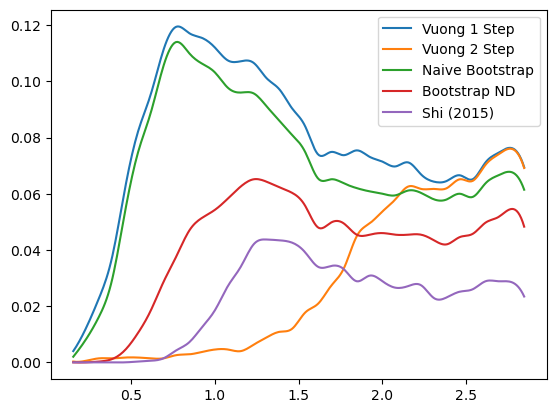

0.001 2.51188643150958


In [11]:
nobs =100
data_tuned_c = .8
calc_c =lambda nobs: (nobs**(-1/2)/100,nobs**(1/5) )

c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

Quantiles: 1th: 0.51, 5th: 3.14, 10th: 9.41, 30th: 71.31, 50th: 210.66, 70th: 514.04, 90th: 1347.37, 95th: 1892.34, 99th: 3137.51
bonus term 2.185718777193678 // variance stats 0.11569484235788174 //part1 2.51188643150958 //part2 0.8701503180142249
1.9360106106487878 -1.1758892107927206 2.4342492240763867
-2.4354269437385683 -1.1758892107927206 -1.9371883303109692
---
Quantiles: 1th: 0.40, 5th: 2.09, 10th: 6.01, 30th: 48.45, 50th: 148.22, 70th: 343.34, 90th: 866.77, 95th: 1205.53, 99th: 2111.20
bonus term 0.645651490047239 // variance stats 1.5416536564419534 //part1 2.51188643150958 //part2 0.2570384878663558
-0.8546259936037297 -0.09812806823231211 2.031777731332475
-2.145928973698208 -0.09812806823231211 0.7404747512379971
---
Quantiles: 1th: 0.43, 5th: 3.48, 10th: 12.34, 30th: 104.74, 50th: 336.32, 70th: 792.98, 90th: 2082.04, 95th: 2925.49, 99th: 4695.83
bonus term 0.6795225309115298 // variance stats 3.360817562244009 //part1 2.51188643150958 //part2 0.27052279210854047
-0.821736

0.16680976531764996 -0.5787050646673229 2.1392321208268203
-2.2634597762975677 -0.5787050646673229 -0.2910374207883977
---
Quantiles: 1th: 0.25, 5th: 1.96, 10th: 6.01, 30th: 49.63, 50th: 148.27, 70th: 341.69, 90th: 903.24, 95th: 1255.27, 99th: 2125.34
bonus term 1.3558093539926412 // variance stats 0.4581686066270036 //part1 2.51188643150958 //part2 0.5397574257279752
0.39524276166609107 -0.8247973271144942 2.2429899814645933
-2.3163759463191917 -0.8247973271144942 -0.46862872652068877
---
Quantiles: 1th: 0.39, 5th: 3.26, 10th: 11.85, 30th: 117.99, 50th: 358.19, 70th: 824.31, 90th: 2052.92, 95th: 2920.43, 99th: 5110.33
bonus term 1.2439622460805255 // variance stats 1.259164632604169 //part1 2.51188643150958 //part2 0.4952302900624913
0.256074925337506 -0.46032003495452284 2.2547197326422173
-2.231849566823545 -0.46032003495452284 -0.233204759518834
---
Quantiles: 1th: 0.35, 5th: 3.81, 10th: 11.81, 30th: 103.87, 50th: 305.25, 70th: 726.37, 90th: 1813.26, 95th: 2581.87, 99th: 4639.36
bo

Quantiles: 1th: 0.67, 5th: 3.63, 10th: 11.48, 30th: 107.98, 50th: 314.90, 70th: 731.15, 90th: 1852.42, 95th: 2622.84, 99th: 4530.24
bonus term 1.2068311911193688 // variance stats 1.196536662137207 //part1 2.51188643150958 //part2 0.4804481508322388
0.1509660289891391 -0.44074108108297755 2.142155501562635
-2.2626963532495985 -0.44074108108297755 -0.2715068806761026
---
Quantiles: 1th: 0.56, 5th: 4.72, 10th: 15.18, 30th: 132.53, 50th: 409.94, 70th: 952.27, 90th: 2332.99, 95th: 3382.21, 99th: 5902.72
bonus term 2.3458651558479673 // variance stats 0.10100066662828618 //part1 2.51188643150958 //part2 0.933905739694673
2.214173923453773 -0.9499541232543595 2.4631091430917595
-2.4775563882421614 -0.9499541232543595 -2.228621168604175
---
Quantiles: 1th: 0.63, 5th: 5.03, 10th: 20.70, 30th: 204.44, 50th: 627.91, 70th: 1399.98, 90th: 3601.75, 95th: 5098.95, 99th: 8537.58
bonus term 1.1486489626043528 // variance stats 2.5667915760802527 //part1 2.51188643150958 //part2 0.4572853884616288
0.16

-0.7623138625910056 0.11469539570022641 2.0992042079940485
-2.0452869311915642 0.11469539570022641 0.8162311393934899
---
Quantiles: 1th: 0.67, 5th: 3.90, 10th: 10.90, 30th: 107.38, 50th: 340.60, 70th: 792.56, 90th: 2001.42, 95th: 2852.42, 99th: 4772.29
bonus term 1.593877512395025 // variance stats 0.7008549878517949 //part1 2.51188643150958 //part2 0.6345340666684302
0.8831087986332005 -0.808324239680279 2.3147775680212526
-2.304646226156849 -0.808324239680279 -0.8729774567687976
---
Quantiles: 1th: 0.55, 5th: 5.33, 10th: 18.36, 30th: 177.49, 50th: 558.81, 70th: 1321.60, 90th: 3199.61, 95th: 4608.83, 99th: 8499.97
bonus term 1.437056299591786 // variance stats 1.4354959860759322 //part1 2.51188643150958 //part2 0.5721024173565649
0.5740854631814545 -0.4535612606527037 2.272321453612552
-2.3000271360021176 -0.4535612606527037 -0.6017911455710201
---
Quantiles: 1th: 0.54, 5th: 4.38, 10th: 13.00, 30th: 129.08, 50th: 401.58, 70th: 928.46, 90th: 2204.32, 95th: 3193.05, 99th: 5456.52
bonus

Quantiles: 1th: 0.62, 5th: 4.39, 10th: 13.76, 30th: 126.94, 50th: 378.96, 70th: 904.74, 90th: 2227.44, 95th: 3233.04, 99th: 5670.10
bonus term 1.5639009588668997 // variance stats 0.8358977633314282 //part1 2.51188643150958 //part2 0.6226001857604027
0.7511709515144441 -1.0473410440110298 2.3283876324389228
-2.376630966219355 -1.0473410440110298 -0.7994142852948762
---
Quantiles: 1th: 0.62, 5th: 4.86, 10th: 13.07, 30th: 111.67, 50th: 344.72, 70th: 785.13, 90th: 2041.11, 95th: 2849.87, 99th: 5291.97
bonus term 0.9106703740225314 // variance stats 2.1356898332500194 //part1 2.51188643150958 //part2 0.36254440590900505
-0.40459457363684254 -0.22974954894031527 2.111171606709398
-2.2259353216819053 -0.22974954894031527 0.2898308586643352
---
Quantiles: 1th: 0.52, 5th: 3.90, 10th: 11.55, 30th: 104.31, 50th: 315.30, 70th: 714.52, 90th: 1816.49, 95th: 2532.15, 99th: 4247.36
bonus term 0.856579795368755 // variance stats 2.114141941964317 //part1 2.51188643150958 //part2 0.3410105586875487
-0.

Quantiles: 1th: 0.68, 5th: 5.97, 10th: 17.65, 30th: 144.20, 50th: 420.81, 70th: 981.84, 90th: 2392.06, 95th: 3500.31, 99th: 5702.22
bonus term 1.8657831288433702 // variance stats 0.518954166459691 //part1 2.51188643150958 //part2 0.7427816422902852
1.3598050958987613 -0.9474724399158487 2.3329964876340243
-2.371761161787979 -0.9474724399158487 -1.398569770052716
---
Quantiles: 1th: 0.48, 5th: 3.32, 10th: 8.82, 30th: 72.40, 50th: 217.79, 70th: 521.11, 90th: 1321.46, 95th: 1882.37, 99th: 3235.99
bonus term 0.738721206324338 // variance stats 1.8943427306442746 //part1 2.51188643150958 //part2 0.2940902092776485
-0.6337664161775542 -0.24668880873849716 2.0737368185341745
-2.1112088288262303 -0.24668880873849716 0.5962944058854985
---
Quantiles: 1th: 0.40, 5th: 2.73, 10th: 7.71, 30th: 51.54, 50th: 158.01, 70th: 383.86, 90th: 968.34, 95th: 1316.00, 99th: 2311.50
bonus term 0.45890626738625817 // variance stats 2.6212369169447407 //part1 2.51188643150958 //part2 0.1826938756584099
-1.055604

-0.11802505520931497 -0.5197468481254581 2.224669556065009
-2.3467985415872445 -0.5197468481254581 -0.00410393031292062
---
Quantiles: 1th: 0.48, 5th: 2.78, 10th: 8.86, 30th: 72.00, 50th: 214.64, 70th: 490.77, 90th: 1250.82, 95th: 1809.05, 99th: 3168.86
bonus term 0.7265324898929241 // variance stats 1.859017839145495 //part1 2.51188643150958 //part2 0.2892377938664593
-0.5600968287807273 -0.20508906515543185 2.2210586840166786
-2.0131618085665752 -0.20508906515543185 0.7679937042308305
---
Quantiles: 1th: 0.62, 5th: 5.11, 10th: 16.83, 30th: 142.75, 50th: 442.53, 70th: 1006.42, 90th: 2582.41, 95th: 3629.99, 99th: 5943.68
bonus term 0.9413737378778902 // variance stats 2.6142494086579284 //part1 2.51188643150958 //part2 0.37476763521993645
-0.3027443319384919 -0.22981198560682295 2.0870640666707625
-2.185491807694272 -0.22981198560682295 0.2043165909149823
---
Quantiles: 1th: 0.73, 5th: 4.44, 10th: 12.90, 30th: 111.54, 50th: 327.62, 70th: 764.65, 90th: 1956.82, 95th: 2652.14, 99th: 4437

Quantiles: 1th: 0.46, 5th: 2.70, 10th: 8.36, 30th: 71.99, 50th: 216.06, 70th: 529.59, 90th: 1318.92, 95th: 1901.14, 99th: 3488.00
bonus term 0.9178388470890418 // variance stats 1.4208028738110685 //part1 2.51188643150958 //part2 0.3653982264387024
-0.34160347156059245 -0.40696067857922247 2.196789760905758
-2.177281165738676 -0.40696067857922247 0.36111206672767415
---
Quantiles: 1th: 0.70, 5th: 4.65, 10th: 12.94, 30th: 98.76, 50th: 285.09, 70th: 645.39, 90th: 1569.39, 95th: 2193.17, 99th: 3940.05
bonus term 0.8642855605262595 // variance stats 1.8642231874898878 //part1 2.51188643150958 //part2 0.3440782790513526
-0.3476681695284733 -0.4189176271015241 2.2362052275609168
-2.0762392905809923 -0.4189176271015241 0.5076341065083977
---
Quantiles: 1th: 0.40, 5th: 2.57, 10th: 7.82, 30th: 67.88, 50th: 200.35, 70th: 455.81, 90th: 1149.86, 95th: 1643.48, 99th: 2673.26
bonus term 0.7951956168061507 // variance stats 1.478583790202172 //part1 2.51188643150958 //part2 0.31657307704323967
-0.622

-0.33010374970379663 -0.7836810190246183 2.221198095909426
-2.305103276742545 -0.7836810190246183 0.24619856887067765
---
Quantiles: 1th: 0.57, 5th: 3.88, 10th: 12.36, 30th: 108.72, 50th: 348.95, 70th: 810.22, 90th: 2084.74, 95th: 2997.14, 99th: 5342.70
bonus term 0.6509108292314656 // variance stats 3.5167087193760866 //part1 2.51188643150958 //part2 0.2591322685079694
-0.8628400746864111 -0.1311029438052481 2.109627835036265
-2.1646617331493423 -0.1311029438052481 0.8078061765733341
---
Quantiles: 1th: 0.63, 5th: 3.96, 10th: 13.48, 30th: 109.80, 50th: 341.81, 70th: 802.03, 90th: 2059.61, 95th: 2928.73, 99th: 4917.41
bonus term 1.1932190327459877 // variance stats 1.3486643516035215 //part1 2.51188643150958 //part2 0.4750290529770859
0.1424931899396078 -0.8863435014822771 2.202873794743263
-2.243944875552368 -0.8863435014822771 -0.18356427074871254
---
Quantiles: 1th: 0.47, 5th: 2.86, 10th: 7.79, 30th: 61.00, 50th: 192.66, 70th: 466.98, 90th: 1226.02, 95th: 1819.47, 99th: 3140.20
bonu

Quantiles: 1th: 0.71, 5th: 5.13, 10th: 16.21, 30th: 129.41, 50th: 388.56, 70th: 898.71, 90th: 2317.30, 95th: 3449.55, 99th: 5792.58
bonus term 1.803246182948712 // variance stats 0.5534985644130299 //part1 2.51188643150958 //part2 0.7178852357051059
1.2634814282799438 -1.4536946717700836 2.3976555318833075
-2.3430109376174806 -1.4536946717700836 -1.208836834014117
---
Quantiles: 1th: 0.53, 5th: 3.06, 10th: 10.14, 30th: 94.99, 50th: 275.24, 70th: 646.46, 90th: 1635.94, 95th: 2311.07, 99th: 3939.84
bonus term 1.6669784706733977 // variance stats 0.49206874878248336 //part1 2.51188643150958 //part2 0.6636360823333824
1.0104092465426695 -1.6093146411777273 2.348332728108408
-2.323547694804126 -1.6093146411777273 -0.9856242132383873
---
Quantiles: 1th: 0.58, 5th: 5.19, 10th: 17.03, 30th: 146.21, 50th: 420.95, 70th: 1016.06, 90th: 2555.24, 95th: 3554.33, 99th: 5980.60
bonus term 0.9171864251942285 // variance stats 2.6812074554602505 //part1 2.51188643150958 //part2 0.3651384926041512
-0.420

-0.7332126638535189 -0.43230896539426966 2.169568844471597
-1.9450652114504376 -0.43230896539426966 0.957716296874678
---
Quantiles: 1th: 0.66, 5th: 4.04, 10th: 13.26, 30th: 102.17, 50th: 316.77, 70th: 742.56, 90th: 1872.29, 95th: 2704.28, 99th: 4632.18
bonus term 1.371819484324699 // variance stats 0.9433523138083728 //part1 2.51188643150958 //part2 0.5461311734146636
0.40676960906933646 -1.563811984965523 2.3273225795253167
-2.3368693595800614 -1.563811984965523 -0.41631638912408114
---
Quantiles: 1th: 0.60, 5th: 4.29, 10th: 12.23, 30th: 100.81, 50th: 302.15, 70th: 705.05, 90th: 1758.56, 95th: 2516.48, 99th: 4280.66
bonus term 0.5323754390943422 // variance stats 4.024404950060413 //part1 2.51188643150958 //part2 0.21194247973002428
-1.065699832078176 -0.14853273249774993 2.1034300608030017
-2.1304507102668606 -0.14853273249774993 1.0386791826143174
---
Quantiles: 1th: 0.42, 5th: 3.85, 10th: 10.19, 30th: 92.02, 50th: 292.22, 70th: 725.22, 90th: 1858.95, 95th: 2656.47, 99th: 4415.66
b

Quantiles: 1th: 0.42, 5th: 3.04, 10th: 7.87, 30th: 72.19, 50th: 218.88, 70th: 517.48, 90th: 1234.88, 95th: 1828.16, 99th: 3065.15
bonus term 0.34421511359122803 // variance stats 4.9142752553657525 //part1 2.51188643150958 //part2 0.13703450493355443
-1.3401472753380554 0.23570922352883633 2.041483436819791
-2.0285775025205117 0.23570922352883633 1.353053209637335
---
Quantiles: 1th: 0.62, 5th: 4.85, 10th: 12.70, 30th: 109.76, 50th: 324.68, 70th: 761.75, 90th: 1867.18, 95th: 2592.92, 99th: 4571.31
bonus term 1.0080261387181952 // variance stats 1.7187812824171391 //part1 2.51188643150958 //part2 0.40130243392906784
-0.2265358766129242 -0.7670224997252544 2.14316538027198
-2.2425881540493147 -0.7670224997252544 0.12711310283558924
---
Quantiles: 1th: 0.48, 5th: 3.07, 10th: 8.53, 30th: 66.61, 50th: 197.80, 70th: 470.41, 90th: 1208.68, 95th: 1662.35, 99th: 2903.39
bonus term 0.556095788432686 // variance stats 2.5478158162650404 //part1 2.51188643150958 //part2 0.2213857208896529
-0.83144

-0.72959473750954 -0.5172176645033503 2.179950031571598
-1.984874536538617 -0.5172176645033503 0.9246702325425215
---
Quantiles: 1th: 0.35, 5th: 2.97, 10th: 9.21, 30th: 87.06, 50th: 263.00, 70th: 614.89, 90th: 1608.87, 95th: 2324.08, 99th: 3873.73
bonus term 0.9344685286464915 // variance stats 1.6371089722276109 //part1 2.51188643150958 //part2 0.3720186219107444
-0.31154303730222105 -0.7500420100354273 2.1113661620589754
-2.1804800945952043 -0.7500420100354273 0.24242910476599233
---
Quantiles: 1th: 0.57, 5th: 3.66, 10th: 11.45, 30th: 98.26, 50th: 323.78, 70th: 811.47, 90th: 2016.16, 95th: 2883.66, 99th: 5005.01
bonus term 0.9904681510896736 // variance stats 1.9562545978268788 //part1 2.51188643150958 //part2 0.39431247315366375
-0.24555341142799839 -0.8340311251212825 2.1641687800890077
-2.2264897136073456 -0.8340311251212825 0.18323247790966057
---
Quantiles: 1th: 0.49, 5th: 2.97, 10th: 9.30, 30th: 82.85, 50th: 247.02, 70th: 578.50, 90th: 1452.30, 95th: 2045.35, 99th: 3595.90
bonu

Quantiles: 1th: 0.63, 5th: 3.82, 10th: 11.50, 30th: 80.90, 50th: 264.22, 70th: 653.34, 90th: 1637.71, 95th: 2390.99, 99th: 4145.30
bonus term 0.8749243998681541 // variance stats 1.8824092998455992 //part1 2.51188643150958 //part2 0.3483136772797274
-0.4178670475103197 -1.2222319838941034 2.087764551344049
-2.167715847246628 -1.2222319838941034 0.33791575160774123
---
Quantiles: 1th: 0.56, 5th: 4.25, 10th: 11.85, 30th: 101.61, 50th: 304.96, 70th: 717.57, 90th: 1749.06, 95th: 2492.02, 99th: 4361.37
bonus term 1.331578359462779 // variance stats 0.9648703286407309 //part1 2.51188643150958 //part2 0.5301108930559947
0.3601381893157528 -2.112885633323876 2.193064277979971
-2.303018529609805 -2.112885633323876 -0.47009244094558666
---
Quantiles: 1th: 0.45, 5th: 2.55, 10th: 7.51, 30th: 68.51, 50th: 210.32, 70th: 489.43, 90th: 1255.89, 95th: 1795.40, 99th: 2906.30
bonus term 0.7512588550441144 // variance stats 1.7346217881500094 //part1 2.51188643150958 //part2 0.2990815371348723
-0.73998910

-1.026286045317036 -0.5366680610657887 2.1828954008956254
-2.214920807740872 -0.5366680610657887 0.9942606384717891
---
Quantiles: 1th: 0.44, 5th: 2.34, 10th: 7.45, 30th: 64.83, 50th: 212.24, 70th: 506.83, 90th: 1312.23, 95th: 1808.77, 99th: 2937.57
bonus term 0.940341563946377 // variance stats 1.3080068177226967 //part1 2.51188643150958 //part2 0.37435671937654263
-0.34931684762479365 -2.005202266741237 2.1634550669162476
-2.2299999755175475 -2.005202266741237 0.2827719390234938
---
Quantiles: 1th: 0.42, 5th: 3.02, 10th: 9.05, 30th: 86.07, 50th: 257.44, 70th: 603.48, 90th: 1484.76, 95th: 2102.86, 99th: 3508.81
bonus term 0.9242238988717979 // variance stats 1.5845396087658332 //part1 2.51188643150958 //part2 0.367940161337773
-0.4764644476343524 -2.236941454725671 2.164483169092786
-2.324912245377948 -2.236941454725671 0.3160353713491902
---
Quantiles: 1th: 0.63, 5th: 4.52, 10th: 14.43, 30th: 138.91, 50th: 424.42, 70th: 1003.29, 90th: 2502.55, 95th: 3566.67, 99th: 5911.50
bonus term 

Quantiles: 1th: 0.69, 5th: 4.20, 10th: 12.85, 30th: 98.78, 50th: 295.62, 70th: 691.67, 90th: 1805.55, 95th: 2571.77, 99th: 4358.07
bonus term 0.41944835742890574 // variance stats 5.210902405440224 //part1 2.51188643150958 //part2 0.16698539876933363
-1.18101258246702 0.15941007412951902 2.059276459102635
-2.0199092973248316 0.15941007412951902 1.2203797442448232
---
Quantiles: 1th: 0.95, 5th: 6.54, 10th: 21.90, 30th: 192.62, 50th: 584.63, 70th: 1429.29, 90th: 3641.09, 95th: 5133.70, 99th: 8841.65
bonus term 1.5753013797992608 // variance stats 1.3114444532009069 //part1 2.51188643150958 //part2 0.6271387750809039
0.8537721153502645 -1.8405684901122712 2.299852373494327
-2.296830644248257 -1.8405684901122712 -0.8507503861041947
---
Quantiles: 1th: 0.59, 5th: 4.03, 10th: 11.71, 30th: 105.79, 50th: 307.51, 70th: 741.47, 90th: 1905.44, 95th: 2632.15, 99th: 4446.80
bonus term 0.9664354386098503 // variance stats 1.852649465879681 //part1 2.51188643150958 //part2 0.3847448779875956
-0.27385

-1.2186531342354863 -1.1436243903049308 2.009303177056084
-2.0723773007603605 -1.1436243903049308 1.1555790105312096
---
Quantiles: 1th: 0.53, 5th: 4.40, 10th: 13.42, 30th: 109.07, 50th: 330.16, 70th: 758.50, 90th: 1895.85, 95th: 2678.92, 99th: 4606.61
bonus term 1.2592023505808483 // variance stats 1.1504645580371737 //part1 2.51188643150958 //part2 0.5012974849440544
0.2732577192425846 -2.2880569945588256 2.219648692267676
-2.2451469819191123 -2.2880569945588256 -0.2987560088940207
---
Quantiles: 1th: 0.67, 5th: 4.44, 10th: 15.55, 30th: 119.16, 50th: 355.44, 70th: 828.23, 90th: 2003.00, 95th: 2812.32, 99th: 5015.91
bonus term 1.2288403595148263 // variance stats 1.296767446787696 //part1 2.51188643150958 //part2 0.4892101585883899
0.18154505410683014 -2.2646336692054327 2.2392456925171675
-2.2761356649228226 -2.2646336692054327 -0.21843502651248514
---
Quantiles: 1th: 0.62, 5th: 3.51, 10th: 9.95, 30th: 85.43, 50th: 267.72, 70th: 646.36, 90th: 1651.50, 95th: 2407.86, 99th: 3938.78
bon

Quantiles: 1th: 0.49, 5th: 3.82, 10th: 12.81, 30th: 107.31, 50th: 339.97, 70th: 809.48, 90th: 2011.83, 95th: 2808.17, 99th: 5010.19
bonus term 1.0142204468738723 // variance stats 1.8009689252735877 //part1 2.51188643150958 //part2 0.40376843242246085
-0.234182330636412 -1.6474232729857914 2.177613480592679
-2.2626232243841566 -1.6474232729857914 0.1491725868449347
---
Quantiles: 1th: 0.45, 5th: 3.62, 10th: 9.98, 30th: 78.74, 50th: 251.20, 70th: 604.02, 90th: 1544.27, 95th: 2230.63, 99th: 3749.78
bonus term 1.2035685790317416 // variance stats 1.0087920807758444 //part1 2.51188643150958 //part2 0.4791492815654199
0.14439225560684726 -3.039657358737213 2.2486135140212156
-2.262744902456636 -3.039657358737213 -0.15852364404226774
---
Quantiles: 1th: 0.50, 5th: 3.74, 10th: 12.64, 30th: 115.02, 50th: 358.24, 70th: 839.72, 90th: 2076.17, 95th: 2948.61, 99th: 5165.65
bonus term 1.023873470072363 // variance stats 1.8851284937611428 //part1 2.51188643150958 //part2 0.4076113701752993
-0.19444

-0.2373893100341855 -3.5045235265027848 2.0097859312470865
-2.1488983745841277 -3.5045235265027848 0.09827686669714425
---
Quantiles: 1th: 0.37, 5th: 2.58, 10th: 8.34, 30th: 69.39, 50th: 210.06, 70th: 487.63, 90th: 1225.96, 95th: 1747.96, 99th: 3173.23
bonus term 0.5981326342576414 // variance stats 2.414666681942448 //part1 2.51188643150958 //part2 0.23812089064001946
-0.9312433551585505 -1.5411334062495596 1.9925888629490762
-2.1275086236738336 -1.5411334062495596 0.7963235944337934
---
Quantiles: 1th: 0.48, 5th: 4.08, 10th: 13.08, 30th: 113.67, 50th: 341.98, 70th: 788.25, 90th: 1977.26, 95th: 2945.93, 99th: 5197.58
bonus term 0.41604721150265245 // variance stats 6.108182248774947 //part1 2.51188643150958 //part2 0.1656313781879934
-1.2340514432552414 -0.11965539152633149 2.012045216229803
-2.066145866260546 -0.11965539152633149 1.1799507932244981
---
Quantiles: 1th: 0.53, 5th: 3.86, 10th: 12.62, 30th: 108.45, 50th: 345.05, 70th: 794.63, 90th: 1965.59, 95th: 2766.05, 99th: 4629.44
b

Quantiles: 1th: 0.42, 5th: 3.54, 10th: 11.66, 30th: 107.67, 50th: 333.00, 70th: 784.92, 90th: 1872.54, 95th: 2658.91, 99th: 4916.28
bonus term 0.7263693336792101 // variance stats 2.9127662693540244 //part1 2.51188643150958 //part2 0.28917284020785944
-0.6516640648526365 -1.5835711540957675 2.0968648402182684
-2.1044027322110566 -1.5835711540957675 0.6441261728598484
---
Quantiles: 1th: 0.53, 5th: 2.84, 10th: 7.62, 30th: 59.63, 50th: 176.10, 70th: 401.94, 90th: 1041.73, 95th: 1485.91, 99th: 2567.72
bonus term 0.7121181846334932 // variance stats 1.593909093857877 //part1 2.51188643150958 //part2 0.28349935558413286
-0.7285427489471554 -2.6948677238216505 2.1700954287328424
-2.152779118214142 -2.6948677238216505 0.745859059465856
---
Quantiles: 1th: 0.59, 5th: 3.46, 10th: 11.05, 30th: 107.82, 50th: 331.70, 70th: 778.39, 90th: 1920.78, 95th: 2753.27, 99th: 4421.92
bonus term 0.5246335658030682 // variance stats 4.530976714271689 //part1 2.51188643150958 //part2 0.20886038445925148
-1.041

0.0028394641942358655 -3.3258194609921254 2.2352313423357932
-2.2255468435107524 -3.3258194609921254 0.0068450346308053
---
Quantiles: 1th: 0.64, 5th: 3.60, 10th: 12.50, 30th: 108.93, 50th: 342.23, 70th: 814.38, 90th: 2040.29, 95th: 2871.02, 99th: 4953.59
bonus term 1.3301439601807736 // variance stats 1.1238182912546077 //part1 2.51188643150958 //part2 0.5295398484163915
0.4429741136753668 -3.5436067744152804 2.1860618526759397
-2.2173138066861804 -3.5436067744152804 -0.4742260676856075
---
Quantiles: 1th: 0.57, 5th: 3.53, 10th: 9.84, 30th: 88.92, 50th: 278.28, 70th: 653.52, 90th: 1583.78, 95th: 2233.39, 99th: 4079.76
bonus term 0.8940421818460456 // variance stats 1.767920999419318 //part1 2.51188643150958 //part2 0.35592460337020443
-0.3198002471002217 -4.0673034943736095 2.1118980645653305
-2.107884610792313 -4.0673034943736095 0.3238137008732395
---
Quantiles: 1th: 0.35, 5th: 2.21, 10th: 6.22, 30th: 54.55, 50th: 168.56, 70th: 409.15, 90th: 1048.17, 95th: 1457.18, 99th: 2452.27
bon

Quantiles: 1th: 0.50, 5th: 2.21, 10th: 6.10, 30th: 51.34, 50th: 152.39, 70th: 372.65, 90th: 937.83, 95th: 1341.69, 99th: 2371.56
bonus term 0.4934436200762841 // variance stats 2.3298202767775686 //part1 2.51188643150958 //part2 0.19644344341624434
-1.170210376345404 -1.9535727741854414 2.086490764850571
-2.157097616497972 -1.9535727741854414 1.0996035246980027
---
Quantiles: 1th: 0.45, 5th: 3.24, 10th: 10.12, 30th: 84.18, 50th: 246.04, 70th: 575.99, 90th: 1461.28, 95th: 2060.97, 99th: 3597.34
bonus term 0.7029023780768026 // variance stats 2.300733015522465 //part1 2.51188643150958 //part2 0.27983047691148044
-0.8520846629333448 -3.022399287173038 2.0801796632168164
-2.25788941908695 -3.022399287173038 0.6743749070632113
---
Quantiles: 1th: 0.71, 5th: 5.10, 10th: 16.12, 30th: 125.11, 50th: 395.29, 70th: 921.24, 90th: 2380.52, 95th: 3453.86, 99th: 5637.01
bonus term 1.2764172387125943 // variance stats 1.394760412500624 //part1 2.51188643150958 //part2 0.5081508553495787
0.317770914441

-0.45744329134983164 -3.2487476332592125 2.0860643721973413
-2.266000282094335 -3.2487476332592125 0.2775073814528378
---
Quantiles: 1th: 0.55, 5th: 3.83, 10th: 11.54, 30th: 93.09, 50th: 286.90, 70th: 641.65, 90th: 1541.08, 95th: 2278.83, 99th: 3987.58
bonus term 0.7778254902779601 // variance stats 2.116115295829392 //part1 2.51188643150958 //part2 0.3096579051189455
-0.5719847933213874 -2.310789012772277 2.0223834114888706
-2.1276357738773077 -2.310789012772277 0.4667324309329502
---
Quantiles: 1th: 0.66, 5th: 4.43, 10th: 14.98, 30th: 123.08, 50th: 384.70, 70th: 917.65, 90th: 2399.20, 95th: 3397.18, 99th: 5901.46
bonus term 0.504873239978294 // variance stats 5.823300360008249 //part1 2.51188643150958 //part2 0.20099365705593544
-1.0779571844736393 -0.589701795208947 1.959060979997571
-2.087703664430227 -0.589701795208947 0.9493145000409828
---
Quantiles: 1th: 0.72, 5th: 4.43, 10th: 12.19, 30th: 108.18, 50th: 321.60, 70th: 757.98, 90th: 1937.03, 95th: 2768.30, 99th: 4677.46
bonus ter

Quantiles: 1th: 0.54, 5th: 3.76, 10th: 11.90, 30th: 108.48, 50th: 326.61, 70th: 758.70, 90th: 1912.97, 95th: 2730.40, 99th: 4524.86
bonus term 0.5142165840258833 // variance stats 4.527932955301589 //part1 2.51188643150958 //part2 0.2047133093182291
-1.1079506133332928 -1.0639797415793075 2.0767232581294284
-2.1363837813850597 -1.0639797415793075 1.0482900900776615
---
Quantiles: 1th: 0.55, 5th: 3.92, 10th: 13.63, 30th: 130.18, 50th: 396.69, 70th: 941.47, 90th: 2345.40, 95th: 3384.92, 99th: 5611.70
bonus term 0.8258766691714848 // variance stats 2.9040927294706176 //part1 2.51188643150958 //part2 0.32878742399000654
-0.5769927390360102 -2.500714193620864 2.101955156077421
-2.22874607737898 -2.500714193620864 0.4502018177344512
---
Quantiles: 1th: 0.45, 5th: 3.75, 10th: 12.44, 30th: 110.76, 50th: 326.54, 70th: 730.13, 90th: 1857.77, 95th: 2648.73, 99th: 4500.78
bonus term 0.6648349456515125 // variance stats 3.122837196950849 //part1 2.51188643150958 //part2 0.2646755590984118
-0.782779

0.3000479808188048 -3.405273835050731 2.291316966141939
-2.2830031980830583 -3.405273835050731 -0.2917342127599238
---
Quantiles: 1th: 0.78, 5th: 3.56, 10th: 8.91, 30th: 64.69, 50th: 192.68, 70th: 459.32, 90th: 1160.19, 95th: 1629.44, 99th: 2794.05
bonus term 0.7799699725033833 // variance stats 1.5632339067219465 //part1 2.51188643150958 //part2 0.310511638870011
-0.6260258498082717 -4.836242333270617 2.0897852548285645
-2.185965794815038 -4.836242333270617 0.5298453098217982
---
Quantiles: 1th: 0.54, 5th: 3.69, 10th: 12.15, 30th: 101.94, 50th: 319.78, 70th: 757.68, 90th: 1932.81, 95th: 2735.02, 99th: 4840.13
bonus term 0.8473441473467147 // variance stats 2.2471141928784664 //part1 2.51188643150958 //part2 0.33733378098526623
-0.5837747591275129 -2.924494752149566 2.1933959898889817
-2.2784630538209423 -2.924494752149566 0.4987076951955525
---
Quantiles: 1th: 0.42, 5th: 2.99, 10th: 10.77, 30th: 87.98, 50th: 275.37, 70th: 634.49, 90th: 1633.72, 95th: 2312.32, 99th: 3977.81
bonus term 

Quantiles: 1th: 0.16, 5th: 1.61, 10th: 5.25, 30th: 48.63, 50th: 158.04, 70th: 360.24, 90th: 909.78, 95th: 1264.91, 99th: 2230.29
bonus term 0.6982957298595244 // variance stats 1.430223852498068 //part1 2.51188643150958 //part2 0.2779965372239645
-0.7418697831215566 -5.691817874815081 2.1107024985329432
-2.1384612428406053 -5.691817874815081 0.7141110388138946
---
Quantiles: 1th: 0.59, 5th: 4.08, 10th: 12.38, 30th: 116.19, 50th: 364.38, 70th: 904.07, 90th: 2276.96, 95th: 3226.24, 99th: 5525.13
bonus term 0.9266902822227596 // variance stats 2.4190082215442614 //part1 2.51188643150958 //part2 0.36892204623512465
-0.4821921693988983 -3.386338172034074 2.2063736736053974
-2.3355727338444177 -3.386338172034074 0.35299310915987797
---
Quantiles: 1th: 0.67, 5th: 5.62, 10th: 15.97, 30th: 143.52, 50th: 418.65, 70th: 1064.88, 90th: 2639.25, 95th: 3653.30, 99th: 6558.72
bonus term 0.8460062230157351 // variance stats 3.1867659432721567 //part1 2.51188643150958 //part2 0.3368011437154453
-0.45787

-0.39147473450257314 -3.734678556598956 2.1640974035482783
-2.2281451907133576 -3.734678556598956 0.32742694733749356
---
Quantiles: 1th: 0.51, 5th: 3.63, 10th: 9.58, 30th: 68.65, 50th: 203.50, 70th: 492.89, 90th: 1191.34, 95th: 1655.40, 99th: 2886.70
bonus term 0.6682245117888869 // variance stats 1.9780461730429768 //part1 2.51188643150958 //part2 0.26602496968276584
-0.8655826714305977 -4.154849866994913 2.1047878831110096
-2.2020316950083716 -4.154849866994913 0.7683388595332359
---
Quantiles: 1th: 0.52, 5th: 3.42, 10th: 12.38, 30th: 110.78, 50th: 330.79, 70th: 791.70, 90th: 2071.94, 95th: 2940.57, 99th: 4922.24
bonus term 1.1187133551816628 // variance stats 1.5063295055710928 //part1 2.51188643150958 //part2 0.44536780849178137
-0.07110562240570972 -4.682758696326112 2.2210238210785564
-2.3085323327690355 -4.682758696326112 -0.016402889284769018
---
Quantiles: 1th: 0.52, 5th: 3.06, 10th: 9.54, 30th: 85.64, 50th: 260.18, 70th: 631.19, 90th: 1574.04, 95th: 2213.20, 99th: 4023.59
bo

Quantiles: 1th: 0.53, 5th: 3.67, 10th: 10.88, 30th: 104.19, 50th: 326.06, 70th: 758.80, 90th: 2020.44, 95th: 2837.48, 99th: 4879.18
bonus term 1.119304893583697 // variance stats 1.4603933485081684 //part1 2.51188643150958 //part2 0.4456033041712889
0.014378737649169474 -4.589310239714403 2.200236483509123
-2.2242310495182243 -4.589310239714403 -0.03837330365827101
---
Quantiles: 1th: 0.55, 5th: 3.05, 10th: 9.58, 30th: 85.00, 50th: 256.05, 70th: 623.64, 90th: 1570.05, 95th: 2340.48, 99th: 4052.38
bonus term 0.4589173951847002 // variance stats 4.273392682124046 //part1 2.51188643150958 //part2 0.18269830571476214
-1.128102226860145 -2.4201813684119546 2.0358218825379493
-2.0459370172295452 -2.4201813684119546 1.117987092168549
---
Quantiles: 1th: 0.66, 5th: 3.89, 10th: 10.37, 30th: 91.63, 50th: 296.41, 70th: 695.21, 90th: 1712.02, 95th: 2368.27, 99th: 4053.02
bonus term 0.771025452357382 // variance stats 2.4203225380019875 //part1 2.51188643150958 //part2 0.30695076126272763
-0.541879

-0.4748402617778259 -4.1254667747941784 2.0284340799284406
-2.086243198552138 -4.1254667747941784 0.41703114315412854
---
Quantiles: 1th: 0.40, 5th: 3.34, 10th: 11.83, 30th: 100.32, 50th: 303.17, 70th: 687.33, 90th: 1718.48, 95th: 2479.91, 99th: 4392.81
bonus term 0.9659701485214042 // variance stats 1.7270127072087442 //part1 2.51188643150958 //part2 0.3845596426669977
-0.4558715187902229 -5.804805168786289 2.281680895270549
-2.387811815833031 -5.804805168786289 0.34974059822774084
---
Quantiles: 1th: 0.46, 5th: 3.26, 10th: 10.51, 30th: 90.21, 50th: 268.39, 70th: 637.46, 90th: 1619.34, 95th: 2310.47, 99th: 4225.09
bonus term 0.9382579678298437 // variance stats 1.6572369352668685 //part1 2.51188643150958 //part2 0.37352722482201334
-0.5700311143301701 -4.978447848703754 2.218341507184102
-2.446547049989858 -4.978447848703754 0.3418255715244148
---
Quantiles: 1th: 0.48, 5th: 3.50, 10th: 11.52, 30th: 90.44, 50th: 266.70, 70th: 641.07, 90th: 1600.96, 95th: 2269.33, 99th: 3833.69
bonus te

Quantiles: 1th: 0.39, 5th: 2.24, 10th: 6.21, 30th: 51.06, 50th: 146.72, 70th: 357.57, 90th: 880.65, 95th: 1291.29, 99th: 2236.03
bonus term 0.5525810568627703 // variance stats 1.898584452165492 //part1 2.51188643150958 //part2 0.21998648104909868
-1.245856151957161 -8.052890948440728 2.070819705298715
-2.351018265682702 -8.052890948440728 0.9656575915731743
---
Quantiles: 1th: 0.42, 5th: 3.00, 10th: 8.69, 30th: 65.79, 50th: 214.76, 70th: 528.77, 90th: 1295.39, 95th: 1816.77, 99th: 3081.81
bonus term 0.7295096773495933 // variance stats 1.940908934589198 //part1 2.51188643150958 //part2 0.29042303354104126
-0.7253312054807389 -6.131092047563428 2.06483412030822
-2.184350560179926 -6.131092047563428 0.6058147656090332
---
Quantiles: 1th: 0.34, 5th: 2.84, 10th: 9.85, 30th: 83.37, 50th: 255.81, 70th: 576.14, 90th: 1363.16, 95th: 1905.12, 99th: 3406.99
bonus term 0.7912089433366977 // variance stats 1.8868150547288802 //part1 2.51188643150958 //part2 0.31498595374839505
-0.7079910922972746

-0.9461939720248903 -3.203131612047737 2.189783804874244
-2.080955544091616 -3.203131612047737 1.0550222328075183
---
Quantiles: 1th: 0.35, 5th: 2.32, 10th: 7.58, 30th: 62.33, 50th: 193.97, 70th: 445.78, 90th: 1165.22, 95th: 1658.45, 99th: 2856.60
bonus term 0.7603126667284534 // variance stats 1.603703323394248 //part1 2.51188643150958 //part2 0.30268592448724874
-0.9907057439357978 -7.531387968897151 2.17789645665737
-2.511331077392705 -7.531387968897151 0.6572711232004629
---
Quantiles: 1th: 0.76, 5th: 4.47, 10th: 14.58, 30th: 144.97, 50th: 421.70, 70th: 975.26, 90th: 2563.97, 95th: 3470.19, 99th: 5871.57
bonus term 0.9615641210546411 // variance stats 2.4155347502252273 //part1 2.51188643150958 //part2 0.38280557153882366
-0.3314755231257691 -4.272498239612318 2.2113289770196185
-2.2546037652350512 -4.272498239612318 0.2882007349103364
---
Quantiles: 1th: 0.47, 5th: 3.57, 10th: 9.90, 30th: 78.07, 50th: 246.39, 70th: 572.35, 90th: 1477.15, 95th: 2044.44, 99th: 3770.66
bonus term 0.6

Quantiles: 1th: 0.34, 5th: 2.51, 10th: 8.58, 30th: 76.93, 50th: 238.63, 70th: 555.29, 90th: 1414.76, 95th: 2044.84, 99th: 3399.30
bonus term 0.6190041646055845 // variance stats 2.6341347404332 //part1 2.51188643150958 //part2 0.2464299965319605
-0.9628105236411212 -5.067240023729185 2.1303527950436107
-2.2008188528522905 -5.067240023729185 0.8923444658324418
---
Quantiles: 1th: 0.36, 5th: 2.34, 10th: 7.44, 30th: 68.63, 50th: 206.07, 70th: 482.29, 90th: 1177.65, 95th: 1726.82, 99th: 2944.92
bonus term 0.7696344614640198 // variance stats 1.6657347195789178 //part1 2.51188643150958 //part2 0.30639699781390556
-0.8564563879348234 -7.02428778262323 2.233188740860778
-2.395725310862863 -7.02428778262323 0.6939198179327382
---
Quantiles: 1th: 0.54, 5th: 3.04, 10th: 7.57, 30th: 64.19, 50th: 179.48, 70th: 419.56, 90th: 1068.26, 95th: 1525.13, 99th: 2650.57
bonus term 0.4349529001423214 // variance stats 3.0830842792973483 //part1 2.51188643150958 //part2 0.1731578683996974
-1.250080981688904 

-0.7043357584086252 -4.754837645208448 2.1394085098442726
-2.2422804567610686 -4.754837645208448 0.6014638114918288
---
Quantiles: 1th: 0.79, 5th: 4.16, 10th: 10.80, 30th: 84.30, 50th: 265.85, 70th: 620.18, 90th: 1575.90, 95th: 2145.51, 99th: 3552.48
bonus term 0.6601911285036555 // variance stats 2.6444714203858526 //part1 2.51188643150958 //part2 0.2628268221931106
-0.8813578364364076 -5.722150967899093 2.0244173536959424
-2.2017400934437186 -5.722150967899093 0.7040350966886315
---
Quantiles: 1th: 0.44, 5th: 2.74, 10th: 7.75, 30th: 68.38, 50th: 198.88, 70th: 465.96, 90th: 1201.23, 95th: 1676.71, 99th: 2798.84
bonus term 0.5369612742239505 // variance stats 2.664628098631986 //part1 2.51188643150958 //part2 0.21376813357809749
-1.2136229203913518 -5.732837634435376 2.0505912756543747
-2.287545468839253 -5.732837634435376 0.9766687272064739
---
Quantiles: 1th: 0.84, 5th: 5.74, 10th: 21.34, 30th: 184.63, 50th: 544.10, 70th: 1301.33, 90th: 3248.74, 95th: 4589.92, 99th: 7477.91
bonus ter

Quantiles: 1th: 0.56, 5th: 3.51, 10th: 9.70, 30th: 71.67, 50th: 212.32, 70th: 503.82, 90th: 1315.73, 95th: 1851.26, 99th: 3047.33
bonus term 0.6250576650244352 // variance stats 2.345154354137475 //part1 2.51188643150958 //part2 0.24883993845565358
-1.4038809614686707 -7.397397310940756 2.1935612448674284
-2.6539962915175406 -7.397397310940756 0.943445914818558
---
Quantiles: 1th: 0.52, 5th: 3.15, 10th: 9.94, 30th: 82.78, 50th: 250.98, 70th: 591.89, 90th: 1472.85, 95th: 2140.86, 99th: 3668.58
bonus term 0.44688422387720456 // variance stats 4.216257738940329 //part1 2.51188643150958 //part2 0.17790781393274951
-1.2263238625135968 -3.5089150427177898 2.0650759799550564
-2.120092310268006 -3.5089150427177898 1.1713075322006472
---
Quantiles: 1th: 0.57, 5th: 4.50, 10th: 17.28, 30th: 144.76, 50th: 456.06, 70th: 1072.50, 90th: 2710.16, 95th: 3858.74, 99th: 6434.50
bonus term 0.6771541878015862 // variance stats 4.380240275334594 //part1 2.51188643150958 //part2 0.269579937734141
-0.92183768

-0.9861640745816873 -5.772353860998317 2.1615630058560575
-2.56872252402297 -5.772353860998317 0.5790045564147748
---
Quantiles: 1th: 0.45, 5th: 3.16, 10th: 8.75, 30th: 68.41, 50th: 200.94, 70th: 467.26, 90th: 1152.78, 95th: 1699.19, 99th: 3033.65
bonus term 0.6128149765322307 // variance stats 2.1603073466997147 //part1 2.51188643150958 //part2 0.24396603638005418
-1.1244538054427553 -8.225232547673002 1.961404014526926
-2.3500837585072167 -8.225232547673002 0.7357740614624645
---
Quantiles: 1th: 0.64, 5th: 4.72, 10th: 15.78, 30th: 133.56, 50th: 423.15, 70th: 982.29, 90th: 2451.29, 95th: 3443.38, 99th: 5659.39
bonus term 0.7212534106198424 // variance stats 3.7153785463176345 //part1 2.51188643150958 //part2 0.28713615455392516
-0.7799151699680745 -4.623374498025869 1.9789837615825336
-2.222421991207759 -4.623374498025869 0.5364769403428488
---
Quantiles: 1th: 0.32, 5th: 2.79, 10th: 8.54, 30th: 72.46, 50th: 212.92, 70th: 501.90, 90th: 1262.77, 95th: 1758.92, 99th: 3147.88
bonus term 0

Quantiles: 1th: 0.38, 5th: 3.12, 10th: 9.31, 30th: 81.32, 50th: 236.21, 70th: 568.17, 90th: 1442.91, 95th: 2005.00, 99th: 3620.48
bonus term 0.6580280507725202 // variance stats 2.433636200429331 //part1 2.51188643150958 //part2 0.26196568543788107
-0.9103463590962446 -7.491558316554173 2.000745618746953
-2.2264024606412853 -7.491558316554173 0.6846895172019126
---
Quantiles: 1th: 0.66, 5th: 3.97, 10th: 11.99, 30th: 106.67, 50th: 333.74, 70th: 799.11, 90th: 1938.55, 95th: 2758.75, 99th: 4729.42
bonus term 0.5842039916411047 // variance stats 3.948524712049541 //part1 2.51188643150958 //part2 0.23257579813829912
-1.0952915522009545 -4.518041879673289 2.0433920714405835
-2.263699535483164 -4.518041879673289 0.874984088158374
---
Quantiles: 1th: 0.34, 5th: 2.24, 10th: 7.00, 30th: 61.08, 50th: 184.05, 70th: 435.06, 90th: 1097.04, 95th: 1564.28, 99th: 2560.83
bonus term 0.36195409101063014 // variance stats 3.8985201534629184 //part1 2.51188643150958 //part2 0.144096519042505
-1.65606769752

-1.2296724180773337 -2.3677785836526235 2.1287958358978227
-2.1949123884636217 -2.3677785836526235 1.1635558655115352
---
Quantiles: 1th: 0.54, 5th: 3.60, 10th: 12.25, 30th: 105.98, 50th: 334.11, 70th: 763.85, 90th: 1932.14, 95th: 2716.04, 99th: 4867.25
bonus term 0.9252797584624506 // variance stats 2.0145025795740126 //part1 2.51188643150958 //part2 0.3683605066119095
-0.6857753673342147 -7.523103278097626 2.422465929218427
-2.5363348842591162 -7.523103278097626 0.5719064122935255
---
Quantiles: 1th: 0.26, 5th: 1.97, 10th: 6.52, 30th: 51.06, 50th: 157.37, 70th: 371.60, 90th: 927.13, 95th: 1324.11, 99th: 2318.09
bonus term 0.4888195751151349 // variance stats 2.3505737589450137 //part1 2.51188643150958 //part2 0.19460257796024907
-1.5954964805849574 -7.203541698495596 2.270387297727141
-2.5731356308152273 -7.203541698495596 1.2927481474968712
---
Quantiles: 1th: 0.53, 5th: 3.01, 10th: 9.00, 30th: 78.85, 50th: 249.19, 70th: 562.39, 90th: 1420.72, 95th: 2060.76, 99th: 3544.66
bonus term

Quantiles: 1th: 0.45, 5th: 3.69, 10th: 11.53, 30th: 94.26, 50th: 293.78, 70th: 692.02, 90th: 1683.07, 95th: 2420.90, 99th: 4311.08
bonus term 0.5477166119869007 // variance stats 3.720940135276473 //part1 2.51188643150958 //part2 0.21804991066325277
-1.0342770951139915 -5.551752427829124 1.8993617664778566
-2.129710319087793 -5.551752427829124 0.8039285425040553
---
Quantiles: 1th: 0.77, 5th: 4.09, 10th: 11.22, 30th: 93.57, 50th: 285.05, 70th: 668.42, 90th: 1711.63, 95th: 2456.20, 99th: 4269.17
bonus term 0.7202767850823011 // variance stats 2.4873622628581162 //part1 2.51188643150958 //part2 0.28674735292448433
-1.1294950750355544 -7.347629820936104 2.1691869548722926
-2.5700486452001567 -7.347629820936104 0.7286333847076902
---
Quantiles: 1th: 0.42, 5th: 2.38, 10th: 7.71, 30th: 64.03, 50th: 211.14, 70th: 486.36, 90th: 1285.23, 95th: 1783.29, 99th: 2934.92
bonus term 0.5232745472697538 // variance stats 2.884361612471768 //part1 2.51188643150958 //part2 0.2083193494362239
-1.272058417

-1.2225298666622215 -6.294624228619955 1.9339469165856333
-2.1821618168407912 -6.294624228619955 0.9743149664070638
---
Quantiles: 1th: 0.58, 5th: 4.21, 10th: 13.39, 30th: 105.57, 50th: 321.77, 70th: 776.50, 90th: 1889.88, 95th: 2639.44, 99th: 4751.22
bonus term 0.7123238175832484 // variance stats 2.949843180317648 //part1 2.51188643150958 //part2 0.2835812195359325
-0.8212219517809359 -5.691580697928025 2.0100563461255243
-2.2458695869474328 -5.691580697928025 0.5854087109590277
---
Quantiles: 1th: 0.43, 5th: 2.91, 10th: 8.50, 30th: 84.21, 50th: 250.75, 70th: 617.30, 90th: 1515.06, 95th: 2108.33, 99th: 3893.86
bonus term 0.643943460962166 // variance stats 2.6657911695676146 //part1 2.51188643150958 //part2 0.25635850924007436
-1.0394324409743145 -7.373274429780451 2.096467670618809
-2.3273193628986464 -7.373274429780451 0.808580748694477
---
Quantiles: 1th: 0.52, 5th: 3.91, 10th: 12.14, 30th: 92.92, 50th: 287.34, 70th: 686.75, 90th: 1688.97, 95th: 2376.07, 99th: 4226.36
bonus term 0

Quantiles: 1th: 0.50, 5th: 3.00, 10th: 8.73, 30th: 75.86, 50th: 227.79, 70th: 540.41, 90th: 1370.44, 95th: 1941.11, 99th: 3418.89
bonus term 0.6008291499442484 // variance stats 2.6643449306177054 //part1 2.51188643150958 //part2 0.23919439287036767
-1.223174914521189 -7.6858449581298744 2.1413814495756367
-2.4248332144096856 -7.6858449581298744 0.93972314968714
---
Quantiles: 1th: 0.32, 5th: 2.39, 10th: 7.37, 30th: 64.83, 50th: 207.76, 70th: 491.23, 90th: 1260.44, 95th: 1717.59, 99th: 2975.42
bonus term 0.5480543374297715 // variance stats 2.7435835020589336 //part1 2.51188643150958 //part2 0.21818436158373794
-1.3455558492642246 -7.784855480363617 2.193612208600246
-2.4416645241237678 -7.784855480363617 1.0975035337407026
---
Quantiles: 1th: 0.27, 5th: 2.43, 10th: 8.04, 30th: 70.77, 50th: 220.91, 70th: 514.36, 90th: 1293.24, 95th: 1865.12, 99th: 3202.85
bonus term 0.4950409327552056 // variance stats 3.240367536237677 //part1 2.51188643150958 //part2 0.197079345047339
-1.168564220873

-1.5631379908600602 -7.703291478090392 2.255216178865568
-2.518933671361581 -7.703291478090392 1.299420498364047
---
Quantiles: 1th: 0.47, 5th: 2.51, 10th: 8.03, 30th: 70.50, 50th: 212.02, 70th: 513.89, 90th: 1302.32, 95th: 1857.11, 99th: 3244.81
bonus term 0.6770829109669126 // variance stats 2.106513596835182 //part1 2.51188643150958 //part2 0.26955156191516305
-1.861706430956798 -9.499149771297015 2.4425003549751394
-3.215872252890623 -9.499149771297015 1.0883345330413141
---
Quantiles: 1th: 0.55, 5th: 4.00, 10th: 11.10, 30th: 87.07, 50th: 262.36, 70th: 630.51, 90th: 1597.81, 95th: 2193.59, 99th: 3743.61
bonus term 0.6485947088301609 // variance stats 2.7228234428772997 //part1 2.51188643150958 //part2 0.25821020436834474
-1.4137992861658975 -8.915288901051055 2.316925773471612
-2.7109887038262195 -8.915288901051055 1.0197363558112904
---
Quantiles: 1th: 0.37, 5th: 3.92, 10th: 13.28, 30th: 117.38, 50th: 365.37, 70th: 867.08, 90th: 2087.78, 95th: 2989.73, 99th: 5182.48
bonus term 0.6

Quantiles: 1th: 0.65, 5th: 3.79, 10th: 12.84, 30th: 119.32, 50th: 378.65, 70th: 908.55, 90th: 2299.29, 95th: 3324.35, 99th: 5665.20
bonus term 0.5573234362988121 // variance stats 4.862195470261681 //part1 2.51188643150958 //part2 0.22187445630807234
-1.1358717189592586 -5.56534543186227 1.9793259635347291
-2.2505185915568826 -5.56534543186227 0.864679090937105
---
Quantiles: 1th: 0.45, 5th: 3.62, 10th: 10.21, 30th: 81.29, 50th: 236.46, 70th: 551.78, 90th: 1410.58, 95th: 2008.30, 99th: 3369.89
bonus term 0.5128727401327384 // variance stats 3.2654009411314084 //part1 2.51188643150958 //part2 0.20417831542826356
-1.414447376428461 -7.047582630194824 2.1148524874965466
-2.4401928566939377 -7.047582630194824 1.0891070072310696
---
Quantiles: 1th: 0.37, 5th: 2.50, 10th: 7.94, 30th: 58.60, 50th: 179.36, 70th: 413.02, 90th: 1031.33, 95th: 1454.90, 99th: 2441.57
bonus term 0.42173165814310276 // variance stats 3.1262914785654887 //part1 2.51188643150958 //part2 0.1678943971561854
-1.480590934

-0.710613272359502 -9.851644870941927 2.148009475297582
-2.3547218233436884 -9.851644870941927 0.5039009243133953
---
Quantiles: 1th: 0.41, 5th: 2.62, 10th: 7.75, 30th: 56.61, 50th: 175.14, 70th: 401.44, 90th: 1008.67, 95th: 1451.54, 99th: 2624.09
bonus term 0.4468960966599061 // variance stats 2.8440943307033124 //part1 2.51188643150958 //part2 0.17791254057267744
-1.997929937535677 -9.316987642188032 2.23856761729261
-2.891722130855489 -9.316987642188032 1.3447754239727983
---
Quantiles: 1th: 0.37, 5th: 2.75, 10th: 9.38, 30th: 79.58, 50th: 249.92, 70th: 612.44, 90th: 1515.90, 95th: 2166.89, 99th: 3677.43
bonus term 0.5403481246885776 // variance stats 3.344405391720503 //part1 2.51188643150958 //part2 0.21511646303365797
-1.0821044832403908 -7.059611476419727 1.786200831836326
-2.162800732617546 -7.059611476419727 0.7055045824591709
---
Quantiles: 1th: 0.42, 5th: 2.87, 10th: 9.26, 30th: 87.74, 50th: 259.39, 70th: 621.85, 90th: 1532.39, 95th: 2230.57, 99th: 3752.63
bonus term 0.334188

Quantiles: 1th: 0.68, 5th: 4.73, 10th: 15.65, 30th: 125.77, 50th: 417.75, 70th: 1002.84, 90th: 2437.77, 95th: 3438.21, 99th: 6118.76
bonus term 0.6673949604573816 // variance stats 4.20824382879943 //part1 2.51188643150958 //part2 0.2656947193493514
-0.9691368271861336 -4.171692993355174 2.0800897285160898
-2.3039267481008965 -4.171692993355174 0.7452998076013266
---
Quantiles: 1th: 0.57, 5th: 3.09, 10th: 8.96, 30th: 79.61, 50th: 249.87, 70th: 607.63, 90th: 1511.65, 95th: 2186.54, 99th: 3632.92
bonus term 0.491487093508186 // variance stats 3.7851851921871305 //part1 2.51188643150958 //part2 0.19566453616010604
-1.6731041709514691 -8.139180031875725 2.342672614299457
-2.6560783579678406 -8.139180031875725 1.3596984272830852
---
Quantiles: 1th: 0.62, 5th: 4.50, 10th: 14.68, 30th: 137.51, 50th: 399.68, 70th: 966.72, 90th: 2356.25, 95th: 3453.92, 99th: 6038.94
bonus term 0.8573597718684244 // variance stats 2.8400793061642937 //part1 2.51188643150958 //part2 0.3413210729249303
-0.67203552

-1.611157148700777 -5.778056259973755 2.114253120892756
-2.4093526764161246 -5.778056259973755 1.3160575931774086
---
Quantiles: 1th: 0.58, 5th: 4.05, 10th: 13.38, 30th: 117.57, 50th: 366.57, 70th: 907.24, 90th: 2270.70, 95th: 3250.76, 99th: 5529.98
bonus term 0.6532677997004145 // variance stats 3.9038611901280955 //part1 2.51188643150958 //part2 0.2600705953524408
-0.95662801135241 -6.709644721949461 2.0976461827739996
-2.2631636107532387 -6.709644721949461 0.791110583373171
---
Quantiles: 1th: 0.53, 5th: 3.75, 10th: 11.22, 30th: 99.64, 50th: 301.11, 70th: 697.23, 90th: 1790.02, 95th: 2486.88, 99th: 4104.34
bonus term 0.4762579074428917 // variance stats 4.627365699997884 //part1 2.51188643150958 //part2 0.18960168798581897
-1.3958945268455216 -5.482959107910959 2.104322175747711
-2.3484103417313054 -5.482959107910959 1.1518063608619273
---
Quantiles: 1th: 0.39, 5th: 2.61, 10th: 8.36, 30th: 73.10, 50th: 229.96, 70th: 520.80, 90th: 1317.09, 95th: 1855.37, 99th: 3084.81
bonus term 0.40

Quantiles: 1th: 0.58, 5th: 3.84, 10th: 9.98, 30th: 67.51, 50th: 209.00, 70th: 501.65, 90th: 1230.27, 95th: 1768.97, 99th: 3033.64
bonus term 0.359055591300093 // variance stats 4.5332581696525835 //part1 2.51188643150958 //part2 0.14294260552389293
-1.557210249979006 -7.279223354895843 2.0371643152476824
-2.275321432579192 -7.279223354895843 1.3190531326474961
---
Quantiles: 1th: 0.50, 5th: 3.19, 10th: 9.75, 30th: 82.77, 50th: 251.15, 70th: 570.09, 90th: 1385.38, 95th: 1970.60, 99th: 3403.95
bonus term 0.4511689253902423 // variance stats 3.8441560760088085 //part1 2.51188643150958 //part2 0.17961358432877125
-1.5473791767835587 -7.7477044650886135 2.229868872817116
-2.449717027564043 -7.7477044650886135 1.3275310220366316
---
Quantiles: 1th: 0.50, 5th: 2.83, 10th: 9.25, 30th: 81.77, 50th: 256.65, 70th: 576.48, 90th: 1473.58, 95th: 2093.31, 99th: 3700.98
bonus term 0.6093326761843353 // variance stats 2.743242065741957 //part1 2.51188643150958 //part2 0.24257970764153608
-1.65643304704

-0.6480732810163774 -8.821898025709437 2.113551980307817
-2.337849284427368 -8.821898025709437 0.423775976896826
---
Quantiles: 1th: 0.63, 5th: 4.03, 10th: 10.90, 30th: 91.56, 50th: 265.97, 70th: 624.44, 90th: 1576.21, 95th: 2249.93, 99th: 3734.04
bonus term 0.6173978044690385 // variance stats 2.846690744051317 //part1 2.51188643150958 //part2 0.24579049304311024
-1.7173390049311188 -9.056202130586401 2.3671069565175062
-2.952134613869196 -9.056202130586401 1.132311347579429
---
Quantiles: 1th: 0.69, 5th: 4.67, 10th: 14.77, 30th: 131.98, 50th: 394.69, 70th: 899.98, 90th: 2301.01, 95th: 3253.42, 99th: 5468.40
bonus term 0.640870846214536 // variance stats 3.9425807976706704 //part1 2.51188643150958 //part2 0.25513527927669444
-1.0718753771673268 -7.795230948252689 2.0602125060771
-2.353617069596399 -7.795230948252689 0.7784708136480278
---
Quantiles: 1th: 0.51, 5th: 3.20, 10th: 10.94, 30th: 99.59, 50th: 303.80, 70th: 730.17, 90th: 1790.40, 95th: 2603.56, 99th: 4742.88
bonus term 0.4622

Quantiles: 1th: 0.48, 5th: 3.09, 10th: 10.50, 30th: 82.57, 50th: 246.94, 70th: 576.69, 90th: 1447.81, 95th: 2092.86, 99th: 3668.26
bonus term 0.5621958453188289 // variance stats 3.0716746533539623 //part1 2.51188643150958 //part2 0.2238141972768106
-1.6551572074360368 -12.213807268191381 2.3330592029176374
-2.7795488980736947 -12.213807268191381 1.2086675122799793
---
Quantiles: 1th: 0.60, 5th: 3.66, 10th: 10.01, 30th: 79.75, 50th: 229.63, 70th: 554.31, 90th: 1353.33, 95th: 1932.96, 99th: 3419.53
bonus term 0.5487340880634569 // variance stats 3.0391782092088206 //part1 2.51188643150958 //part2 0.2184549751851964
-1.791857276435506 -10.950878723041832 2.1492539698033455
-2.8893254525624203 -10.950878723041832 1.0517857936764312
---
Quantiles: 1th: 0.36, 5th: 2.17, 10th: 5.70, 30th: 39.36, 50th: 120.14, 70th: 288.35, 90th: 711.69, 95th: 1007.37, 99th: 1738.08
bonus term 0.32101045932074146 // variance stats 3.0149881091664303 //part1 2.51188643150958 //part2 0.12779656567825892
-2.8240

-1.2780255170063604 -5.255001856820878 1.9168443503745343
-2.1521201760033324 -5.255001856820878 1.0427496913775622
---
Quantiles: 1th: 0.57, 5th: 3.74, 10th: 10.28, 30th: 86.88, 50th: 264.40, 70th: 625.13, 90th: 1538.52, 95th: 2199.80, 99th: 3624.33
bonus term 0.528441762585394 // variance stats 3.6021563448553584 //part1 2.51188643150958 //part2 0.21037645490517412
-1.5210902584287231 -9.758168283724476 2.155126696180664
-2.5779737835995107 -9.758168283724476 1.0982431710098761
---
Quantiles: 1th: 0.33, 5th: 2.57, 10th: 9.08, 30th: 83.68, 50th: 234.66, 70th: 560.06, 90th: 1385.15, 95th: 1909.51, 99th: 3209.67
bonus term 0.6252455322970302 // variance stats 2.580384686399983 //part1 2.51188643150958 //part2 0.248914729763986
-1.5323438870284782 -12.317947502346888 2.4907083149560725
-2.7828349516225384 -12.317947502346888 1.2402172503620124
---
Quantiles: 1th: 0.66, 5th: 3.77, 10th: 10.72, 30th: 94.79, 50th: 294.80, 70th: 702.48, 90th: 1813.14, 95th: 2624.20, 99th: 4320.55
bonus term 

Quantiles: 1th: 0.41, 5th: 2.05, 10th: 5.45, 30th: 40.92, 50th: 128.27, 70th: 311.75, 90th: 771.24, 95th: 1099.67, 99th: 1941.28
bonus term 0.22745094425546214 // variance stats 4.62596758014636 //part1 2.51188643150958 //part2 0.09054985185726326
-1.875462787609659 -8.762332125964138 1.9526574866549786
-2.330364676120583 -8.762332125964138 1.4977555981440542
---
Quantiles: 1th: 0.50, 5th: 3.31, 10th: 10.29, 30th: 80.00, 50th: 244.85, 70th: 583.15, 90th: 1437.48, 95th: 1996.58, 99th: 3443.68
bonus term 0.5893027515795948 // variance stats 2.875744802125301 //part1 2.51188643150958 //part2 0.234605651030743
-1.6231912754294264 -11.768950356208617 2.467429912562982
-2.801796778588616 -11.768950356208617 1.2888244094037924
---
Quantiles: 1th: 0.36, 5th: 3.25, 10th: 10.19, 30th: 99.03, 50th: 292.60, 70th: 699.88, 90th: 1752.00, 95th: 2478.29, 99th: 4107.75
bonus term 0.47755498674282615 // variance stats 4.511153095638635 //part1 2.51188643150958 //part2 0.1901180645558994
-1.3229973599956

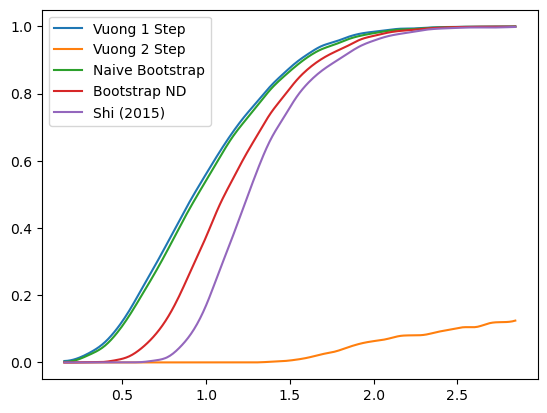

In [12]:
mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)

# sequence 4

Quantiles: 1th: 0.68, 5th: 4.14, 10th: 10.48, 30th: 90.83, 50th: 265.68, 70th: 605.51, 90th: 1519.47, 95th: 2166.13, 99th: 3524.27
bonus term 1.6407909103477398 // variance stats 1.1500001619722953 //part1 2.51188643150958 //part2 0.6532106267884356
0.9627957476110811 -0.2637351921403466 2.3536861000372746
-2.3187860730843983 -0.2637351921403466 -0.9278957206582047
---
Quantiles: 1th: 0.48, 5th: 2.81, 10th: 7.76, 30th: 62.66, 50th: 192.69, 70th: 440.07, 90th: 1164.86, 95th: 1663.23, 99th: 2847.75
bonus term 1.1077197805280066 // variance stats 2.1083370287989376 //part1 2.51188643150958 //part2 0.4409911875921457
0.025642703445365723 0.037685396090106245 2.196481420540535
-2.1897968576106472 0.037685396090106245 -0.018958140515477884
---
Quantiles: 1th: 0.54, 5th: 3.28, 10th: 10.65, 30th: 92.92, 50th: 277.95, 70th: 672.54, 90th: 1658.57, 95th: 2285.36, 99th: 4097.08
bonus term 2.1539039535980415 // variance stats 0.3798305352496626 //part1 2.51188643150958 //part2 0.8574846086109076
1.

0.301934243401543 -0.16458516633048006 2.22777011369496
-2.2791771326014287 -0.16458516633048006 -0.3533412623080116
---
Quantiles: 1th: 0.42, 5th: 2.72, 10th: 7.67, 30th: 70.69, 50th: 224.60, 70th: 528.82, 90th: 1260.59, 95th: 1821.16, 99th: 3126.22
bonus term 1.1618860705414475 // variance stats 2.1160191921022804 //part1 2.51188643150958 //part2 0.46255517604877683
0.15300700967944056 -0.02580325632404273 2.275512802552582
-2.1707651314034546 -0.02580325632404273 -0.048259338530312994
---
Quantiles: 1th: 0.47, 5th: 4.04, 10th: 12.40, 30th: 99.69, 50th: 309.54, 70th: 712.29, 90th: 1737.61, 95th: 2425.25, 99th: 4365.23
bonus term 1.2317897165547913 // variance stats 2.5203573946463185 //part1 2.51188643150958 //part2 0.49038431877452227
0.19917494145298803 0.0035070586900411466 2.258382628502182
-2.2644044916565944 0.0035070586900411466 -0.2051968046074006
---
Quantiles: 1th: 0.41, 5th: 3.36, 10th: 10.64, 30th: 87.49, 50th: 266.66, 70th: 648.11, 90th: 1674.18, 95th: 2354.59, 99th: 400

0.8915227347085551 -0.2354546123648969 2.372199629273039
-2.3266727962275993 -0.2354546123648969 -0.8459959016631151
---
Quantiles: 1th: 0.53, 5th: 4.00, 10th: 14.77, 30th: 134.06, 50th: 388.94, 70th: 953.81, 90th: 2260.84, 95th: 3226.53, 99th: 5775.84
bonus term 2.4114137840887926 // variance stats 0.1344347546297746 //part1 2.51188643150958 //part2 0.9600011186172912
2.333679645905338 -0.44000952261297716 2.4863453730192315
-2.489147922272247 -0.44000952261297716 -2.3364821951583536
---
Quantiles: 1th: 0.51, 5th: 4.55, 10th: 14.72, 30th: 133.12, 50th: 388.63, 70th: 920.41, 90th: 2371.92, 95th: 3294.29, 99th: 5946.60
bonus term 1.6255046944461822 // variance stats 1.7963642296780034 //part1 2.51188643150958 //part2 0.6471250746273967
0.8405798577410252 -0.17665106265260877 2.3068342691198027
-2.410429531151339 -0.17665106265260877 -0.9441751197725617
---
Quantiles: 1th: 0.61, 5th: 3.25, 10th: 8.46, 30th: 57.64, 50th: 181.76, 70th: 432.14, 90th: 1074.73, 95th: 1589.01, 99th: 2706.82
bo

0.7186822024264833 -0.24245775019009594 2.275885555129907
-2.3284894166355614 -0.24245775019009594 -0.7712860639321373
---
Quantiles: 1th: 0.90, 5th: 4.54, 10th: 14.75, 30th: 119.53, 50th: 350.47, 70th: 832.02, 90th: 2128.84, 95th: 3087.91, 99th: 5354.33
bonus term 1.0348816909220557 // variance stats 4.407136265255652 //part1 2.51188643150958 //part2 0.41199382183059846
-0.1002716811555331 0.223534404194937 2.195248335699103
-2.170035062999645 0.223534404194937 0.1254849538549914
---
Quantiles: 1th: 0.62, 5th: 3.84, 10th: 12.42, 30th: 104.15, 50th: 303.95, 70th: 752.31, 90th: 1908.14, 95th: 2680.71, 99th: 4336.30
bonus term 1.3555258439913782 // variance stats 2.286834869978479 //part1 2.51188643150958 //part2 0.5396445583635489
0.4915690434408805 -0.07955086214340272 2.2301643518318324
-2.219482644541876 -0.07955086214340272 -0.48088733615092405
---
Quantiles: 1th: 0.55, 5th: 2.99, 10th: 8.64, 30th: 67.63, 50th: 213.71, 70th: 503.03, 90th: 1289.31, 95th: 1831.47, 99th: 3145.59
bonus 

0.39578270992569775 -0.04859558241283693 2.264964747163057
-2.212556990108871 -0.04859558241283693 -0.3433749528715117
---
Quantiles: 1th: 0.66, 5th: 4.14, 10th: 11.98, 30th: 90.71, 50th: 269.63, 70th: 670.26, 90th: 1653.13, 95th: 2494.20, 99th: 4091.56
bonus term 1.281215852655633 // variance stats 2.3958040607302196 //part1 2.51188643150958 //part2 0.5100612179690205
0.3513057949187593 -0.16671491884095457 2.2171736149572263
-2.2111259103925067 -0.16671491884095457 -0.34525809035403965
---
Quantiles: 1th: 0.43, 5th: 3.81, 10th: 14.07, 30th: 135.42, 50th: 409.62, 70th: 970.63, 90th: 2390.70, 95th: 3344.35, 99th: 5860.85
bonus term 1.9722990630187052 // variance stats 0.9149579784238291 //part1 2.51188643150958 //part2 0.7851863994636904
1.53513000853321 -0.33757663859523235 2.402001839584058
-2.4094681175042 -0.33757663859523235 -1.542596286453352
---
Quantiles: 1th: 0.69, 5th: 4.88, 10th: 16.04, 30th: 142.02, 50th: 429.09, 70th: 1006.57, 90th: 2561.71, 95th: 3682.61, 99th: 6632.64
bo

Quantiles: 1th: 0.65, 5th: 4.23, 10th: 12.75, 30th: 106.32, 50th: 318.79, 70th: 746.22, 90th: 1806.36, 95th: 2578.76, 99th: 4580.52
bonus term 0.7911915228145339 // variance stats 5.60832732512708 //part1 2.51188643150958 //part2 0.3149790185136068
-0.5873183650570716 0.570209131081444 2.2308869199712964
-2.169701410686139 0.570209131081444 0.6485038743422289
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.37, 5th: 2.97, 10th: 7.60, 30th: 61.77, 50th: 188.77, 70th: 435.35, 90th: 1110.14, 95th: 1569.27, 99th: 2486.46
bonus term 0.7984353452307071 // variance stats 3.367672299145695 //part1 2.51188643150958 //part2 0.31786283615970157
-0.48725643643627853 0.28500066890676734 2.170067954565197
-2.084127126897693 0.28500066890676734 0.573197264103783
---
Quantiles: 1th: 0.53, 5th: 3.94, 10th: 13.22, 30th: 111.30, 50th: 345.49, 70th: 893.50, 90th: 2155.50, 95th: 2988.45, 99th: 4855.39
bonus term 1.4963409524109197 // variance stats 2.02821952135575 //part1 2.51188643150958 //part2 0.59

-0.20062631699689767 0.11496313312298541 2.2062341548705864
-2.2183575868516363 0.11496313312298541 0.18850288501584794
---
Quantiles: 1th: 0.60, 5th: 3.87, 10th: 11.35, 30th: 88.83, 50th: 281.17, 70th: 656.99, 90th: 1729.20, 95th: 2441.86, 99th: 4172.48
bonus term 1.686719593635009 // variance stats 1.1945913544000515 //part1 2.51188643150958 //part2 0.6714951649391782
0.9963206572383849 -0.3833994617421804 2.3127090381675504
-2.377118530031633 -0.3833994617421804 -1.0607301491024677
---
Quantiles: 1th: 0.43, 5th: 2.37, 10th: 7.52, 30th: 68.78, 50th: 211.60, 70th: 486.26, 90th: 1212.43, 95th: 1697.96, 99th: 2989.05
bonus term 1.5515149813847784 // variance stats 1.0510215513572172 //part1 2.51188643150958 //part2 0.6176692393104561
0.799846035202721 -0.3693414050604103 2.30650882407114
-2.303183927566836 -0.3693414050604103 -0.7965211386984166
---
Quantiles: 1th: 0.43, 5th: 2.64, 10th: 8.10, 30th: 68.02, 50th: 208.67, 70th: 497.08, 90th: 1331.29, 95th: 1885.00, 99th: 3196.63
bonus ter

Quantiles: 1th: 0.54, 5th: 3.16, 10th: 8.44, 30th: 67.23, 50th: 209.60, 70th: 505.51, 90th: 1281.44, 95th: 1803.69, 99th: 3010.99
bonus term 0.7999377578589998 // variance stats 3.8600735567036506 //part1 2.51188643150958 //part2 0.318460957400155
-0.4881491029069438 0.23070314807985942 2.210685981415842
-2.088024618624943 0.23070314807985942 0.6108104656978426
---
Quantiles: 1th: 0.58, 5th: 3.53, 10th: 12.48, 30th: 111.28, 50th: 334.18, 70th: 765.68, 90th: 1890.09, 95th: 2615.10, 99th: 4313.51
bonus term 1.3104592599864409 // variance stats 2.397515627491595 //part1 2.51188643150958 //part2 0.5217032281188319
0.3617251629711618 -0.15787735899182634 2.212713441707885
-2.25919335700172 -0.15787735899182634 -0.40820507826499697
---
Quantiles: 1th: 0.37, 5th: 3.18, 10th: 9.84, 30th: 93.73, 50th: 289.80, 70th: 652.69, 90th: 1572.31, 95th: 2261.55, 99th: 4118.82
bonus term 1.6469974977077693 // variance stats 1.187610858855442 //part1 2.51188643150958 //part2 0.6556815137211301
1.0017019007

-0.2269675889614944 0.20088109813628927 2.1475143126397267
-2.1087175308880934 0.20088109813628927 0.2657643707131276
---
Quantiles: 1th: 0.31, 5th: 2.12, 10th: 6.94, 30th: 65.75, 50th: 195.67, 70th: 467.00, 90th: 1247.18, 95th: 1792.17, 99th: 3027.40
bonus term 1.499386390986786 // variance stats 1.2102086795207618 //part1 2.51188643150958 //part2 0.596916473682169
0.7484551407107639 -0.5847579357430491 2.3212403342472894
-2.250317641262808 -0.5847579357430491 -0.6775324477262825
---
Quantiles: 1th: 0.48, 5th: 3.16, 10th: 9.34, 30th: 76.80, 50th: 242.14, 70th: 580.83, 90th: 1459.07, 95th: 2091.03, 99th: 3441.06
bonus term 0.9809596184269564 // variance stats 3.2633530043697965 //part1 2.51188643150958 //part2 0.39052705811919397
-0.286551236268256 0.001988078330953301 2.182170598763232
-2.248470473122169 0.001988078330953301 0.22025136190931902
---
Quantiles: 1th: 0.83, 5th: 4.86, 10th: 12.29, 30th: 100.07, 50th: 297.61, 70th: 704.10, 90th: 1872.76, 95th: 2694.95, 99th: 4559.40
bonus 

Quantiles: 1th: 0.52, 5th: 4.06, 10th: 13.73, 30th: 113.39, 50th: 354.72, 70th: 850.25, 90th: 2175.69, 95th: 3090.74, 99th: 5327.57
bonus term 1.1073888310370543 // variance stats 3.9199738686236074 //part1 2.51188643150958 //part2 0.44085943422670654
-0.03907188344800727 -0.04662271877805656 2.1949943169836823
-2.253849545522116 -0.04662271877805656 -0.01978334509042614
---
Quantiles: 1th: 0.56, 5th: 3.04, 10th: 8.58, 30th: 71.86, 50th: 209.70, 70th: 471.65, 90th: 1188.64, 95th: 1690.58, 99th: 2986.09
bonus term 0.7355611940987145 // variance stats 4.082617517297175 //part1 2.51188643150958 //part2 0.29283218575159103
-0.6548673031027017 0.3399189858728616 2.086769745824658
-2.1259896913001306 0.3399189858728616 0.6156473576272288
---
Quantiles: 1th: 0.38, 5th: 2.83, 10th: 8.84, 30th: 86.93, 50th: 254.17, 70th: 583.18, 90th: 1442.33, 95th: 2039.37, 99th: 3596.79
bonus term 0.581897772746784 // variance stats 6.763995681227233 //part1 2.51188643150958 //part2 0.2316576758596041
-0.8480

-0.3841389368887954 -0.12879723050015546 2.1106760865442986
-2.154994321824057 -0.12879723050015546 0.3398207016090369
---
0.5384615384615385 [1. 0. 0.]
Quantiles: 1th: 0.71, 5th: 4.96, 10th: 12.91, 30th: 104.63, 50th: 306.26, 70th: 721.73, 90th: 1801.77, 95th: 2617.26, 99th: 4378.89
bonus term 1.3138597236985556 // variance stats 2.3865125734360273 //part1 2.51188643150958 //part2 0.5230569771058317
0.3704845897800111 -0.5620632293247075 2.237492181025489
-2.2572348576171004 -0.5620632293247075 -0.3902272663716224
---
Quantiles: 1th: 0.53, 5th: 3.39, 10th: 9.39, 30th: 71.11, 50th: 214.14, 70th: 501.53, 90th: 1298.43, 95th: 1837.37, 99th: 3282.07
bonus term 0.6943027500278008 // variance stats 4.8099764793145825 //part1 2.51188643150958 //part2 0.27640690332107987
-0.7167036168914815 0.3321781851640252 2.0983813377684517
-2.1053091169470832 0.3321781851640252 0.70977583771285
---
Quantiles: 1th: 0.37, 5th: 2.49, 10th: 8.47, 30th: 68.23, 50th: 203.92, 70th: 490.20, 90th: 1262.54, 95th: 

Quantiles: 1th: 0.65, 5th: 4.73, 10th: 14.37, 30th: 121.97, 50th: 384.24, 70th: 871.29, 90th: 2149.59, 95th: 3070.83, 99th: 5300.50
bonus term 1.7125027895281801 // variance stats 1.433438684253091 //part1 2.51188643150958 //part2 0.681759640104035
1.119175991056834 -0.6153115029580086 2.326440947903207
-2.3058295879995265 -0.6153115029580086 -1.0985646311531534
---
Quantiles: 1th: 0.56, 5th: 3.60, 10th: 10.16, 30th: 80.58, 50th: 241.38, 70th: 586.14, 90th: 1449.22, 95th: 2092.49, 99th: 3446.50
bonus term 1.609169006885814 // variance stats 1.1738534614914065 //part1 2.51188643150958 //part2 0.6406217202736926
0.8884872342716663 -0.6403911716164797 2.275497136585549
-2.3298507794999614 -0.6403911716164797 -0.9428408771860787
---
Quantiles: 1th: 0.42, 5th: 2.80, 10th: 7.48, 30th: 65.08, 50th: 206.44, 70th: 496.64, 90th: 1214.70, 95th: 1727.57, 99th: 2982.61
bonus term 1.8890921934616975 // variance stats 0.5695440946650497 //part1 2.51188643150958 //part2 0.7520611480537363
1.3999224783

Quantiles: 1th: 0.55, 5th: 3.33, 10th: 10.16, 30th: 78.45, 50th: 238.15, 70th: 577.82, 90th: 1437.90, 95th: 2005.31, 99th: 3703.92
bonus term 1.2843204726678359 // variance stats 1.9166971318747865 //part1 2.51188643150958 //part2 0.5112971894577223
0.31074726956516163 -0.7151882763260741 2.2275977282419
-2.25789367577051 -0.7151882763260741 -0.341043217093772
---
Quantiles: 1th: 0.57, 5th: 4.09, 10th: 11.71, 30th: 104.43, 50th: 316.98, 70th: 753.86, 90th: 1914.98, 95th: 2657.64, 99th: 4416.49
bonus term 0.5734069536829141 // variance stats 8.984510879774152 //part1 2.51188643150958 //part2 0.22827741990640515
-0.9022074632020333 1.0440546574536618 2.094873836413117
-2.049021370567861 1.0440546574536618 0.9480599290472892
---
Quantiles: 1th: 0.58, 5th: 3.89, 10th: 12.49, 30th: 112.08, 50th: 347.88, 70th: 800.41, 90th: 2043.13, 95th: 2946.61, 99th: 5049.74
bonus term 0.6092723276221576 // variance stats 9.201562920589268 //part1 2.51188643150958 //part2 0.24255568244620052
-0.8879912752

Quantiles: 1th: 0.87, 5th: 4.55, 10th: 11.81, 30th: 95.64, 50th: 309.06, 70th: 709.88, 90th: 1695.10, 95th: 2452.63, 99th: 4367.33
bonus term 0.7394518677289883 // variance stats 5.87884528384309 //part1 2.51188643150958 //part2 0.2943810908220864
-0.6662977082087514 0.26756555755364525 2.248527013135232
-2.145201443666728 0.26756555755364525 0.7696232776772556
---
Quantiles: 1th: 0.57, 5th: 4.31, 10th: 13.51, 30th: 116.12, 50th: 352.16, 70th: 839.65, 90th: 2054.22, 95th: 2965.38, 99th: 5289.50
bonus term 1.1753908487747626 // variance stats 3.3718290061745284 //part1 2.51188643150958 //part2 0.4679315251001943
0.08131859846222189 -0.2202596132496418 2.2400001106306586
-2.2694630990873033 -0.2202596132496418 -0.11078158691886661
---
Quantiles: 1th: 0.40, 5th: 2.69, 10th: 9.43, 30th: 79.46, 50th: 224.64, 70th: 549.58, 90th: 1395.13, 95th: 2023.63, 99th: 3358.39
bonus term 0.6962477463830599 // variance stats 5.277121619339348 //part1 2.51188643150958 //part2 0.2771812203168089
-0.757687

Quantiles: 1th: 0.44, 5th: 4.04, 10th: 11.65, 30th: 94.89, 50th: 288.22, 70th: 673.10, 90th: 1689.58, 95th: 2371.06, 99th: 4079.17
bonus term 1.220588102856888 // variance stats 2.508420968922512 //part1 2.51188643150958 //part2 0.48592487603961676
0.07129540220055222 -1.0101791591422762 2.219134063569451
-2.3698808035132233 -1.0101791591422762 -0.22204214214432494
---
Quantiles: 1th: 0.49, 5th: 3.51, 10th: 10.82, 30th: 102.72, 50th: 301.10, 70th: 686.73, 90th: 1685.37, 95th: 2407.52, 99th: 4237.66
bonus term 0.6713692125137921 // variance stats 6.600057001885743 //part1 2.51188643150958 //part2 0.2672768975905954
-0.7903151102820557 0.5354550928643436 2.157518478301969
-2.13305353530964 0.5354550928643436 0.8147800532743847
---
Quantiles: 1th: 0.48, 5th: 3.69, 10th: 12.19, 30th: 105.47, 50th: 297.27, 70th: 695.30, 90th: 1692.65, 95th: 2431.63, 99th: 3989.88
bonus term 0.9603739164533724 // variance stats 3.928377907584267 //part1 2.51188643150958 //part2 0.38233174255263286
-0.2143019

-0.2981091616725196 -0.14183427808778468 2.0149729726316337
-2.187311727633617 -0.14183427808778468 0.12577040667053585
---
Quantiles: 1th: 0.76, 5th: 4.04, 10th: 12.09, 30th: 100.72, 50th: 295.87, 70th: 703.18, 90th: 1676.74, 95th: 2406.28, 99th: 4042.34
bonus term 0.7328877765200591 // variance stats 5.840967185110315 //part1 2.51188643150958 //part2 0.29176787904364454
-0.6621989311613793 0.09426434065492621 2.219286250361897
-2.127974484201497 0.09426434065492621 0.7535106973217787
---
0.8461538461538463 [0.99857143 0.00142857 0.        ]
Quantiles: 1th: 0.48, 5th: 3.14, 10th: 9.71, 30th: 90.82, 50th: 283.79, 70th: 658.46, 90th: 1682.53, 95th: 2418.49, 99th: 4012.54
bonus term 0.8529513735064056 // variance stats 4.703811760046079 //part1 2.51188643150958 //part2 0.33956605792635436
-0.4720602810186832 -0.04615305315547992 2.3054078073631348
-2.1779630280314946 -0.04615305315547992 0.5995050603503235
---
Quantiles: 1th: 0.44, 5th: 3.00, 10th: 9.34, 30th: 85.16, 50th: 258.96, 70th: 

1.1326000352873598 -1.4187532685553297 2.2604623010457305
-2.3448234440653097 -1.4187532685553297 -1.2169611783069385
---
Quantiles: 1th: 0.38, 5th: 3.83, 10th: 11.71, 30th: 102.64, 50th: 322.23, 70th: 742.37, 90th: 1872.09, 95th: 2643.93, 99th: 4453.48
bonus term 1.0941873057193885 // variance stats 3.425641824123079 //part1 2.51188643150958 //part2 0.4356038123355002
-0.03228230154028473 -0.5316927396020703 2.2135887226740256
-2.2206569129790616 -0.5316927396020703 0.025214111235248478
---
Quantiles: 1th: 0.36, 5th: 2.31, 10th: 7.39, 30th: 68.10, 50th: 211.92, 70th: 508.58, 90th: 1285.04, 95th: 1823.02, 99th: 3204.46
bonus term 0.7674988110223604 // variance stats 4.143396517982085 //part1 2.51188643150958 //part2 0.3055467800592852
-0.6419376261741842 -0.3666953703921759 2.1735266297978812
-2.176935248218905 -0.3666953703921759 0.6385290077531607
---
Quantiles: 1th: 0.41, 5th: 2.56, 10th: 7.61, 30th: 75.68, 50th: 231.51, 70th: 552.72, 90th: 1425.72, 95th: 2031.51, 99th: 3752.73
bonu

0.037604790999410276 -0.6777202510502123 2.1669860789057984
-2.1561277574501347 -0.6777202510502123 -0.02674646954374609
---
Quantiles: 1th: 0.43, 5th: 2.86, 10th: 9.57, 30th: 82.08, 50th: 244.56, 70th: 589.74, 90th: 1484.17, 95th: 2115.58, 99th: 3673.29
bonus term 0.5736656734149806 // variance stats 7.147806828503056 //part1 2.51188643150958 //part2 0.22838041808690454
-0.9051564027519934 0.3775124788625379 2.1286734860624184
-2.052487749581955 0.3775124788625379 0.9813421392324573
---
Quantiles: 1th: 0.46, 5th: 2.83, 10th: 7.93, 30th: 72.43, 50th: 233.12, 70th: 538.64, 90th: 1303.55, 95th: 1828.55, 99th: 3308.25
bonus term 0.6324629076806066 // variance stats 5.433714612849474 //part1 2.51188643150958 //part2 0.25178801865676403
-0.9717656036112505 0.1345617442549889 2.120492381910414
-2.236691418972464 0.1345617442549889 0.8555665665492005
---
Quantiles: 1th: 0.70, 5th: 3.33, 10th: 9.23, 30th: 68.45, 50th: 207.94, 70th: 480.79, 90th: 1212.02, 95th: 1707.92, 99th: 2854.85
bonus term

Quantiles: 1th: 0.44, 5th: 3.43, 10th: 10.94, 30th: 97.72, 50th: 291.60, 70th: 695.77, 90th: 1755.29, 95th: 2451.24, 99th: 4131.05
bonus term 0.9866418664686674 // variance stats 3.7893623768015297 //part1 2.51188643150958 //part2 0.3927892018094626
-0.3037284073522821 -0.9374612262517282 2.1257595126980835
-2.277012140289617 -0.9374612262517282 0.15247577976074866
---
Quantiles: 1th: 0.72, 5th: 4.61, 10th: 13.36, 30th: 103.21, 50th: 317.02, 70th: 712.37, 90th: 1767.46, 95th: 2559.45, 99th: 4617.04
bonus term 1.1647008602501656 // variance stats 2.9604671550576493 //part1 2.51188643150958 //part2 0.4636757640154176
0.14014097152880983 -0.5284858780764815 2.175203120491798
-2.1892607489715212 -0.5284858780764815 -0.15419860000853328
---
Quantiles: 1th: 0.47, 5th: 3.02, 10th: 10.07, 30th: 115.66, 50th: 351.22, 70th: 839.38, 90th: 2058.37, 95th: 2920.26, 99th: 5239.62
bonus term 1.420774202258394 // variance stats 2.2426721887047645 //part1 2.51188643150958 //part2 0.5656203976564915
0.58

Quantiles: 1th: 0.53, 5th: 5.17, 10th: 17.78, 30th: 148.68, 50th: 461.79, 70th: 1038.27, 90th: 2556.43, 95th: 3697.15, 99th: 6197.33
bonus term 0.9959347091342662 // variance stats 5.627581425939506 //part1 2.51188643150958 //part2 0.39648874910946297
-0.16497652989760225 -0.3187624496817141 2.1790446585091465
-2.1568459481661346 -0.3187624496817141 0.18717524024061433
---
Quantiles: 1th: 0.50, 5th: 3.48, 10th: 9.83, 30th: 87.23, 50th: 247.70, 70th: 574.11, 90th: 1476.37, 95th: 2155.83, 99th: 3676.56
bonus term 0.6911857816965601 // variance stats 5.678830372560647 //part1 2.51188643150958 //part2 0.2751660158780248
-0.7276169186960612 -0.3474363333587109 2.0988837216693432
-2.1099884820891814 -0.3474363333587109 0.716512158276223
---
Quantiles: 1th: 0.78, 5th: 5.10, 10th: 16.89, 30th: 144.13, 50th: 438.28, 70th: 1059.75, 90th: 2535.56, 95th: 3625.13, 99th: 6420.53
bonus term 0.6763287360916309 // variance stats 9.838622928236425 //part1 2.51188643150958 //part2 0.2692513194894621
-0.7

0.533652183834844 -1.2759747309812128 2.2236588990807147
-2.278725448752355 -1.2759747309812128 -0.5887187335064841
---
Quantiles: 1th: 0.73, 5th: 4.76, 10th: 13.25, 30th: 111.65, 50th: 335.75, 70th: 793.38, 90th: 1999.54, 95th: 2883.77, 99th: 4942.94
bonus term 0.660335388139023 // variance stats 8.08595597667471 //part1 2.51188643150958 //part2 0.2628842529883718
-0.8599965363288123 0.3537318810956884 2.0463687927754233
-2.1806673126068583 0.3537318810956884 0.7256980164973772
---
Quantiles: 1th: 0.78, 5th: 5.31, 10th: 17.96, 30th: 152.08, 50th: 436.24, 70th: 1041.78, 90th: 2667.77, 95th: 3636.65, 99th: 6507.97
bonus term 0.8804626394514184 // variance stats 6.738402146541127 //part1 2.51188643150958 //part2 0.3505184901700682
-0.45279530258376255 -0.01673220490698293 2.061229585905367
-2.2137205814865992 -0.01673220490698293 0.30030430700253025
---
1.153846153846154 [0.98714286 0.00285714 0.01      ]
Quantiles: 1th: 0.55, 5th: 3.97, 10th: 13.18, 30th: 105.95, 50th: 309.78, 70th: 733

Quantiles: 1th: 0.47, 5th: 3.14, 10th: 8.63, 30th: 80.99, 50th: 245.75, 70th: 627.87, 90th: 1555.32, 95th: 2197.62, 99th: 3674.81
bonus term 0.4583438602864949 // variance stats 9.846102877191107 //part1 2.51188643150958 //part2 0.18246997735922393
-1.1421144227362314 0.841911825106637 2.195344288588332
-2.058802143309221 0.841911825106637 1.2786565680153423
---
Quantiles: 1th: 0.38, 5th: 3.19, 10th: 8.23, 30th: 59.00, 50th: 169.01, 70th: 398.35, 90th: 983.63, 95th: 1410.57, 99th: 2536.89
bonus term 0.4278293250007008 // variance stats 6.871195150926465 //part1 2.51188643150958 //part2 0.1703219220558416
-1.0883257532904258 0.4643385465188676 2.240219720669645
-1.9439844032918274 0.4643385465188676 1.3845610706682436
---
Quantiles: 1th: 0.46, 5th: 3.03, 10th: 8.45, 30th: 69.95, 50th: 218.39, 70th: 504.34, 90th: 1321.49, 95th: 1896.80, 99th: 3238.31
bonus term 0.6082298206207324 // variance stats 5.936657664243534 //part1 2.51188643150958 //part2 0.24214065293358095
-0.9562449266305072 

Quantiles: 1th: 0.43, 5th: 3.13, 10th: 8.30, 30th: 73.43, 50th: 212.47, 70th: 499.49, 90th: 1213.48, 95th: 1698.72, 99th: 3074.02
bonus term 0.49075228297586604 // variance stats 6.9960733180688885 //part1 2.51188643150958 //part2 0.19537200281819123
-0.976020573854811 0.07038447016596357 2.203165810249416
-1.9575251398065432 0.07038447016596357 1.2216612442976835
---
Quantiles: 1th: 0.54, 5th: 3.55, 10th: 11.94, 30th: 104.61, 50th: 322.56, 70th: 735.65, 90th: 1864.29, 95th: 2707.62, 99th: 4805.80
bonus term 0.44571998500643256 // variance stats 12.551344413035256 //part1 2.51188643150958 //part2 0.1774443220900581
-1.2198264046470648 1.2783688672185247 1.9206018082372442
-2.11126637465993 1.2783688672185247 1.029161838224379
---
Quantiles: 1th: 0.48, 5th: 2.68, 10th: 7.72, 30th: 62.89, 50th: 192.26, 70th: 436.91, 90th: 1120.33, 95th: 1599.27, 99th: 2791.36
bonus term 0.6835553611797639 // variance stats 4.277616015770021 //part1 2.51188643150958 //part2 0.2721282907559497
-0.644511347

Quantiles: 1th: 0.40, 5th: 2.45, 10th: 8.01, 30th: 77.39, 50th: 247.21, 70th: 573.47, 90th: 1449.56, 95th: 1996.86, 99th: 3388.38
bonus term 0.4799216166620608 // variance stats 8.454588462698574 //part1 2.51188643150958 //part2 0.19106023689679316
-1.1408685486324786 0.331773288040342 2.0523613785005574
-2.1007117819566004 0.331773288040342 1.0925181451764356
---
Quantiles: 1th: 0.45, 5th: 2.52, 10th: 8.11, 30th: 63.57, 50th: 196.12, 70th: 463.17, 90th: 1153.48, 95th: 1660.21, 99th: 2790.94
bonus term 0.43304867791302426 // variance stats 7.969793489033848 //part1 2.51188643150958 //part2 0.17239978387588686
-1.2264874009456275 0.7528171768426073 2.0296294839968763
-2.092584756771676 0.7528171768426073 1.1635321281708275
---
Quantiles: 1th: 0.62, 5th: 4.14, 10th: 11.66, 30th: 94.59, 50th: 280.93, 70th: 668.03, 90th: 1671.59, 95th: 2362.81, 99th: 4159.02
bonus term 0.7518559928808792 // variance stats 5.53114259439929 //part1 2.51188643150958 //part2 0.2993192619894972
-0.5563721606990

Quantiles: 1th: 0.36, 5th: 2.67, 10th: 8.51, 30th: 93.30, 50th: 293.70, 70th: 685.00, 90th: 1650.10, 95th: 2363.38, 99th: 3780.49
bonus term 0.4544203090664108 // variance stats 10.700597909354665 //part1 2.51188643150958 //part2 0.18090798348447454
-1.2246097875401074 0.7052691745887893 2.0801951191455195
-2.133450405672929 0.7052691745887893 1.171354501012698
---
Quantiles: 1th: 0.47, 5th: 3.26, 10th: 9.53, 30th: 86.84, 50th: 260.47, 70th: 605.41, 90th: 1495.43, 95th: 2176.27, 99th: 3764.11
bonus term 0.548927382571152 // variance stats 7.782326050989684 //part1 2.51188643150958 //part2 0.21853192711473848
-0.9266074973999932 -0.11670174935815804 2.155176730916349
-2.0244622625422974 -0.11670174935815804 1.0573219657740456
---
Quantiles: 1th: 0.61, 5th: 4.09, 10th: 13.50, 30th: 123.53, 50th: 386.79, 70th: 922.01, 90th: 2307.68, 95th: 3267.01, 99th: 5728.98
bonus term 0.6511446025180129 // variance stats 9.335953059492425 //part1 2.51188643150958 //part2 0.25922533532962777
-0.7502043

0.004599602214281656 -2.45484096212952 2.257600014283345
-2.2112166051044158 -2.45484096212952 0.04178380696464751
---
Quantiles: 1th: 0.44, 5th: 3.01, 10th: 9.59, 30th: 80.28, 50th: 251.51, 70th: 589.15, 90th: 1549.23, 95th: 2227.87, 99th: 3689.25
bonus term 0.5571036542592928 // variance stats 7.817233534459876 //part1 2.51188643150958 //part2 0.22178695950218086
-1.0219158926064054 -0.026763214743126224 2.207683785536428
-2.136123201124991 -0.026763214743126224 1.093476477017843
---
Quantiles: 1th: 0.59, 5th: 3.86, 10th: 10.96, 30th: 95.07, 50th: 291.78, 70th: 673.65, 90th: 1747.16, 95th: 2524.14, 99th: 4384.74
bonus term 0.5942087507331021 // variance stats 8.146103689399004 //part1 2.51188643150958 //part2 0.23655876447248364
-0.9086631706464509 0.11570947487446999 2.208731636497154
-2.097080672112655 0.11570947487446999 1.0203141350309497
---
Quantiles: 1th: 0.61, 5th: 3.74, 10th: 11.56, 30th: 91.24, 50th: 282.55, 70th: 695.48, 90th: 1798.05, 95th: 2567.30, 99th: 4280.49
bonus te

-1.151721700294031 0.7604486177594205 2.094645389249157
-2.0111529048826577 0.7604486177594205 1.2352141846605311
---
Quantiles: 1th: 0.51, 5th: 3.45, 10th: 11.18, 30th: 103.70, 50th: 313.08, 70th: 750.74, 90th: 1925.75, 95th: 2621.06, 99th: 4817.84
bonus term 0.618927162472289 // variance stats 8.01639795102856 //part1 2.51188643150958 //part2 0.24639934143054765
-0.8414557551475305 -0.12350298916059019 2.0790941060623065
-2.079310080092108 -0.12350298916059019 0.8412397811177287
---
Quantiles: 1th: 0.55, 5th: 3.69, 10th: 11.47, 30th: 92.14, 50th: 283.39, 70th: 669.60, 90th: 1662.66, 95th: 2373.99, 99th: 3815.76
bonus term 0.441029270580955 // variance stats 11.147076491092996 //part1 2.51188643150958 //part2 0.17557691504225673
-1.1523614943896023 0.9982719386663604 2.0752528781137443
-2.0344200355515123 0.9982719386663604 1.1931943369518343
---
Quantiles: 1th: 0.65, 5th: 4.13, 10th: 12.05, 30th: 109.21, 50th: 344.87, 70th: 837.15, 90th: 1967.58, 95th: 2720.38, 99th: 4600.96
bonus te

Quantiles: 1th: 0.50, 5th: 4.21, 10th: 12.07, 30th: 106.16, 50th: 310.82, 70th: 721.51, 90th: 1731.41, 95th: 2552.76, 99th: 4520.40
bonus term 0.3774461424904823 // variance stats 14.43572745065357 //part1 2.51188643150958 //part2 0.15026401582321808
-1.2054738137220615 1.423686970341109 2.085151990986595
-1.960366098703026 1.423686970341109 1.3302597060056307
---
Quantiles: 1th: 0.77, 5th: 4.63, 10th: 15.32, 30th: 143.90, 50th: 422.00, 70th: 979.61, 90th: 2565.92, 95th: 3661.23, 99th: 6165.75
bonus term 0.7163282247645748 // variance stats 9.177289273633164 //part1 2.51188643150958 //part2 0.2851754027486345
-0.6978860934651566 0.0680635276069455 2.193054204730074
-2.130542542994306 0.0680635276069455 0.7603977552009241
---
Quantiles: 1th: 0.52, 5th: 4.09, 10th: 13.29, 30th: 109.35, 50th: 344.19, 70th: 784.87, 90th: 1921.13, 95th: 2722.40, 99th: 4494.32
bonus term 0.44657400315088713 // variance stats 12.590524444093823 //part1 2.51188643150958 //part2 0.17778431283714824
-1.154770529

Quantiles: 1th: 0.43, 5th: 3.53, 10th: 13.45, 30th: 114.73, 50th: 347.69, 70th: 805.81, 90th: 2003.48, 95th: 2914.57, 99th: 4885.01
bonus term 0.6300897981238178 // variance stats 8.70453080048185 //part1 2.51188643150958 //part2 0.2508432667256974
-0.8617740291195366 -0.32792764594203777 2.0737103729380957
-2.1219536253671722 -0.32792764594203777 0.8135307766904603
---
Quantiles: 1th: 0.37, 5th: 2.41, 10th: 6.12, 30th: 46.97, 50th: 145.57, 70th: 345.16, 90th: 865.67, 95th: 1235.23, 99th: 2076.49
bonus term 0.3299616478050653 // variance stats 8.168156096605408 //part1 2.51188643150958 //part2 0.13136009799884413
-1.3576870868800177 0.4834276775417275 2.003315143618802
-2.0176103824901483 0.4834276775417275 1.3433918480086708
---
Quantiles: 1th: 0.56, 5th: 4.28, 10th: 13.35, 30th: 115.48, 50th: 322.36, 70th: 794.92, 90th: 1944.37, 95th: 2799.25, 99th: 4860.76
bonus term 0.38121453208463285 // variance stats 15.645481167175788 //part1 2.51188643150958 //part2 0.15176423874208858
-1.2922

Quantiles: 1th: 0.55, 5th: 3.52, 10th: 9.36, 30th: 72.24, 50th: 227.37, 70th: 540.02, 90th: 1316.68, 95th: 1882.79, 99th: 3365.78
bonus term 0.41393569341696096 // variance stats 9.542553955444824 //part1 2.51188643150958 //part2 0.1647907676973262
-1.3282495699810932 0.2924693732909399 2.0865292742237305
-2.1561209568150153 0.2924693732909399 1.2586578873898082
---
Quantiles: 1th: 0.33, 5th: 2.56, 10th: 6.88, 30th: 63.91, 50th: 193.66, 70th: 442.55, 90th: 1064.94, 95th: 1569.03, 99th: 2853.30
bonus term 0.40099639359213546 // variance stats 8.259540142140763 //part1 2.51188643150958 //part2 0.15963953965512157
-1.2763331650305296 0.2680683688563019 2.00443805321231
-2.0783259522148003 0.2680683688563019 1.2024452660280394
---
Quantiles: 1th: 0.61, 5th: 3.86, 10th: 15.58, 30th: 130.51, 50th: 390.48, 70th: 865.37, 90th: 2254.16, 95th: 3188.12, 99th: 5685.57
bonus term 0.719568592573833 // variance stats 7.9410484517906195 //part1 2.51188643150958 //part2 0.2864654164087309
-0.7507054584

-0.7146918276614115 -0.3057710398847696 2.2173344069700023
-2.1242923754482326 -0.3057710398847696 0.8077338591831812
---
Quantiles: 1th: 0.77, 5th: 5.68, 10th: 17.53, 30th: 136.36, 50th: 423.79, 70th: 967.51, 90th: 2488.66, 95th: 3508.81, 99th: 6034.61
bonus term 0.5574602144812901 // variance stats 12.301701870740118 //part1 2.51188643150958 //part2 0.22192890868329213
-1.059224416804001 0.5314210723079783 2.1634052940462682
-2.1741448457665813 0.5314210723079783 1.0484848650836878
---
Quantiles: 1th: 0.48, 5th: 2.86, 10th: 7.68, 30th: 70.41, 50th: 211.12, 70th: 494.31, 90th: 1228.02, 95th: 1716.70, 99th: 2908.87
bonus term 0.3444009907096249 // variance stats 10.804013409209169 //part1 2.51188643150958 //part2 0.13710850394723006
-1.3671042634515727 0.6642684223180048 2.140533464457334
-2.055906244870822 0.6642684223180048 1.4517314830380843
---
Quantiles: 1th: 0.48, 5th: 3.28, 10th: 9.60, 30th: 76.26, 50th: 223.33, 70th: 513.05, 90th: 1275.35, 95th: 1873.20, 99th: 3360.50
bonus ter

-1.043795152574187 -0.4295607725660737 2.020586251278566
-2.251091809365126 -0.4295607725660737 0.813289594487627
---
Quantiles: 1th: 0.47, 5th: 2.69, 10th: 7.69, 30th: 62.01, 50th: 174.12, 70th: 427.30, 90th: 1106.53, 95th: 1563.16, 99th: 2690.12
bonus term 0.30315199132309434 // variance stats 11.389019221968054 //part1 2.51188643150958 //part2 0.12068698151329545
-1.357913767156137 0.8476741139947869 2.048042353851435
-1.9642177498023254 0.8476741139947869 1.441738371205246
---
Quantiles: 1th: 0.51, 5th: 3.70, 10th: 12.55, 30th: 112.20, 50th: 356.40, 70th: 828.97, 90th: 2150.85, 95th: 2977.33, 99th: 5100.58
bonus term 0.6783089565172894 // variance stats 8.048208746103136 //part1 2.51188643150958 //part2 0.27003965944019326
-0.8265019638400066 -0.4571776366870286 2.067601326053307
-2.1831198768745854 -0.4571776366870286 0.7109834130187282
---
Quantiles: 1th: 0.41, 5th: 2.99, 10th: 9.70, 30th: 80.62, 50th: 245.30, 70th: 588.18, 90th: 1439.63, 95th: 2057.35, 99th: 3485.08
bonus term 0

-1.2204807299707052 0.6761574154408057 2.083849705067195
-2.0867086588977224 0.6761574154408057 1.2176217761401777
---
Quantiles: 1th: 0.72, 5th: 4.67, 10th: 14.05, 30th: 133.81, 50th: 415.39, 70th: 954.96, 90th: 2500.32, 95th: 3594.50, 99th: 6119.97
bonus term 0.9667831829705311 // variance stats 5.744698668542165 //part1 2.51188643150958 //part2 0.38488331751110216
-0.25813556448102287 -1.7514626257095571 2.1855854123081917
-2.1917019304220853 -1.7514626257095571 0.2520190463671295
---
Quantiles: 1th: 0.57, 5th: 3.99, 10th: 13.51, 30th: 114.76, 50th: 356.28, 70th: 863.37, 90th: 2180.43, 95th: 3099.55, 99th: 5154.09
bonus term 0.5324754357246352 // variance stats 11.522192011273996 //part1 2.51188643150958 //part2 0.2119822891055751
-1.0941784016496947 0.04451460161227401 2.059833352042741
-2.1591292730989653 0.04451460161227401 0.994882480593471
---
Quantiles: 1th: 0.43, 5th: 2.45, 10th: 7.78, 30th: 68.96, 50th: 212.01, 70th: 510.55, 90th: 1253.01, 95th: 1798.29, 99th: 3069.24
bonus 

-0.9531808465943148 -0.23147283143487277 2.147597982475326
-2.0884456149148303 -0.23147283143487277 1.0123332141548107
---
Quantiles: 1th: 0.61, 5th: 5.83, 10th: 16.47, 30th: 146.80, 50th: 429.59, 70th: 999.08, 90th: 2471.25, 95th: 3501.74, 99th: 6245.46
bonus term 0.5800597586947784 // variance stats 11.662167892168307 //part1 2.51188643150958 //part2 0.2309259492859226
-0.8685150564057129 -0.07256597856691463 2.058725872817503
-2.02863457379527 -0.07256597856691463 0.8986063554279463
---
Quantiles: 1th: 0.69, 5th: 3.72, 10th: 13.15, 30th: 123.97, 50th: 408.87, 70th: 943.15, 90th: 2306.23, 95th: 3256.29, 99th: 5404.70
bonus term 0.5233657398484026 // variance stats 12.372225560788307 //part1 2.51188643150958 //part2 0.20835565385568527
-1.0910044565503931 0.5669207304119361 2.0429138323330474
-2.137735936247198 0.5669207304119361 0.9961823526362423
---
Quantiles: 1th: 0.57, 5th: 3.60, 10th: 9.18, 30th: 75.84, 50th: 241.50, 70th: 546.42, 90th: 1336.65, 95th: 1955.94, 99th: 3398.23
bonu

2.0 [0.97714286 0.         0.02285714]
Quantiles: 1th: 0.62, 5th: 4.00, 10th: 10.54, 30th: 84.12, 50th: 254.28, 70th: 599.49, 90th: 1486.69, 95th: 2123.88, 99th: 3449.26
bonus term 0.44669771282349974 // variance stats 9.819201619844982 //part1 2.51188643150958 //part2 0.17783356254488217
-1.2046209277952473 -0.31639247283654676 2.0840604108666616
-2.098016353442247 -0.31639247283654676 1.190664985219662
---
Quantiles: 1th: 0.56, 5th: 3.76, 10th: 10.35, 30th: 96.65, 50th: 291.98, 70th: 697.73, 90th: 1764.38, 95th: 2543.31, 99th: 4249.73
bonus term 0.4349057085260366 // variance stats 12.14607173600155 //part1 2.51188643150958 //part2 0.17313908107886442
-1.1344679531599464 0.4661665752127191 2.154219743095117
-2.0042793702120196 0.4661665752127191 1.2844083260430437
---
Quantiles: 1th: 0.62, 5th: 4.18, 10th: 13.39, 30th: 119.92, 50th: 349.28, 70th: 859.56, 90th: 2235.73, 95th: 3170.84, 99th: 5456.94
bonus term 0.5060529759709125 // variance stats 12.568191284917855 //part1 2.5118864315

-1.0147689560419366 -0.020533772821468923 2.1557555634469194
-2.037826027618985 -0.020533772821468923 1.1326984918698715
---
Quantiles: 1th: 0.59, 5th: 3.51, 10th: 11.09, 30th: 100.34, 50th: 288.30, 70th: 696.85, 90th: 1729.12, 95th: 2597.75, 99th: 4438.95
bonus term 0.505798695082022 // variance stats 10.303149900134626 //part1 2.51188643150958 //part2 0.2013620873687549
-1.071082766389822 -0.06914394642512428 2.127814783697244
-2.0826801565538657 -0.06914394642512428 1.1162173935331998
---
Quantiles: 1th: 0.30, 5th: 2.79, 10th: 8.75, 30th: 78.25, 50th: 234.27, 70th: 529.91, 90th: 1360.92, 95th: 1863.38, 99th: 3366.05
bonus term 0.46950758883374444 // variance stats 8.105768021813164 //part1 2.51188643150958 //part2 0.18691433774399677
-1.290037092087521 -0.8756368986901804 2.02724602405129
-2.2290522697550097 -0.8756368986901804 1.088230846383801
---
Quantiles: 1th: 0.68, 5th: 3.97, 10th: 10.91, 30th: 97.01, 50th: 297.66, 70th: 740.96, 90th: 1858.98, 95th: 2527.06, 99th: 4368.15
bonu

-0.9388592024187588 -0.04898702150822901 1.990339105043842
-2.177779039678006 -0.04898702150822901 0.751419267784595
---
Quantiles: 1th: 0.68, 5th: 4.53, 10th: 15.11, 30th: 128.69, 50th: 385.99, 70th: 864.95, 90th: 2190.37, 95th: 3181.79, 99th: 5588.92
bonus term 0.6550324009394176 // variance stats 9.01958866775925 //part1 2.51188643150958 //part2 0.2607730957588555
-0.861118124526609 -1.0516674720751475 2.291467520204928
-2.171182926405444 -1.0516674720751475 0.9814027183260927
---
Quantiles: 1th: 0.55, 5th: 3.64, 10th: 12.52, 30th: 103.44, 50th: 316.82, 70th: 730.36, 90th: 1812.27, 95th: 2527.92, 99th: 4293.60
bonus term 0.5321151002105555 // variance stats 9.405320780609486 //part1 2.51188643150958 //part2 0.21183883695361488
-1.0295779571828758 -0.9799971354021393 2.04772026431994
-2.093808157603987 -0.9799971354021393 0.9834900638988288
---
Quantiles: 1th: 0.35, 5th: 2.02, 10th: 5.71, 30th: 51.56, 50th: 165.58, 70th: 383.94, 90th: 947.96, 95th: 1347.70, 99th: 2319.13
bonus term 0

-1.2362340486468557 -1.5784033986397121 2.014228363360101
-2.195387710056142 -1.5784033986397121 1.0550747019508149
---
Quantiles: 1th: 0.47, 5th: 3.93, 10th: 12.00, 30th: 106.00, 50th: 336.51, 70th: 765.36, 90th: 1899.00, 95th: 2752.34, 99th: 4783.01
bonus term 0.3979529216030491 // variance stats 14.620471391711238 //part1 2.51188643150958 //part2 0.1584279116328876
-1.2523934621936057 0.7723239087833709 2.081642474026499
-2.048299305399704 0.7723239087833709 1.285736630820401
---
Quantiles: 1th: 0.58, 5th: 3.42, 10th: 10.94, 30th: 89.05, 50th: 264.06, 70th: 602.44, 90th: 1539.30, 95th: 2171.98, 99th: 3857.10
bonus term 0.3969870908024172 // variance stats 11.570934067725577 //part1 2.51188643150958 //part2 0.1580434074656146
-1.2245547537700252 -0.2600740754764893 2.110287340040735
-2.0185289353748597 -0.2600740754764893 1.3163131584359007
---
Quantiles: 1th: 0.69, 5th: 4.64, 10th: 12.71, 30th: 99.12, 50th: 300.02, 70th: 710.73, 90th: 1817.78, 95th: 2575.01, 99th: 4324.90
bonus term

-1.4968258925848763 0.9534880043362866 2.03067257063718
-2.0656164859228534 0.9534880043362866 1.4618819772992033
---
Quantiles: 1th: 0.41, 5th: 2.99, 10th: 10.56, 30th: 100.68, 50th: 313.98, 70th: 714.19, 90th: 1819.50, 95th: 2526.56, 99th: 4234.28
bonus term 0.356921437220863 // variance stats 15.254453328272346 //part1 2.51188643150958 //part2 0.14209298348188548
-1.1476758706803436 0.9270119423884574 2.1569343367288427
-1.8615187451220694 0.9270119423884574 1.4430914622871172
---
Quantiles: 1th: 0.21, 5th: 2.19, 10th: 6.42, 30th: 50.90, 50th: 162.45, 70th: 390.95, 90th: 995.90, 95th: 1449.64, 99th: 2421.16
bonus term 0.3283432056798646 // variance stats 9.640371920627407 //part1 2.51188643150958 //part2 0.13071578458367586
-1.4687824714146671 -0.2615178123771422 2.076961755898687
-2.1254688827743964 -0.2615178123771422 1.420275344538958
---
Quantiles: 1th: 0.38, 5th: 2.01, 10th: 5.86, 30th: 47.67, 50th: 140.85, 70th: 345.12, 90th: 815.19, 95th: 1138.22, 99th: 1932.09
bonus term 0.3

Quantiles: 1th: 0.43, 5th: 2.80, 10th: 10.37, 30th: 84.48, 50th: 256.54, 70th: 600.86, 90th: 1545.67, 95th: 2141.33, 99th: 3870.26
bonus term 0.4279583636913911 // variance stats 10.427129827414868 //part1 2.51188643150958 //part2 0.17037329328388426
-1.3645570691549285 -0.8726008349566501 2.148489620153769
-2.220473796537711 -0.8726008349566501 1.2925728927709865
---
2.307692307692308 [0.97 0.   0.03]
Quantiles: 1th: 0.64, 5th: 3.20, 10th: 9.56, 30th: 75.35, 50th: 224.91, 70th: 517.85, 90th: 1259.13, 95th: 1742.70, 99th: 3078.09
bonus term 0.2378440705992313 // variance stats 16.662086998459436 //part1 2.51188643150958 //part2 0.09468742997918622
-1.5238803437603854 1.8077184380768436 2.079302818218683
-1.999568484958848 1.8077184380768436 1.60361467702022
---
Quantiles: 1th: 0.60, 5th: 4.23, 10th: 11.84, 30th: 96.90, 50th: 296.19, 70th: 720.61, 90th: 1874.77, 95th: 2744.96, 99th: 4509.96
bonus term 0.8053403627634074 // variance stats 5.81667402024005 //part1 2.51188643150958 //part2

-1.0307194922195464 -0.25137923177201066 2.1243686755261817
-2.072762193936459 -0.25137923177201066 1.0823259738092688
---
Quantiles: 1th: 0.71, 5th: 5.19, 10th: 17.03, 30th: 150.22, 50th: 476.23, 70th: 1131.82, 90th: 2875.14, 95th: 4172.37, 99th: 6892.03
bonus term 0.677585381938859 // variance stats 11.295087964863693 //part1 2.51188643150958 //part2 0.2697515992120899
-0.8290364715378866 -0.4845687491697427 2.0620491110331836
-2.1842072354156046 -0.4845687491697427 0.7068783471554656
---
Quantiles: 1th: 0.57, 5th: 3.57, 10th: 10.34, 30th: 80.28, 50th: 245.77, 70th: 586.29, 90th: 1519.31, 95th: 2146.71, 99th: 3550.33
bonus term 0.48448189119670804 // variance stats 8.983317695560851 //part1 2.51188643150958 //part2 0.19287571488872873
-1.1141459518897803 -1.2787381854480868 2.0972226234997877
-2.0831097342831963 -1.2787381854480868 1.1282588411063714
---
Quantiles: 1th: 0.47, 5th: 3.82, 10th: 12.29, 30th: 96.76, 50th: 312.71, 70th: 718.17, 90th: 1825.63, 95th: 2562.29, 99th: 4351.00


-1.250086354816551 -0.3583171075936528 2.0079860978763384
-2.050090336393455 -0.3583171075936528 1.207982116299435
---
Quantiles: 1th: 0.63, 5th: 4.19, 10th: 12.71, 30th: 91.40, 50th: 276.50, 70th: 649.18, 90th: 1624.61, 95th: 2321.26, 99th: 3920.99
bonus term 0.6625108006357306 // variance stats 6.479716787969216 //part1 2.51188643150958 //part2 0.26375030030222285
-0.975385366767457 -2.5035674489006294 2.093197420737994
-2.3004069680389185 -2.5035674489006294 0.768175819466533
---
Quantiles: 1th: 0.51, 5th: 2.94, 10th: 9.29, 30th: 83.48, 50th: 245.05, 70th: 603.30, 90th: 1598.75, 95th: 2232.81, 99th: 3897.26
bonus term 0.3420552410328172 // variance stats 14.163844753848972 //part1 2.51188643150958 //part2 0.13617464418056938
-1.3516681255889071 0.6797712311158601 2.0728716520474006
-2.0357786076545414 0.6797712311158601 1.3887611699817661
---
Quantiles: 1th: 0.77, 5th: 5.72, 10th: 18.62, 30th: 165.31, 50th: 503.55, 70th: 1218.65, 90th: 2974.41, 95th: 4137.00, 99th: 7084.71
bonus ter

-1.2506003930363276 0.3914454454021486 2.0263268580615392
-2.1303477071802552 0.3914454454021486 1.146579543917612
---
Quantiles: 1th: 0.56, 5th: 5.07, 10th: 15.51, 30th: 125.22, 50th: 382.39, 70th: 874.33, 90th: 2307.30, 95th: 3269.85, 99th: 5289.02
bonus term 0.4424146994048957 // variance stats 15.295282555672053 //part1 2.51188643150958 //part2 0.176128464191359
-1.2203823484026173 0.1877684319855903 2.2196514242285734
-2.1052117472124086 0.1877684319855903 1.3348220254187821
---
Quantiles: 1th: 0.54, 5th: 3.79, 10th: 10.57, 30th: 90.41, 50th: 280.11, 70th: 645.46, 90th: 1596.34, 95th: 2315.46, 99th: 4071.06
bonus term 0.4522592211989095 // variance stats 10.544797382522463 //part1 2.51188643150958 //part2 0.1800476389082261
-1.2178328693950575 -0.6620733136299087 1.9467393740511836
-2.1223513117928765 -0.6620733136299087 1.0422209316533644
---
Quantiles: 1th: 0.81, 5th: 5.27, 10th: 16.08, 30th: 139.98, 50th: 409.24, 70th: 1024.48, 90th: 2595.49, 95th: 3555.01, 99th: 6091.13
bonus 

-1.4275506354826049 -0.9374570181560246 1.9543994652974352
-2.2609886325635267 -0.9374570181560246 1.1209614682165134
---
Quantiles: 1th: 0.37, 5th: 2.88, 10th: 11.20, 30th: 90.35, 50th: 291.98, 70th: 699.79, 90th: 1679.17, 95th: 2400.17, 99th: 4417.32
bonus term 0.3652213982931268 // variance stats 14.107516536622631 //part1 2.51188643150958 //part2 0.14539725750006857
-1.4511454733285118 0.13783375241432327 2.006392179692783
-2.1815882699147653 0.13783375241432327 1.275949383106529
---
Quantiles: 1th: 0.41, 5th: 2.71, 10th: 7.72, 30th: 71.60, 50th: 205.56, 70th: 489.39, 90th: 1234.19, 95th: 1775.66, 99th: 3124.26
bonus term 0.29460972444683553 // variance stats 13.363880632285433 //part1 2.51188643150958 //part2 0.11728624381707518
-1.3674486141103703 0.3889349965425933 2.0446202206211215
-1.9566680630040414 0.3889349965425933 1.4554007717274506
---
Quantiles: 1th: 0.62, 5th: 3.49, 10th: 9.94, 30th: 77.46, 50th: 227.84, 70th: 532.64, 90th: 1319.30, 95th: 1908.65, 99th: 3276.62
bonus 

Quantiles: 1th: 0.55, 5th: 5.09, 10th: 16.04, 30th: 123.57, 50th: 378.50, 70th: 892.27, 90th: 2214.89, 95th: 3107.69, 99th: 5213.47
bonus term 0.4367964350766682 // variance stats 14.76372673657693 //part1 2.51188643150958 //part2 0.17389179287622672
-1.1283316566839792 0.2028167963528776 2.079652432869753
-2.001924526837316 0.2028167963528776 1.206059562716417
---
Quantiles: 1th: 0.58, 5th: 3.31, 10th: 10.20, 30th: 94.77, 50th: 292.45, 70th: 667.04, 90th: 1690.49, 95th: 2425.28, 99th: 4275.51
bonus term 0.4678023783840971 // variance stats 10.597351214282714 //part1 2.51188643150958 //part2 0.1862354812366894
-1.2550756784268635 -0.8650847222244955 2.0473531675006655
-2.1906804351950573 -0.8650847222244955 1.111748410732471
---
2.6153846153846154 [0.98       0.00142857 0.01857143]
Quantiles: 1th: 0.39, 5th: 3.24, 10th: 12.41, 30th: 109.90, 50th: 317.16, 70th: 742.85, 90th: 1872.23, 95th: 2652.69, 99th: 4630.33
bonus term 0.4167366145707097 // variance stats 13.336436220998872 //part1 

Quantiles: 1th: 0.85, 5th: 5.54, 10th: 15.94, 30th: 113.72, 50th: 330.38, 70th: 770.95, 90th: 1936.48, 95th: 2773.89, 99th: 4584.23
bonus term 0.5351575363196621 // variance stats 10.246010948419237 //part1 2.51188643150958 //part2 0.2130500525846011
-1.176730239565881 -1.342929710448005 2.0642194924569535
-2.247045312205205 -1.342929710448005 0.993904419817629
---
Quantiles: 1th: 0.58, 5th: 3.64, 10th: 11.52, 30th: 95.41, 50th: 276.93, 70th: 641.61, 90th: 1648.99, 95th: 2441.00, 99th: 4385.44
bonus term 0.3652946660895365 // variance stats 14.344099305216705 //part1 2.51188643150958 //part2 0.14542642593518992
-1.3013186826034593 0.37930800814084403 2.168736547920144
-2.0319080147825326 0.37930800814084403 1.4381472157410709
---
Quantiles: 1th: 0.37, 5th: 2.73, 10th: 8.23, 30th: 72.13, 50th: 216.83, 70th: 519.87, 90th: 1296.21, 95th: 1798.10, 99th: 3197.54
bonus term 0.3713808986887633 // variance stats 10.363587673389942 //part1 2.51188643150958 //part2 0.14784939877459857
-1.3050969

Quantiles: 1th: 0.50, 5th: 3.15, 10th: 10.27, 30th: 88.24, 50th: 266.28, 70th: 626.45, 90th: 1538.94, 95th: 2217.52, 99th: 3784.99
bonus term 0.4049474348362308 // variance stats 11.537764288310969 //part1 2.51188643150958 //part2 0.16121247750554854
-1.1950847051547902 -0.978704563021879 2.109627728632646
-2.004979574827252 -0.978704563021879 1.2997328589601842
---
Quantiles: 1th: 0.56, 5th: 3.60, 10th: 9.21, 30th: 74.02, 50th: 224.95, 70th: 506.63, 90th: 1272.46, 95th: 1811.88, 99th: 3337.44
bonus term 0.35082850502557655 // variance stats 11.160961834272712 //part1 2.51188643150958 //part2 0.13966734348524568
-1.4590492873744125 -1.124017637813865 2.00036620032019
-2.1607062974255653 -1.124017637813865 1.2987091902690364
---
Quantiles: 1th: 0.69, 5th: 3.94, 10th: 10.62, 30th: 85.93, 50th: 267.78, 70th: 628.79, 90th: 1588.22, 95th: 2267.44, 99th: 4017.15
bonus term 0.35331601042082905 // variance stats 13.852840558426344 //part1 2.51188643150958 //part2 0.1406576372198862
-1.41321093

Quantiles: 1th: 0.92, 5th: 5.38, 10th: 17.68, 30th: 142.38, 50th: 428.87, 70th: 1019.78, 90th: 2723.10, 95th: 3880.63, 99th: 7303.91
bonus term 0.4005828186648164 // variance stats 20.453157202412577 //part1 2.51188643150958 //part2 0.15947489251099473
-1.222233815805507 0.9897787594445063 1.9836036127523369
-2.0233994531351396 0.9897787594445063 1.1824379754227041
---
Quantiles: 1th: 0.48, 5th: 2.77, 10th: 8.27, 30th: 73.78, 50th: 221.30, 70th: 500.66, 90th: 1213.89, 95th: 1734.37, 99th: 2977.38
bonus term 0.34855832335085246 // variance stats 10.764383180032073 //part1 2.51188643150958 //part2 0.13876356788207886
-1.467760969332562 -0.7330026724177433 2.096386045687355
-2.164877616034267 -0.7330026724177433 1.3992693989856502
---
Quantiles: 1th: 0.49, 5th: 2.89, 10th: 8.98, 30th: 83.05, 50th: 254.87, 70th: 600.87, 90th: 1489.08, 95th: 2068.28, 99th: 3379.05
bonus term 0.3168942338121208 // variance stats 14.326093516882874 //part1 2.51188643150958 //part2 0.1261578667876618
-1.535488

Quantiles: 1th: 0.44, 5th: 2.90, 10th: 8.93, 30th: 73.37, 50th: 221.22, 70th: 513.25, 90th: 1284.47, 95th: 1874.31, 99th: 3296.65
bonus term 0.23879466279694675 // variance stats 17.841628333506016 //part1 2.51188643150958 //part2 0.09506586754936895
-1.4589418850948173 1.4374243968148452 2.0533624591415487
-1.936531210688711 1.4374243968148452 1.5757731335476552
---
Quantiles: 1th: 0.53, 5th: 2.83, 10th: 8.55, 30th: 70.57, 50th: 228.91, 70th: 526.08, 90th: 1349.80, 95th: 1945.90, 99th: 3239.98
bonus term 0.30912468164946855 // variance stats 13.866085326503605 //part1 2.51188643150958 //part2 0.12306475235972052
-1.3546388060738621 -0.2491446586642913 2.251692113864568
-1.9728881693727993 -0.2491446586642913 1.6334427505656306
---
Quantiles: 1th: 0.96, 5th: 5.11, 10th: 16.26, 30th: 142.67, 50th: 445.17, 70th: 1082.64, 90th: 2606.28, 95th: 3677.08, 99th: 6672.49
bonus term 0.42438034028228383 // variance stats 18.087369807022895 //part1 2.51188643150958 //part2 0.16894885650831037
-1.3

-1.262154194802081 0.15048012333845037 1.993838604640645
-2.1170684772412938 0.15048012333845037 1.1389243222014322
---
Quantiles: 1th: 0.40, 5th: 2.82, 10th: 10.09, 30th: 86.03, 50th: 275.21, 70th: 640.78, 90th: 1596.38, 95th: 2370.46, 99th: 3861.98
bonus term 0.36344033514360946 // variance stats 14.012752787839288 //part1 2.51188643150958 //part2 0.14468820348903713
-1.3976509525743765 0.046923973287377824 2.1309276279202596
-2.1245316228615954 0.046923973287377824 1.404046957633041
---
Quantiles: 1th: 0.51, 5th: 3.06, 10th: 9.26, 30th: 77.00, 50th: 236.38, 70th: 575.77, 90th: 1461.59, 95th: 2093.50, 99th: 3543.24
bonus term 0.4307607554110875 // variance stats 10.114281376390005 //part1 2.51188643150958 //part2 0.17148894552219512
-1.1646180731974203 -1.6921362060745502 1.8992949646054091
-2.0261395840195955 -1.6921362060745502 1.0377734537832342
---
Quantiles: 1th: 0.50, 5th: 2.97, 10th: 8.74, 30th: 78.73, 50th: 238.13, 70th: 593.80, 90th: 1522.04, 95th: 2192.85, 99th: 3714.19
bon

-1.560256619596502 -0.3865019652671678 2.147833247367451
-2.2289204118846406 -0.3865019652671678 1.479169455079312
---
Quantiles: 1th: 0.44, 5th: 2.64, 10th: 6.74, 30th: 58.53, 50th: 180.26, 70th: 415.86, 90th: 1052.69, 95th: 1499.15, 99th: 2611.99
bonus term 0.22232989937947079 // variance stats 15.43830010304807 //part1 2.51188643150958 //part2 0.08851112717140486
-1.5512873356877481 0.5106868006060683 2.102451952163793
-1.9959471344466895 0.5106868006060683 1.6577921534048516
---
Quantiles: 1th: 0.77, 5th: 4.60, 10th: 14.35, 30th: 111.08, 50th: 316.96, 70th: 757.63, 90th: 1890.52, 95th: 2690.54, 99th: 4888.53
bonus term 0.42118162035061785 // variance stats 13.35557918460749 //part1 2.51188643150958 //part2 0.16767542316692174
-1.412944862327409 -0.6659448015231137 1.9479851167810707
-2.2553081030286446 -0.6659448015231137 1.105621876079835
---
Quantiles: 1th: 0.64, 5th: 3.53, 10th: 9.96, 30th: 85.28, 50th: 271.96, 70th: 661.18, 90th: 1616.42, 95th: 2304.32, 99th: 4136.94
bonus term

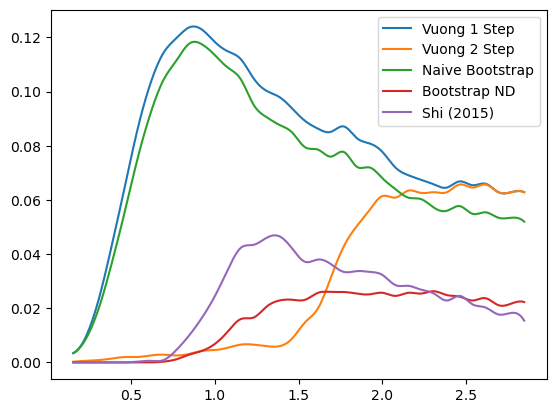

0.001 2.51188643150958


In [13]:
nobs =100
data_tuned_c = .95
calc_c =lambda nobs: (nobs**(-1/2)/100,nobs**(1/5) )

c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

Quantiles: 1th: 0.46, 5th: 2.84, 10th: 7.75, 30th: 58.55, 50th: 166.83, 70th: 397.38, 90th: 990.72, 95th: 1430.81, 99th: 2411.41
bonus term 0.48178339097322115 // variance stats 6.02905520174501 //part1 2.51188643150958 //part2 0.1918014226000184
-0.9984825235982978 1.1496174610607173 2.234974382723776
-1.9620493055447403 1.1496174610607173 1.2714076007773338
---
Quantiles: 1th: 0.57, 5th: 3.74, 10th: 10.90, 30th: 94.60, 50th: 274.89, 70th: 656.51, 90th: 1652.46, 95th: 2377.48, 99th: 4207.88
bonus term 1.6275114160684796 // variance stats 1.291901154833854 //part1 2.51188643150958 //part2 0.647923964894538
0.8913845079653152 -0.23292369480477446 2.333430515124445
-2.363638324171644 -0.23292369480477446 -0.9215923170125142
---
Quantiles: 1th: 0.43, 5th: 2.83, 10th: 8.49, 30th: 75.71, 50th: 226.21, 70th: 524.23, 90th: 1290.99, 95th: 1856.34, 99th: 3146.71
bonus term 0.774170356914057 // variance stats 4.166777381798339 //part1 2.51188643150958 //part2 0.30820277031744636
-0.5755537140182

0.8123632403692993 -0.13025956641898231 2.3248901781213736
-2.299032695011435 -0.13025956641898231 -0.7865057572593611
---
Quantiles: 1th: 0.51, 5th: 3.45, 10th: 10.27, 30th: 88.84, 50th: 272.96, 70th: 634.69, 90th: 1636.61, 95th: 2307.15, 99th: 4093.36
bonus term 1.3974776049036093 // variance stats 1.839824532410895 //part1 2.51188643150958 //part2 0.5563458552000541
0.5405071817693863 -0.12445432428131546 2.318921018838038
-2.254448028037832 -0.12445432428131546 -0.4760341909691812
---
Quantiles: 1th: 0.50, 5th: 3.68, 10th: 11.18, 30th: 103.86, 50th: 319.22, 70th: 759.28, 90th: 1884.14, 95th: 2710.96, 99th: 4734.74
bonus term 1.2730781930915227 // variance stats 2.6379848437371702 //part1 2.51188643150958 //part2 0.506821557345025
0.3348928070119581 -0.00584065624151556 2.158069105243072
-2.2112635791710873 -0.00584065624151556 -0.3880872809399735
---
Quantiles: 1th: 0.82, 5th: 4.15, 10th: 14.04, 30th: 119.30, 50th: 336.70, 70th: 801.45, 90th: 2018.67, 95th: 2857.94, 99th: 4770.11
b

Quantiles: 1th: 0.51, 5th: 3.18, 10th: 8.37, 30th: 65.57, 50th: 204.21, 70th: 480.75, 90th: 1233.99, 95th: 1744.90, 99th: 3126.20
bonus term 0.7687798389768513 // variance stats 3.9563274549999625 //part1 2.51188643150958 //part2 0.3060567664736475
-0.5616703384107329 0.4531083760448573 2.19776455458205
-2.0992300163644355 0.4531083760448573 0.6602048766283474
---
Quantiles: 1th: 0.46, 5th: 2.68, 10th: 7.81, 30th: 67.96, 50th: 204.19, 70th: 486.74, 90th: 1186.30, 95th: 1725.37, 99th: 2942.97
bonus term 1.4307538021405146 // variance stats 1.3037549951389598 //part1 2.51188643150958 //part2 0.5695933479288184
0.581886898824731 -0.38070778916510273 2.2881301943479926
-2.279620705456298 -0.38070778916510273 -0.5733774099330365
---
Quantiles: 1th: 0.52, 5th: 3.78, 10th: 10.78, 30th: 84.29, 50th: 244.81, 70th: 559.77, 90th: 1433.76, 95th: 2075.97, 99th: 3614.60
bonus term 1.7009820210073556 // variance stats 0.9896715137829236 //part1 2.51188643150958 //part2 0.6771731395456078
1.0648291556

-0.3225530642344176 0.323701732378828 2.1322661869852593
-2.0880914037753855 0.323701732378828 0.36672784744429127
---
Quantiles: 1th: 0.62, 5th: 4.59, 10th: 13.26, 30th: 118.06, 50th: 370.60, 70th: 848.85, 90th: 2182.84, 95th: 3082.15, 99th: 5236.21
bonus term 1.2820346626795738 // variance stats 2.9567007305465904 //part1 2.51188643150958 //part2 0.5103871921108724
0.26008248856694727 -0.03039994196176926 2.258261106881449
-2.3039868367922 -0.03039994196176926 -0.30580821847769807
---
Quantiles: 1th: 0.60, 5th: 4.59, 10th: 14.15, 30th: 115.01, 50th: 332.08, 70th: 767.30, 90th: 1920.75, 95th: 2753.80, 99th: 4450.73
bonus term 1.4318269040831069 // variance stats 2.077254775348607 //part1 2.51188643150958 //part2 0.5700205575068994
0.5791029581323345 -0.12922333795780117 2.239255752292419
-2.284550850033879 -0.12922333795780117 -0.6243980558737947
---
Quantiles: 1th: 0.49, 5th: 3.34, 10th: 8.68, 30th: 72.48, 50th: 216.98, 70th: 491.30, 90th: 1239.13, 95th: 1706.19, 99th: 3068.95
bonus 

Quantiles: 1th: 0.65, 5th: 4.55, 10th: 14.23, 30th: 122.03, 50th: 380.15, 70th: 884.51, 90th: 2213.90, 95th: 3225.78, 99th: 5793.80
bonus term 1.4552544582440823 // variance stats 2.342175126947992 //part1 2.51188643150958 //part2 0.5793472348069141
0.6250993267625838 -0.10460945826251739 2.2735603367678006
-2.2854095897255804 -0.10460945826251739 -0.6369485797203644
---
Quantiles: 1th: 0.51, 5th: 2.81, 10th: 9.20, 30th: 73.17, 50th: 226.92, 70th: 569.50, 90th: 1383.84, 95th: 2007.82, 99th: 3311.66
bonus term 1.4672328028848234 // variance stats 1.4295474330067568 //part1 2.51188643150958 //part2 0.5841158996997542
0.6904812916980825 -0.22068215407750613 2.3218792732109637
-2.243984314071564 -0.22068215407750613 -0.6125863325586833
---
Quantiles: 1th: 0.37, 5th: 2.66, 10th: 8.33, 30th: 67.85, 50th: 200.89, 70th: 482.65, 90th: 1256.46, 95th: 1809.60, 99th: 3071.70
bonus term 0.43084325630075193 // variance stats 8.740673388194631 //part1 2.51188643150958 //part2 0.17152178971794757
-1.2

1.3940884099051714 -0.6036668412237338 2.394271198851931
-2.4103565256998265 -0.6036668412237338 -1.4101737367530662
---
Quantiles: 1th: 0.64, 5th: 4.68, 10th: 16.61, 30th: 155.59, 50th: 487.33, 70th: 1100.58, 90th: 2749.42, 95th: 3956.71, 99th: 6761.42
bonus term 1.5493544649287556 // variance stats 2.4580974109208085 //part1 2.51188643150958 //part2 0.6168091222172146
0.838364349887347 -0.16534923645743485 2.31811819184018
-2.2603445799701642 -0.16534923645743485 -0.780590738017331
---
Quantiles: 1th: 0.73, 5th: 4.68, 10th: 14.09, 30th: 124.15, 50th: 371.45, 70th: 887.34, 90th: 2191.86, 95th: 3040.66, 99th: 5082.64
bonus term 2.054872982920488 // variance stats 0.6762572780756184 //part1 2.51188643150958 //part2 0.8180596690773003
1.6860311000099155 -0.6728618121285984 2.4019348140590973
-2.4237148658310605 -0.6728618121285984 -1.7078111517818788
---
Quantiles: 1th: 0.56, 5th: 3.45, 10th: 10.49, 30th: 94.86, 50th: 280.48, 70th: 653.81, 90th: 1654.08, 95th: 2321.19, 99th: 4135.71
bonu

Quantiles: 1th: 0.51, 5th: 3.89, 10th: 11.93, 30th: 105.61, 50th: 306.70, 70th: 742.87, 90th: 1814.77, 95th: 2535.17, 99th: 4395.66
bonus term 2.0677442009625384 // variance stats 0.5445428704579645 //part1 2.51188643150958 //part2 0.8231837932735983
1.7407609111343132 -0.642220521592659 2.396582186272879
-2.3947274907907636 -0.642220521592659 -1.7389062156521982
---
Quantiles: 1th: 0.49, 5th: 3.79, 10th: 13.16, 30th: 112.21, 50th: 329.25, 70th: 781.23, 90th: 1916.78, 95th: 2710.27, 99th: 4627.38
bonus term 2.2009011155570737 // variance stats 0.3829586705565151 //part1 2.51188643150958 //part2 0.8761945157824623
1.9534706963945072 -0.5339964205608484 2.4701385401186893
-2.44833153471964 -0.5339964205608484 -1.9316636909954579
---
Quantiles: 1th: 0.53, 5th: 3.54, 10th: 9.52, 30th: 75.63, 50th: 232.41, 70th: 555.39, 90th: 1430.85, 95th: 2035.79, 99th: 3452.14
bonus term 1.376237689547698 // variance stats 1.6798979180410682 //part1 2.51188643150958 //part2 0.5478900925949164
0.533964480

0.34268129232711375 -0.07657825449750974 2.343110622228945
-2.3339991185917133 -0.07657825449750974 -0.3335697886898821
---
Quantiles: 1th: 0.48, 5th: 3.14, 10th: 10.25, 30th: 98.01, 50th: 307.21, 70th: 701.13, 90th: 1766.15, 95th: 2418.77, 99th: 4317.30
bonus term 1.9368247139472812 // variance stats 0.718156901739361 //part1 2.51188643150958 //part2 0.7710638067276387
1.448926419959034 -0.6359753645457068 2.390895365072164
-2.4247230079355284 -0.6359753645457068 -1.4827540628223983
---
Quantiles: 1th: 0.52, 5th: 3.40, 10th: 10.69, 30th: 84.25, 50th: 240.76, 70th: 575.65, 90th: 1472.20, 95th: 2098.91, 99th: 3690.18
bonus term 1.25896029557949 // variance stats 2.0888517385996286 //part1 2.51188643150958 //part2 0.5012011211123454
0.2774955148986596 -0.2845210777399813 2.303397208167902
-2.2404250762603204 -0.2845210777399813 -0.21452338299107832
---
Quantiles: 1th: 0.69, 5th: 4.38, 10th: 13.13, 30th: 112.45, 50th: 341.42, 70th: 826.18, 90th: 2143.30, 95th: 3078.07, 99th: 5073.22
bonus

Quantiles: 1th: 0.34, 5th: 2.47, 10th: 8.00, 30th: 71.92, 50th: 223.11, 70th: 505.50, 90th: 1264.81, 95th: 1796.05, 99th: 3112.97
bonus term 1.7272768133647272 // variance stats 0.8158499005767897 //part1 2.51188643150958 //part2 0.6876412849312927
1.075439541896546 -1.0850593992723738 2.321176464849032
-2.379114084832908 -1.0850593992723738 -1.1333771618804225
---
Quantiles: 1th: 1.09, 5th: 5.78, 10th: 17.51, 30th: 146.15, 50th: 437.69, 70th: 1050.53, 90th: 2506.27, 95th: 3685.40, 99th: 6564.11
bonus term 0.909091197488601 // variance stats 6.497638057024923 //part1 2.51188643150958 //part2 0.36191572440727754
-0.449126812691346 0.37397096019130277 2.159111499331217
-2.267309207668548 0.37397096019130277 0.3409291043540153
---
Quantiles: 1th: 0.43, 5th: 2.81, 10th: 9.95, 30th: 91.40, 50th: 265.57, 70th: 642.55, 90th: 1658.51, 95th: 2266.50, 99th: 4051.71
bonus term 1.1567429488921912 // variance stats 2.6552451241489603 //part1 2.51188643150958 //part2 0.4605076624411789
0.08231385312

0.6315196027014667 -0.47115247202992205 2.262264971590083
-2.3275554110679377 -0.47115247202992205 -0.6968100421793215
---
Quantiles: 1th: 0.45, 5th: 2.88, 10th: 9.00, 30th: 84.50, 50th: 263.59, 70th: 607.18, 90th: 1581.31, 95th: 2261.88, 99th: 4091.00
bonus term 1.2270812416235262 // variance stats 2.3682849590417843 //part1 2.51188643150958 //part2 0.48850984114201434
0.191143285343911 -0.35545332979434313 2.1974622170485563
-2.2630191979031413 -0.35545332979434313 -0.25670026619849623
---
Quantiles: 1th: 0.52, 5th: 3.28, 10th: 8.52, 30th: 68.99, 50th: 205.04, 70th: 480.14, 90th: 1286.48, 95th: 1843.37, 99th: 3344.04
bonus term 1.2239308586675313 // variance stats 1.9397995781261281 //part1 2.51188643150958 //part2 0.48725565109724317
0.20474323152580806 -0.22831437395435164 2.233920922702638
-2.2431184858092545 -0.22831437395435164 -0.213940794632424
---
Quantiles: 1th: 0.62, 5th: 4.68, 10th: 14.51, 30th: 117.84, 50th: 361.06, 70th: 865.05, 90th: 2265.21, 95th: 3236.22, 99th: 5474.1

1.6155487219643434 -0.8069468552084436 2.4284998155655346
-2.4097595066993134 -0.8069468552084436 -1.5968084130981222
---
Quantiles: 1th: 0.61, 5th: 3.44, 10th: 10.40, 30th: 85.30, 50th: 264.56, 70th: 601.35, 90th: 1563.79, 95th: 2288.69, 99th: 3853.93
bonus term 1.3744769436101936 // variance stats 1.8939395197177926 //part1 2.51188643150958 //part2 0.5471891270116729
0.47986175730977393 -0.68393664917516 2.1747317936999013
-2.269092129910613 -0.68393664917516 -0.574222093520486
---
Quantiles: 1th: 0.61, 5th: 3.48, 10th: 9.48, 30th: 78.86, 50th: 228.22, 70th: 542.02, 90th: 1361.20, 95th: 1965.68, 99th: 3209.03
bonus term 1.7625701117246428 // variance stats 0.8356636336077653 //part1 2.51188643150958 //part2 0.7016918000808591
1.1984803138302922 -1.2364824761852145 2.2959221382998716
-2.3266599096189933 -1.2364824761852145 -1.2292180851494143
---
Quantiles: 1th: 0.46, 5th: 2.95, 10th: 9.87, 30th: 82.80, 50th: 264.75, 70th: 640.77, 90th: 1614.58, 95th: 2289.30, 99th: 3768.03
bonus term

Quantiles: 1th: 0.45, 5th: 2.82, 10th: 8.41, 30th: 78.36, 50th: 243.97, 70th: 573.72, 90th: 1469.66, 95th: 2095.76, 99th: 3715.29
bonus term 1.0238201184812215 // variance stats 3.046065147130042 //part1 2.51188643150958 //part2 0.40759013052430537
-0.15449906900195035 -0.2221968012407509 2.1787537351666675
-2.2021393059643937 -0.2221968012407509 0.13111349820422466
---
Quantiles: 1th: 0.37, 5th: 2.93, 10th: 7.44, 30th: 58.15, 50th: 181.15, 70th: 423.00, 90th: 1143.54, 95th: 1654.14, 99th: 2754.13
bonus term 1.7369930920990657 // variance stats 0.7379315392719726 //part1 2.51188643150958 //part2 0.6915094051665294
1.1027382674927342 -1.366015234821379 2.380247746017442
-2.3712479167053977 -1.366015234821379 -1.09373843818069
---
Quantiles: 1th: 0.80, 5th: 6.24, 10th: 18.37, 30th: 177.45, 50th: 529.61, 70th: 1205.11, 90th: 3031.28, 95th: 4235.85, 99th: 7261.63
bonus term 1.3299465626559444 // variance stats 3.7644525941684197 //part1 2.51188643150958 //part2 0.5294612630463075
0.4795264

1.571433595844092 -1.0632985227611884 2.4103540829821988
-2.373290871725748 -1.0632985227611884 -1.5343703845876409
---
Quantiles: 1th: 0.52, 5th: 3.82, 10th: 11.90, 30th: 103.69, 50th: 302.78, 70th: 680.09, 90th: 1722.19, 95th: 2422.21, 99th: 4267.26
bonus term 0.9681697634901598 // variance stats 3.862145645030664 //part1 2.51188643150958 //part2 0.38543532515851614
-0.1817289703568212 -0.1109493484137797 2.1828494338281557
-2.118068497337141 -0.1109493484137797 0.2465099068478357
---
Quantiles: 1th: 0.46, 5th: 3.01, 10th: 8.35, 30th: 64.92, 50th: 190.87, 70th: 475.09, 90th: 1173.03, 95th: 1707.31, 99th: 2770.31
bonus term 1.0222199930436526 // variance stats 2.488042082950874 //part1 2.51188643150958 //part2 0.40695310911382415
-0.11869442370865217 -0.5923126941476846 2.2066846853045066
-2.1631344097959575 -0.5923126941476846 0.16224469921720125
---
Quantiles: 1th: 0.50, 5th: 2.95, 10th: 8.57, 30th: 80.18, 50th: 267.70, 70th: 633.56, 90th: 1643.77, 95th: 2326.94, 99th: 3816.35
bonus

Quantiles: 1th: 0.40, 5th: 2.26, 10th: 6.17, 30th: 51.90, 50th: 158.17, 70th: 369.42, 90th: 918.23, 95th: 1313.92, 99th: 2278.03
bonus term 1.568648312263028 // variance stats 0.7900709617349793 //part1 2.51188643150958 //part2 0.624490141188553
0.8276385397906094 -1.737574723511189 2.272483033151009
-2.3096580847354464 -1.737574723511189 -0.864813591375047
---
Quantiles: 1th: 0.56, 5th: 3.64, 10th: 11.85, 30th: 119.95, 50th: 364.52, 70th: 849.46, 90th: 2209.27, 95th: 3149.05, 99th: 5541.55
bonus term 2.07721172784259 // variance stats 0.6589662284794474 //part1 2.51188643150958 //part2 0.8269528836119546
1.740624256081533 -1.0746965696615198 2.4104573030536263
-2.4137991996036465 -1.0746965696615198 -1.7439661526315537
---
Quantiles: 1th: 0.50, 5th: 3.01, 10th: 9.32, 30th: 81.01, 50th: 233.52, 70th: 555.93, 90th: 1376.56, 95th: 2007.76, 99th: 3521.12
bonus term 1.3512389923225483 // variance stats 1.7245695038566529 //part1 2.51188643150958 //part2 0.5379379319750884
0.416512615835932

1.6215721574077677 -1.06878747608798 2.3689283814598734
-2.4078529245989526 -1.06878747608798 -1.660496700546847
---
Quantiles: 1th: 0.63, 5th: 4.08, 10th: 11.47, 30th: 87.87, 50th: 253.33, 70th: 618.63, 90th: 1552.64, 95th: 2204.85, 99th: 3628.10
bonus term 1.2322803698831042 // variance stats 2.289530313254612 //part1 2.51188643150958 //part2 0.49057965138277965
0.27952152105803274 -0.8071238386656483 2.267305084452196
-2.1850392187081757 -0.8071238386656483 -0.1972556553140127
---
Quantiles: 1th: 0.57, 5th: 4.46, 10th: 16.41, 30th: 138.67, 50th: 421.75, 70th: 961.88, 90th: 2312.53, 95th: 3246.74, 99th: 5382.30
bonus term 1.4887029522055844 // variance stats 2.231479042932579 //part1 2.51188643150958 //part2 0.5926633200972033
0.7256576589862651 -1.2389617575420993 2.298242710806748
-2.2517482454249036 -1.2389617575420993 -0.679163193604421
---
Quantiles: 1th: 0.63, 5th: 3.34, 10th: 10.77, 30th: 93.20, 50th: 278.47, 70th: 662.34, 90th: 1645.44, 95th: 2335.33, 99th: 4024.85
bonus term

Quantiles: 1th: 0.43, 5th: 3.56, 10th: 11.13, 30th: 96.05, 50th: 297.76, 70th: 699.92, 90th: 1688.90, 95th: 2431.63, 99th: 4322.38
bonus term 1.0085578149040069 // variance stats 3.6245253378654 //part1 2.51188643150958 //part2 0.401514098031052
-0.27066738189357364 -0.8023744540471938 2.2709970802739607
-2.2877830117015874 -0.8023744540471938 0.25388145046594657
---
Quantiles: 1th: 0.47, 5th: 4.13, 10th: 14.74, 30th: 152.74, 50th: 456.41, 70th: 1059.34, 90th: 2759.16, 95th: 4003.60, 99th: 6933.43
bonus term 1.823488300750044 // variance stats 1.5114287601542797 //part1 2.51188643150958 //part2 0.7259437679490046
1.2634295338350146 -1.102986671103845 2.350176904942991
-2.3835470676650736 -1.102986671103845 -1.296799696557097
---
Quantiles: 1th: 0.57, 5th: 4.55, 10th: 14.22, 30th: 110.16, 50th: 318.76, 70th: 728.51, 90th: 1886.22, 95th: 2619.68, 99th: 4766.68
bonus term 1.0683648080202537 // variance stats 3.5395802700197176 //part1 2.51188643150958 //part2 0.4253236908398735
-0.0720601

0.47354764815418604 -0.6746090163779507 2.3023258991704383
-2.294905417886267 -0.6746090163779507 -0.4661271668700145
---
Quantiles: 1th: 0.52, 5th: 2.97, 10th: 9.32, 30th: 76.40, 50th: 229.48, 70th: 562.16, 90th: 1435.82, 95th: 1988.27, 99th: 3528.91
bonus term 0.9066242894874789 // variance stats 3.5204223684228713 //part1 2.51188643150958 //part2 0.36093363064293504
-0.3496839801071758 -0.30082630681240713 2.203177511782365
-2.1629325590821336 -0.30082630681240713 0.3899289328074073
---
Quantiles: 1th: 0.60, 5th: 3.52, 10th: 9.59, 30th: 78.83, 50th: 259.37, 70th: 620.61, 90th: 1597.67, 95th: 2284.19, 99th: 3867.47
bonus term 1.3563854137073017 // variance stats 1.9458976695146142 //part1 2.51188643150958 //part2 0.5399867592310488
0.4173899401066584 -0.9452770971188992 2.2253491325269286
-2.295380887307945 -0.9452770971188992 -0.4874216948876746
---
Quantiles: 1th: 0.44, 5th: 3.07, 10th: 8.82, 30th: 66.91, 50th: 214.56, 70th: 508.90, 90th: 1253.26, 95th: 1811.10, 99th: 3048.17
bonus

Quantiles: 1th: 0.58, 5th: 3.03, 10th: 8.25, 30th: 68.27, 50th: 209.99, 70th: 517.59, 90th: 1237.50, 95th: 1703.78, 99th: 2992.56
bonus term 1.1597042251873777 // variance stats 1.986560127054009 //part1 2.51188643150958 //part2 0.46168656776828276
0.03863402930038782 -1.7637933108827852 2.170091643820606
-2.2807744210743675 -1.7637933108827852 -0.14931680655414928
---
Quantiles: 1th: 0.70, 5th: 5.01, 10th: 15.71, 30th: 140.87, 50th: 419.01, 70th: 988.02, 90th: 2507.53, 95th: 3585.78, 99th: 6254.15
bonus term 1.386017591517686 // variance stats 2.912750384154621 //part1 2.51188643150958 //part2 0.551783541696479
0.5055462510552313 -0.6448213357991336 2.280301679668096
-2.266488931980141 -0.6448213357991336 -0.491733503367276
---
Quantiles: 1th: 0.32, 5th: 3.22, 10th: 9.22, 30th: 74.74, 50th: 241.04, 70th: 568.26, 90th: 1431.31, 95th: 2044.48, 99th: 3671.09
bonus term 1.3340968099164057 // variance stats 1.804939768125413 //part1 2.51188643150958 //part2 0.5311135062402671
0.38582332241

0.4934728288927952 -2.7603396350768326 2.3825717148093237
-2.4244000212655923 -2.7603396350768326 -0.5353011353490638
---
Quantiles: 1th: 0.57, 5th: 3.87, 10th: 10.22, 30th: 82.61, 50th: 247.95, 70th: 567.39, 90th: 1518.65, 95th: 2102.17, 99th: 3569.35
bonus term 0.8963286098228814 // variance stats 3.7889822652312173 //part1 2.51188643150958 //part2 0.35683484674273697
-0.38652141566104165 -0.7729533847311288 2.1606855724954066
-2.179178635306805 -0.7729533847311288 0.36802835284964364
---
Quantiles: 1th: 0.50, 5th: 3.09, 10th: 9.42, 30th: 80.49, 50th: 243.11, 70th: 577.57, 90th: 1431.30, 95th: 2008.23, 99th: 3339.05
bonus term 0.836556430982762 // variance stats 4.021774398680184 //part1 2.51188643150958 //part2 0.33303911374687933
-0.5080668057551356 -0.9765017185906147 2.192294781867203
-2.1811796677206594 -0.9765017185906147 0.5191819199016786
---
Quantiles: 1th: 0.44, 5th: 3.09, 10th: 7.85, 30th: 73.08, 50th: 229.89, 70th: 546.32, 90th: 1390.64, 95th: 1941.38, 99th: 3455.79
bonus

Quantiles: 1th: 0.59, 5th: 5.46, 10th: 20.34, 30th: 177.16, 50th: 556.64, 70th: 1313.90, 90th: 3321.42, 95th: 4614.23, 99th: 7825.19
bonus term 1.8064811839698527 // variance stats 1.8017930648657132 //part1 2.51188643150958 //part2 0.7191731128083697
1.2654314094953714 -1.56895236801927 2.346382752509918
-2.3475309584443336 -1.56895236801927 -1.2665796154297875
---
Quantiles: 1th: 0.46, 5th: 3.80, 10th: 12.08, 30th: 114.44, 50th: 351.13, 70th: 790.95, 90th: 1964.38, 95th: 2723.74, 99th: 4644.40
bonus term 1.0474803697398962 // variance stats 3.8078647099811627 //part1 2.51188643150958 //part2 0.4170094462074812
-0.15324563342938588 -0.8108327954712221 2.0955777424065727
-2.2482063729091784 -0.8108327954712221 0.0006170029267801777
---
Quantiles: 1th: 0.67, 5th: 3.72, 10th: 12.51, 30th: 117.40, 50th: 358.59, 70th: 823.93, 90th: 1982.56, 95th: 2811.70, 99th: 4736.49
bonus term 1.1873910685793454 // variance stats 3.1363587801385044 //part1 2.51188643150958 //part2 0.47270889865261684
0.

0.23386819463206576 -1.4333888357074898 2.242810973314481
-2.3415753418765495 -1.4333888357074898 -0.3326325631941338
---
Quantiles: 1th: 0.52, 5th: 2.99, 10th: 7.65, 30th: 67.44, 50th: 200.30, 70th: 457.65, 90th: 1152.65, 95th: 1718.47, 99th: 2926.22
bonus term 1.2724227668274153 // variance stats 1.6739614018603495 //part1 2.51188643150958 //part2 0.5065606274495147
0.2662022907514572 -2.6489875247462273 2.1950251747023195
-2.278643242903373 -2.6489875247462273 -0.349820358952511
---
Quantiles: 1th: 0.86, 5th: 4.63, 10th: 13.83, 30th: 122.08, 50th: 358.88, 70th: 836.73, 90th: 2114.58, 95th: 2949.35, 99th: 5431.80
bonus term 1.2953492304831749 // variance stats 2.7699004242933616 //part1 2.51188643150958 //part2 0.5156878170263067
0.284929417813582 -0.9991799769302013 2.2294042153552898
-2.3057690431527678 -0.9991799769302013 -0.3612942456110597
---
Quantiles: 1th: 0.54, 5th: 2.85, 10th: 7.44, 30th: 61.12, 50th: 190.77, 70th: 452.07, 90th: 1120.58, 95th: 1630.06, 99th: 2771.75
bonus t

Quantiles: 1th: 0.51, 5th: 3.38, 10th: 9.30, 30th: 97.21, 50th: 296.18, 70th: 706.99, 90th: 1868.13, 95th: 2693.02, 99th: 4558.18
bonus term 1.5236227761935461 // variance stats 1.746763752881144 //part1 2.51188643150958 //part2 0.6065651524212771
0.6510385868175977 -2.103477333949631 2.3280950642789127
-2.3962069655694944 -2.103477333949631 -0.7191504881081794
---
Quantiles: 1th: 0.63, 5th: 4.87, 10th: 14.63, 30th: 122.55, 50th: 341.99, 70th: 796.04, 90th: 1983.03, 95th: 2792.20, 99th: 4669.54
bonus term 0.8293801569695327 // variance stats 5.664353201293941 //part1 2.51188643150958 //part2 0.3301821876043561
-0.5475694138778876 -0.35077453507591944 2.2182040685791664
-2.2063297278169527 -0.35077453507591944 0.5594437546401013
---
Quantiles: 1th: 0.46, 5th: 2.64, 10th: 7.56, 30th: 64.25, 50th: 193.67, 70th: 475.33, 90th: 1154.11, 95th: 1649.32, 99th: 2933.05
bonus term 1.390125210822045 // variance stats 1.3309161952386261 //part1 2.51188643150958 //part2 0.5534188143954482
0.44024894

-0.395478968666212 -0.7641393443697795 2.1355368065689038
-2.2336388708199157 -0.7641393443697795 0.29737690441519987
---
Quantiles: 1th: 0.44, 5th: 2.79, 10th: 7.87, 30th: 63.77, 50th: 183.61, 70th: 441.19, 90th: 1097.25, 95th: 1572.10, 99th: 2734.62
bonus term 0.584890421123153 // variance stats 5.17947519134501 //part1 2.51188643150958 //part2 0.2328490706371819
-0.980407968315946 -0.5793648481159849 2.187318007464477
-2.150188810562252 -0.5793648481159849 1.0175371652181708
---
Quantiles: 1th: 0.46, 5th: 3.50, 10th: 10.55, 30th: 95.25, 50th: 301.08, 70th: 692.25, 90th: 1814.38, 95th: 2606.52, 99th: 4415.31
bonus term 1.014647270600068 // variance stats 3.846242644734648 //part1 2.51188643150958 //part2 0.4039383540084217
-0.1702905386359774 -0.888147573297182 2.27140016815933
-2.199585079836113 -0.888147573297182 0.24210562695919374
---
Quantiles: 1th: 0.65, 5th: 4.17, 10th: 11.09, 30th: 84.87, 50th: 249.14, 70th: 592.26, 90th: 1448.98, 95th: 2042.77, 99th: 3399.47
bonus term 1.178

Quantiles: 1th: 0.48, 5th: 3.19, 10th: 9.76, 30th: 81.29, 50th: 259.56, 70th: 610.25, 90th: 1541.19, 95th: 2097.65, 99th: 3553.22
bonus term 0.8061760910946681 // variance stats 4.438221869526382 //part1 2.51188643150958 //part2 0.3209444825935768
-0.6437733254587245 -0.9025901289611798 2.0800183462174973
-2.2561255076480604 -0.9025901289611798 0.4676661640281607
---
Quantiles: 1th: 0.53, 5th: 3.80, 10th: 14.37, 30th: 124.34, 50th: 376.80, 70th: 853.40, 90th: 2136.34, 95th: 3056.61, 99th: 5363.88
bonus term 1.4989153037011456 // variance stats 2.0656657800553004 //part1 2.51188643150958 //part2 0.596728930455799
0.690599182339875 -2.2891189409274175 2.26109245688761
-2.307231425062416 -2.2891189409274175 -0.7367381505146812
---
Quantiles: 1th: 0.58, 5th: 3.79, 10th: 13.47, 30th: 105.79, 50th: 307.24, 70th: 722.99, 90th: 1780.88, 95th: 2484.29, 99th: 4340.66
bonus term 1.5535359022142123 // variance stats 1.5325142179886526 //part1 2.51188643150958 //part2 0.6184737823837747
0.775665127

1.097575451663306 -2.8329900297091304 2.4238356182052168
-2.3664945072398957 -2.8329900297091304 -1.0402343406979855
---
Quantiles: 1th: 0.50, 5th: 3.21, 10th: 8.36, 30th: 71.72, 50th: 212.02, 70th: 513.31, 90th: 1303.57, 95th: 1810.57, 99th: 3089.68
bonus term 1.2752861340639734 // variance stats 1.7556439915396973 //part1 2.51188643150958 //part2 0.5077005544783164
0.25408643327828345 -4.193816129012267 2.1816090128894374
-2.2964858348496637 -4.193816129012267 -0.3689632552385094
---
Quantiles: 1th: 0.76, 5th: 5.94, 10th: 18.16, 30th: 157.82, 50th: 468.28, 70th: 1086.96, 90th: 2697.54, 95th: 3873.68, 99th: 6790.54
bonus term 1.681163481228998 // variance stats 1.9141257974647978 //part1 2.51188643150958 //part2 0.6692832367499438
1.051121161968947 -2.2238429495019814 2.3940084942517514
-2.3112058004890494 -2.2238429495019814 -0.9683184682062448
---
Quantiles: 1th: 0.61, 5th: 3.92, 10th: 11.20, 30th: 96.91, 50th: 296.52, 70th: 713.90, 90th: 1718.39, 95th: 2437.14, 99th: 4108.66
bonus 

Quantiles: 1th: 0.53, 5th: 3.59, 10th: 10.65, 30th: 90.02, 50th: 271.47, 70th: 661.17, 90th: 1680.82, 95th: 2394.90, 99th: 4054.99
bonus term 1.5529438982354384 // variance stats 1.4788485704314194 //part1 2.51188643150958 //part2 0.6182381013548285
0.7969813970437657 -3.0107695098110354 2.3149145427503846
-2.3089063994271113 -3.0107695098110354 -0.7909732537204924
---
Quantiles: 1th: 0.61, 5th: 4.29, 10th: 13.66, 30th: 106.04, 50th: 328.85, 70th: 782.03, 90th: 1940.10, 95th: 2728.09, 99th: 4558.41
bonus term 0.9630639165833642 // variance stats 4.38738488726299 //part1 2.51188643150958 //part2 0.38340265089317244
-0.3235544423129857 -1.4934484327111672 2.1683546830702336
-2.249682275479714 -1.4934484327111672 0.2422268499035051
---
Quantiles: 1th: 0.45, 5th: 2.88, 10th: 9.18, 30th: 74.94, 50th: 237.72, 70th: 544.38, 90th: 1446.83, 95th: 2026.91, 99th: 3469.86
bonus term 1.2708250682057414 // variance stats 1.9794393968639101 //part1 2.51188643150958 //part2 0.505924572171843
0.3127175

-0.536784201794046 -1.785413631374566 2.1828006359150014
-2.165804029446678 -1.785413631374566 0.553780808262369
---
Quantiles: 1th: 0.30, 5th: 1.84, 10th: 5.75, 30th: 46.21, 50th: 139.44, 70th: 333.19, 90th: 854.15, 95th: 1174.00, 99th: 1914.78
bonus term 0.5793777511146248 // variance stats 3.9158530591668526 //part1 2.51188643150958 //part2 0.23065443717789158
-0.9594488882436158 -1.4923562334057676 2.0628206635330044
-2.118204390472865 -1.4923562334057676 0.904065161303755
---
Quantiles: 1th: 0.52, 5th: 4.18, 10th: 13.70, 30th: 110.68, 50th: 331.64, 70th: 740.68, 90th: 1942.07, 95th: 2720.20, 99th: 4607.61
bonus term 1.34373639298711 // variance stats 2.3647492096938074 //part1 2.51188643150958 //part2 0.5349510933818606
0.3837156228628349 -2.497351415520707 2.2525190470898298
-2.3037571631113853 -2.497351415520707 -0.4349537388843903
---
Quantiles: 1th: 0.41, 5th: 2.14, 10th: 6.34, 30th: 50.11, 50th: 151.29, 70th: 366.66, 90th: 966.51, 95th: 1373.86, 99th: 2211.94
bonus term 1.224

Quantiles: 1th: 0.39, 5th: 3.13, 10th: 10.24, 30th: 87.71, 50th: 264.26, 70th: 602.21, 90th: 1569.84, 95th: 2154.69, 99th: 3843.51
bonus term 1.0413100563556814 // variance stats 3.0429314293241587 //part1 2.51188643150958 //part2 0.4145530002046631
-0.11235712517661402 -2.147990552271064 2.1841340825281974
-2.1949772378879766 -2.147990552271064 0.10151396981683454
---
Quantiles: 1th: 0.63, 5th: 4.29, 10th: 13.58, 30th: 118.43, 50th: 332.32, 70th: 818.69, 90th: 2042.50, 95th: 2795.54, 99th: 4944.23
bonus term 1.572749424766415 // variance stats 1.669304020577002 //part1 2.51188643150958 //part2 0.6261228234833979
0.7440234242088749 -3.083063775389826 2.303383209340372
-2.4014754253239556 -3.083063775389826 -0.8421156401924582
---
Quantiles: 1th: 0.37, 5th: 2.31, 10th: 7.18, 30th: 50.94, 50th: 151.65, 70th: 361.00, 90th: 890.97, 95th: 1272.62, 99th: 2191.56
bonus term 1.049130253241059 // variance stats 1.7743604800264823 //part1 2.51188643150958 //part2 0.41766627665987194
-0.198110094

-0.609942236148875 -0.5653807687459008 2.1640378875951565
-2.1185004502833547 -0.5653807687459008 0.6554796734606766
---
Quantiles: 1th: 0.42, 5th: 2.87, 10th: 7.97, 30th: 66.35, 50th: 212.82, 70th: 497.93, 90th: 1238.90, 95th: 1791.32, 99th: 3087.27
bonus term 0.9689023335582958 // variance stats 2.8526912944494938 //part1 2.51188643150958 //part2 0.38572696655557387
-0.36718585409090543 -4.268793314537756 2.2171592685919173
-2.304990521207497 -4.268793314537756 0.2793546014753257
---
Quantiles: 1th: 0.64, 5th: 3.86, 10th: 10.28, 30th: 76.05, 50th: 226.10, 70th: 524.68, 90th: 1348.06, 95th: 1935.25, 99th: 3206.93
bonus term 1.2000064283797083 // variance stats 2.115664355720209 //part1 2.51188643150958 //part2 0.4777311638482536
0.07446642378076906 -4.165719725456585 2.2595324493998676
-2.3255464329786473 -4.165719725456585 -0.14048040735954884
---
Quantiles: 1th: 0.76, 5th: 4.51, 10th: 12.81, 30th: 96.91, 50th: 295.83, 70th: 676.65, 90th: 1649.17, 95th: 2375.91, 99th: 3846.47
bonus t

Quantiles: 1th: 0.53, 5th: 3.68, 10th: 9.77, 30th: 83.61, 50th: 261.99, 70th: 609.18, 90th: 1477.90, 95th: 2053.87, 99th: 3448.77
bonus term 1.1902560726816793 // variance stats 2.280570030032881 //part1 2.51188643150958 //part2 0.4738494773294212
0.03819003935904464 -3.3828544261591413 2.311820385871017
-2.342322106004314 -3.3828544261591413 -0.06869175949234169
---
Quantiles: 1th: 0.50, 5th: 3.40, 10th: 12.52, 30th: 100.76, 50th: 292.83, 70th: 698.00, 90th: 1788.83, 95th: 2601.69, 99th: 4349.80
bonus term 1.3742237357456286 // variance stats 2.153827172590608 //part1 2.51188643150958 //part2 0.5470883231451491
0.47442442227539827 -3.6228895273182014 2.25673410142633
-2.274023049215859 -3.6228895273182014 -0.4917133700649273
---
Quantiles: 1th: 0.37, 5th: 2.76, 10th: 7.42, 30th: 67.47, 50th: 205.14, 70th: 477.28, 90th: 1234.67, 95th: 1778.03, 99th: 2859.57
bonus term 0.8641920070959093 // variance stats 3.3900442879278256 //part1 2.51188643150958 //part2 0.3440410347599002
-0.64709749

-0.7939051456455629 -2.8608829831275955 2.1545385403740385
-2.3528313161089 -2.8608829831275955 0.5956123699107015
---
Quantiles: 1th: 1.09, 5th: 6.21, 10th: 18.46, 30th: 167.75, 50th: 468.24, 70th: 1107.91, 90th: 2917.05, 95th: 4038.39, 99th: 6799.48
bonus term 1.3037410190838268 // variance stats 3.74227662677435 //part1 2.51188643150958 //part2 0.5190286482419953
0.3748785260031803 -2.3977978536459585 2.3279243193862897
-2.2326035121644736 -2.3977978536459585 -0.27955771878136404
---
Quantiles: 1th: 0.81, 5th: 4.49, 10th: 14.89, 30th: 130.80, 50th: 386.33, 70th: 940.38, 90th: 2430.54, 95th: 3441.38, 99th: 6040.47
bonus term 1.6078540879522443 // variance stats 1.934951270097935 //part1 2.51188643150958 //part2 0.6400982416175419
0.8563222443582267 -3.3933381072712034 2.3002833417526665
-2.359385931546262 -3.3933381072712034 -0.915424834151822
---
Quantiles: 1th: 0.70, 5th: 4.16, 10th: 11.28, 30th: 99.44, 50th: 302.89, 70th: 680.37, 90th: 1713.06, 95th: 2443.74, 99th: 4258.10
bonus t

Quantiles: 1th: 0.76, 5th: 4.79, 10th: 16.21, 30th: 137.51, 50th: 412.02, 70th: 985.76, 90th: 2610.41, 95th: 3649.93, 99th: 6281.70
bonus term 0.9497009293357366 // variance stats 6.003863029148698 //part1 2.51188643150958 //part2 0.37808274984987694
-0.24744205574273462 -1.6822439638170545 2.174555071409312
-2.146843914414208 -1.6822439638170545 0.2751532127378389
---
Quantiles: 1th: 0.58, 5th: 3.25, 10th: 7.78, 30th: 59.45, 50th: 176.40, 70th: 406.84, 90th: 1003.03, 95th: 1454.50, 99th: 2483.80
bonus term 1.000183506926093 // variance stats 2.198372784374971 //part1 2.51188643150958 //part2 0.39818022597662106
-0.06342442207481641 -3.927666735871816 2.0212503913207547
-2.063791435927002 -3.927666735871816 0.020883377468568887
---
Quantiles: 1th: 0.62, 5th: 3.55, 10th: 11.57, 30th: 100.88, 50th: 304.01, 70th: 716.66, 90th: 1743.82, 95th: 2489.70, 99th: 4304.54
bonus term 1.5152923434656138 // variance stats 1.6374534589914218 //part1 2.51188643150958 //part2 0.6032487474184737
0.68949

-0.05058910174714308 -5.4446962376755845 2.3062649093956824
-2.374924940896453 -5.4446962376755845 -0.01807092975362702
---
Quantiles: 1th: 0.58, 5th: 4.38, 10th: 13.52, 30th: 115.58, 50th: 345.04, 70th: 830.59, 90th: 2015.14, 95th: 2847.42, 99th: 4875.39
bonus term 1.024062783496911 // variance stats 4.1369177306116285 //part1 2.51188643150958 //part2 0.40768673720709386
-0.2365821758956905 -2.420581181630784 2.254853342479362
-2.284707742889512 -2.420581181630784 0.20672777548554003
---
Quantiles: 1th: 0.57, 5th: 4.24, 10th: 14.38, 30th: 122.82, 50th: 369.18, 70th: 851.91, 90th: 2171.17, 95th: 3129.82, 99th: 5101.06
bonus term 0.9210602180279911 // variance stats 5.405733957975056 //part1 2.51188643150958 //part2 0.36668067730851084
-0.27258394841588257 -1.9298882642714683 2.0873892933147826
-2.1147043844718647 -1.9298882642714683 0.24526885725880074
---
Quantiles: 1th: 0.56, 5th: 3.65, 10th: 11.07, 30th: 91.74, 50th: 275.93, 70th: 667.68, 90th: 1707.33, 95th: 2401.81, 99th: 4145.93


Quantiles: 1th: 0.41, 5th: 2.66, 10th: 7.86, 30th: 67.17, 50th: 210.08, 70th: 511.85, 90th: 1260.25, 95th: 1815.32, 99th: 2947.72
bonus term 0.7117633577645646 // variance stats 4.591137529046388 //part1 2.51188643150958 //part2 0.2833580964633074
-0.8514337532927839 -2.370729165847734 2.08541708987995
-2.274960468821913 -2.370729165847734 0.6618903743508204
---
Quantiles: 1th: 0.56, 5th: 3.59, 10th: 11.67, 30th: 106.33, 50th: 323.73, 70th: 793.36, 90th: 1929.70, 95th: 2695.18, 99th: 4939.12
bonus term 1.388315908287677 // variance stats 2.181223228092636 //part1 2.51188643150958 //part2 0.5526985180828157
0.45180297314918355 -4.689167442979426 2.282958204226484
-2.3248288434261704 -4.689167442979426 -0.49367361234887025
---
Quantiles: 1th: 0.62, 5th: 4.73, 10th: 16.75, 30th: 154.30, 50th: 463.74, 70th: 1071.98, 90th: 2849.62, 95th: 4054.80, 99th: 6854.00
bonus term 1.2490908646845087 // variance stats 4.0992889972627395 //part1 2.51188643150958 //part2 0.497272029903771
0.254989015657

0.46797061981290705 -4.4933351180344365 2.2357548955000475
-2.3051643892124662 -4.4933351180344365 -0.5373801135253258
---
Quantiles: 1th: 0.67, 5th: 3.32, 10th: 8.67, 30th: 68.01, 50th: 211.24, 70th: 478.51, 90th: 1248.82, 95th: 1703.87, 99th: 2946.62
bonus term 0.7741367790254492 // variance stats 3.824784961025727 //part1 2.51188643150958 //part2 0.3081894027192195
-0.7206523807203274 -3.798643297704197 2.2448367954780317
-2.268925938771226 -3.798643297704197 0.696563237427133
---
Quantiles: 1th: 0.51, 5th: 3.62, 10th: 10.19, 30th: 85.95, 50th: 275.92, 70th: 656.30, 90th: 1582.17, 95th: 2236.29, 99th: 3945.93
bonus term 1.3019478625657965 // variance stats 2.0782526195697377 //part1 2.51188643150958 //part2 0.5183147797742428
0.25312201451049693 -5.21330140369731 2.3317087008419293
-2.3507737106210964 -5.21330140369731 -0.272187024289664
---
Quantiles: 1th: 0.41, 5th: 3.12, 10th: 7.50, 30th: 62.51, 50th: 183.54, 70th: 435.74, 90th: 1093.97, 95th: 1544.57, 99th: 2692.95
bonus term 0.

Quantiles: 1th: 0.79, 5th: 4.46, 10th: 12.33, 30th: 102.35, 50th: 296.04, 70th: 704.43, 90th: 1784.33, 95th: 2539.95, 99th: 4340.67
bonus term 1.1183308988093814 // variance stats 3.165038231204804 //part1 2.51188643150958 //part2 0.4452155498675522
0.011428987852284163 -4.027400547756507 2.217699031369101
-2.225232809766479 -4.027400547756507 -0.01896276624966145
---
Quantiles: 1th: 0.80, 5th: 5.10, 10th: 15.75, 30th: 135.48, 50th: 429.25, 70th: 987.63, 90th: 2445.58, 95th: 3576.53, 99th: 6197.13
bonus term 1.2603157126267952 // variance stats 3.5517086274260077 //part1 2.51188643150958 //part2 0.501740722357968
0.2755482916345386 -2.8538396586814456 2.2416709337562115
-2.245083133619052 -2.8538396586814456 -0.2789604914973786
---
Quantiles: 1th: 0.56, 5th: 5.29, 10th: 19.82, 30th: 182.75, 50th: 561.08, 70th: 1307.80, 90th: 3334.09, 95th: 4694.47, 99th: 8072.96
bonus term 1.7356447151077905 // variance stats 2.0995324701979863 //part1 2.51188643150958 //part2 0.6909726066176933
1.1324

0.12405047291448552 -3.738060327393119 2.2029857935979695
-2.381482461543728 -3.738060327393119 -0.3025471408602436
---
Quantiles: 1th: 0.50, 5th: 3.65, 10th: 10.53, 30th: 90.91, 50th: 277.82, 70th: 650.98, 90th: 1553.23, 95th: 2306.90, 99th: 4029.33
bonus term 1.3781074557401565 // variance stats 1.8979071379961359 //part1 2.51188643150958 //part2 0.5486344599233927
0.46687549347167195 -4.531433708428437 2.225281525618602
-2.289339418008641 -4.531433708428437 -0.5309333858617107
---
Quantiles: 1th: 0.47, 5th: 3.20, 10th: 11.65, 30th: 113.73, 50th: 342.27, 70th: 816.82, 90th: 2015.78, 95th: 2861.21, 99th: 5071.29
bonus term 1.400719652832534 // variance stats 2.269750603186687 //part1 2.51188643150958 //part2 0.5576365377278372
0.2895877393841514 -4.742116318859513 2.3456660170900046
-2.511851566280917 -4.742116318859513 -0.45577328857506383
---
Quantiles: 1th: 0.55, 5th: 3.83, 10th: 11.35, 30th: 92.96, 50th: 278.60, 70th: 643.88, 90th: 1687.64, 95th: 2423.03, 99th: 4287.86
bonus term 

Quantiles: 1th: 0.48, 5th: 3.65, 10th: 11.67, 30th: 99.90, 50th: 316.89, 70th: 756.72, 90th: 1977.41, 95th: 2715.28, 99th: 4758.63
bonus term 1.2631480957508459 // variance stats 2.6843018762864204 //part1 2.51188643150958 //part2 0.5028683143894073
0.26959472280903807 -4.388002906681876 2.1871101452611286
-2.256701468692653 -4.388002906681876 -0.33918604624056314
---
Quantiles: 1th: 0.57, 5th: 4.30, 10th: 14.03, 30th: 118.15, 50th: 381.78, 70th: 910.58, 90th: 2364.65, 95th: 3478.00, 99th: 5535.72
bonus term 1.111959794869976 // variance stats 4.378703236266821 //part1 2.51188643150958 //part2 0.4426791677049333
0.025931227842787303 -3.1659849724178306 2.200668528131877
-2.1979883618971643 -3.1659849724178306 -0.02325106160807475
---
Quantiles: 1th: 0.57, 5th: 2.84, 10th: 8.47, 30th: 76.01, 50th: 227.94, 70th: 574.29, 90th: 1439.26, 95th: 2073.08, 99th: 3504.46
bonus term 1.1055974981341525 // variance stats 2.636893624719364 //part1 2.51188643150958 //part2 0.44014629175321296
-0.1158

0.22945093218390747 -5.163431804445064 2.245161708376709
-2.2649561238828553 -5.163431804445064 -0.24924534769005385
---
Quantiles: 1th: 0.69, 5th: 4.55, 10th: 14.34, 30th: 123.78, 50th: 373.25, 70th: 899.48, 90th: 2301.64, 95th: 3268.03, 99th: 6055.02
bonus term 1.4062084856099335 // variance stats 2.5695946028274914 //part1 2.51188643150958 //part2 0.5598216814144888
0.45619755215201535 -5.260179178501519 2.317818171472302
-2.356219419067852 -5.260179178501519 -0.49459879974756477
---
Quantiles: 1th: 0.57, 5th: 3.36, 10th: 10.61, 30th: 96.22, 50th: 284.03, 70th: 666.06, 90th: 1634.32, 95th: 2399.24, 99th: 4309.38
bonus term 0.8044628978330394 // variance stats 5.09223852043022 //part1 2.51188643150958 //part2 0.3202624480715785
-0.5241326111673982 -3.132063626309847 2.0867851251104166
-2.1330584068334772 -3.132063626309847 0.4778593294443379
---
Quantiles: 1th: 0.56, 5th: 4.16, 10th: 12.43, 30th: 95.55, 50th: 288.13, 70th: 656.76, 90th: 1676.16, 95th: 2439.59, 99th: 4078.95
bonus ter

Quantiles: 1th: 0.39, 5th: 3.36, 10th: 9.63, 30th: 79.29, 50th: 249.06, 70th: 577.77, 90th: 1437.63, 95th: 2046.84, 99th: 3457.71
bonus term 1.096368078754333 // variance stats 2.642665730426706 //part1 2.51188643150958 //part2 0.4364719937180614
-0.030043469211395127 -6.182911860111385 2.05731658410273
-2.2227796267200612 -6.182911860111385 -0.135419573405936
---
Quantiles: 1th: 0.67, 5th: 4.74, 10th: 16.04, 30th: 144.73, 50th: 453.33, 70th: 1066.50, 90th: 2638.01, 95th: 3746.99, 99th: 6477.51
bonus term 1.4409125556312614 // variance stats 2.7849883211632998 //part1 2.51188643150958 //part2 0.5736376205373701
0.5404213519572435 -4.062001425443478 2.2838507142057525
-2.341403759305279 -4.062001425443478 -0.5979743970567706
---
Quantiles: 1th: 0.36, 5th: 2.67, 10th: 6.94, 30th: 58.65, 50th: 174.67, 70th: 412.97, 90th: 1057.89, 95th: 1535.62, 99th: 2609.53
bonus term 0.7358858463371951 // variance stats 3.706082473271609 //part1 2.51188643150958 //part2 0.2929614321356664
-0.87930956814

-1.613584399327038 -5.746650155536195 2.065829382075124
-2.397675198745436 -5.746650155536195 1.2817385826567256
---
Quantiles: 1th: 0.46, 5th: 3.23, 10th: 9.22, 30th: 80.28, 50th: 244.68, 70th: 593.08, 90th: 1463.11, 95th: 2122.81, 99th: 3745.93
bonus term 1.0209264164343737 // variance stats 3.100149988278948 //part1 2.51188643150958 //part2 0.40643812699001
-0.31193408498981995 -6.055486460827155 2.2318560376130656
-2.353786917858567 -6.055486460827155 0.1900032047443187
---
Quantiles: 1th: 0.64, 5th: 4.12, 10th: 13.19, 30th: 111.98, 50th: 354.13, 70th: 814.26, 90th: 2089.93, 95th: 2916.44, 99th: 5085.10
bonus term 0.9120354572833573 // variance stats 5.115886097282135 //part1 2.51188643150958 //part2 0.36308785534354243
-0.4026175368195321 -3.089483473015339 2.140143302543086
-2.226688451386247 -3.089483473015339 0.3160723879763711
---
Quantiles: 1th: 0.45, 5th: 3.55, 10th: 12.45, 30th: 107.10, 50th: 335.64, 70th: 785.71, 90th: 1898.84, 95th: 2677.66, 99th: 4966.00
bonus term 0.760

Quantiles: 1th: 0.42, 5th: 3.02, 10th: 9.68, 30th: 77.58, 50th: 223.17, 70th: 534.32, 90th: 1369.25, 95th: 1991.95, 99th: 3220.72
bonus term 0.7838585383595382 // variance stats 4.391272839914396 //part1 2.51188643150958 //part2 0.31205970482051576
-0.8025827905340523 -4.454722361669472 2.271079121432512
-2.3702998672531286 -4.454722361669472 0.7033620447134357
---
Quantiles: 1th: 0.39, 5th: 2.45, 10th: 6.58, 30th: 57.30, 50th: 168.68, 70th: 399.52, 90th: 1012.74, 95th: 1409.70, 99th: 2522.74
bonus term 0.9071752502105562 // variance stats 2.493627562679677 //part1 2.51188643150958 //part2 0.3611529720574854
-0.33928607825876667 -7.390017453348743 2.015476775936496
-2.1536365786798792 -7.390017453348743 0.20112627551538362
---
Quantiles: 1th: 0.46, 5th: 2.93, 10th: 9.08, 30th: 82.48, 50th: 277.51, 70th: 644.83, 90th: 1606.26, 95th: 2255.40, 99th: 3719.79
bonus term 1.173686984965957 // variance stats 2.5715300581455223 //part1 2.51188643150958 //part2 0.46725320470026216
-0.09605505716

-0.35838582824822074 -4.0013504912391324 2.355460933359539
-2.244160906440813 -4.0013504912391324 0.4696858551669463
---
Quantiles: 1th: 0.58, 5th: 4.22, 10th: 14.60, 30th: 116.85, 50th: 348.57, 70th: 825.27, 90th: 1983.28, 95th: 2892.53, 99th: 5264.38
bonus term 1.215036203867502 // variance stats 3.087297704109457 //part1 2.51188643150958 //part2 0.48371462524175346
0.11600264909677399 -5.463987926937178 2.2436923512259064
-2.31406975863823 -5.463987926937178 -0.18638005650909753
---
Quantiles: 1th: 0.66, 5th: 3.54, 10th: 10.58, 30th: 96.04, 50th: 277.34, 70th: 649.39, 90th: 1643.10, 95th: 2321.27, 99th: 4318.34
bonus term 1.1960526687232214 // variance stats 2.553737627581777 //part1 2.51188643150958 //part2 0.476157143778361
0.17499446693004642 -5.708126096223644 2.099956428271292
-2.2171108705163967 -5.708126096223644 -0.2921489091751511
---
Quantiles: 1th: 0.53, 5th: 4.09, 10th: 13.62, 30th: 124.01, 50th: 383.22, 70th: 900.65, 90th: 2254.16, 95th: 3136.69, 99th: 5570.08
bonus ter

Quantiles: 1th: 0.37, 5th: 2.66, 10th: 8.07, 30th: 75.48, 50th: 248.95, 70th: 575.57, 90th: 1460.03, 95th: 2055.10, 99th: 3732.60
bonus term 1.1934244926518165 // variance stats 2.2704183171693884 //part1 2.51188643150958 //part2 0.47511084803885756
-0.08301200391146471 -6.77647044474763 2.2739227122740115
-2.4698609892150976 -6.77647044474763 -0.11292627302962126
---
Quantiles: 1th: 0.54, 5th: 3.70, 10th: 11.26, 30th: 98.77, 50th: 283.46, 70th: 680.62, 90th: 1662.22, 95th: 2410.10, 99th: 4196.56
bonus term 0.9982344696451425 // variance stats 3.654497379859538 //part1 2.51188643150958 //part2 0.3974043002593986
-0.20072222973334347 -5.253303669785677 2.0369071925311006
-2.1971911690236285 -5.253303669785677 0.04043825324081557
---
Quantiles: 1th: 0.54, 5th: 3.63, 10th: 10.01, 30th: 81.42, 50th: 249.88, 70th: 567.30, 90th: 1474.81, 95th: 2027.32, 99th: 3520.85
bonus term 1.0555785101431072 // variance stats 2.7969513590095016 //part1 2.51188643150958 //part2 0.42023337397014854
-0.2793

-0.11048258485257584 -7.414716491847061 2.3009377933859207
-2.4483170769707656 -7.414716491847061 -0.036896698732269154
---
Quantiles: 1th: 0.64, 5th: 4.30, 10th: 11.63, 30th: 90.17, 50th: 283.06, 70th: 667.12, 90th: 1667.30, 95th: 2346.56, 99th: 3836.31
bonus term 1.0885989790203816 // variance stats 3.068002838677007 //part1 2.51188643150958 //part2 0.43337905940523
-0.12155493875154365 -6.704489618857809 2.1898607908560477
-2.2987528967923065 -6.704489618857809 0.012662832815284544
---
Quantiles: 1th: 0.41, 5th: 2.17, 10th: 6.64, 30th: 55.40, 50th: 172.86, 70th: 408.44, 90th: 1001.58, 95th: 1399.42, 99th: 2415.22
bonus term 0.9136492931511235 // variance stats 2.447997992952077 //part1 2.51188643150958 //part2 0.36373033497459656
-0.765160470984921 -9.37721296921813 2.211461522474467
-2.5924590572871677 -9.37721296921813 0.38416293617222014
---
Quantiles: 1th: 0.57, 5th: 3.00, 10th: 9.17, 30th: 65.51, 50th: 197.57, 70th: 475.62, 90th: 1187.89, 95th: 1745.12, 99th: 2917.25
bonus term

Quantiles: 1th: 0.68, 5th: 4.92, 10th: 17.20, 30th: 136.58, 50th: 403.15, 70th: 953.23, 90th: 2389.44, 95th: 3454.89, 99th: 5997.02
bonus term 1.2661101500767942 // variance stats 3.3994028393211306 //part1 2.51188643150958 //part2 0.5040475294561363
0.008876164777171033 -5.639668052270772 2.306729755525582
-2.523344135376417 -5.639668052270772 -0.22549054462800608
---
Quantiles: 1th: 0.49, 5th: 3.59, 10th: 11.11, 30th: 97.69, 50th: 287.86, 70th: 685.11, 90th: 1760.74, 95th: 2500.62, 99th: 4410.54
bonus term 0.9240853070911527 // variance stats 4.2966622536290835 //part1 2.51188643150958 //part2 0.36788498695611843
-0.6592557878632022 -5.7361852915131895 2.288807640569639
-2.5074264020455077 -5.7361852915131895 0.44063702638733343
---
Quantiles: 1th: 0.59, 5th: 4.35, 10th: 13.47, 30th: 105.10, 50th: 327.15, 70th: 744.84, 90th: 1877.04, 95th: 2596.75, 99th: 4502.56
bonus term 0.9624363507170361 // variance stats 4.1805668954766535 //part1 2.51188643150958 //part2 0.3831528124217926
-0.3

-0.04208601119341739 -4.590535477676226 2.1686716141402838
-2.3230106798718446 -4.590535477676226 -0.11225305453814337
---
Quantiles: 1th: 0.36, 5th: 2.49, 10th: 7.75, 30th: 69.14, 50th: 213.53, 70th: 504.80, 90th: 1221.12, 95th: 1761.16, 99th: 3185.47
bonus term 0.9198949335756704 // variance stats 3.047899086695437 //part1 2.51188643150958 //part2 0.36621676921230745
-0.5245338010391128 -8.465971061887357 2.1146582733552584
-2.3643236681904534 -8.465971061887357 0.2748684062039177
---
Quantiles: 1th: 0.60, 5th: 3.84, 10th: 9.99, 30th: 72.09, 50th: 223.65, 70th: 522.83, 90th: 1379.05, 95th: 1979.93, 99th: 3362.68
bonus term 0.9799253619227216 // variance stats 3.0953161779400378 //part1 2.51188643150958 //part2 0.39011531318866643
-0.642760011032587 -8.064102667488067 2.4133997298854934
-2.6026107348780303 -8.064102667488067 0.45354900604005016
---
Quantiles: 1th: 0.50, 5th: 3.55, 10th: 11.38, 30th: 103.35, 50th: 318.75, 70th: 771.36, 90th: 1872.46, 95th: 2701.71, 99th: 4592.80
bonus 

Quantiles: 1th: 0.77, 5th: 5.60, 10th: 17.57, 30th: 164.25, 50th: 489.48, 70th: 1111.25, 90th: 2736.92, 95th: 3963.41, 99th: 6611.99
bonus term 1.301472046671846 // variance stats 3.686107012423939 //part1 2.51188643150958 //part2 0.5181253540549977
0.2997960557424386 -6.4501723863733496 2.161547989826661
-2.3031480376012534 -6.4501723863733496 -0.44139610351703074
---
Quantiles: 1th: 0.32, 5th: 3.07, 10th: 10.80, 30th: 106.97, 50th: 335.70, 70th: 806.29, 90th: 1964.30, 95th: 2767.52, 99th: 4382.60
bonus term 1.178285638130332 // variance stats 3.1323147979458295 //part1 2.51188643150958 //part2 0.46908396149988835
-0.15000492853957112 -7.026217641163856 2.3799627679365503
-2.506576204800235 -7.026217641163856 0.02339149167588648
---
Quantiles: 1th: 0.41, 5th: 3.21, 10th: 9.18, 30th: 74.49, 50th: 209.42, 70th: 478.99, 90th: 1241.70, 95th: 1806.78, 99th: 3038.94
bonus term 0.6394727575235682 // variance stats 5.29036722165737 //part1 2.51188643150958 //part2 0.2545786901437504
-1.088433

-0.8362820016426473 -5.0219194187785865 2.184880625882056
-2.291654765140142 -5.0219194187785865 0.7295078623845613
---
Quantiles: 1th: 0.51, 5th: 3.75, 10th: 11.02, 30th: 83.46, 50th: 261.07, 70th: 600.06, 90th: 1502.46, 95th: 2142.05, 99th: 3485.20
bonus term 0.9538474155153848 // variance stats 3.498885699520792 //part1 2.51188643150958 //part2 0.37973349573059584
-0.5360008624855465 -8.025856773469256 2.3356738654643476
-2.443695693516316 -8.025856773469256 0.4279790344335781
---
Quantiles: 1th: 0.59, 5th: 4.27, 10th: 15.39, 30th: 123.58, 50th: 391.69, 70th: 925.80, 90th: 2421.26, 95th: 3424.91, 99th: 5853.87
bonus term 1.2864738833070246 // variance stats 3.262347881429663 //part1 2.51188643150958 //part2 0.5121544776743295
0.30169959922689915 -7.318385620946359 2.1778366015834334
-2.2712481673871503 -7.318385620946359 -0.39511116503061616
---
Quantiles: 1th: 0.58, 5th: 3.83, 10th: 11.91, 30th: 103.62, 50th: 307.72, 70th: 723.32, 90th: 1847.69, 95th: 2558.58, 99th: 4482.34
bonus t

Quantiles: 1th: 0.43, 5th: 2.32, 10th: 6.94, 30th: 57.63, 50th: 176.59, 70th: 410.92, 90th: 1011.50, 95th: 1508.03, 99th: 2615.30
bonus term 0.5921181458799459 // variance stats 4.8893387251338725 //part1 2.51188643150958 //part2 0.2357264796896482
-1.1432091762583703 -6.944521129869994 2.0959759087463268
-2.3274454680182624 -6.944521129869994 0.9117396169864348
---
Quantiles: 1th: 0.58, 5th: 4.36, 10th: 12.01, 30th: 97.76, 50th: 300.18, 70th: 677.40, 90th: 1742.46, 95th: 2505.67, 99th: 4316.48
bonus term 0.9988355205213625 // variance stats 3.795620853907025 //part1 2.51188643150958 //part2 0.3976435829230893
-0.2619713752343668 -7.23986243235448 2.086721345355625
-2.259642416277092 -7.23986243235448 0.08905030431289959
---
Quantiles: 1th: 0.51, 5th: 2.82, 10th: 7.62, 30th: 65.58, 50th: 198.91, 70th: 475.63, 90th: 1214.74, 95th: 1718.13, 99th: 2894.42
bonus term 0.9052758529992531 // variance stats 3.0491931735455444 //part1 2.51188643150958 //part2 0.36039680840793636
-0.670098896968

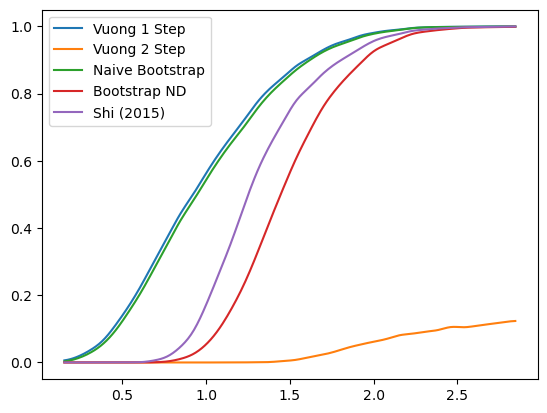

In [14]:
mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)
